# Olivia Debnath 
### **BIH/Charité**
#### 2025

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (4,4)
plt.rcParams["axes.grid"] = False
sc.settings.set_figure_params(dpi=80, dpi_save=180, vector_friendly=True, transparent=True) #for figures

#Read panNEC anndata: 
results= "./pnec_anndata_082023/pNEC_updated_annot_07082023.h5ad"
adata= sc.read_h5ad(results)

#Rename clusters:
adata.obs['Cell states'] = (adata.obs["Cell states"].map(lambda x: {"Neuroendocrine EEC-like01": "Amphicrine progenitor-like",
                    "Neuroendocrine EEC-like02": "Neuroendocrine",
                    "Neuroendocrine HSP+": "Neuroendocrine HSP+ (hypoxic)"}.get(x, x)).astype("category"))

adata.obs['Cell states'].cat.categories

Index(['Amphicrine acinar01', 'Amphicrine acinar02', 'Amphicrine acinar03',
       'Amphicrine acinar proliferating', 'Amphicrine progenitor-like',
       'Neuroendocrine', 'Neuroendocrine proliferating',
       'Neuroendocrine HSP+ (hypoxic)', 'Neuroendocrine stromal-like',
       'Stroma (normal)', 'Lymphocytes', 'Macrophages'],
      dtype='object')

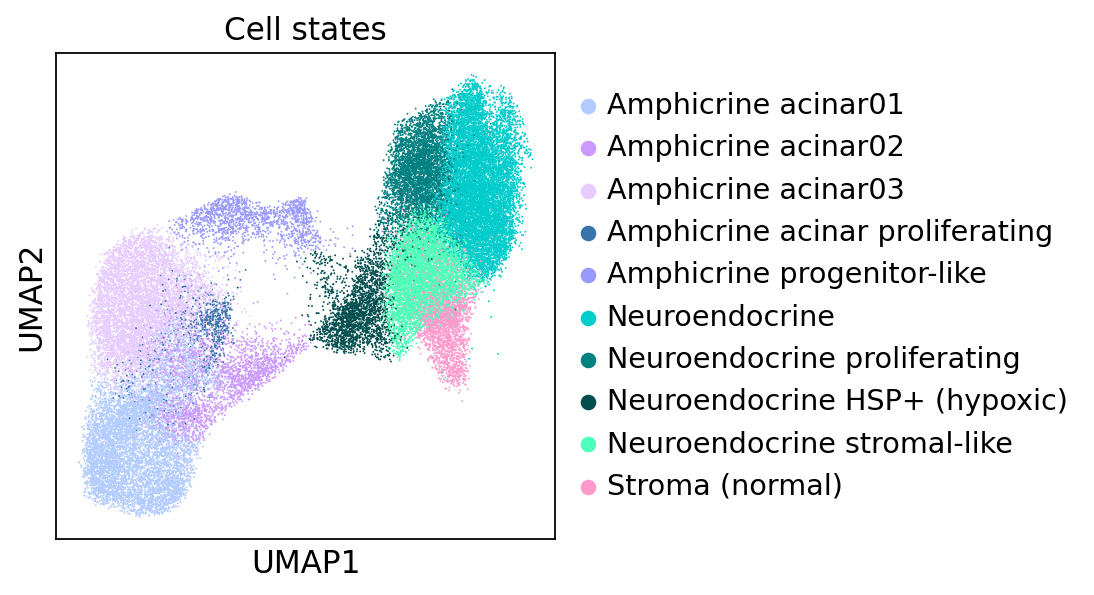

In [2]:
#Subset the clusters without immune:
adata_sub= adata[~adata.obs['Cell states'].isin(['Lymphocytes', 'Macrophages'])]

sc.pl.umap(adata_sub, color= ['Cell states'], ncols=1)

In [3]:
#If raw data is available in adata_sub.raw, revert to it
if adata_sub.raw is not None:
    adata_sub = adata_sub.raw.to_adata()

#Normalize total counts to 10,000 per cell
sc.pp.normalize_total(adata_sub, target_sum=1e4)

#Re-check the total counts per cell after normalization (before log transformation)
total_counts_per_cell = np.sum(adata_sub.X, axis=1)
mean_total_counts = np.mean(total_counts_per_cell)
print(f"Mean total counts per cell after normalization (before log transformation): {mean_total_counts}")

#Apply log transformation if required
sc.pp.log1p(adata_sub)

Mean total counts per cell after normalization (before log transformation): 10000.0


In [4]:
#Load the Excel file (markers per sub-state)
#This is Supplementary Table 2 (Cell state markers) from the paper: 
file_path = 'Supplementary Table 23_panNEC_substate_markers.xlsx'

#Check the sheet names in the file
excel_data = pd.ExcelFile(file_path)
print("Available sheet names:", excel_data.sheet_names)

Available sheet names: ['LogisticRegression_results', 'Amphicrine_acinar_comparison']


In [5]:
#Function to identify genes that are in date format
def is_date_format(gene_name):
    try:
        pd.to_datetime(gene_name, format='%Y-%m-%d', errors='raise')
        return True
    except ValueError:
        return False

#Function to clean the DataFrame (drop NaNs, handle date format)
def clean_dataframe(df, gene_col):
    #Drop rows with any NaN values
    df_cleaned = df.dropna()
    
    #Scan for genes in date format & remove them
    genes_in_date_format = df_cleaned[gene_col].apply(is_date_format)
    df_cleaned = df_cleaned[~genes_in_date_format]

    return df_cleaned

#Function to process Sheet-1 (panNEC sub-state markers)
def process_sheet1(sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    #Calculate the ratio of pct.1/pct.2
    df['pct_ratio'] = df['pct.1'] / df['pct.2']
    
    filtered_df = df[(df['avg_log2FC'] > 0.25) & (df['p_val_adj'] < 0.001) 
                & (df['pct_ratio'] > 0.40)]

    #Clean the DataFrame
    filtered_df = clean_dataframe(filtered_df, 'gene')

    #Sort by avg_log2FC & select the top 100 markers per sub-state:
    #markers_dict = filtered_df.groupby('panNEC sub-state').apply(lambda x: x.nlargest(100, 'avg_log2FC')['gene'].tolist()).to_dict()
    
    markers_dict = filtered_df.groupby('panNEC sub-state')['gene'].apply(list).to_dict()
    return markers_dict

#For amphicrine acinar sub-groups, maybe, a "composite score" would be a better reflection to
#pick up robust/specific DEGs. 

#Function to process Sheet-2 (Amphicrine acinar sub-state markers)
#We should provide a score cut-off based on the distribution
def process_sheet2(sheet_name, score_threshold=15, automatic_threshold=True):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    def process_substate(df, substate_prefix):
        #Identify the relevant columns
        gene_col = f'{substate_prefix}_n'
        log2fc_col = f'{substate_prefix}_log2FC'
        pval_col = f'{substate_prefix}_p'
        score_col = f'{substate_prefix}_score'
        
        #Apply score threshold (start with 99.5th percentile)
        if automatic_threshold:
            score_threshold = df[score_col].quantile(0.995)
            print(f"Score threshold for {substate_prefix}: {score_threshold}")
        
        #Filter the markers
        filtered_df = df[(df[log2fc_col] > 0.25) & (df[pval_col] < 0.001) & (df[score_col] > score_threshold)]

        #Clean the DataFrame
        filtered_df = clean_dataframe(filtered_df, gene_col)

        #Sort by log2FC and select the top markers based on your criteria
        #Instead of limiting to top 100, allow flexibility based on score cutoff
        sorted_df = filtered_df.sort_values(by=log2fc_col, ascending=False)
        
        #Return the list of gene names
        return sorted_df[gene_col].tolist()

    #Process each sub-state
    substates = ['Amphicrine acinar01', 'Amphicrine acinar02', 'Amphicrine acinar03']  
    markers_dict = {substate: process_substate(df, substate) for substate in substates}
    return markers_dict

#Process both sheets of the Excel file
sheet1_markers = process_sheet1('LogisticRegression_results')
sheet2_markers = process_sheet2('Amphicrine_acinar_comparison')

#Combine results (version-2)
combined_markers_v2 = {**sheet1_markers, **sheet2_markers}

#Display the results
for substate, markers in combined_markers_v2.items():
    print(f"Top markers for {substate}: {markers[:8]} ...")  # Display the first 5 markers as a sample

#Optionally save to a file
#combined_df_v2 = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in combined_markers_v2.items()]))
#combined_df_v2.to_excel('Combined_panNEC_Amphicrine_v2_composite_score_DEGs_130824.xlsx', index=False)

Score threshold for Amphicrine acinar01: 12.77199139999998
Score threshold for Amphicrine acinar02: 9.624981399999992
Score threshold for Amphicrine acinar03: 13.93328055999998
Top markers for Amphicrine acinar proliferating: ['DTL', 'BRCA1', 'DIAPH3', 'POLQ', 'MELK', 'CENPU', 'BRIP1', 'BRCA2'] ...
Top markers for Amphicrine progenitor-like: ['FREM2', 'ALK', 'RASGRF1', 'SHISA9', 'NOTUM', 'AC078923.1', 'SAXO1', 'U91319.1'] ...
Top markers for Lymphocytes: ['PTPRC', 'ARHGAP15', 'ETS1', 'IKZF1', 'CD247', 'RIPOR2', 'INPP5D', 'PRKCB'] ...
Top markers for Macrophages: ['STAB1', 'MS4A6A', 'CSF2RA', 'CD163L1', 'MYO1F', 'TYMP', 'AOAH', 'SLC8A1'] ...
Top markers for Neuroendocrine : ['ADARB2', 'RIMBP2', 'LDLRAD4', 'CACNA1A', 'LINC01811', 'RBFOX1', 'LINC01876', 'MIR4713HG'] ...
Top markers for Neuroendocrine HSP+ (hypoxic): ['HSPH1', 'DNAJB1', 'HSPA1B', 'CACYBP', 'HSPB1', 'HSP90AB1', 'HSPE1', 'HSP90AA1'] ...
Top markers for Neuroendocrine Stromal-like: ['PTPRM', 'PLCG2', 'RORA', 'ROBO2', 'NRXN3',

In [6]:
#Create a combined df (or optionally save to a file): 
combined_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in combined_markers_v2.items()]))

#Print the number of DEGs per cell state
for substate in combined_df.columns:
    num_degs = combined_df[substate].dropna().shape[0]
    print(f"Number of DEGs for {substate}: {num_degs}")

Number of DEGs for Amphicrine acinar proliferating: 723
Number of DEGs for Amphicrine progenitor-like: 686
Number of DEGs for Lymphocytes: 285
Number of DEGs for Macrophages: 517
Number of DEGs for Neuroendocrine : 231
Number of DEGs for Neuroendocrine HSP+ (hypoxic): 468
Number of DEGs for Neuroendocrine Stromal-like: 39
Number of DEGs for Neuroendocrine proliferating: 329
Number of DEGs for Stromal (normal): 290
Number of DEGs for Amphicrine acinar01: 157
Number of DEGs for Amphicrine acinar02: 146
Number of DEGs for Amphicrine acinar03: 165


In [7]:
#List of genes to check
#Cool! The CS method didn't filter out biologically robust genes 
genes_to_check = ["GP2", "PLXNA2", "UST", "IL1RAPL1", "NR5A2", "CLPS",
    "CPA1", "SERPINI2", "CEL", "GCNT2", "RBPJ", "RRBP1", 
    "CPA2", "CACNA1A"]


#Filter combined_df to only include the top 100 DEGs for Amphicrine acinar01
top_100_acinar01_genes = combined_df['Amphicrine acinar01'].head(100).dropna().values

#Check if the specified genes are in the top 100
genes_present = [gene for gene in genes_to_check if gene in top_100_acinar01_genes]

#Output the result
print(f"Genes found in Amphicrine acinar01 top 100 DEGs: {genes_present}")
print(f"Genes not found: {[gene for gene in genes_to_check if gene not in top_100_acinar01_genes]}")

#Please choose genes in 99.5 or higher percentile. Else, it'd filter out NR5A2, CEL in amph acinar-01. 

Genes found in Amphicrine acinar01 top 100 DEGs: ['GP2', 'PLXNA2', 'UST', 'IL1RAPL1', 'NR5A2', 'CLPS', 'CPA1', 'SERPINI2', 'CEL', 'GCNT2', 'RBPJ', 'RRBP1', 'CPA2', 'CACNA1A']
Genes not found: []


In [8]:
#Main Figure-2: from ./PTF1A_brain_targets_revised_220524.ipynb
#PTF1A signatures from Meredith et al 2013: 

#PTF1 targets pancreas (mouse) based on ChIPseq: From https://doi.org/10.1128/MCB.00364-13
PTF1A_pancreas_targets= ['CTRB1', 'AMY2B', 'CLPS', 'EEF1A1', 'CPA1', 'CPA2', 'RPL32', 'RPS4X', 'PPIA', 'RPS3A', 'RPS14', 'TPT1', 'RPS24', 'SERPINA6', 'RPS8', 'RPL12', 'SPINK3', 'RPL10A', 'RPL28', 'CELA3B', 'RPL5', 'CELA1', 'RPL31', 'NUPR1', 'TMSB4X', 'NME2', 'RPL29', 'NACA', 'CEL', 'RPL14', 'MT1', 'CELA2A', 'PRSS2', 'P4HB', 'TMEM97', 'RPL27A', '2010107E04RIK', 'PPIB', 'RPS13', 'PTMA', 'GNAS', 'RPL21', 'CPB1', 'LGALS1', 'TRY10', '1810006K21RIK', 'TRY5', 'GSTM1', 'IGF2', 'PDIA6', 'ATP5L', 'CLU', 'SEPP1', 'COX6C', 'MEST', 'OSTC', 'HMGN2', 'CD63', 'COX7C', 'ATP5H', 'ITM2A', 'HMGB1', 'SERPINI2', 'SNRPG', 'SHFM1', 'SNRPE', 'GPC3', 'ATP5O', 'H2AFZ', 'SEC61B', 'SPINT2', 'FABP5', 'KRT18', 'REEP5', 'SYCN', 'EIF3M', 'ATP5J', 'TTR', 'AMBP', 'ATPIF1', 'AMY1', 'SOD1', 'TMED2', 'SSR3', 'TMED6', 'COL1A1', 'CCKAR', 'ANXA2', 'BSG', 'KRT8', 'PCBD1', 'HINT1', 'SERPINH1', 'ATP5C1', 'XBP1', 'CLDN10', 'GC', 'IDH2', 'PDIA2', 'FTH1', 'MGST1', 'ARHGDIG', 'FKBP11', 'ERP27', 'REG1', 'DCN', 'NDUFB11', 'MEG3', 'PEBP1', 'CALM2', 'NDUFA6', 'NDUFB9', 'AES', 'TRY4', 'ATP5G1', 'ASS1', 'EPCAM', 'SNX22', 'RNH1', 'DSTN', 'GSTP1', 'BEX4', 'CDC42', 'D17WSU104E', 'ASNS', 'CYB5', 'RPS15A', 'LAPTM4A', 'H3F3A', 'DLK1', 'UQCR10', 'RBBP7', 'SRSF3', 'EIF4A2', 'SRSF5', 'CFDP1', 'HMGB2', 'PSMA7', 'PSMB1', 'SNRPD1', 'MRPL33', 'LDHA', 'ARF1', 'CTNNB1', 'KPNA2', 'COX7A2L', 'D10WSU52E', 'H1F0']

#PTF1A targets Brain (mouse) based on ChIPseq: https://doi.org/10.1128/MCB.00364-13
PTF1A_brain_targets= ['TUBA1A', 'TUBB3', 'TUBB5', 'STMN1', 'TUBA1C', 'NPY', 'METRN', 'TAGLN3', 'DBN1', 'PCBP4', 'BASP1', 'ROBO3', 'NSG2', 'TRP53I11', 'DPYSL4', 'RND2', 'SOX4', 'UCHL1', 'SOX11', 'MTAP1B', 'NKAIN1', 'CDKN1C', 'CDK2AP1', 'RCOR2', '6330527O06RIK', 'PAX2', 'ELAVL3', 'CELF3', 'H2AFY2', 'GNAI2', 'PODXL2', 'SSBP3', 'D0H4S114', 'GPR56', 'APLP1', 'CHD4', 'CNTN2', 'JUND', 'DDR1', 'TFAP2B', 'SMARCD1', 'LHX1', 'MARCKS', 'DNER', 'SOX2', 'FEZ1', 'GADD45G', 'LMNB1', 'MAP4K4', 'SOX3', 'FZD10', 'COTL1', 'LHX5', 'CACNG4', 'LBX1', 'EIF2C1', 'MAB21L2', 'MTAP7D1', 'CDK5R1', 'PHC2', 'EVL', 'SKOR1', 'ENC1', 'NES', 'KCTD15', 'CELSR2', 'VANGL2', 'AGRN', 'RND3', 'EBF3', 'NCAM1', 'DUSP4', 'HES6', 'HES5', 'POU3F3', 'CDH2', 'NHLH2', 'PRRC2B', 'GAS1', 'RGMB', '2700081O15RIK', 'MKRN1', 'KHDRBS1', 'GBX2', 'ACCN2', 'SPNB3', 'DCC', 'HOXC4', 'RUNX1T1', 'MEIS3', 'SPSB4', 'AGAP3', 'TPPP3', 'CIRBP', 'CORO1C', 'GNAO1', 'PLEKHO1', 'CITED2', 'BCL7A', 'ARID1A', 'PTBP2', 'ZMIZ1', 'GPM6B', 'GM5506', 'DLGAP4', 'SLC38A1', 'FOXP4', 'ABAT', 'MCM2', 'RTN3', 'PSMD3', 'STK11', 'RACGAP1', 'RALY', 'NXN', 'CXXC5', 'THRA', 'ANP32E', 'PJA1', 'RTN4', 'LMO4', 'BOD1', 'PSMD4', 'ARL3', 'PEA15A', 'UBE2V1', 'CCNI', 'SLC38A2', 'HP1BP3', 'UCK2', 'UBE2E3', 'SNRPA1', 'SARS', 'G3BP1', 'EIF4H', 'PRKCSH', 'MDH2', 'TSC22D1', 'THRAP3', 'APP', 'CSNK1A1', 'PPP2R4', 'CHMP4B', 'CAP1', 'NDUFS2', 'ATXN10', 'ICT1', 'ALDOA', 'GM5148', 'NDUFA10']

print(len(PTF1A_brain_targets)) 
print(len(PTF1A_pancreas_targets)) 

150
148


In [9]:
#From GTEX analysis: we ran DESeq2 to compare brain vs pancreatic samples (refer to GTEX analysis notebook)

#Source notebook: ./PTF1A_brain_targets_revised_220524.ipynb
NKX22_Brain_targets= ['ANP32E', 'RGS5', 'SELENOW', 'SYTL2', 'TBCB', 'ACHE', 'ALDH4A1', 'ALDH6A1', 'ALOXE3', 'APC', 'B4GALNT1', 'BCO1', 'BLM', 'CALM2', 'CCNJL', 'CFAP57', 'DAB1', 'DNAJC18', 'DPYSL2', 'EFHD1', 'EID2B', 'EXD1', 'FAM156A', 'GALNT5', 'GPR19', 'HOMER1', 'HSD11B1L', 'ISLR2', 'ITPR1', 'ITSN1', 'KIAA0319', 'LARP6', 'LINC01411', 'MEF2C', 'MIR320A', 'NEK10', 'NWD1', 'OXCT1', 'PIPOX', 'PITX2', 'PKIB', 'PPFIA3', 'PREPL', 'PRR7', 'PTGS2', 'PTPRE', 'PTPRO', 'RAB30', 'RHEBL1', 'RN7SL3', 'RTN3', 'SERPINI1', 'SHC4', 'SLC25A12', 'SMPD3', 'SNCAIP', 'SNX10', 'SOBP', 'SORBS1', 'SOX2-OT', 'SP8', 'SRGAP3', 'TERF2IP', 'TFPT', 'TMC1', 'TNK2', 'TRIM37', 'TRIM69', 'WNK1']
NKX22_pancreas_targets= ['BTNL8', 'C4orf19', 'FOXA3', 'GAS5', 'IGF2BP3', 'IPO4', 'RAB27A', 'RAB3D', 'RBM47', 'SERP1', 'SNORD101', 'XPNPEP1', 'ZSCAN2', 'AGR2', 'ANG', 'ANXA4', 'BCL2L14', 'C11orf52', 'C4BPB', 'CLNK', 'CRYZ', 'CTNS', 'DENND2D', 'EHF', 'ERBB2', 'ESRP2', 'GCNT3', 'GPR160', 'HERPUD1', 'HOXA-AS2', 'HOXB3', 'HSD17B2', 'IFRD2', 'IMMP1LP1', 'ITGB6', 'LINC00923', 'LINC00963', 'LINC02038', 'LINC02068', 'MEIS1', 'MIA2', 'MIR194-2HG', 'MIR3646', 'MIR7111', 'NAGLU', 'NFKBIZ', 'OSR2', 'P4HB', 'PLA2G2A', 'PPP1R13L', 'PRLR', 'PRR15', 'PSMD6', 'RACK1', 'REG4', 'RGS17P1', 'RNASE4', 'RPS17', 'S100A14', 'SH3RF2', 'SLC39A8', 'SPINK5', 'SPR', 'SSR2', 'SSR3', 'STAT6', 'SYVN1', 'TEC', 'TMCO4', 'TMEM39A', 'TSPEAR-AS2', 'UGT1A6']

PAX6_brain= ['ANP32E', 'RGS5', 'SELENOW', 'SYTL2', 'TBCB', 'ABCB1', 'ABLIM2', 'ADAMTS20', 'ADGRA1-AS1', 'ANK2', 'ANK3', 'BRINP2', 'BRINP3', 'BSN', 'C12orf76', 'CAMK2N1', 'CAMSAP2', 'CCDC136', 'CCP110', 'CDH22', 'CDH8', 'CDHR3', 'CFAP45', 'CNRIP1', 'DCLK1', 'DENND2A', 'DIO2', 'DKK3', 'DLG2', 'DOCK4', 'ERMN', 'FHOD3', 'FRMPD2', 'GALNT16', 'GRIK4', 'HEY1', 'HSD17B6', 'IL34', 'KCNJ10', 'KIAA1614', 'LINC01363', 'LINC01716', 'LINC01833', 'LYNX1', 'MAN1C1', 'MAP3K12', 'MRLN', 'MT-RNR1', 'MT-TF', 'MT-TL1', 'MT-TP', 'MTCO3P12', 'MTTP', 'MYL6B', 'NFASC', 'NKAIN4', 'NPL', 'NRXN3', 'OTX2', 'P2RX6', 'PDE1A', 'PDZD2', 'PKD1', 'PRKCE', 'PRR5L', 'RAB3C', 'RARB', 'RGS22', 'RGS4', 'RGS7', 'RN7SKP192', 'RN7SL741P', 'RNU6ATAC', 'RPL21P42', 'RXRG', 'S1PR5', 'SCHIP1', 'SCIN', 'SCRT1', 'SOWAHA', 'SPOCK2', 'ST18', 'STXBP1', 'SVOP', 'SYT17', 'TCF4', 'TDGF1', 'TENM2', 'THY1', 'TLX2', 'UNC80', 'UPP2', 'ZNF385B', 'ZNF804A']
PAX6_pancreas= ['BTNL8', 'C4orf19', 'FOXA3', 'GAS5', 'IGF2BP3', 'IPO4', 'RAB27A', 'RAB3D', 'RBM47', 'SERP1', 'SNORD101', 'XPNPEP1', 'ZSCAN2', 'AASS', 'ANKEF1', 'ANXA2', 'ARHGEF28', 'BMF', 'CNKSR3', 'DDIT4', 'DDX47', 'EIF2AK3', 'ELF3', 'FOXA2', 'GATA4', 'GATA6-AS1', 'GC', 'GDF15', 'GIPC2', 'HDLBP', 'HGD', 'HNF4A', 'HOOK2', 'IGLV7-46', 'INS', 'INS-IGF2', 'KCNK16', 'KIF12', 'KLF10', 'KRT15', 'LFNG', 'LINC01320', 'LINC01625', 'LINC01767', 'LPCAT3', 'MARVELD3', 'MAT2A', 'MECOM', 'NEAT1', 'PABPC1L', 'PARP12', 'PHLDB2', 'PTGER4', 'PTX3', 'RGL3', 'RN7SL473P', 'RPH3AL', 'SLC37A4', 'SRPRB', 'SSTR5-AS1', 'STC2', 'TES', 'TMEM37', 'TPM1', 'TXK', 'UAP1', 'UGT2B7', 'VEPH1', 'ZC3H12A']

In [10]:
#Input list of variables as string (else would be unhashable type)
TF_signature_names= ['PTF1A_pancreas_targets', 'PTF1A_brain_targets', 
                  'PAX6_pancreas', 'PAX6_brain', 
                  'NKX22_Brain_targets', 'NKX22_pancreas_targets']

#Create the dictionary automatically
TF_signature_modules = {name: globals()[name] for name in TF_signature_names}


#Loop through each TF signature module and compute the module score
for tf_name, tf_genes in TF_signature_modules.items():
    
    #Compute the module score and add it to adata_sub.obs with a unique column name
    sc.tl.score_genes(adata_sub, gene_list=tf_genes, score_name=tf_name + '_score')
    
#Verify that the scores have been added
print(adata_sub.obs.head())

                             orig.ident  nCount_RNA  nFeature_RNA  \
SP084_007_AAACCCAAGATGATTG-1  SP084_007       669.0           554   
SP084_007_AAACCCAAGGAGGTTC-1  SP084_007       505.0           422   
SP084_007_AAACCCAAGGGTAGCT-1  SP084_007       558.0           472   
SP084_007_AAACCCAAGTTGCGAG-1  SP084_007       690.0           575   
SP084_007_AAACCCACAGACCAGA-1  SP084_007      1015.0           806   

                                              orig_cell_id sample_id_final  \
SP084_007_AAACCCAAGATGATTG-1  SP084_007_AAACCCAAGATGATTG-1       SP084_007   
SP084_007_AAACCCAAGGAGGTTC-1  SP084_007_AAACCCAAGGAGGTTC-1       SP084_007   
SP084_007_AAACCCAAGGGTAGCT-1  SP084_007_AAACCCAAGGGTAGCT-1       SP084_007   
SP084_007_AAACCCAAGTTGCGAG-1  SP084_007_AAACCCAAGTTGCGAG-1       SP084_007   
SP084_007_AAACCCACAGACCAGA-1  SP084_007_AAACCCACAGACCAGA-1       SP084_007   

                             group sample_label  nCount_RNA.orig  \
SP084_007_AAACCCAAGATGATTG-1   NET       144501 

In [11]:
import scipy.stats as stats
import statsmodels.stats.multitest as multitest
import matplotlib.pyplot as plt
import seaborn as sns

#Load required dictionary for NEC signatures (pancreas, lungs & prostate)
signature_modules = TF_signature_modules 

#Perform the hypergeometric test and calculate enrichment score
def hypergeometric_test(signature, markers, background_genes):
    M = len(background_genes)  #Total number of genes in the background set (N)
    n = len(signature)  #Number of genes in the signature module (n)
    D = len(markers)  #Number of genes in the sub-state markers (D)
    x = len(set(signature) & set(markers))  #Number of overlapping genes (x)

    #Expected overlap
    expected_overlap = (n * D) / M

    #Enrichment score (representation factor)
    enrichment_score = x / expected_overlap if expected_overlap > 0 else 0

    #Hypergeometric p-value
    p_value = stats.hypergeom.sf(x-1, M, D, n)
    
    return p_value, x, enrichment_score

#Perform the overlap analysis for each signature with each sub-state marker
results = []

#Background genes: assuming adata_sub contains your single-cell data
background_genes = adata_sub.var_names.tolist()  #List of all genes expressed in snRNA-seq data

for signature_name, signature_genes in signature_modules.items():
    for substate, markers in combined_markers_v2.items(): #take combined_markers_v2 data 
        p_value, overlap_count, enrichment_score = hypergeometric_test(signature_genes, markers, background_genes)
        results.append({
            'Signature': signature_name,
            'Substate': substate,
            'p_value': p_value,
            'overlap_count': overlap_count,
            'enrichment_score': enrichment_score
        })

#Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df.head())

#Adjust p-values for multiple testing using Benjamini-Hochberg correction
results_df['p_adj'] = multitest.multipletests(results_df['p_value'], method='fdr_bh')[1]

#Filter significant overlaps (adjust the threshold as needed)
significant_results = results_df[results_df['p_adj'] < 0.05]
print(significant_results.head(10)) 

#Check if there are any significant results
if not significant_results.empty:
    print("Significant Signature-Cellstate pairs:")
    for index, row in significant_results.iterrows():
        print(f"Signature: {row['Signature']}, Substate: {row['Substate']}, p_adj: {row['p_adj']:.4f}, Overlap Count: {row['overlap_count']}, Enrichment Score: {row['enrichment_score']:.2f}")
else:
    print("No significant Signature-Cellstate pairs found.")

                Signature                         Substate   p_value  \
0  PTF1A_pancreas_targets  Amphicrine acinar proliferating  0.410459   
1  PTF1A_pancreas_targets       Amphicrine progenitor-like  0.372822   
2  PTF1A_pancreas_targets                      Lymphocytes  1.000000   
3  PTF1A_pancreas_targets                      Macrophages  0.904767   
4  PTF1A_pancreas_targets                  Neuroendocrine   0.648668   

   overlap_count  enrichment_score  
0              4          1.228851  
1              4          1.295130  
2              0          0.000000  
3              1          0.429623  
4              1          0.961536  
                 Signature                         Substate       p_value  \
9   PTF1A_pancreas_targets              Amphicrine acinar01  1.511740e-14   
19     PTF1A_brain_targets     Neuroendocrine proliferating  1.420432e-04   
33           PAX6_pancreas              Amphicrine acinar01  3.400139e-04   
34           PAX6_pancreas           

In [12]:
#Filter the DataFrame for Neuroendocrine proliferating substate
ne_proliferating_results = results_df[results_df['Substate'] == 'Neuroendocrine proliferating']

#Display the filtered results
print(ne_proliferating_results) 
#Wow- PTF1A brain target module is significantly enriched (enrichment score= 5.328956; p-value= 0.000142 & FDR= 0.005114)
#Note the insignicant results for pancreatic target module 

                 Signature                      Substate   p_value  \
7   PTF1A_pancreas_targets  Neuroendocrine proliferating  0.775085   
19     PTF1A_brain_targets  Neuroendocrine proliferating  0.000142   
31           PAX6_pancreas  Neuroendocrine proliferating  0.500810   
43              PAX6_brain  Neuroendocrine proliferating  0.014855   
55     NKX22_Brain_targets  Neuroendocrine proliferating  0.500810   
67  NKX22_pancreas_targets  Neuroendocrine proliferating  0.515680   

    overlap_count  enrichment_score     p_adj  
7               1          0.675121  1.000000  
19              8          5.328956  0.005114  
31              1          1.448086  0.858531  
43              4          4.251827  0.118843  
55              1          1.448086  0.858531  
67              1          1.387749  0.863464  


In [13]:
#Set the desired order for signatures and substates
desired_signature_order = ['PTF1A_pancreas_targets', 'PTF1A_brain_targets', 
                           'PAX6_pancreas', 'PAX6_brain', 
                           'NKX22_pancreas_targets', 'NKX22_Brain_targets']  # Replace with your desired order of signatures

#Correct the cluster names
desired_substate_order = ['Amphicrine progenitor-like', 'Amphicrine acinar proliferating', 'Amphicrine acinar01', 'Amphicrine acinar02',
       'Amphicrine acinar03', 'Neuroendocrine ', 'Neuroendocrine proliferating', 'Neuroendocrine HSP+ (hypoxic)',
        'Neuroendocrine Stromal-like', 'Stromal (normal)']  # Replace with your desired order of substates

#Convert the 'Signature' and 'Substate' columns to categorical with the specified order
results_df['Signature'] = pd.Categorical(results_df['Signature'], categories=desired_signature_order, ordered=True)
results_df['Substate'] = pd.Categorical(results_df['Substate'], categories=desired_substate_order, ordered=True)

results_df['Substate'].value_counts() #check if all panNEC states are present & have 17 signatures scores

Stromal (normal)                   6
Neuroendocrine Stromal-like        6
Neuroendocrine HSP+ (hypoxic)      6
Neuroendocrine proliferating       6
Neuroendocrine                     6
Amphicrine acinar03                6
Amphicrine acinar02                6
Amphicrine acinar01                6
Amphicrine acinar proliferating    6
Amphicrine progenitor-like         6
Name: Substate, dtype: int64

In [14]:
#Normalize the enrichment scores
min_enrichment_score = results_df['enrichment_score'].min()
max_enrichment_score = results_df['enrichment_score'].max()
results_df['enrichment_score_scaled'] = (results_df['enrichment_score'] - min_enrichment_score) / (max_enrichment_score - min_enrichment_score)


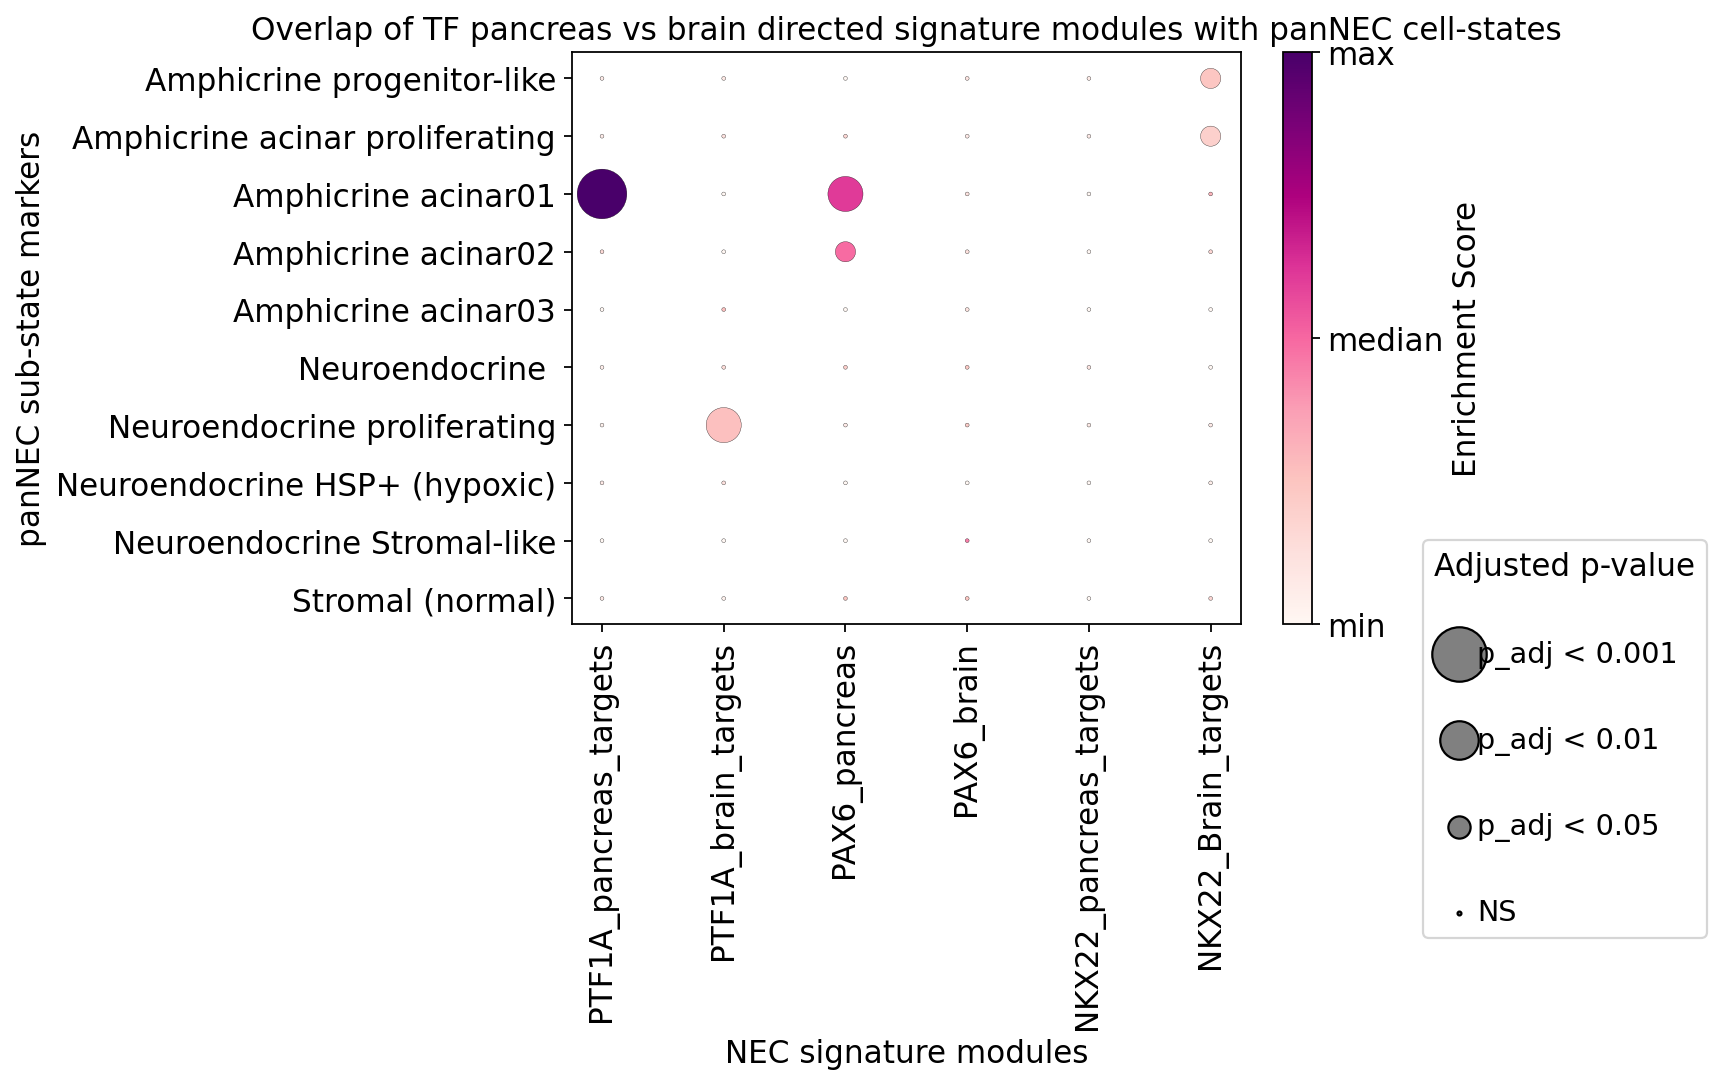

In [15]:
#Define the color map for enrichment scores: 
#Finalize this for main figure 2C. 
cmap = plt.cm.RdPu 

#Define bubble sizes based on p-value significance
def p_value_bracket(p_value):
    if p_value < 0.001:
        return 600
    elif p_value < 0.01:
        return 300
    elif p_value < 0.05:
        return 100 
    else:
        return 5 

results_df['bubble_size'] = results_df['p_adj'].apply(p_value_bracket)

#Create the plot
plt.figure(figsize=(11, 7))
scatter = sns.scatterplot(
    data=results_df,
    x='Signature',
    y='Substate',
    size='bubble_size',  # Bubble size based on p-value brackets
    hue='enrichment_score_scaled',  # Color based on scaled enrichment score
    palette=cmap,  # Use a "Purples" color map
    edgecolor='black',  # Outline significant bubbles
    sizes=(3, 500),  # Adjust the range of sizes to fit the new calculation
    legend=False,  # Disable the automatic legend to customize it manually
    hue_norm=(0, 1)
)

#Part-I (bubble color)
#Add a colorbar with correct tick labels for the enrichment score
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

#Adjust the ticks and labels on the colorbar based on the normalized enrichment scores
cbar = plt.colorbar(sm, label='Enrichment Score')

#Set the colorbar ticks and labels to 'min', 'median', 'max'
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(['min', 'median', 'max'])


#Part-II (bubble size)
#Add custom legend for bubble sizes
handles = [
    plt.scatter([], [], s=600, color='gray', edgecolor='black', label='p_adj < 0.001'),
    plt.scatter([], [], s=300, color='gray', edgecolor='black', label='p_adj < 0.01'),
    plt.scatter([], [], s=100, color='gray', edgecolor='black', label='p_adj < 0.05'),
    plt.scatter([], [], s=3, color='gray', edgecolor='black', label='NS') #not significant 
]


#Fix legend: 
plt.legend(
    handles=handles,
    loc='center left', 
    bbox_to_anchor=(1.25, -0.2),  #This places the legend outside to the right of the plot
    scatterpoints=1, 
    labelspacing=2,  # Increase space between labels
    borderaxespad=0.5,
    frameon=True, 
    title='Adjusted p-value'
)

#Final touches
plt.grid(False)  #Remove grid lines
plt.title('Overlap of TF pancreas vs brain directed signature modules with panNEC cell-states')
plt.xlabel('NEC signature modules')
plt.ylabel('panNEC sub-state markers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

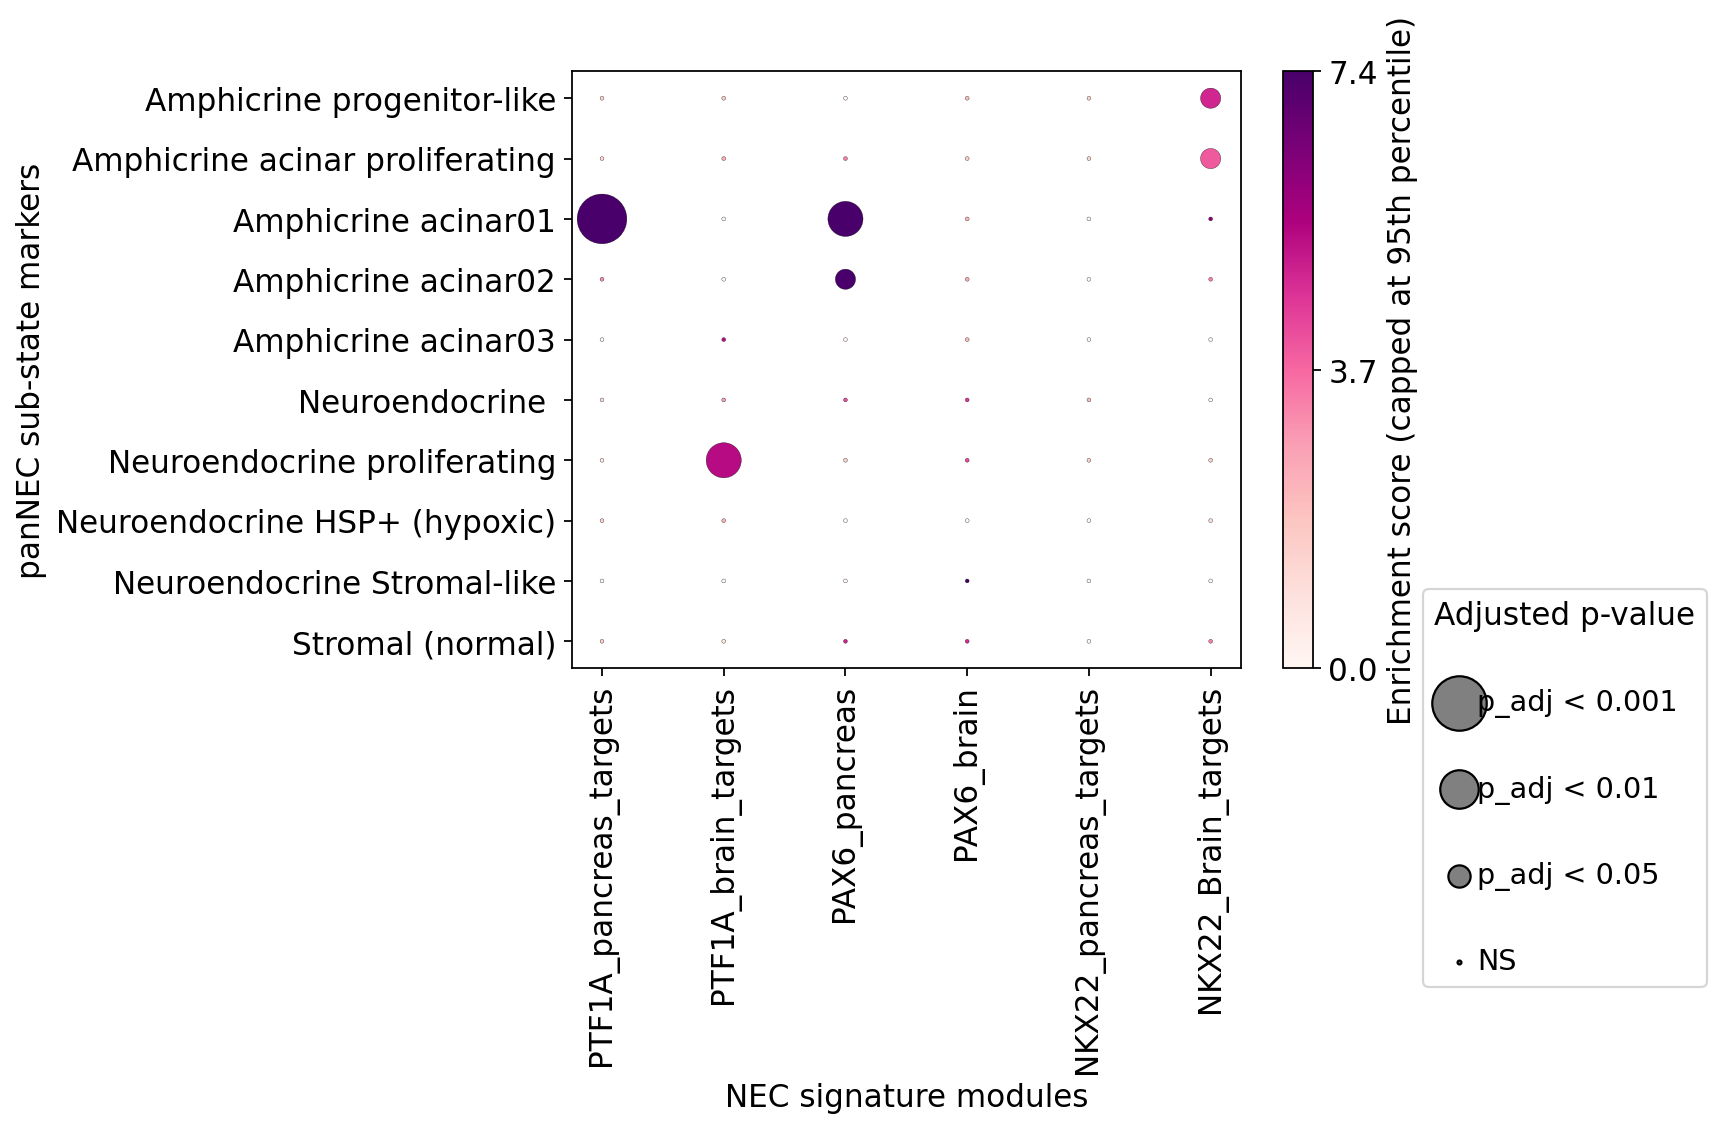

In [16]:
#Capping at 95th percentile- to visually improve the NE prol score (which is highly significant after p-value adjustment anyway)

#Define colormap
cmap = plt.cm.RdPu

# Define bubble sizes based on p-value significance
def p_value_bracket(p_value):
    if p_value < 0.001:
        return 600
    elif p_value < 0.01:
        return 300
    elif p_value < 0.05:
        return 100
    else:
        return 5

# Apply bubble size
results_df['bubble_size'] = results_df['p_adj'].apply(p_value_bracket)

# Cap enrichment score at 95th percentile
cap_value = np.percentile(results_df['enrichment_score'], 95)

# Clip and normalize enrichment score
results_df['enrichment_score_clipped'] = results_df['enrichment_score'].clip(upper=cap_value)
results_df['enrichment_score_scaled'] = (
    results_df['enrichment_score_clipped'] - results_df['enrichment_score_clipped'].min()
) / (results_df['enrichment_score_clipped'].max() - results_df['enrichment_score_clipped'].min())

# Setup plot
plt.figure(figsize=(11, 7))
scatter = sns.scatterplot(
    data=results_df,
    x='Signature',
    y='Substate',
    size='bubble_size',
    hue='enrichment_score_scaled',
    palette=cmap,
    edgecolor='black',
    sizes=(3, 500),
    legend=False,
    hue_norm=(0, 1)
)

# Colorbar with custom tick labels from real (clipped) enrichment scores
norm = plt.Normalize(0, 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label= 'Enrichment score (capped at 95th percentile)')
min_score = results_df['enrichment_score_clipped'].min()
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels([
    f'{min_score:.1f}',
    f'{(min_score + cap_value) / 2:.1f}',
    f'{cap_value:.1f}'
])

# Custom legend for p-value brackets
handles = [
    plt.scatter([], [], s=600, color='gray', edgecolor='black', label='p_adj < 0.001'),
    plt.scatter([], [], s=300, color='gray', edgecolor='black', label='p_adj < 0.01'),
    plt.scatter([], [], s=100, color='gray', edgecolor='black', label='p_adj < 0.05'),
    plt.scatter([], [], s=3, color='gray', edgecolor='black', label='NS')
]
plt.legend(
    handles=handles,
    loc='center left',
    bbox_to_anchor=(1.25, -0.2),
    scatterpoints=1,
    labelspacing=2,
    borderaxespad=0.5,
    frameon=True,
    title='Adjusted p-value'
)

# Final plot adjustments
plt.grid(False)
#plt.title('Overlap of TF pancreas vs brain directed signature modules with panNEC cell-states')
plt.xlabel('NEC signature modules')
plt.ylabel('panNEC sub-state markers')
plt.xticks(rotation=90)
plt.tight_layout()

# Save the figure in high resolution
plt.savefig('Figure2C_bubbleplot_filtered_600dpi_25032025.pdf', dpi=600, bbox_inches="tight")  # High-res PDF
plt.show()

#We capped the color scale at the 95th percentile of the raw enrichment scores.
#Stroma (normal) is used as a negative control- as any bonafide non-tumor/non-epithelial cells should be show 
#statistically significant enrichment for PTF1A directed brain targets 

In [17]:
#Seurat LR marker list:
#We need to extract avg_log2FC for figure 2D too. 
file_path = 'Supplementary Table 23_panNEC_substate_markers.xlsx'

sheet_name = 'LogisticRegression_results'

def process_sheet_for_bubble_plot(sheet_name):
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Select only rows with specified brain target genes
    brain_targets = ['PRRC2B', 'SSBP3', 'ARID1A', 'HP1BP3', 'KHDRBS1', 'LMNB1', 
                     'NCAM1', 'THRAP3', 'NFASC', 'PKD1', 'PRKCE', 'STXBP1']
    filtered_df = df[df['gene'].isin(brain_targets)]
    
    # Select columns for avg_log2FC, pct.1, and gene name
    bubble_plot_data = filtered_df[['gene', 'panNEC sub-state', 'avg_log2FC', 'pct.1']]
    
    return bubble_plot_data

#Extract data
bubble_plot_data = process_sheet_for_bubble_plot(sheet_name)

# Display the prepared table to the user for further plotting
#tools.display_dataframe_to_user(name="Bubble Plot Data for Brain Targets", dataframe=bubble_plot_data)

In [18]:
bubble_plot_data #Mostly genes independent of cell cycle/E2F targets are contributing towards PTF1A brain score 

,gene,panNEC sub-state,avg_log2FC,pct.1
29,LMNB1,Neuroendocrine proliferating,1.188992,0.251
120,PKD1,Neuroendocrine proliferating,0.765658,0.296
124,KHDRBS1,Neuroendocrine proliferating,0.732811,0.273
127,NFASC,Neuroendocrine proliferating,0.722345,0.316
151,SSBP3,Neuroendocrine proliferating,0.523768,0.448
195,PRKCE,Neuroendocrine proliferating,0.563536,0.289
200,HP1BP3,Neuroendocrine proliferating,0.465209,0.286
204,STXBP1,Neuroendocrine proliferating,0.529341,0.256
217,ARID1A,Neuroendocrine proliferating,0.449327,0.284
223,THRAP3,Neuroendocrine proliferating,0.455740,0.296


In [19]:
#Subset clusters: 
adata_sub02= adata_sub[adata_sub.obs['Cell states'].isin(['Neuroendocrine', 'Neuroendocrine proliferating',
       'Neuroendocrine HSP+ (hypoxic)', 'Neuroendocrine stromal-like'])]

adata_sub02.obs['Cell states'].value_counts()

Neuroendocrine                   10095
Neuroendocrine stromal-like       5668
Neuroendocrine proliferating      4033
Neuroendocrine HSP+ (hypoxic)     2275
Name: Cell states, dtype: int64

Trying to set attribute `._uns` of view, copying.


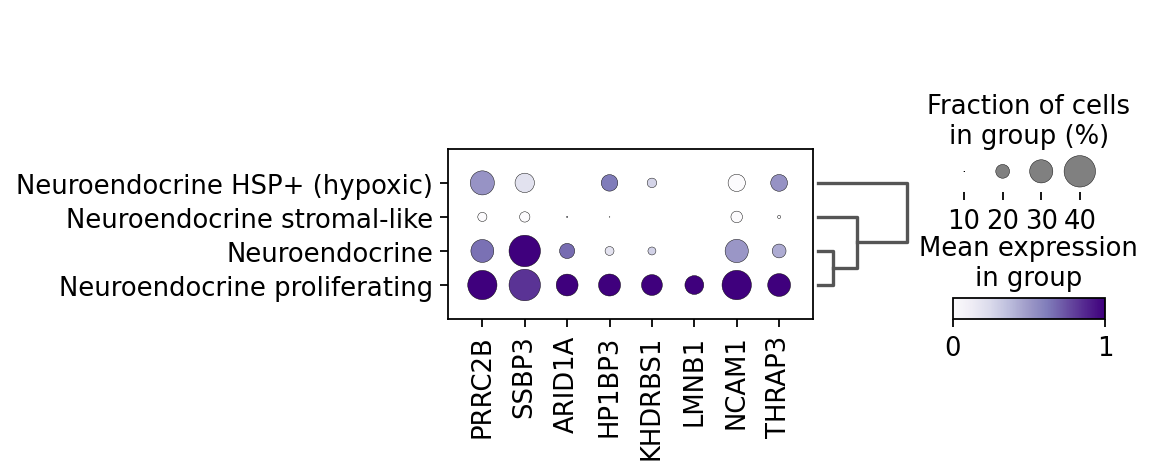

In [20]:
#Brain targets contributing to the shared sub-states
#Removed PAX6 brain target genes ('NFASC', 'PKD1', 'PRKCE', 'STXBP1') as FDR was insignificant 
NEprol_brain_targets= ['PRRC2B', 'SSBP3', 'ARID1A', 'HP1BP3', 'KHDRBS1', 'LMNB1', 'NCAM1', 'THRAP3']

sc.pl.dotplot(adata_sub02, NEprol_brain_targets, 
                         groupby= "Cell states", dendrogram=True, standard_scale="var", cmap= "Purples", dot_max=0.4,
                  dot_min= 0.1, 
             save= "_Figure2d_PTF1A_brain_targets_shared_states_28022025.pdf") 

In [21]:
#Show a simple (unsupervised) module score of DESeq2 derived brain vs pancreas module scores in 2b before the PTF1A part:

import csv 

#To check how they were derived, refer to GTEX_DESeq2_analysis script. 
with open('./DESeq2_brain_signatures/DESeq2_brain_signatures_filtered_220524.csv') as csvfile:
    rows = csv.reader(csvfile)
    res = list(zip(*rows))
    print(res)

[('\ufeffbaseMean', '35.64109043', '16.94090009', '46.34621554', '41.11689387', '7196.298094', '1388.173202', '57966.70448', '9982.523528', '5174.059033', '364.6567158', '1564.287676', '1056.779117', '227.7691565', '79.67614838', '102.9408466', '288.2825477', '806.1508674', '957.6593635', '704.6743536', '405863.7898', '1059.250461', '129.4097464', '9418.264072', '22057.3663', '1348.766231', '6.252775264', '192.4197861', '15593.04979', '89.404686', '1238.911428', '4023.931887', '556.8295679', '2715.522311', '599.7423359', '16.85340265', '16842.39942', '1672.304339', '30997.27434', '7805.470281', '78.47051001', '285.2943638', '36.12598383', '5.201469301', '1984.838262', '209.1063424', '34268.53723', '5.103804242', '2614.304548', '85.60481938', '80.83143551', '9.810833438', '8375.218115', '19.67430292', '87.09849782', '66.01200761', '18.64873669', '123.7078012', '1989.311123', '3705.215268', '22.22055074', '446.3471986', '6179.853182', '254.832743', '378.5668152', '1254.446572', '120.4963

In [22]:
brain_upregulated_DEGs= ['AC062021.1', 'CTB-1I21.1', 'AC007106.1', 'RP11-966I7.4', 'OPALIN', 'LINC00320', 'MOBP', 'MOG', 'AVP', 'CTA-929C8.8', 'PDYN', 'HTR2C', 'RP11-706J10.2', 'RP11-357K6.1', 'RP11-271F18.4', 'LINC01551', 'C2orf80', 'MIR124-2HG', 'NEUROD6', 'GFAP', 'LINC01896', 'RP11-953B20.1', 'ETNPPL', 'C1orf61', 'RP1-111D6.3', 'RP11-579E24.2', 'NTM-AS1', 'ARPP21', 'RP13-895J2.8', 'SLC32A1', 'CNTNAP4', 'LINC01158', 'POU3F3', 'POU3F4', 'LINC00290', 'MLC1', 'VSTM2B', 'MT3', 'AMER2', 'LINC01445', 'CTXN3', 'CTC-525D6.3', 'RN7SL585P', 'LHX2', 'LINC00507', 'CAMK2A', 'HMGA1P7', 'OLIG2', 'LINC00463', 'LINC00499', 'RP11-562L8.1', 'CAMKV', 'RP4-815D20.1', 'DLGAP1-AS4', 'LINC01351', 'LINC01476', 'PMCH', 'FOXG1', 'GABRA1', 'FOXG1-AS1', 'HTR5A-AS1', 'STMN4', 'CDH9', 'LINC01102', 'LINC00634', 'CTC-525D6.1', 'SYNPR', 'CTD-2023N9.3', 'GABRG1', 'CPNE6', 'MMD2', 'OLIG1', 'DPYSL5', 'LINC01007', 'RP11-684N3.1', 'CTD-2015C24.1', 'D21S2088E', 'AC099754.1', 'LINC01532', 'BCAN', 'RP11-298D21.1', 'DDN', 'LINC01951', 'MPPED1', 'RP11-85O21.2', 'LINC01080', 'NEFL', 'RESP18', 'KCNJ9', 'LINC02010', 'OXT', 'LINC00599', 'KLK6', 'RP5-912I13.1', 'GABRA6', 'RIT2', 'CACNG7', 'CTC-445B21.1', 'HTR5A', 'OPCML-IT1', 'SOX2-OT', 'AC068057.1', 'OR14I1', 'RP4-719C8.1', 'ZIC1', 'ADCY8', 'RP11-275H4.1', 'TBR1', 'RBFOX1', 'LINC01322', 'RP11-33M22.2', 'PLP1', 'LINC02123', 'FGF3', 'MAG', 'UNC13C', 'LRTM2', 'ZIC5', 'AC009487.5', 'LINC00500', 'ELAVL3', 'RP11-320H14.1', 'AC004158.3', 'NCAN', 'RP11-665C14.2', 'NKAIN4', 'RP5-1177M21.1', 'NTSR2', 'RP11-445F12.1', 'GABRA3', 'ZIC2', 'RP5-1119A7.17', 'C11orf87', 'RP11-483I24.1', 'PMP2', 'ELMOD1', 'SRRM4', 'NDP', 'MIR219A2', 'GABRQ', 'NEUROD2', 'CTC-525D6.2', 'CACNG3', 'LINC01877', 'RP11-315E17.1', 'BARHL2', 'AC008060.5', 'SOX1', 'LINC01616', 'RP11-328J6.1', 'RP11-245J24.1', 'CEND1', 'GRM3', 'RPL31P54', 'TTC9B', 'SLCO1A2', 'LHX1', 'LINC00461', 'ZIC3', 'OTX2', 'PVALB', 'RP11-158M9.1', 'GSG1L', 'LINC02217', 'SALL3', 'ZIC4', 'PENK', 'SYNDIG1L', 'ADARB2-AS1', 'LINC01114', 'IFNA12P', 'KCNA1', 'HCRT', 'FEZF2', 'RP11-236J17.6', 'RP11-499A10.3', 'POU3F2', 'LINC01299', 'LINC01202', 'RP11-454P21.1', 'NELL1', 'RP5-1180C18.1', 'CBLN2', 'RP11-731J8.2', 'SLC6A7', 'FLJ16779', 'HEPACAM', 'RP11-227D2.3', 'HS3ST4', 'NXPH1', 'RP11-737F9.1', 'RPH3A', 'RP11-4B14.3', 'RP11-13J10.1', 'FABP7', 'SPHKAP', 'UNCX', 'LUZP2', 'ERMN', 'ATP1A3', 'DLX6-AS1', 'FXYD7', 'AC068490.1', 'LGI1', 'TMEM235', 'ZCCHC12', 'GPR37L1', 'LINC01630', 'RP11-966I7.2', 'RP11-359N5.1', 'LHX5-AS1', 'RP4-630C24.3', 'RP11-259K15.2', 'RP11-643A5.2', 'LL0XNC01-16G2.1', 'CA10', 'HPCA', 'CACNG8', 'KCNJ4', 'GRID2', 'RP11-676J15.1', 'TLX3', 'CACNA1E', 'KIF5A', 'SLC24A2', 'RP4-718N17.2', 'GABRD', 'NKAIN2', 'RP11-108E14.1', 'GRIN1', 'RGS8', 'RP11-271F18.3', 'RP11-547D24.1', 'LRRC3B', 'RP11-886D15.1', 'HAPLN2', 'FAM181A', 'RP13-895J2.7', 'LIX1', 'BCAS1', 'RP11-286B14.1', 'CTD-2555A7.2', 'HRH3', 'RP11-799D4.3', 'RTP1', 'PLPPR3', 'RP11-445F12.2', 'GABRG3', 'OLFM3', 'GPR12', 'RP11-43A14.2', 'OPRK1', 'CLVS2', 'CTC-467M3.3', 'KCNJ10', 'VSNL1', 'AC008060.7', 'GPM6A', 'RP11-158J3.2', 'SYT1', 'LINC01103', 'TOMM20P3', 'BRINP1', 'LINC00645', 'GABRB2', 'AC012507.3', 'LINC00609', 'AC010729.2', 'ZDHHC22', 'SNCB', 'SHISA8', 'GRIN2B', 'AK5', 'RP11-491F9.3', 'GS1-519E5.1', 'RP11-17E3.1', 'LINC02199', 'RP11-197K6.1', 'CDH7', 'LINC01159', 'RP4-655C5.9', 'DLGAP1', 'ASIC2', 'LIN28B-AS1', 'GJB6', 'FRG2DP', 'FGF1', 'CRB2', 'AC067969.2', 'SOHLH1', 'RP11-268F1.3', 'LHX8', 'CNTN2', 'RP5-896L10.1', 'GBX2', 'CCK', 'GRIK4', 'SLC39A12', 'NRGN', 'RP13-895J2.2', 'DAO', 'LINC01164', 'RP11-958J22.1', 'LINC01561', 'HMP19', 'MC4R', 'AQP4', 'AC098826.5', 'CSPG5', 'GPR101', 'KCNH5', 'PPP1R17', 'CTD-2540B15.6', 'PABPC1L2A', 'ANKRD66', 'RP11-477N12.5', 'GAP43', 'RP11-298D21.2', 'RP11-1084I9.1', 'MDGA2', 'RPS8P6', 'LINC00403', 'BRINP3', 'CRHR1', 'PABPC1L2B', 'RP11-807H17.1', 'LINC02070', 'MBP', 'CTD-2023N9.2', 'RP11-806K15.1', 'SHANK1', 'GABRG2', 'ARPP21-AS1', 'OPCML', 'SPOCK3', 'LINC02137', 'CRYM', 'PHEX-AS1', 'UG0898H09', 'RP13-895J2.3', 'RGS20', 'LCN8', 'RP5-872K7.8', 'RIMS4', 'RP11-450H6.3', 'CTD-2130F23.1', 'SLC6A15', 'RP1-40E16.9', 'SLC17A7', 'ATCAY', 'BCYRN1', 'RP11-430H10.3', 'GABBR2', 'RP11-874J12.3', 'RP1-257I9.2', 'GABRA4', 'GALNT9', 'GABRA2', 'FSD1', 'MCHR2', 'SOX21', 'GUCA1A', 'RP11-493L12.6', 'CLEC2L', 'TMEFF2', 'RP11-546B8.6', 'RP11-561I11.4', 'SLC12A5', 'ATP6V1G2', 'RSPO2', 'SH3GL3', 'PAQR6', 'KCNA4', 'RP11-725M22.1', 'RP11-300M24.1', 'KCNK4', 'GLRA2', 'GRM5', 'RP11-436F23.1', 'SOX2', 'RP11-510C10.2', 'CDH8', 'SOX21-AS1', 'AC008069.1', 'HMX1', 'RP11-116N8.1', 'NPVF', 'PCDH8', 'RP11-85O21.5', 'KCNC2', 'RP11-2L8.2', 'AGBL1', 'DLX6', 'RP11-343J18.1', 'KCNIP4-IT1', 'HTR1A', 'LINC00836', 'ATP2B2', 'RP11-301G7.1', 'RPE65', 'PYDC1', 'RP11-165N12.2', 'RP1-46F2.3', 'SLC22A6', 'RP11-385G16.1', 'SORCS3', 'RP11-9G1.3', 'ENHO', 'PHACTR3', 'RP11-707A18.1', 'KCNN1', 'PCDH11Y', 'RP11-805F19.3', 'NEUROG2', 'ATP2B3', 'HCN2', 'RP11-268P4.5', 'S100B', 'LINC01608', 'NPTX1', 'RP11-79E3.2', 'FAM69C', 'ELAVL2', 'FAIM2', 'WIF1', 'ATP1A2', 'CHRNA4', 'KCNQ1DN', 'AC005330.2', 'CREG2', 'RN7SL475P', 'CNDP1', 'AJ239322.1', 'HCG24', 'PACRG-AS3', 'CTD-2281E23.3', 'GNG3', 'JPH3', 'PCDH11X', 'RP11-510C10.4', 'RP11-482M8.3', 'ANKRD34B', 'GSX2', 'CTD-2544H17.1', 'JPH4', 'VSTM2A-OT1', 'AF240627.2', 'LINC02192', 'TMEM151B', 'IGDCC3', 'CMTM5', 'IFNA11P', 'COL20A1', 'HAPLN1', 'RP11-433J8.2', 'RP4-796I8.1', 'CTD-2228A4.1', 'C17orf102', 'GPR88', 'AC114877.3', 'DNAH17-AS1', 'PSG8-AS1', 'PPFIA4', 'GNG13', 'SH2D5', 'PHF24', 'LINC02134', 'RP11-32K4.1', 'NR2E1', 'TMEM155', 'ZNF488', 'MEGF10', 'TRH', 'ATP13A5-AS1', 'LINC01821', 'RP11-463C8.7', 'GABRA5', 'CACNG2', 'SCN1A', 'RBFOX3', 'HECW1', 'PPP2R2C', 'ARHGAP36', 'RP6-91H8.5', 'B3GAT1', 'RN7SL471P', 'AC013472.4', 'PTPN5', 'RP11-932O9.3', 'RP4-668E10.4', 'SCN2B', 'OR2L13', 'GPC5', 'LINC00492', 'RP11-788A1.1', 'RFPL1S', 'RP11-354P17.15', 'CPLX3', 'CDH20', 'LINC00404', 'RP5-1097F14.3', 'RP11-556G22.3', 'RP11-261N11.8', 'RP11-1263C18.1', 'RP11-278H7.3', 'RTP5', 'PNCK', 'OMG', 'RP11-364B14.3', 'RP3-326L13.2', 'AC133633.2', 'RP11-297M9.1', 'SLC6A1', 'RP11-100K18.1', 'RP11-252O18.2', 'SP9', 'RP11-333B11.1', 'CCDC177', 'CTD-2195M15.1', 'CTD-2544M6.1', 'ADGRB2', 'GRIA1', 'AP003025.2', 'FBXL16', 'LINC02047', 'SNAP25', 'TMEM130', 'RP11-113E21.2', 'OR1F1', 'RP11-467D10.2', 'LINC00460', 'PCDH15', 'LINC01830', 'RP11-358D14.3', 'VSTM2A', 'CALB1', 'LRP2', 'NPFFR1', 'GPR158-AS1', 'RGR', 'DGKK', 'RP11-219F10.1', 'FNDC9', 'SHISA7', 'BRINP2', 'BX255923.3', 'RP5-860P4.2', 'RP11-653B10.1', 'ALDOC', 'RP11-138B9.1', 'NRSN1', 'RNU4-65P', 'FLJ37505', 'RP11-13K12.2', 'RP1-73A14.1', 'RP11-697E14.2', 'AC093843.1', '3-Sep', 'PNPLA5', 'SLC30A3', 'APC2', 'TUBB4A', 'SLC6A5', 'SHD', 'RP11-654C20.1', 'FER1L6-AS2', 'LINC01310', 'RFX4', 'LINC00523', 'RP11-415A20.1', 'RP11-463C8.5', 'PNMA5', 'ADGRA1-AS1', 'GRM1', 'GSX1', 'SOX11', 'LINC00706', 'LINC01792', 'RP11-31I22.2', 'RP1-240B8.3', 'CTNNA3', 'C1QL2', 'FABP6', 'LY6H', 'AC113617.1', 'RP11-490G2.2', 'DPF1', 'NNAT', 'PTPRD-AS2', 'PAX7', 'IFNA13', 'KNCN', 'FEZF1', 'LINC01338', 'OSTM1-AS1', 'LINC02200', 'FOXB1', 'CTA-992D9.7', 'LAMP5', 'TACR3', 'RP11-429A20.3', 'DNER', 'DRD5', 'TNR', 'CRTAM', 'HPSE2', 'NMS', 'RP11-831A10.1', 'RP11-144A16.8', 'RNU5E-8P', 'MGAT5B', 'EPHA5', 'VWC2', 'RP11-809C18.3', 'NKX6-2', 'TCEAL6', 'RP11-417L19.2', 'MAS1', 'AC011524.1', 'CARTPT', 'CTXN1', 'AMBN', 'LRIT2', 'DRD1', 'RP11-316N24.2', 'OTOS', 'RP11-85O21.4', 'ZNF736P9Y', 'FAM163B', 'RN7SKP73', 'IGLON5', 'ST8SIA5', 'LINC01170', 'GHRH', 'RPL7P5', 'SIAH3', 'RP1-223B1.1', 'RP11-149P24.1', 'RP13-895J2.6', 'NKX1-2', 'CLK3P2', 'CRB1', 'ANKRD30BL', 'RP13-436F16.1', 'RNF219-AS1', 'CAMK4', 'LLNLF-187D8.1', 'AC145123.2', 'RP11-565N2.2', 'RP11-711G10.1', 'GALNTL5', 'LINC01727', 'CERS1', 'ANLN', 'TEKT1', 'CHRM1', 'STOML3', 'AC083864.3', 'LINC00588', 'ANKRD63', 'AP002856.7', 'CTC-304I17.2', 'RP11-404I7.2', 'GAD1', 'ACBD7', 'CNTN6', 'RN7SL508P', 'RP11-895K13.2', 'GPR22', 'SLC6A3', 'RN7SL591P', 'DLL3', 'LINC01105', 'KIRREL3-AS2', 'FEZ1', 'AC008991.1', 'ZFHX4-AS1', 'FAM131B', 'PHYHIP', 'LINC01201', 'RP11-298E9.6', 'PIANP', 'HTR2A', 'CADM3', 'RP1-309H15.2', 'NTM', 'NEU4', 'RP11-378I6.1', 'EYA1', 'KCNK9', 'TAC1', 'AC011995.1', 'PRB2', 'ZBBX', 'RP11-389G6.3', 'OTP', 'DRD3', 'RP11-480C22.1', 'RP11-449H15.2', 'MTND6P25', 'RP11-665J16.1', 'TMEM108-AS1', 'AC018717.1', 'TMEM88B', 'LINC00237', 'KCNQ2', 'RP11-81H3.2', 'KCNG4', 'PCDH10', 'RP11-83C7.3', 'LINC00898', 'RP11-510C10.3', 'CFAP74', 'DAW1', 'TMEM35A', 'CTC-472C24.1', 'RP11-399H11.3', 'RP11-71N10.1', 'CADM2', 'ABCG4', 'MTCO1P47', 'RP1-111D6.5', 'SLC6A13', 'SCN2A', 'C1orf64', 'LINC01735', 'PRKCB', 'RP11-489D6.2', 'PCP4', 'AGAP2', 'AL121656.5', 'LINC02110', 'SOX3', 'LMAN1L', 'FAT2', 'RP11-713C5.1', 'SNORD115-20', 'CLVS1', 'TPRX1P1', 'PSD2', 'AC008060.8', 'LINC00601', 'PRSS56', 'RP11-460B17.3', 'FRMPD4', 'AC002429.5', 'LINC01776', 'CTD-2316B1.1', 'PPP2R2B', 'EMX2OS', 'RP3-416J7.4', 'RP11-509E10.1', 'CTD-2189E23.2', 'RP11-728G15.1', 'AC138647.1', 'RP11-298J23.8', 'C1QTNF4', 'PCP4L1', 'RP11-437J2.3', 'U95743.1', 'RLBP1', 'RP11-120I21.3', 'CAMK1G', 'AC010729.1', 'CTB-99A3.1', 'RP11-809H16.5', 'LINC01411', 'CALB2', 'RP11-556G22.2', 'AC091878.1', 'LINC00391', 'AC005220.3', 'SULT4A1', 'AJ003147.8', 'RP11-345F18.1', 'RP11-116N8.2', 'RNA5SP481', 'RP11-124B13.1', 'RP11-430E17.1', 'C10orf105', 'TFAP2B', 'DRP2', 'RP11-61G23.2', 'CH17-53B9.2', 'RP11-736N17.11', 'TF', 'SP8', 'SYNGR3', 'RP11-493K23.4', 'KCNT1', 'RP1-251M9.3', 'ZNF365', 'GABRB1', 'NELL2', 'NPY2R', 'GDPD2', 'SAG', 'TAGLN3', 'MAP1A', 'PLK5', 'ADGRA1', 'NRG3', 'TESPA1', 'XXbac-BCX196D17.5', 'RP11-561I11.3', 'SLC6A11', 'NDST3', 'VENTXP5', 'MIR137HG', 'RP1-232L24.3', 'CA7', 'MCHR1', 'PKIA', 'RP11-238K6.2', 'LRRC4B', 'RN7SL292P', 'KIF5C', 'RP11-707M1.1', 'CNTNAP2', 'RP11-236B18.5', 'NRIP3', 'RP11-373E16.4', 'TCEAL5', 'CSMD1', 'PRR18', 'DGKI', 'BEND6', 'SCRT1', 'CTB-78F1.1', 'STAC2', 'DRD2', 'TMEM183AP1', 'SEZ6', 'C10orf90', 'RP11-744N12.3', 'NKAIN3', 'RP11-306K13.1', 'ZP2', 'LINC00606', 'KRT31', 'SLC1A3', 'GPR158', 'PAQR9-AS1', 'RP6-191P20.4', 'RP11-736E3.3', 'MIR325HG', 'LINC01378', 'RP13-895J2.10', 'AC067956.1', 'RP11-448P19.1', 'FAM57B', 'CPNE9', 'RP3-429G5.5', 'WI2-2118C23.2', 'RP11-644A7.2', 'CHN1', 'RP11-474D1.4', 'KHDRBS2', 'FAM19A1', 'EMX2', 'LINC00620', 'NEFH', 'ADAM11', 'LHX5', 'RP4-555D20.3', 'LINC01377', 'NPAS4', 'LA16c-329F2.1', 'LINC00906', 'MIAT', 'RAB3A', 'FAM74A7', 'MAPT-AS1', 'FUNDC2P3', 'GPM6B', 'KCNC1', 'SLITRK3', 'ATP1B2', 'MRPL50P1', 'RP11-503C24.2', 'SYN2', 'RP11-407P18.1', 'ERICH3', 'STMN2', 'RP11-491F9.5', 'RPL21P108', 'RP11-33H15.1', 'LINC01739', 'AC009487.4', 'PLPP4', 'LINC01549', 'DCTN1-AS1', 'ASIC4', 'AC110754.3', 'FOLH1', 'LINC01930', 'CTD-3193O13.8', 'AC013402.3', 'EPHB1', 'RP11-405M12.2', 'RP11-861E23.2', 'LINC00279', 'MIR3976HG', 'GPR26', 'BAALC', 'RN7SKP140', 'RP11-491F9.6', 'RP11-139H14.5', 'CCDC175', 'TECTB', 'LINC01995', 'RP1-269M15.3', 'TTBK1', 'MRPL9P1', 'ADCY2', 'RP11-109G23.1', 'RBP3', 'RP11-165I9.10', 'EN2', 'RP11-442O1.3', 'EGR4', 'NAP1L3', 'KCTD4', 'PRB1', 'NOVA1-AS1', 'RP11-315A16.1', 'SNCA', 'RP11-728E14.3', 'ACSBG1', 'SAMD14', 'CTC-304I17.3', 'CTD-2501M5.1', 'NECAB1', 'HHATL', 'LINC01831', 'CTD-2234N14.2', 'ICAM5', 'GPR6', 'CENPVL3', 'RP11-698N11.2', 'RP4-555D20.4', 'RP13-895J2.11', 'AC018685.2', 'RP11-509E10.3', 'GRIN2C', 'LINC01053', 'NDRG4', 'AC010731.4', 'LINC01795', 'KRT17P1', 'RP11-454P7.3', 'AC084149.2', 'AC064853.2', 'CENPVL2', 'PTCHD1', 'NCAM2', 'LINC01639', 'AC018647.3', 'ANK2', 'SYN1', 'LRRTM1', 'PURG', 'DGKB', 'C6orf118', 'AC019330.1', 'RP11-838N2.5', 'HES5', 'TMEM229A', 'EPHA5-AS1', 'ADGRL3', 'AC144838.3', 'RP11-560A15.6', 'RP11-29P20.1', 'RP11-626P14.2', 'FIBCD1', 'RGS7', 'LINC00354', 'RP11-57A19.7', 'C7orf72', 'SV2C', 'RP11-373E16.3', 'GPN3P1', 'RP11-527D7.1', 'Y_RNA', 'AC012593.1', 'RP11-1L9.1', 'RP11-563K23.1', 'SPOCK2', 'TRIM9', 'TVP23BP1', 'ANKS1B', 'RP11-416I2.1', 'C3orf67-AS1', 'RP11-432J3.4', 'STX1B', 'LINC00326', 'RP11-17A4.2', 'RP11-826N14.1', 'EPHX4', 'AC078842.3', 'RAB33A', 'CTC-235G5.3', 'LINC01721', 'SCRG1', 'RN7SL456P', 'RP4-791K14.2', 'RP11-678L1.1', 'AC004448.5', 'RP11-625L16.1', 'CTC-467M3.1', 'ADGB', 'RPRM', 'GPR85', 'RP11-612A1.1', 'FAM181A-AS1', 'CH17-13I23.2', 'ASTN1', 'RP11-238F2.1', 'RP11-594N15.3', 'NHLH2', 'RP5-947P14.1', 'KCNK12', 'C4orf50', 'XXbac-BPG308J9.3', 'LINC00632', 'PRKCG', 'AP002530.2', 'SNAP91', 'RP11-231I13.2', 'FRRS1L', 'FAM133A', 'AP000708.1', 'PDZD4', 'ENOX1-AS2', 'GPR149', 'RP11-49P4.7', 'RP11-168K9.2', 'SLC7A10', 'LINC01289', 'AC013402.5', 'LCN15', 'RP11-1084I9.2', 'AC079154.1', 'LRRC38', 'CA14', 'GRM4', 'CTD-2006K23.2', 'DLGAP2', 'RP11-62L18.3', 'RP11-310P5.2', 'P2RX6P', 'RP11-958J22.2', 'CHD5', 'FAT3', 'LINC01834', 'CTB-147C22.9', 'AC090696.2', 'LINC01621', 'ANKRD20A10P', 'RPL17P35', 'RP11-404G16.2', 'RP11-629P16.1', 'RP5-1039K5.18', 'AC018685.1', 'RP5-968J1.1', 'RP11-390M11.1', 'PPFIA2', 'ABBA01000934.1', 'OR2B4P', 'OR7A5', 'AC114765.1', 'RP4-705F19.1', 'ZNF804A', 'TMEM59L', 'LINC01693', 'RP11-92A5.2', 'RP11-240G22.1', 'RNU6-1028P', 'RP11-543D10.2', 'RP11-707M1.9', 'RTN1', 'PLPPR1', 'RP11-883G14.3', 'CTA-392E5.1', 'LINC01511', 'NEFM', 'ZMAT4', 'MCF2L2', 'CCNA1', 'RP11-260A9.6', 'DOK6', 'AC108025.2', 'RP11-24H2.3', 'GLDC', 'TCEAL7', 'CARSP1', 'HTR6', 'FGF5', 'RP11-797E24.1', 'AIFM3', 'LINC02139', 'TRIML2', 'RP11-210M15.1', 'LINC01849', 'FSTL5', 'CTD-2244C20.1', 'MAGI2-AS2', 'CTD-2189E23.1', 'AP005901.1', 'RAPGEF4-AS1', 'CASC6', 'KIRREL3', 'AC005518.2', 'LINC01773', 'NIPAL4', 'LINC01250', 'DRGX', 'RN7SKP276', 'DLX5', 'CTB-49A3.4', 'GDAP1L1', 'PACSIN1', 'RP11-467K18.2', 'RP11-69M1.1', 'DRD5P1', 'RP11-339B21.8', 'RELN', 'RP11-496D24.2', 'LBX1', 'LGI3', 'RP11-577N1.1', 'RP11-561B11.6', 'RP11-406A20.1', 'RP11-336F14.1', 'RP11-576D8.4', 'XXyac-YR29IB3.1', 'RP5-907C10.3', 'GLYATL1P2', 'ADGRB3', 'CT45A10', 'HSD17B6', 'SLC25A18', 'RP11-474D1.3', 'TMEM132E', 'AC103563.8', 'DIRAS2', 'LINC01248', 'NLGN3', 'RP11-433J8.1', 'B4GALNT1', 'RP3-525N10.2', 'RP1-249F5.3', 'DCAF12L2', 'RP4-813D12.3', 'AC018866.1', 'ANKRD20A19P', 'TMEM132B', 'RP11-629G13.1', 'MUPP', 'ENPP6', 'SV2A', 'CACNG4', 'RP11-494G9.1', 'ENKUR', 'RP11-1070A24.2', '4-Sep', 'RP11-594C13.1', 'AC139099.7', 'ARHGEF26-AS1', 'RP11-29A19.2', 'RP11-805F19.1', 'DLX1', 'RPRML', 'MTURN', 'RP11-79E3.3', 'CACNA2D3', 'RP11-447M12.2', 'CTD-2034I21.1', 'SLC26A4-AS1', 'CHIAP1', 'RP11-688I9.4', 'RP11-278H7.5', 'GRIN2A', 'LINC01546', 'RP11-449J10.1', 'OPCML-IT2', 'FRMD5', 'LINC01748', 'C1orf87', 'C5orf64', 'GRM7', 'MAPT', 'HMGB1P16', 'CABP1', 'Y_RNA', 'RP3-377H17.3', 'TMEM257', 'RND2', 'ATP8A2', 'GPR62', 'RP11-429E11.2', 'RP4-597A16.2', 'EFR3B', 'AP000282.2', 'CACNA1G', 'RP11-589C21.2', 'LIN28B', 'TRIM72', 'MT-TV', 'LINC01908', 'RP11-650J17.2', 'LINC01505', 'RP11-69C17.3', 'LINC00251', 'SH3GL2', 'RNU6-554P', 'RP11-82L7.4', 'RP11-699A5.2', 'FREM3', 'BRSK1', 'OR2L2', 'SNX32', 'GRIA2', 'LINC01494', 'RP5-1016A21.1', 'RP11-120A1.1', 'RP11-521D12.2', 'RP11-295D22.1', 'KCND2', 'INA', 'RP11-26N15.2', 'AC114730.3', 'AP000889.1', 'LY86-AS1', 'RP11-478B9.2', 'TMEM261P1', 'LINC01141', 'RP11-17M24.2', 'CTC-340A15.2', 'JAKMIP1', 'AC011995.3', 'RP11-454H19.2', 'C11orf88', 'LINC01221', 'CDR1', 'KCNQ5', 'CBLN1', 'MT-TD', 'CTD-2194D22.1', 'PRR32', 'LRRC74B', 'LINC01346', 'RP11-730N24.1', 'RUNDC3A', 'CLEC4GP1', 'LINC00421', 'RP11-586K2.1', 'INSM2', 'LINC01923', 'MAPT-IT1', 'MEGF11', 'RP4-753D10.3', 'FAM74A3', 'CLDN11', 'CTD-3012A18.1', 'DRC1', 'LINC01579', 'PPP1R2P5', 'AC097713.3', 'DSCAM', 'ANKRD18B', 'CTD-2126E3.4', 'SLC15A5', 'RP11-234O6.2', 'DNM3', 'RP11-122L9.1', 'RN7SL217P', 'RP11-6E9.5', 'RP11-113E21.3', 'CASKIN1', 'RP11-651K21.1', 'RP11-408E5.5', 'RP11-491F9.8', 'RASGEF1C', 'RN7SKP55', 'AC060834.3', 'AC005197.2', 'SYNDIG1', 'SIRPB3P', 'KNDC1', 'LINC01731', 'CTXN2', 'POLR2F', 'ADAMTS18', 'RP11-420H19.1', 'MAPK4', 'LINC00533', 'RP4-683L5.1', 'AC068489.1', 'FAM92B', 'SCHIP1', 'RP11-733D4.1', 'RP6-91H8.1', 'IFNA6', 'RP1-153P14.3', 'IL1RAPL1', 'CTD-2009A10.1', 'SKOR2', 'LINC01879', 'RP11-716H6.2', 'RIMS3', 'KCNS1', 'RN7SL278P', 'ADAMTS7P1', 'RANBP3L', 'RPS15AP3', 'AC010468.2', 'RP3-384D21.2', 'SYT11', 'LINC01231', 'FAM178B', 'TFAP2D', 'LBX1-AS1', 'KB-1980E6.3', 'DPY19L2P1', 'RP11-98P2.1', 'WNT8A', 'CACNA1I', 'RP11-497K21.1', 'RP11-286O1.1', 'ATP5LP5', 'RP11-58C22.2', 'RP11-378A12.1', 'RP11-589B3.7', 'CPNE5', 'LINC01516', 'TMEM114', 'PTPRR', 'TAC3', 'MED15P3', 'PLEKHB1', 'CA11', 'BASP1', 'ISM2', 'REEP2', 'AP000889.2', 'FAM216B', 'Y_RNA', 'RP4-673D20.6', 'KLK7', 'RP11-449L23.2', 'RP11-449D8.5', 'C1orf94', 'C15orf59-AS1', 'CTD-2058B24.3', 'RP11-364C11.3', 'RP5-921G16.1', 'RP11-364P22.1', 'CRABP1', 'RP11-431M7.3', 'CTD-2232E5.2', 'RP11-145O15.2', 'GPR83', 'LINC00871', 'RN7SL538P', 'RP11-552M14.1', 'RP11-536I6.2', 'ST8SIA2', 'RP11-347N5.3', 'TUBB2B', 'LCNL1', 'ADGRB1', 'IL17D', 'NDUFB5P1', 'FADS6', 'PART1', 'CAMK2B', 'RP11-443N24.2', 'RP11-293D9.2', 'RP11-640N20.6', 'RP11-213G21.2', 'RP13-126C7.1', 'TH', 'LINC00856', 'FBXL21', 'WNT10B', 'PLPPR5', 'LRRC4', 'YY1P2', 'CRYGA', 'R3HDM2P1', 'MEPE', 'CTD-2320G14.2', 'GRIK1', 'CALY', 'AC139099.4', 'TEX15', 'AP000859.4', 'ANO3', 'LINC02074', 'RP11-402N8.1', 'AC133680.1', 'PTN', 'MDGA1', 'LINC02156', 'NSG1', 'PRRG3', 'RP11-1147P1.1', 'SFTA1P', 'RP11-799O21.2', 'RP11-226B15.1', 'MIR4666A', 'NCS1', 'SLCO1C1', 'C11orf98P1', 'VAT1L', 'HMGB1P13', 'ACTL6B', 'RP11-499P1.2', 'RP11-688I9.2', 'BBOX1', 'AC144833.1', 'ZNF536', 'ACP7', 'PNMA3', 'AL590763.16', 'LINC00488', 'TMEFF1', 'PTCHD1-AS', 'RP11-595O22.1', 'CTC-329D1.3', 'RP11-403A3.2', 'CLYBL-AS1', 'RP1-273N12.4', 'WBP2P1', 'JAZF1-AS1', 'RP11-334E15.1', 'RNA5SP508', 'RP11-149F8.4', 'GNAO1', 'NRXN1', 'RP11-444P10.1', 'LINC02032', 'HBQ1', 'RP11-430H10.4', 'CDH18', 'LRRC63', 'SYT12', 'RP11-437J2.4', 'Metazoa_SRP', 'OR2H2', 'LINC02172', 'CH17-351M24.1', 'IFNWP2', 'RP11-22N12.2', 'PNOC', 'FAM107A', 'LINC02043', 'CIT', 'RP11-473C19.1', 'VWA3A', 'SLC5A11', 'PICSAR', 'RNA5SP438', 'RP11-231N3.1', 'HS3ST5', 'SRGNP1', 'RP11-83J21.3', 'ARC', 'RP11-367O10.1', 'RGS6', 'YPEL4', 'HIPK4', 'PIH1D3', 'SLC13A5', 'UPP2', 'ADAM23', 'RP11-196E1.3', 'RP11-428L21.1', 'CTB-151G24.2', 'MAST1', 'RP11-770J1.4', 'AP001464.4', 'RP1-186E20.1', 'TTC29', 'TYRL', 'RP11-299J5.1', 'OR8J2', 'FEZF1-AS1', 'PTPRZ1', 'FGF13', 'DBX2', 'RP11-588P7.2', 'RIMS2', 'RP11-116D17.2', 'RP11-473J6.1', 'SLC7A14', 'IGSF21', 'KIAA2012', 'MTND1P16', 'AC091814.2', 'RP11-358N4.3', 'STXBP5L', 'RP11-274J15.2', 'ANKRD55', 'RP11-495K9.10', 'RN7SL111P', 'GALNT13', 'RP11-328K15.1', 'U3', 'GS1-18A18.2', 'HCG23', 'CACNA1B', 'CRYGEP', 'U3', 'CKMT1B', 'CLIP3', 'MIR9-3HG', 'CTB-187M2.2', 'WNT7A', 'DLGAP1-AS3', 'RP11-397C12.1', 'BEND4', 'RP11-867G2.8', 'CDH2', 'CNN2P8', 'NF1P3', 'RFPL2', 'RP11-50O21.1', 'RP11-10G15.4', 'RIMS1', 'CTC-498M16.4', 'LRRC53', 'CPLX1', 'RP11-283I3.4', 'TUBB3', 'MAL', 'Y_RNA', 'RP11-180P8.1', 'PADI2', 'RP11-51P8.1', 'PPIAP21', 'ATP2B2-IT1', 'RORB-AS1', 'RP11-441M10.1', 'RP1-146A15.1', 'OR6B3', 'RP11-25O3.1', 'RP11-131K17.1', 'AC005357.1', 'RP5-827E24.1', 'NTS', 'NKAIN1', 'CTC-369A16.2', 'LYPD8', 'MTND5P16', 'AKAP14', 'RP11-315F22.1', 'KLHL4', 'RP11-897M7.3', 'FAM171B', 'MT-TP', 'GUSBP12', 'PHBP4', 'PABPC1L2B-AS1', 'RP4-537K23.4', 'SYT2', 'TBC1D26', 'MYCNOS', 'FOLH1B', 'AC016716.2', 'RP11-999E24.3', 'CTD-2195M15.3', 'PEG13', 'RP11-839D17.3', 'LAMP5-AS1', 'RP11-83C7.1', 'IQSEC3', 'CTC-575N7.1', 'NXPH2', 'LINC02016', 'KCNIP2', 'ZFR2', 'CDRT15P2', 'RP11-1102P16.1', 'RN7SL741P', 'ABHD12B', 'CPLX2', 'AC011524.3', 'CTD-2534I21.8', 'RP11-579O24.1', 'VN1R90P', 'LINC01771', 'ASCL1', 'TUBA4B', 'RP11-756J15.2', 'RP11-403A3.1', 'OR2M4', 'DLX2', 'SLC17A8', 'SVOP', 'B4GALNT4', 'AC103563.7', 'LINC02072', 'BMP7', 'OR2H5P', 'C11orf97', 'KCNMB4', 'HTR4', 'LINC02063', 'CTD-2168K21.1', 'UCHL1', 'TMCC2', 'RP5-991B18.1', 'SPPL2C', 'LINC01994', 'CDRT15L2', 'RNU1-65P', 'RP11-401N18.1', 'RP11-500G9.1', 'ABCG2', 'RP11-45K10.2', 'CES5A', 'RP11-87G24.3', 'RP1-130L23.1', 'RP11-360K13.1', 'INHBA-AS1', 'FAM74A4', 'ENO2', 'RP4-673D20.4', 'GNG8', 'AC015933.2', 'CITF22-24E5.1', 'RP11-293B20.2', 'ASIC1', 'LINC00381', 'RP11-473E2.4', 'RBPJP2', 'GLB1L3', 'RP11-578B16.1', 'RP11-266K22.2', 'TRIL', 'RN7SL583P', 'LINC00707', 'LINC00844', 'AC007091.1', 'CCDC33', 'PSD', 'RP11-431D12.1', 'NETO1', 'RP1-293L6.1', 'RP3-467D16.3', 'RP11-521D12.1', 'LINC01416', 'RP11-897M7.4', 'RP11-61K20.1', 'KCNJ12', 'CT45A5', 'RP11-518K17.4', 'DCC', 'RP1-81P11.1', 'MYT1L', 'RP11-16L9.2', 'RP11-862L9.2', 'NCAM1', 'MT-TW', 'ANKRD19P', 'RP11-436D23.1', 'ABCD2', 'CTD-2336O2.2', 'RP11-209D14.2', 'CARNS1', 'VAC14-AS1', 'RP11-338N10.1', 'KLHL1', 'AP001136.2', 'DHFRP2', 'RORB', 'RP11-109E12.5', 'RP11-438D14.3', 'RP11-347H15.1', 'LRP1B', 'SNCG', 'RP11-12K11.2', 'CTD-2319I12.9', 'LINGO3', 'CTA-268H5.14', 'NECAB2', 'PDLIM1P2', 'RN7SKP220', 'SLC39A12-AS1', 'LINC00207', 'RP3-495O10.1', 'KRT17P6', 'CNGB1', 'RP11-142A5.1', 'AKAP6', 'AP000797.4', 'RP11-341G23.2', 'CTB-180C19.1', 'KCNIP4', 'CT45A1', 'AC018641.7', 'PDE1B', 'OR8K2P', 'LINC01563', 'GLT1D1', 'WSCD2', 'LRRC4C', 'RP11-567C20.2', 'CTC-548H10.2', 'HTR3B', 'PP12613', 'LINC02138', 'SALL4P2', 'RP11-39E3.3', 'UNC5D', 'AC018712.2', 'RNF175', 'CTC-420A11.2', 'DNAJC6', 'DCHS2', 'TRIM43CP', 'RP11-317N12.1', 'RP11-445P19.3', 'RP11-284F21.11', 'SLC5A12', 'RP11-335E8.1', 'PABPC1P11', 'TRPM1', 'MT-TM', 'KRT8P1', 'TMEM244', 'CRYGD', 'RP11-86A5.1', 'MIMT1', 'CAPSL', 'CDK5R1', 'CBLN3', 'RP11-793H4.1', 'KCTD8', 'CDH10', 'LINC02058', 'RP11-583F24.8', 'ART2P', 'LINC01833', 'LINC01544', 'ST8SIA1', 'SEC14L5', 'EDIL3', 'RP11-340I6.5', 'TRIM71', 'RP11-1338A24.1', 'GS1-72M22.1', 'TMEM151A', 'PNMAL2', 'SIX6', 'METTL21C', 'ADCYAP1R1', 'RP11-106M7.1', 'CTD-2355J17.2', 'VN2R3P', 'HAPLN4', 'ATXN8OS', 'RP11-364L4.3', 'OR12D2', 'CDHR1', 'CTD-3253I12.1', 'RP11-874J12.4', 'RP11-1055B8.3', 'LINC01998', 'RP11-273P3.1', 'LINC01632', 'CCDC136', 'GLRA4', 'RP11-603B24.6', 'ZIM2-AS1', 'RP11-742D12.2', 'AC092667.2', 'CALCR', 'THSD4-AS1', 'RP11-174J11.1', 'RP11-946P6.4', 'RPL23AP80', 'AC195454.1', 'ZNF385B', 'LINC00298', 'CELF5', 'MTCO3P35', 'RP11-132E11.2', 'PAQR8', 'KCNE5', 'APLN', 'CTD-2367A17.1', 'RP11-74C3.1', 'LINC00323', 'STH', 'GAS2L1P2', 'U62631.5', 'AC003986.5', 'RP11-285F16.1', 'CHST6', 'RP11-296L22.8', 'MAP7D2', 'RP11-436P7.1', 'HOXB8', 'RP11-440L16.1', 'PIRT', 'SPINK6', 'GPR19', 'KIF3C', 'RP11-1263C18.2', 'TCEAL2', 'RP11-710C12.1', 'RP11-446H18.6', 'RNA5SP500', 'RP11-396O20.2', 'DOCK3', 'RP11-66N11.7', 'RP11-567G24.3', 'OR1F2P', 'LINC01903', 'LINC01122', 'RP11-805F19.5', 'RP11-151E14.1', 'MAB21L1', 'OTOF', 'FAM171A2', 'CTNNA2', 'KCNIP1', 'LINC01749', 'AF003625.3', 'RP11-521O16.2', 'SLC1A6', 'DYNC1I1', 'RP11-281A20.1', 'FNDC5', 'RPS29P6', 'AC007253.1', 'AC128709.2', 'RP4-570O12.3', 'SATL1', 'GACAT2', 'KCNF1', 'NACAD', 'BARHL1', 'RP11-262I2.2', 'RP11-60A8.1', 'CRHBP', 'RP11-807H7.2', 'RP6-127F18.2', 'RP11-1217F2.22', 'MAPK8IP2', 'RNF165', 'CTC-304I17.5', 'KRT18P46', 'GCNT1P2', 'AC007405.8', 'AC004221.2', 'NCDN', 'RPA2P1', 'RP11-566K19.6', 'RP4-555D20.2', 'RP11-491F9.2', 'RP11-377G16.2', 'RP11-429B14.4', 'LINC00368', 'RP11-3B12.2', 'RP4-745K6.1', 'RP11-403A3.3', 'LINC01738', 'CTD-2281E23.1', 'RP11-314D7.1', 'NTRK3', 'AC005324.6', 'UBE2QL1', 'MFSD2A', 'TRIM67', 'TFAMP1', 'LINC01984', 'RP11-332J15.2', 'ARL2BPP6', 'RP11-561N12.6', 'HAR1A', 'TENM1', 'AP000696.2', 'CAMK2N1', 'C9orf129', 'APOE', 'EPHA7', 'PRMT8', 'MINDY4B', 'LINC00282', 'CTB-43I4.1', 'RGS7BP', 'RP11-1299A16.3', 'RP11-13A1.1', 'DLEU7', 'RP11-420O16.1', 'SNTG1', 'CUX2', 'TMEM200C', 'PTPRD-AS1', 'CHL1-AS2', 'ANK1', 'CCDC74BP1', 'PNMA2', 'AC008067.2', 'SEPHS1P6', 'CNTFR', 'RP11-460B17.2', 'UNC5A', 'RN7SKP209', 'VWC2L', 'Y_RNA', 'ST6GAL2', 'TRAPPC13P1', 'SNORA64', 'CDH12', 'CDK5R2', 'RP11-573D15.3', 'FAM9A', 'RP5-984P4.1', 'RN7SL325P', 'FXYD4', 'AC128709.3', 'RP11-338K13.1', 'HCRTR2', 'GPR151', 'RP11-753B7.2', 'NKX2-4', 'CTA-280A3.2', 'DACT3', 'ZNF603P', 'RP5-1100H13.3', 'AMZ1', 'STON2', 'RP11-13K12.6', 'GPR137C', 'SERTM1', 'USP17L1', 'RP11-116N8.4', 'FAM196B', 'CSAG3', 'RP11-570L15.2', 'DKFZP434H168', 'FABP3', 'MC3R', 'AFF3', 'AC108868.6', 'RP11-294N21.3', 'KCNB1', 'FMO8P', 'MTCYBP43', 'NEK4P2', 'BMPR1B-AS1', 'AC034228.3', 'CTB-160O22.1', 'HNRNPA1P46', 'NMNAT2', 'RP11-101E5.1', 'LINC01203', 'SYT3', 'PPP1R16B', 'SNORA70', 'AC073869.2', 'AC009227.2', 'C22orf31', 'NIM1K', 'HNRNPA1P72', 'RP11-2A4.4', 'NUDT10', 'PALM', 'PAX3', 'SNORD115-45', 'LINC01785', 'AIRE', 'RP11-711K1.7', 'FAM74A6', 'RP11-650J17.1', 'CTD-2651B20.8', 'RALYL', 'AC016292.1', 'ST6GAL2-IT1', 'ASPDH', 'LGALS16', 'CNIH2', 'TP53INP2', 'NPPC', 'CTB-147C22.6', 'RP11-293E1.2', 'RP4-564O4.1', 'RP11-579O24.3', 'ANKRD34A', 'FMN2', 'RP11-787D18.1', 'LHFPL1', 'RP11-317N8.3', 'P2RY12', 'ELOVL4', 'FERD3L', 'ZFP57', 'CCDC190', 'RP11-306O1.2', 'TRPM3', 'CYP24A1', 'AP005530.2', 'SLC22A8', 'PRRT1', 'SLIT1', 'ANOS1', 'TRIM77BP', 'RP11-150D5.2', 'RAC1P7', 'RP11-70F11.8', 'RP11-86H7.6', 'LINC01501', 'NRXN2', 'HORMAD2', 'RP11-202K23.1', 'SLC6A17', 'JAKMIP2', 'C15orf59', 'RP11-506F3.1', 'RP11-542H15.1', 'RASD2', 'RP11-573C10.1', 'TENM2', 'SYP', 'RP1-310O13.13', 'RP11-787D18.2', 'STRC', 'LINC02117', 'RP11-542F9.1', 'RIPPLY2', 'CTC-264O10.2', 'NATP', 'C1orf141', 'RP11-981G7.1', 'RP11-191L9.4', 'RP11-390N6.1', 'CNTN1', 'RP11-309H21.3', 'AP000998.2', 'AC092675.3', 'BCL11B', 'RN7SL35P', 'DRAXIN', 'DDX25', 'RP11-145P16.2', 'TIAM1', 'CELF2-AS2', 'RP11-822E23.7', 'C3orf70', 'RP11-315L6.1', 'CTB-32O4.4', 'RNU6-353P', 'HORMAD2-AS1', 'AC011288.2', 'RP11-472F14.4', 'RP4-650F12.2', 'SYT4', 'RP11-118H15.1', 'KCNN3', 'TRGJP2', 'RP11-90J7.2', 'RP11-202D18.2', 'GRIA4', 'RP11-436K8.1', 'RP11-494I9.1', 'PPEF1-AS1', 'NDP-AS1', 'DYDC2', 'TPPP', 'RP11-346C4.3', 'KCNH1-IT1', 'BHLHA9', 'SHC4', 'RP3-514A23.2', 'NRN1', 'L1CAM', 'RP11-168O16.1', 'Y_RNA', 'PRRT2', 'RP11-168O22.1', 'XXbac-BPG154L12.5', 'UQCRHP2', 'RYR1', 'CHRM4', 'RP11-497G19.7', 'RP11-361A23.2', 'RP11-363J20.2', 'FAM184B', 'KIAA1549L', 'HRK', 'DNM1P31', 'LINC01066', 'ELFN2', 'RASSF2', 'EVI2A', 'DISP2', 'RP11-468I15.1', 'SLC7A3', 'AC022182.3', 'FAM155A', 'Metazoa_SRP', 'KIF25', 'CSAG1', 'CCDC184', 'GPR52', 'BCRP9', 'AC079354.5', 'AHCYP3', 'RP11-293E1.1', 'GPR162', 'TSPAN5', 'RP11-31I22.4', 'RP11-507J18.1', 'CD22', 'RP11-281A20.2', 'RN7SKP99', 'RPL23AP15', 'RN7SKP195', 'SGIP1', 'LGR5', 'KIAA1024L', 'RP11-15H20.2', 'RP11-302F12.3', 'CTD-3096M3.2', 'CALN1', 'SEZ6L', 'RP11-259K5.1', 'CTC-535M15.2', 'RP11-126K15.1', 'RP11-465I4.2', 'RP1-35C21.2', 'RAPGEF4', 'RP13-259N13.2', 'GRIK2', 'RP11-893F2.14', 'RP11-863P13.6', 'GTF2F2P2', 'RP11-863P13.5', 'RNF112', 'RP11-217E22.5', 'KCNH3', 'ACTG1P18', 'RP11-657O9.1', 'RP11-320P7.2', 'ACSL6', 'MAP3K19', 'OR2L3', 'AP001172.2', 'DUSP9', 'TMEM255A', 'RP11-543N12.1', 'RP11-561N12.5', 'GPC5-IT1', 'LINC02073', 'LINC02151', 'RP11-321L2.1', 'LCN9', 'SLC24A4', 'OR7E26P', 'LINC00486', 'AC144835.1', 'LINC01992', 'ANKRD26P3', 'RP11-831A10.2', 'DCX', 'TMIE', 'CLEC3A', 'TERT', 'RP11-364C11.2', 'CFAP100', 'SLC4A10', 'DNM1P30', 'RAB6C-AS1', 'NPAS3', 'MAGEE2', 'DAB1', 'CTA-250D10.19', 'CPB2-AS1', 'DUX4L50', 'AC133633.1', 'IQCJ-SCHIP1-AS1', 'TMC1', 'HSPB3', 'MATK', 'FAM19A5', 'MAP1B', 'RP11-541G9.2', 'LINC00642', 'CACNB4', 'SLC35F1', 'RGS4', 'DCLK1', 'CLEC4G', 'MYT1', 'MT-TK', 'LINC01763', 'ADAMTS20', 'FAM19A4', 'RP11-100G15.7', 'LINC01664', 'LINC01234', 'CTA-392C11.1', 'RP11-605F22.1', 'LINC02144', 'RNU6-760P', 'RP11-13K12.5', 'CELF4', 'LINC02094', 'MTCO1P35', 'RP11-262K1.1', 'GAS7', 'RP11-587H10.2', 'RP11-154H17.1', 'VIM2P', 'NOX3', 'RP11-116O11.1', 'COL9A1', 'PRKAR1B', 'CTD-2562J17.4', '12-Sep', 'RP11-394J1.2', 'FAM74A1', 'AC103563.9', 'RP11-945C19.4', 'CORO2B', 'LINC00052', 'SHISA6', 'CTD-2380F24.1', 'RP1-137H15.2', 'KCNH4', 'CTD-2560K21.6', 'FAM19A3', 'OLFM1', 'RP11-375B1.2', 'LINC00165', 'VN1R91P', 'RFKP1', 'RP11-373N24.2', 'DKK3', 'HOPX', 'LINC01363', 'TRPC3', 'NYAP1', 'C1orf143', 'PPP1R12BP1', 'HHIPL1', 'PTGDS', 'PSMC1P13', 'LDLRAD4-AS1', 'TSPAN7', 'CSAG2', 'RP11-598O12.1', 'RP11-181B18.1', 'CNTD2', 'RP11-294J22.5', 'FTH1P27', 'DNAJC5G', 'CHST1', 'RP11-472K17.3', 'CHL1', 'GRAMD1B', 'PCA3', 'PDE6H', 'ETV3L', 'MYT1L-AS1', 'SNAP25-AS1', 'KB-173C10.1', 'RP11-13P5.2', 'RP11-340F14.6', 'RP11-521P1.1', 'RP11-323P17.2', 'CH17-437K3.1', 'TTTY13', 'NTNG1', 'RP11-122D10.1', 'RP11-70K10.2', 'MT-TT', 'RP11-577N1.2', 'RP5-1181K21.4', 'MIR4500HG', 'MIR3117', 'LINC01945', 'DLGAP1-AS5', 'SPTBN4', 'RP11-148B6.2', 'FRMPD4-AS1', 'RP11-324I22.2', 'RN7SKP12', 'MIR3151', 'KCNAB2', 'ZNF534', 'AC009262.2', 'SOX8', 'NLGN4X', 'VN1R38P', 'SLC1A2', 'TMEM178A', 'RPL17P19', 'FAM181B', 'AC016710.1', 'MYH15', 'MAGEC3', 'CTD-2049O4.1', 'RP1-288L1.5', 'UCHL1-AS1', 'RP1-155D22.1', 'MT-TI', 'MED28P8', 'RP11-662G23.1', 'RP11-547M24.1', 'SLC25A24P1', 'GALNTL6', 'RP11-10N16.2', 'DLGAP3', 'MTCO1P5', 'WDR38', 'RP5-1097P24.1', 'FOXD4L6', 'SRRM3', 'RP11-406O16.1', 'SLC6A1-AS1', 'PDZD7', 'RP5-1039K5.16', 'RP11-4N23.1', 'ANKRD18DP', 'CPNE4', 'RP11-412H8.2', 'AP000289.6', 'TMEM212', 'RP11-163O19.16', 'AP006547.3', 'RNU6-529P', 'RP11-56I23.1', 'ADAM22', 'KB-1000E4.2', 'ANKFN1', 'RP11-314B1.2', 'U82695.9', 'LRRTM4', 'CTD-2377O17.1', 'RP11-298D21.3', 'AKAP5', 'RP11-5O23.2', 'RP11-188C12.3', 'AC064853.3', 'TMEM240', 'EFHD1', 'CTD-2001J20.1', 'POPDC3', 'RP11-561O23.5', 'SYT5', 'RP11-152P17.3', 'RP11-1E6.1', 'CDH13', 'FCHO1', 'RP11-759A9.2', 'UCMA', 'RP11-70F11.11', 'RP11-329A14.2', 'RP11-219A15.5', 'DLG4', 'CYSLTR2', 'RP11-203E14.1', 'PNMA6A', 'RP5-1125N11.1', 'CTB-51A17.1', 'RP11-822E23.4', 'RPL35AP15', 'RP11-538C21.2', 'RP11-80B9.1', 'OPRM1', 'AGRP', 'RP11-826N14.2', 'LINC01168', 'SOWAHA', 'RP11-404K5.1', 'RP11-325L12.6', 'AC012501.3', 'LINC01470', 'RP11-296L22.7', 'KIRREL3-AS3', 'LINC01700', 'RP11-646J21.4', 'KB-1742H10.3', 'FAM81A', 'ARMCX3-AS1', 'RP3-470B24.5', 'CTC-321K16.1', 'RP11-118G23.3', 'LDHBP3', 'BRDTP1', 'RP5-1007F24.1', 'CTD-2339F6.1', 'RP11-438B23.2', 'HAR1B', 'RP11-343J3.2', 'RP11-482E14.2', 'RP11-271F18.1', 'SNRPCP1', 'GUSBP10', 'RP11-430H10.2', 'U8', 'DOC2A', 'RP11-446H18.1', 'NAP1L5', 'ALK', 'NXPH3', 'RP11-232L2.2', 'LYZL4', 'C3orf79', 'KLRC3', 'RP11-526K17.2', 'AC079305.11', 'RP11-150D20.5', 'RPL23AP28', 'KIAA0408', 'LINC01811', 'RP11-363E6.4', 'SNCAIP', 'RP11-156L14.1', 'RP4-621B10.8', 'CTD-2336O2.4', 'RP11-679B19.1', 'RP11-231E4.3', 'RP11-568A7.4', 'GNG7', 'CTD-2299N12.1', 'B3GALT2', 'ARNT2', 'CRB3P1', 'RP11-442O18.1', 'RP11-526H11.1', 'DPYSL4', 'LINC00304', 'LINC02033', 'RP11-278H7.1', 'BCRP7', 'RP11-683O4.1', 'RP11-472G23.3', 'FRMPD2', 'RP5-1027O15.1', 'UBTFL9', 'RN7SKP86', 'LINC02008', 'RP11-74K11.2', 'GPRIN1', 'SH3TC2', 'RP11-550H2.2', 'HIGD1AP15', 'IGFL4', 'FBLL1', 'SOX14', 'SYN3', 'CH17-262O2.1', 'RGAG1', 'CH17-174L20.1', 'RP13-977J11.3', 'RYR3', 'DUX4L37', 'NOVA1', 'GFRA4', 'AK4', 'RP11-28A22.2', 'FGF14', 'RPS27AP13', 'COL24A1', 'RNFT2', 'RP1-161N10.1', 'RP11-39H3.1', 'RP11-538I12.3', 'RP11-1E11.1', 'SSTR4', 'FAM183A', 'RP11-1086I4.2', 'DGKG', 'RP11-487A2.1', 'RP11-346D14.1', 'SMPD4P1', 'GDNF-AS1', 'RS1', 'KHDC3L', 'C9orf24', 'RNU6-1123P', 'CRYAB', 'RP11-298E9.5', 'PSRC1', 'RNU6-103P', 'TUBB2BP1', 'OR8B10P', 'AP004372.1', 'ADAM20P2', 'RP11-259P1.1', 'ST8SIA6', 'ETV1', 'LINC01324', 'RP11-294L11.1', 'RP11-260M19.1', 'RNU6-729P', 'RN7SL98P', 'SLC30A10', 'ERVMER61-1', 'MT-RNR1', 'AP000439.1', 'MTND2P19', 'RP5-1029K10.4', 'RN7SKP234', 'RP11-769N22.1', 'TRIM51JP', 'SCN3B', 'RP11-234B24.2', 'RUNDC3B', 'OXTR', 'EIF4A2P5', 'PPP1R3G', 'AC006946.16', 'NBPF5P', 'ILDR2', 'WASIR2', 'RP3-446N13.5', 'MED28P6', 'OR7E122P', 'OR2BH1P', 'RP11-893F2.13', 'RPS3AP50', 'LINC01916', 'RP11-487E13.1', 'RP11-564C24.1', 'TMEM145', 'RPL12P39', 'RP11-325K19.2', 'CARMIL2', 'CHI3L2', 'CSAG4', 'CTA-796E4.4', 'RP11-359E10.1', 'AC152010.1', 'CFAP58-AS1', 'LSAMP', 'RP11-742D12.1', 'AC097468.7', 'RP1-92C4.1', 'LHFPL4', 'C4orf22', 'RPL7P18', 'RP3-428L16.1', 'GJC2', 'RP11-81K13.1', 'RPL7P38', 'RN7SKP281', 'RP11-686F15.2', 'RP3-401D24.1', 'RP11-395B7.4', 'DLG2', 'RP11-274M17.3', 'KB-173C10.2', 'PAQR9', 'CTD-2269E23.2', 'TRIM17', 'GNAZ', 'RP11-238K6.1', 'AC097374.2', 'SLC47A2', 'MSLNL', 'RP11-351O2.1', 'RP11-318K12.2', 'MIR4300HG', 'RP11-475A13.2', 'RP11-6E9.4', 'RP11-479J7.2', 'RP11-350G24.1', 'LINC01800', 'CH17-38B12.4', 'CTD-2651B20.2', 'C7orf57', 'AC093802.1', 'CCNJL', 'MCF2', 'CTD-3187F8.2', 'RP11-465K16.1', 'LRRN3', 'DLG2-AS1_2', 'CTD-2213F21.3', 'RP11-785D18.3', 'STMN1', 'SEMA7A', 'BAALC-AS2', 'SHISA9', 'FOXD1', 'AC123886.2', 'DMRTA2', 'CACNA1A', 'RP11-70D24.4', 'CHRNB2', 'RP11-772C9.1', 'RP11-158A14.1', 'LA16c-335H7.2', 'C8orf46', 'QRFPR', 'SATB2-AS1', 'LINC01726', 'MGAT4C', 'RFKP2', 'RP11-822E23.6', 'RP11-438D14.2', 'RP11-527H14.1', 'RP11-85E16.1', 'MTSS1L', 'RP11-1030E3.1', 'CFAP47', 'RP11-399H11.2', 'SMIM10L2B', 'BSX', 'MRPL49P2', 'NMUR2', 'LINC02022', 'AC008992.1', 'HCG22', 'LINC01356', 'GLIS1', 'AC078842.4', 'RPL39P29', 'KIF25-AS1', 'OR2AJ1', 'LINC00882', 'RNU2-15P', 'FOXB2', 'RP11-91I20.3', 'RASL10A', 'RP11-204E9.1', 'CTC-273B12.10', 'FAM196A', 'RP11-397O4.1', 'PLCL1', 'RP5-1119A7.10', 'AC136896.2', 'KLHL32', 'RP3-522D1.1', 'RP4-613B23.1', 'AQP6', 'AC073464.4', 'NOG', 'AC018643.4', 'RP11-424M24.3', 'PRR35', 'SAPCD2P1', 'MRPS21P3', 'LRFN5', 'RP11-264J4.8', 'SDR42E2', 'SLC12A1', 'RP11-632B21.1', 'RP11-255P5.3', 'RP11-143M1.3', 'EIF4E1B', 'LINC01388', 'RP4-673D20.3', 'RP11-380D11.2', 'RP11-704J17.5', 'RCC2P8', 'AC002472.11', 'GPR50', 'EFNB3', 'C14orf132', 'VSTM2L', 'RP13-582L3.4', 'OR12D1', 'RN7SL101P', 'MYCNUT', 'Y_RNA', 'AC140912.1', 'CTC-304I17.4', 'SCN3A', 'CTC-203F4.2', 'CH17-31A6.1', 'GRIA3', 'GFY', 'CADM2-AS2', 'CTB-109A12.1', 'RP11-542M13.1', 'VWA3B', 'MRO', 'MGC16275', 'AC007559.1', 'CTD-3149D2.3', 'C2orf82', 'OSTN', 'LINC01827', 'RP11-416O18.2', 'GOLGA6L11P', 'AC009518.4', 'TEX26', 'LINC01654', 'LINC01502', 'RNA5SP461', 'DPY19L2P4', 'AC079776.6', 'SNX18P7', 'FOXE3', 'LINC01793', 'RP11-64B16.5', 'SHF', 'RP11-82O2.2', 'RP11-62J1.4', 'MAGEA12', 'CLCN4', 'ST6GALNAC5', 'SLC8A3', 'XXbac-BPG154L12.4', 'GPR61', 'AC006946.17', 'PCDH19', 'AGT', 'HR', 'RP11-282A11.4', 'RP11-60L3.2', 'LINC00374', 'HILS1', 'C9orf62', 'CKB', 'CTD-2532K18.2', 'LINC01222', 'RP11-273G15.2', 'GLT6D1', 'CTB-174D11.2', 'COL9A2', 'CH17-13I23.3', 'CTD-2049O17.1', 'SNX18P2', 'PDE4B', 'CCDC60', 'AC005281.1', 'RP11-102N11.1', 'LINC00443', 'LINC00639', 'IFNA2', 'GFRA2', 'RP11-342M3.1', 'LINGO1', 'ALX3', 'NRXN3', 'CTC-830E23.1', 'BSN', 'CRYGB', 'KB-1517D11.4', 'PPP4R4', 'LIPT1P1', 'RP1-149L1.1', 'LINC00437', 'UPP2-IT1', 'LINC01566', 'LINC02196', 'RASGRF1', 'LINC01331', 'RHBDL3', 'RP1-149A16.12', 'RASGRF2-AS1', 'RP11-147L13.15', 'C20orf203', 'STUM', 'RP11-342M3.2', 'MIR4290HG', 'FAM135B', 'Y_RNA', 'LINC00158', 'OR5AH1P', 'ANKRD45', 'LINC00839', 'PRODH', 'RP11-715C4.1', 'RP5-848E13.4', 'BOD1P2', 'LINC01094', 'AC004899.3', 'RP1-71H24.1', 'MT-TG', 'RP11-190I17.2', 'MT-TF', 'VN1R11P', 'DPP6', 'PCDH9-AS2', 'IQCJ-SCHIP1', 'TMC2', 'AC099552.3', 'RP11-308N19.3', 'RP11-469N6.2', 'RP11-21A7A.4', 'CTA-254O6.1', 'LINC01954', 'AMPH', 'EEF1DP4', 'RP4-651E10.4', 'SNORA70', 'GLDN', 'RP11-238I10.1', 'PCDH7', 'LINC00621', 'RAB6C', 'CLCA4', 'RAB3C', 'RP11-158I3.3', 'ISLR2', 'FRMPD3', 'RP11-120J1.1', 'PEG3', 'RP11-588P8.1', 'POU4F2', 'RP11-79C6.2', 'RP11-751H17.1', 'RP11-1191J2.2', 'AC109589.1', 'FTLP16', 'RP11-379L18.3', 'KCNA2', 'RP11-309L24.4', 'CTB-12A17.2', 'NANOS3', 'RP11-661D19.3', 'RP11-64B16.3', 'RP11-20I6.1', 'FAM19A2', 'RP11-478B9.1', 'HTR1D', 'LINC02218', 'NAT8L', 'ADGRL3-AS1', 'RP11-119H12.4', 'RP11-345J18.2', 'RP11-637O19.2', 'AC114803.3', 'AP003774.6', 'RP11-63C8.1', 'TEX13C', 'EIF4EBP2P3', 'DMRT2', 'SNORD115-6', 'RP11-14N7.2', 'RP11-982M15.7', 'HMGB1P42', 'TSPY2', 'GAPDHP66', 'RP11-127B20.2', 'RP1-278D1.2', 'NLGN1', 'RP11-386B1.1', 'CES5AP1', 'DUSP26', 'OR14C36', 'RP11-529H2.1', 'HMGB1P36', 'AP000563.2', 'SNORD115-4', 'LINC01716', 'EEF1A2', 'AC023137.2', 'AC006466.5', 'RP11-184A2.2', 'RP11-195B3.1', 'CTC-320C6.1', 'ERVV-1', 'AC005019.3', 'TRIM46', 'SNORA35', 'RP5-884C9.2', 'AP000857.2', 'RP11-604N13.1', 'PRUNE2', 'PPEF1', 'STRIP2', 'RP11-1140I5.1', 'TEX13D', 'RP11-659E9.2', 'HNRNPKP3', 'STARD6', 'RP11-536C5.2', 'TNFSF9', 'RP11-566J3.2', 'RP11-309L24.2', 'RP11-579A4.1', 'CPT1C', 'RP11-467N20.7', 'RP11-713D19.1', 'KLHL34', 'CNPY1', 'RP11-326E22.1', 'RP11-148I19.1', 'RP11-449D8.2', 'DACH2', 'AC092652.1', 'MIR130A', 'RP11-804H8.5', 'LPAR1', 'CTD-3051D23.3', 'CTD-2315E11.1', 'RP11-321M21.1', 'AC034228.2', 'LKAAEAR1', 'SDS', 'RP11-2G1.1', 'FGF8', 'CBARP', 'RP11-863P13.4', 'AC010884.1', 'SFXN5', 'AF001550.7', 'RP11-258O13.1', 'PLPPR4', 'AC098872.3', 'TRPC7', 'RPL13AP2', 'AC108868.5', 'LINC00676', 'RP11-355F22.1', 'RN7SL79P', 'RP11-87E22.2', 'RP11-34P1.1', 'LINC01567', 'RP11-425A6.5', 'TCTE1', 'RP11-797E24.3', 'RP11-666A1.4', 'AA06', 'VN1R96P', 'AP000230.1', 'RP11-317G22.2', 'IGFBP7-AS1', 'FAM43B', 'RNU6-1148P', 'CLRN2', 'RP11-340I6.4', 'RP11-669E14.4', 'WASIR1', 'RP11-529A4.12', 'NKX2-1-AS1', 'RP11-175M2.1', 'THY1', 'AC016768.1', 'DIRC3-AS1', 'LINC00945', 'RP11-812D23.1', 'RP11-61J19.2', 'TRGJP1', 'RNF157', 'RP11-321P16.1', 'CTD-2547L24.4', 'GPR37', 'MYBPHL', 'IL13RA2', 'RP11-3B12.3', 'CTC-338M12.1', 'RP11-52L5.6', 'RP11-98G13.1', 'SNORD116-25', 'VAX1', 'HPYR1', 'TMEM108', 'RP11-418I22.3', 'RP11-66N24.7', 'TMPRSS5', 'MTCYBP29', 'UBXN10-AS1', 'KCTD17', 'RP11-395F4.1', 'TMEM215', 'RP11-163O19.8', 'CTA-992D9.6', 'KRTAP5-11', 'SERPINE2', 'AC009158.1', 'RP11-23I7.1', 'CTD-2022H16.1', 'RP11-185O21.1', 'HS3ST2', 'PRSS35', 'NPBWR2', 'RP11-76N22.1', 'CTB-31N19.5', 'GOLGA6L16P', 'RP11-480D4.1', 'MTCO2P23', 'PCDH20', 'RP11-14C10.3', 'LINC00349', 'GSG1L2', 'RP11-328P23.3', 'LINC01425', 'SDK2', 'UNC13A', 'NLGN4Y-AS1', 'RP11-174G17.3', 'MAP2', 'RP11-475A13.1', 'KRT17P2', 'CDHR4', 'SMIM18', 'RP11-439I14.1', 'RP11-982M15.6', 'FXYD1', 'RPS26P48', 'CTD-2026J24.1', 'RP11-503P10.1', 'C9orf50', 'KLRC2', 'MIR1273H', 'RP1-111D6.4', 'RNF182', 'RP11-272P10.3', 'BSPH1', 'GALNT8', 'EHD3', 'RP11-269C23.5', 'SGO1P1', 'CTD-2561B21.11', 'APBA1', 'RP11-849F2.4', 'RP11-368M16.3', 'KB-1568E2.1', 'RP11-61K12.2', 'CTD-3018O17.6', 'RP11-356K23.1', 'RP11-546M4.1', 'OR7C1', 'ELOVL2-AS1', 'RP11-635L1.3', 'VN1R68P', 'RP11-324P9.1', 'AC007386.2', 'RP4-568B10.1', 'RP3-477M7.5', 'CHRM2', 'RP11-205M3.3', 'LYPD5', 'CTD-2006O16.2', 'RP11-87G24.6', 'NCAM1-AS1', 'CTD-2083E4.7', 'SLC14A1', 'SLC17A6', 'SCD', 'RP11-116O11.2', 'SNN', 'ZBTB8B', 'DOK5', 'ITPKA', 'XKR7', 'SIX3', 'RP11-451G4.2', 'LINC00976', 'RP13-93L13.1', 'ZNF385A', 'COL11A1', 'LINC01623', 'RP5-906A24.2', 'AC009878.2', 'ACRV1', 'NLRP9P1', 'AL592528.1', 'NOS1AP', 'ANKRD34C', 'SPANXA2', 'OCA2', 'CORT', 'LINC01736', 'RP11-398G24.2', 'RPL23AP33', 'USP9YP14', 'ERAS', 'OR2L6P', 'RP11-152D8.1', 'RP11-573G6.6', 'CHRNA2', 'MGARP', 'RP11-13A1.3', 'CARM1P1', 'RP11-1217F2.21', 'CYP4F26P', 'CTD-2308B18.3', 'RP11-555G19.1', 'SLC26A8', 'GS1-433O24.1', 'RAB6B', 'C7orf61', 'TRIM64B', 'DIO2', 'RP11-12L8.2', 'RP1-296G17.3', 'RN7SL856P', 'DNM1', 'PLEKHD1', 'C3orf80', 'PEA15', 'MAP6', 'LINC01443', 'CNTNAP5', 'CTD-2130O13.1', 'Metazoa_SRP', 'RP11-400D2.2', 'DNAJA1P5', 'RAX', 'CALHM1', 'RP1-288L1.4', 'ELFN2', 'POU3F1', 'RP5-1048B16.1', 'KCNH1', 'CTB-77H17.1', 'RP11-688I9.5', 'RP4-639J15.2', 'ELOBP1', 'RP11-242C24.2', 'AC016994.2', 'WDR49', 'UNC5C', 'ZNF385D-AS2', 'RP11-395E19.6', 'LINC01842', 'CTD-2533K21.3', 'RP11-46E17.6', 'USP17L4', 'RP1-29G21.1', 'RP11-966I7.3', 'RP11-318G21.4', 'EFNA2', 'FNDC10', 'RP11-495K9.9', 'DPYSL2', 'CCDC78', 'AKAIN1', 'RP11-512C24.3', 'LINC02060', 'MASP1', 'RP13-395E19.2', 'PTPRO', 'RP11-431J17.1', 'RP11-234K24.3', 'MT-TQ', 'VSX2', 'GLRA3', 'TMOD2', 'CTD-3032H12.2', 'RP11-517I3.2', 'LINC01335', 'PANX2', 'RP11-74E22.8', 'NDUFA12P1', 'AFF2', 'ERVWE2', 'RP11-332E19.2', 'SNCA-AS1', 'STYK1', 'IL21R-AS1', 'LINC00299', 'PTH2', 'RP11-218C14.5', 'RP11-180M15.3', 'LINC01974', 'KIAA1644', 'NAP1L2', 'PAICSP3', 'CTA-796E4.3', 'GAPDHP55', 'PITX3', 'RN7SL231P', 'NOS2P3', 'RP11-242C24.3', 'C2orf83', 'RP11-482D24.2', 'DNAI2', 'WNT1', 'SNRPFP2', 'GRIK3', 'RP11-400N9.1', 'SLC16A6', 'ECEL1', 'ENOX1-AS1', 'AC010132.10', 'CTD-2058B24.2', 'AC006355.3', 'LINC00202-2', 'CTBP2P5', 'ST18', 'LINC01037', 'RP5-1002M8.4', 'MIR1249', 'RP11-1046B16.1', 'H2BFM', 'IQCJ', 'MMP16', 'PTPRD', 'KRT8P23', 'RPL13AP', 'RP11-307O13.1', 'LRRTM2', 'RP11-598D14.1', 'SLC24A3', 'PCDHGC4', 'C4orf26', 'MMD', 'HMSD', 'RP11-325L12.7', 'OSTN-AS1', 'AF067845.1', 'RP11-157E16.1', 'LINC01496', 'GREM2', 'RNU6-143P', 'LINC01385', '5-Sep', 'UBTFL1', 'FTH1P19', 'RP11-640I15.2', 'RP11-344B5.3', 'LINC00636', 'EWSAT1', 'RP11-441F2.5', 'TFAP2E', 'RP13-16H11.9', 'RP11-492A10.1', 'RP11-654D12.2', 'RP11-261P13.5', 'DPP10-AS3', 'CASQ1', 'MAEL', 'RP11-318K12.1', 'LINC01108', 'RP11-586D19.1', 'ELAVL4', 'CYP46A1', 'RPSAP71', 'RP11-521A24.1', 'RP11-493L12.5', 'CFAP54', 'SLC5A5', 'RP3-416J7.1', 'RP11-17G2.1', 'RN7SKP129', 'LRRC7', 'RP11-136F16.1', 'ASB18', 'SORCS2', 'CTC-239J10.1', 'TCP10L2', 'RP11-90J7.4', 'SETP11', 'PRLH', 'MTND5P7', 'CCDC92B', 'RP11-554D14.8', 'TMEM212-AS1', 'WDR11-AS1', 'CTC-546K23.1', 'RP11-114G22.1', 'STMN3', 'DEFB108P4', 'CNRIP1', 'LINC02012', 'LLNLR-271C9.1', 'CYP26B1', 'RP11-314P15.1', 'MAPK10', 'CENPVL1', 'RP11-747E23.1', 'RP11-863P13.2', 'CTB-32O4.3', 'PTP4A1P1', 'RP11-219H23.2', 'CCDC26', 'PGBD4P2', 'NAV2-AS4', 'MT-TL1', 'RP11-168O16.2', 'RP11-1012E15.2', 'OR6D1P', 'RNU6-871P', 'NDUFB4P11', 'CADM2-AS1', 'SLC7A4', 'C10orf107', 'ASPHD2', 'RP11-96B2.1', 'RPL17P49', 'RP11-707P17.1', 'GNAI2P1', 'KLF7P1', 'LINC01314', 'TUBA1A', 'NAPB', 'RP4-797C5.2', 'RP11-208N14.5', 'SAPCD2', 'RP11-368M16.6', 'MIR4697HG', 'RP11-797M17.1', 'RP11-621L6.3', 'RP11-572N21.1', 'RP11-462B18.1', 'PCDH8P1', 'RBM43P1', 'CFAP52', 'HPCAL4', 'RP11-249L12.1', 'RP11-61D3.1', 'EPHA4', 'DMRT3', 'UNGP3', 'RP11-420N3.2', 'NXNL1', 'ZNF521', 'RP11-263F14.3', 'RP11-133L19.2', 'RP11-445L6.3', 'LILRA4', 'RP11-491F9.1', 'RP11-318G8.2', 'C16orf92', 'UMODL1-AS1', 'RBMY2HP', 'EN1', 'TEKT4', 'AC083867.4', 'RP11-66N11.6', 'CHORDC2P', 'CTC-353G13.1', 'RP6-24A23.7', 'RP11-133K1.11', 'RP11-1081M5.2', 'RP11-483E23.4', 'RP11-20G6.2', 'RP11-1049H7.2', 'RP11-720L8.1', 'RP11-505E24.2', 'RP11-907D1.1', 'CTC-441N14.2', 'LINC01950', 'RPL36AP53', 'CYFIP2', 'RP11-158L12.5', 'CGREF1', 'LINC01397', 'LINC00557', 'OR13J1', 'CHODL', 'CTB-3M24.2', 'LINC01224', 'RP11-521O16.1', 'RP11-340L3.1', 'GS1-57L11.1', 'CTD-2336O2.3', 'AC022153.1', 'BMPER', 'AGBL4', 'RP11-14N9.2', 'LINC00570', 'SERP2', 'Y_RNA', 'STAC', 'CTD-2269E23.4', 'MRAS', 'SPAG6', 'XXyac-YX155B6.5', 'GDNF', 'SNPH', 'CECR7', 'TPTE2', 'SMILR', 'CXXC4-AS1', 'DSCAM-AS1', 'RP11-12M5.3', 'PPP1R42', 'GRID1', 'GPR55', 'LMX1A', 'RP11-294C11.3', 'RP11-441F2.4', 'MKX-AS1', 'RP11-907D1.2', 'IFNA21', 'KRT222', 'OC90', 'AIF1L', 'LINC00951', 'FAM182A', 'RP11-203F10.1', 'C1QL4', 'RP11-286E11.1', 'APOC1P1', 'RNU6-346P', 'RP11-465I4.3', 'GRM7-AS1', 'SYT14P1', 'WFDC1', 'RPSAP35', 'HCCAT5', 'TSPY11P', 'HAP1', 'LINC2194', 'COL2A1', 'RP11-490N5.3', 'NANOS2', 'OR2K2', 'GRM2', 'PPM1E', 'RP11-557H15.4', 'PAGE4', 'FAM53B-AS1', 'AC004692.4', 'RP11-153K16.1', 'AQP4-AS1', 'RP1-200K18.1', 'ABCG8', 'PRSS51', 'SPEF1', 'AF038458.5', 'EMILIN3', 'RP11-369E15.1', 'PLD5', 'RP11-363K21.1', 'PNMA6B', 'RP13-653N12.2', 'AF121898.3', 'RP11-708B6.2', 'GJA1', 'KY', 'ACTN4P2', 'OR10AH1P', 'RP11-124N19.3', 'UNC80', 'CFAP73', 'NPSR1', 'BDNF', 'C7orf77', 'SRGAP3', 'DUX4L32', 'SLC18A3', 'VN1R87P', 'RP11-98D18.15', 'LINC00314', 'RAB37', 'LINGO1-AS1', 'RNU6-1004P', 'WASF1', 'RP11-361D14.2', 'AC103564.7', 'CTC-529L17.2', 'AC003009.1', 'PABPC5-AS1', 'DNM1P32', 'CTB-147C22.8', 'CLEC9A', 'RP1-97G4.1', 'CTC-529P8.1', 'IQCA1-AS1', 'RP1-297M16.2', 'CH17-385C13.3', 'SLC35F4', 'RPL12P3', 'NOP56P2', 'ENTHD1', 'RP11-445H22.3', 'CGB2', 'SOGA3', 'RP11-597D13.7', 'RP11-264A11.1', 'RP11-63N3.1', 'RP11-1C8.7', 'RP11-477N12.6', 'CTC-235G5.2', 'RP11-1258F18.1', 'AF241726.2', 'LIN7A', 'CTD-2521M24.11', 'ARHGAP23', 'RP11-98D18.7', 'PIPOX', 'LINC00958', 'NAV3', 'RP11-109P14.2', 'NCKAP5-IT1', 'FGF22', 'RP11-642D21.2', 'RP11-184A2.3', 'PDZRN4', 'SYT14', 'RP11-986G18.2', 'CASC10', 'LINC01846', 'RNU6-605P', 'RP11-631F7.2', 'CTD-2325P2.4', 'AC004019.13', 'OLFM2', 'CTD-3064H18.4', 'RP11-173E2.2', 'RP11-312B18.1', 'RP11-245P10.4', 'CNMD', 'ZNF350-AS1', 'KIF17', 'AC006050.2', 'ARHGAP20', 'CCL25', 'RP11-1217F2.17', 'WI2-1896O14.1', 'SLC10A4', 'RP11-69M1.8', 'ZEB2', 'CDKN2D', 'TMEM158', 'MYCN', 'RN7SKP214', 'MAPRE1P3', 'PGAM1P9', 'RP11-65M17.1', 'CDK2AP2P3', 'AC011193.1', 'RP11-882G5.1', 'APOC1', 'RP11-384O8.1', 'SNORD115-35', 'RP11-462H3.2', 'HPR', 'LINC01740', 'RP11-324J3.1', 'PDZD2', 'OR8S1', 'RP13-444H2.1', 'RP11-343N15.2', 'RN7SL159P', 'APOC2', 'LINC01574', 'Z83001.1', 'LINC01085', 'SELENOWP1', 'OTOL1', 'AC092687.4', 'SPATS1', 'LRRC10B', 'RP11-526P6.1', 'DGCR10', 'RPS11P6', 'MT-TR', 'NR2F1-AS1', 'TDGF1', 'HIST3H2BA', 'SNORD115-22', 'OR2W3', 'RBM24', 'RP1-45N11.1', 'RP11-756P10.5', 'RP11-561O23.8', 'RP4-569D19.8', 'RP5-858L17.1', 'VSX1', 'ADRA1A', 'RP11-7K9.2', 'RP5-958B11.1', 'RP11-553A21.3', 'SLC25A41', 'RP11-118B22.4', 'OR2T32P', 'FRMD6-AS2', 'NPM1P10', 'RP11-498P14.4', 'SCN4B', 'MYO16', 'ITFG1-AS1', 'RN7SL687P', 'CCDC140', 'RP11-735G4.1', 'RP11-267C16.2', 'RP11-810K23.6', 'SNX2P2', 'ST8SIA3', 'RP11-40A13.2', 'RP11-167B3.2', 'OR2H4P', 'AC068492.1', 'LEF1', 'CTC-229L21.1', 'RN7SL152P', 'RP11-168K9.1', 'AP000462.3', 'PEG10', 'SLC26A10', 'QDPR', 'RP11-196B3.3', 'CORO6', 'FAM231B', 'RP11-27G22.1', 'AC006115.6', 'LINC01840', 'RPL17P1', 'KRTAP5-7', 'NPBWR1', 'NCAPGP2', 'AC114814.3', 'RP11-429B11.2', 'RP11-9N20.3', 'LINC02077', 'KCTD10P1', 'P2RX6', 'NCLP2', 'PPP2R2B-IT1', 'RP11-342A23.1', 'RP11-375B1.1', 'ASPA', 'AP3B2', 'RP11-138E2.1', 'CCL1', 'RN7SKP238', 'RP11-495L19.1', 'LINC01345', 'AC105402.2', 'RP4-555D20.1', 'AL132709.1', 'RP11-482D24.3', 'GS1-25M2.1', 'RP11-440G9.1', 'RNU6-558P', 'OR8B9P', 'LINC02054', 'ARL2BPP1', 'FGF2', 'RP11-442G21.2', 'RP11-383D22.1', 'CBLN4', 'SLC2A1', 'ZNF33CP', 'DHDH', 'TAAR3P', 'KHDC1L', 'KCNV1', 'RP3-446N13.1', 'RP11-83B20.10', 'CCDC85A', 'RP11-10L7.1', 'CTD-2541M15.3', 'Z69720.3', 'TNFRSF25', 'AC072061.2', 'CABLES1', 'RP11-304F15.6', 'RP13-631K18.2', 'TNR-IT1', 'AMELX', 'ATP1A4', 'LINC01895', 'RP11-573D15.1', 'HNRNPA1P74', 'LHPP', 'AC115522.3', 'TSPAN19', 'FRG2', 'AC005588.2', 'SP7', 'EMX1', 'RNVU1-8', 'ADD2', 'TGFBR3L', 'CTD-2007A10.1', 'MIR670', 'NGEF', 'RP11-514F8.2', 'RNU6-246P', 'HAGHL', 'CTC-248O19.1', 'PIP4K2A', 'C9orf92', 'ZFPM2', 'RN7SL267P', 'RP11-133K1.12', 'Y_RNA', 'NDRG2', 'MTATP6P16', 'RPL21P42', 'CPEB1', 'MIR708', 'KIF21B', 'AC007879.4', 'ABHD17AP6', 'S100A1', 'RP11-70F11.7', 'RP11-474C8.7', 'RP11-283I3.2', 'SLC8A1', 'FAM236C', 'RP3-399L15.3', 'AJ006998.2', 'RP11-1079K10.3', 'RNA5-8SP5', 'RP11-236P24.3', 'ZAR1', 'ZNF885P', 'RP11-373E16.1', 'FBN3', 'RP5-1056L3.1', 'SOX15', 'NREP', 'RP11-358H12.1', 'RP11-290H9.5', 'RHBDL1', 'RP11-669N7.3', 'ARHGAP42P2', 'NPFFR2', 'ATP6V0E2', 'PPIAP32', 'WTH3DI', 'AJ011931.1', 'JAKMIP3', 'RNU1-129P', 'HMGN1P13', 'CACNG1', 'SLC45A1', 'DDIT4L', 'CTD-2335A18.2', 'MBOAT2', 'KLHDC8A', 'MIR1275', 'UBE2Q2P9', 'RP11-20P5.2', 'CLDND1', 'RP11-366M4.8', 'AY269186.2', 'RP11-247C2.2', 'SALL1', 'LINC01894', 'RNU6-1191P', 'RP11-203F10.5', '1-Dec', 'EXOSC3P2', 'ANKRD34C-AS1', 'RNY1', 'RP11-530I17.2', 'HTR1E', 'FAM90A12P', 'EBLN1', 'SLC9A2', 'RP11-461O7.1', 'DTHD1', 'RP11-254A24.2', 'FAM49A', 'TEX40', 'MOS', 'YIPF7', 'RP11-1042B17.3', 'ATRNL1', 'RP11-554E23.2', 'LGALS13', 'RP11-15B24.5', 'RP11-1026M7.2', 'RP11-159N11.3', 'GALP', 'COL23A1', 'CTD-2529O21.2', 'TMEM179', 'RP11-288L9.1', 'RP11-118G23.1', 'LINC00633', 'RP11-615I2.2', 'RPS6KA2-AS1', 'SPOCK1', 'CSH2', 'RP11-311F12.1', 'RP11-147G7.3', 'RP11-173C1.1', 'RP11-558A11.2', 'RCVRN', 'AP000223.42', 'RP13-497K6.1', 'ALOX15P2', 'RP11-38J22.1', 'CTB-108O6.2', 'RP11-567C2.1', 'PRELID3BP4', 'RP11-488C13.4', 'RP1-30E17.2', 'RP11-398B16.2', 'KCNJ3', 'AC012506.3', 'RP11-640N11.2', 'SLITRK2', 'CACNG6', 'PITPNM3', 'RP11-84A19.2', 'CLEC2A', 'RP11-115J16.2', 'P2RY14', 'HSFY3P', 'PRELID3BP5', 'RN7SL39P', 'GPR173', 'LRRC72', 'CHST8', 'GRM5-AS1', 'C1QTNF8', 'TRPC5', 'KLK5', 'CTC-344H19.4', 'RP11-87G24.2', 'PKLR', 'RFLNA', 'AC007740.1', 'RP11-115D7.3', 'CNTFR-AS1', 'RP11-1060J15.3', 'LINC01034', 'SLC22A17', 'KIAA1755', 'MYBPC1', 'CHEK2P2', 'RN7SL493P', 'RP11-640N20.9', 'RP11-371A19.2', 'CTB-107G13.1', 'MED12L', 'ASB5', 'ACTBP7', 'RP11-863P13.3', 'SYT10', 'PPP1R3F', 'THAP12P8', 'TCF4-AS2', 'RP11-87M18.2', 'NGB', 'RP11-22D3.1', 'OR2L5', 'NPTXR', 'NOVA2', 'RP11-541M12.6', 'MLLT11', 'XXyac-YM21GA2.7', 'MT-RNR2', 'LINC01285', 'RP5-998H6.2', 'RP3-359N14.2', 'HES7', 'SLC27A6', 'SSTR2', 'RP11-473O4.3', 'RP11-25L3.1', 'CTD-2619J13.1', 'PP14571', 'LINC02127', 'CRTAC1', 'LEMD1', 'NTRK2', 'RP1-104O17.3', 'SLC2A5', 'DCLK3', 'HMGB3P11', 'RP11-359H18.2', 'TRPM2', 'Metazoa_SRP', 'PCDHGC5', 'RNA5SP443', 'CTD-2576N18.1', 'CTD-2515C13.1', 'RP11-349A22.3', 'GAL3ST3', 'RP11-407A16.3', 'RP11-63N3.2', 'RPL7L1P5', 'RN7SL575P', 'TERF1P2', 'LINC01195', 'Y_RNA', 'RP11-572C21.2', 'MROH4P', 'RP11-147G16.1', 'BTBD11', 'RP11-283C24.1', 'RP11-222G7.2', 'DUX4L52', 'LINC01804', 'NMNAT1P3', 'STEAP1B', 'RP11-45P15.4', 'CDIPT-AS1', 'LINC02031', 'RP4-639J15.1', 'RP13-895J2.9', 'LINC01965', 'CISTR', 'RP11-96A15.1', 'RN7SKP145', 'GAPDHP37', 'RP11-406H4.1', 'ENPP7P9', 'RP11-186F10.2', 'RHOXF1', 'RP11-517P14.7', 'AC108039.3', 'LMTK3', 'RP11-297J22.1', 'RP11-73G16.1', 'ACOT6', 'IGLCOR22-1', 'MTAPP1', 'DPPA4', 'SEMA6B', 'CNP', 'GYPA', 'FMO9P', 'RP5-1017F8.2', 'AC012506.2', 'CTC-304I17.6', 'RP11-495P10.9', 'CTD-3194G12.2', 'EFNA3', 'LINC01432', 'RP11-284N8.3', 'RP11-127I20.5', 'CTD-2555A7.1', 'PPEF2', 'VENTXP7', 'XXbac-BPG308K3.5', 'KRT18P48', 'CACNA2D3-AS1', 'RP11-755H23.1', 'AP000770.1', 'RP11-122M14.1', 'LINC02181', 'RP11-407H12.8', 'IRS4', 'LINC01036', 'CACNA2D1', 'TUNAR', 'C20orf85', 'RP13-198D9.4', 'RP11-712B9.5', 'ENDOU', 'RP11-424M21.1', 'RP4-547N15.3', 'RP11-461O14.3', 'RNA5SP393', 'PES1P1', 'KCNG2', 'CTD-2507G9.1', 'RP11-867G23.10', 'LPCAT2BP', 'LURAP1L-AS1', 'CACNA1G-AS1', 'APLNR', 'RP11-749H17.2', 'FAM27E5', 'H19_3', 'TCTEX1D1', 'RP11-54D18.2', 'PDE4DIPP1', 'AC008697.1', 'MARCKSL1', 'MPP2', 'RP11-421P23.2', 'CTB-127C13.1', 'RP11-69M1.4', 'AC073094.4', 'LINC01845', 'RP11-77K12.10', 'RP11-262H14.5', 'CTC-543D15.8', 'IDS', 'RP11-651P23.5', 'LINC01598', 'LINC01611', 'RP11-5A11.2', 'LINC00943', 'RP11-382A20.6', 'LINC01258', 'ANKRD35', 'RP11-372E1.7', 'AC005040.3', 'PNMT', 'AP001092.4', 'GNAL', 'ALOX15', 'RN7SL621P', 'RNU6-158P', 'RNU6-1187P', 'PRRT4', 'ADORA2A', 'TMEM132A', 'RP11-60L3.6', 'GAGE10', 'BCRP2', 'Z82214.3', 'FTCD-AS1', 'RNU1-8P', 'C5orf64-AS1', 'NKX2-1', 'ADAMTS19', 'UTS2', 'OXCT1-AS1', 'LINC01332', 'SLITRK4', 'AC024704.2', 'MED15P5', 'RP11-227D13.1', 'AP000797.3', 'ANO4', 'RPS4XP4', 'HLA-DPA3', 'RP11-989E6.13', 'RP11-268P4.2', 'RP4-788P17.1', 'BTBD17', 'SPANXA2-OT1', 'UQCRHP1', 'PTGER4P2-CDK2AP2P2', 'AC005522.6', 'ARGFX', 'CNN2P11', 'ARHGAP23P1', 'BTNL2', 'LRP8', 'RN7SL791P', 'DBNDD2', 'Metazoa_SRP', 'RP11-297M9.2', 'RNU6-562P', 'NANOGP11', 'RP11-473E2.3', 'CH17-262O2.2', 'LINC01918', 'PDE6B', 'RP11-149I23.3', 'B3GALT1', 'PNMA1', 'LCA10', 'MTND3P6', 'SCRT2', 'VN1R35P', 'FAM47DP', 'OR2T6', 'RP11-358D14.2', 'DPPA5P1', 'TUBA8', 'RP11-597G23.1', 'LINC01859', 'MIXL1', 'NOS2P2', 'CH17-472G23.1', 'AC006373.1', 'FAM213AP2', 'CCT4P2', 'AC006538.1', 'RP3-369A17.4', 'NINJ2', 'PLAC9P1', 'IL12A-AS1', 'Y_RNA', 'CBX1P3', 'RP1-92C4.2', 'HOMER1', 'PATE2', 'LINGO1-AS2', 'RP4-620F22.3', 'LINC01990', 'LINC00423', 'LECT2', 'RP11-133F8.2', 'AC098826.4', 'ATP2B1-AS1', 'RP11-594C13.2', 'RP11-617J18.1', 'HRASLS', 'TINAG', 'RP11-382D8.5', 'CKMT1A', 'MTND4P16', 'HABP4', 'RP11-242P2.2', 'ISX-AS1', 'INPP5F', 'RP11-731K22.1', 'RP11-108A14.1', 'RP6-24A23.3', 'DEPDC1-AS1', 'LINC00934', 'RP11-433A10.2', 'GSTM5P1', 'NLGN1-AS1', 'GRIN2D', 'CTB-187M2.1', 'KANK1P1', 'RP11-210K20.5', 'RP11-587P21.3', 'AP000797.2', 'CTD-2562J15.6', 'EFS', 'RP11-168L22.2', 'CTD-2572N17.1', 'LINC00950', 'TTYH1', 'RP11-1079K10.2', 'RP11-766F14.1', 'RP4-684O24.5', 'RP11-1152H15.1', 'RP11-21I4.3', 'RP1-155D22.2', 'RP11-588F10.1', 'GSTM5', 'RP11-252P19.1', 'RP11-293B7.1', 'SEC14L2', 'LINC01111', 'RP11-138I18.2', 'CDH4', 'SLC9A3P2', 'RP13-977J11.9', 'CELF2', 'AP000345.4', 'RXFP1', 'MTCO2P16', 'RP11-840I19.5', 'C2CD4C', 'EXD1', 'RP11-92B11.4', 'DPYSL3', 'TPBGL', 'RP11-379K17.4', 'LINC01282', 'RP11-16K12.1', 'PHEX', 'RP11-51M24.1', 'RP11-89K21.2', 'OOSP1', 'MTND5P4', 'LURAP1', 'PYGM', 'NDST4', 'RN7SKP128', 'RNA5SP223', 'RP11-1166P10.1', 'GGTA1P', 'CHST2', 'RP11-881M11.4', 'RP11-1G11.2', 'RP11-140A10.3', 'AP003774.1', 'CTD-2292P10.4', 'USP32P3', 'AC108868.3', 'MTATP6P23', 'PLSCR5', 'MFAP3L', 'FAM163A', 'EPB41L3', 'RP11-495O11.1', 'PDE10A', 'RP11-554D14.6', 'HMGN1P31', 'ATP5F1P2', 'RP11-344A5.1', 'TENM4', 'ITM2C', 'RP11-1109M24.5', 'SNORA42', 'MIR770', 'PDZD9', 'RP11-587P21.2', 'FABP7P1', 'LY6G6D', 'FAM124A', 'S1PR5', 'OR2L9P', 'RP4-791M13.5', 'LRCH2', 'HSFY2', 'RP11-753G20.2', 'RP11-981G7.6', 'AC079612.1', 'RP11-626P14.1', 'RP11-119J18.1', 'FADS2', 'IL22', 'BLACAT1', 'FAM169A', 'CTD-3193O13.1', 'CFAP77', 'RP11-1029J19.4', 'PNMAL1', 'LRTM1', 'LINC00536', 'LRRC55', 'MORN5', 'SOBP', 'CA5A', 'RP11-338L18.1', 'RP11-259P20.1', 'RP11-476I15.6', 'AC135999.2', 'DENND2A', 'RP6-102O10.1', 'RP11-368M16.7', 'SCARA3', 'ASGR1', 'AIPL1', 'RP11-663P9.1', 'ANXA2P3', 'ATP10A', 'RP11-64P14.7', 'CTD-2296D1.1', 'RP11-124N19.4', 'CTC-774J1.1', 'KCNJ2', 'GCNT1P5', 'EIF4A3P1', 'IFITM10', 'ACOT7', 'WDFY3-AS2', 'FAM65B', 'RP11-118K6.3', 'PWAR6', 'HTR1B', 'GFOD1-AS1', 'RP4-738P15.1', 'LYNX1', 'ZNF385D', 'B3GNT4', 'AC004231.2', 'CELF3', 'TMC7', 'RBPJP7', 'COL11A2', 'CYP2C61P', 'RP11-158C21.2', 'DUX4L35', 'RCAN2', 'ASPHD1', 'CTD-2373J6.1', 'RFTN2', 'RP4-673D20.5', 'LINC01415', 'RP11-395D3.1', 'FSCN1', 'RP11-167J8.3', 'RP11-109P6.2', 'PPP3CA', 'AC093787.1', 'RP4-580N22.2', 'MARK2P10', 'LRFN2', 'KRT83', 'SDC3', 'SERTAD4', 'GPHB5', 'ZNF806', 'RP1-63G5.7', 'RP5-826L7.1', 'RP11-390F4.6', 'LINC02044', 'RP11-753N8.1', 'MIR7843', 'RP1-20N2.7', 'U3', 'AC011997.1', 'RSPO4', 'RP11-470P21.2', 'TMEM191B', 'RP11-555H7.2', 'RP11-814P5.1', 'SOHLH2', 'AC011625.1', 'ROM1', 'RP11-541E12.1', 'HHATL-AS1', 'RP11-14N4.1', 'RP11-317B7.2', 'RP11-687F6.5', 'PPIAL4C', 'RP11-269C4.2', 'RP11-679B19.2', 'TINCR', 'RP11-566K19.5', 'AC011738.4', 'LINC01257', 'GPR176', 'DCLK2', 'ELMO1', 'RP11-170M17.1', 'CFAP61', 'RP11-331K21.1', 'RP11-963H4.6', 'SPOCD1', 'RP11-57A19.2', 'STOX1', 'KIF6', 'RP11-754N21.1', 'RP11-4L24.4', 'AC008691.1', 'CHAT', 'RHEBP3', 'MGAT3', 'RTBDN', 'MIR4269', 'RP11-680F20.4', 'CFL1P7', 'RAB31', 'CACNA1C-IT2', 'SNORD115-8', 'ARL9', '4-Mar', 'GPR17', 'RP11-413H22.3', 'AC011525.2', 'FGF17', 'LINC00390', 'HMGN2P40', 'EFTUD1P1', 'C1orf158', 'TMEM249', 'SCG3', 'RNA5SP390', 'RP1-127H14.3', 'C10orf53', 'VDAC2P1', 'DUX4L33', 'HECW1-IT1', 'EPHA6', 'IPCEF1', 'CTD-2325A15.3', 'MEIS3', 'RP11-271M24.2', 'RP11-98D18.17', 'GPR156', 'RP11-244E17.1', 'RP11-440K22.1', 'HIST3H2BB', 'CHRNA1', 'AC027612.4', 'DPF3', 'PDE1A', 'CBX3P8', 'MTRNR2L13', 'NKX2-8', 'RP11-739N10.1', 'CYP26A1', 'MMP17', 'PRELID3BP7', 'OSBPL6', 'WASF3', 'OR7E15P', 'HSPA12A', 'RP11-133K1.7', 'RP11-157E21.1', 'BHLHE22', 'RP11-208N14.4', 'FRG2FP', 'RP3-323N1.2', 'RP11-731J8.3', 'RP4-587D13.2', 'CTD-2008L17.1', 'IFNA1', 'NOL4', 'AC005758.1', 'TSGA10IP', 'VGLL2', 'LINC02180', 'CD8BP', 'OPN4', 'MTND4LP16', 'LINC01535', 'GDA', 'HNRNPA1P11', 'CTC-457E21.9', 'RP1-273P12.1', 'AC092162.2', 'RP11-345K9.2', 'RP11-674N23.4', 'FAM225A', 'RP11-284F21.8', 'AC010731.3', 'RP11-56H16.1', 'RP11-669M16.2', 'LRRTM3', 'Y_RNA', 'CYCSP8', 'IL1RAPL2', 'CTB-60E11.9', 'RP11-459F1.2', 'RP11-707M1.7', 'DLX2-AS1', 'CTC-400I9.2', 'MMP28', 'RN7SL116P', 'RP11-976B16.1', 'OR8X1P', 'LINC00901', 'SLC16A14P1', 'AC005162.4', 'SLC18A1', 'RP11-8P11.4', 'RP11-507B12.2', 'RP11-170N16.2', 'HSD17B14', 'RNA5SP43', 'STXBP1', 'MGLL', 'LDLRAD4', 'SHISA4', 'CCRL1P1', 'TUSC7', 'RP11-341D18.5', 'AP005273.1', 'RP11-551G24.3', 'FAHD2P1', 'RP11-92G12.3', 'RP11-325K19.1', 'SLAIN1', 'RN7SL211P', 'MAGI2', 'PANX3', 'CTB-113D17.1', 'LINC01153', 'RPSAP34', 'UBE2T', 'RP11-766F14.2', 'RP11-49K4.2', 'PCDH9-AS4', 'RP11-301M17.1', 'MTRNR2L9', 'VN1R20P', 'CTD-3074O7.2', 'PCDH9', 'LINC01163', 'AP000962.1', 'MRVI1', 'FAM26D', 'RPL38P4', 'ALDH4A1', 'CTD-2526L21.3', 'RP11-495P10.5', 'AC008984.6', 'C22orf15', 'LINC01444', 'RP11-352M15.1', 'GNG2', 'AL359314.1', 'MTND4P4', 'RNU1-122P', 'SGTB', 'AC093159.1', 'NEFMP1', 'PHF21B', 'RP11-509A17.3', 'RP11-286N22.10', 'CTD-2650P22.2', 'RP11-816J8.1', 'RP11-540N6.1', 'ERBB4', 'RP11-470M1.2', 'CNTN5', 'RP11-424E7.5', 'RP11-212D3.4', 'SLC47A1', 'SIX3-AS1', 'ZNF571-AS1', 'NOS2', 'KCNJ6', 'NPY', 'RP11-959F10.6', 'RP11-109D9.4', 'RP11-134O21.1', 'NMBR', 'CTB-60E11.11', 'KB-1125A3.11', 'RP11-543C4.1', 'RP11-299L17.3', 'OR5AK4P', 'P2RX5', 'RP11-483K5.3', 'PTPRT', 'TMBIM7P', 'RP11-496N12.6', 'RP11-163O19.3', 'HRH2', 'AC005609.2', 'AC092669.6', 'RP5-1028L10.2', 'RP11-5P18.10', 'AC006296.1', 'SLC16A1', 'CTB-49A3.5', 'CAP2', 'CTD-2616J11.16', 'RP11-1167A19.6', 'SEPHS1P1', 'WI2-89031B12.1', 'RP11-281B1.2', 'RP13-685P2.8', 'HIPK2', 'PRKACB', 'TMEM132D', 'CD38', 'AC005606.14', 'FOXD4L3', 'MTHFD2P2', 'KCNQ3', 'OR2AT2P', 'LINC00845', 'RP11-383G10.5', 'RP11-5A11.1', 'CHADL', 'ZNF192P2', 'WIPF3', 'SLC25A23', 'RP11-230C9.4', 'AC005176.2', 'MTND1P34', 'NYAP2', 'CPE', 'LINC02170', 'TERF1P1', 'MAGI2-AS1', 'LL22NC03-27C5.1', 'LINC00407', 'NIFKP2', 'RP11-9N12.3', 'CITED1', 'RP11-434D11.4', 'LINC01555', 'RP11-35O7.1', 'AC064875.2', 'SLC25A24P2', 'RP11-49G2.3', 'LINC01497', 'PREX1', 'ITPKB', 'RP11-303E16.3', 'LINC00581', 'RP11-443F4.1', 'MTCO3P41', 'RN7SL42P', 'RP4-697K14.3', 'THSD7B', 'RNU6-258P', 'RP11-293A10.3', 'TACR1', 'DKK4', 'FBXO40', 'TRDN', 'RP1-7G5.6', 'RP1-81D8.3', 'RP11-105N14.2', 'ZCCHC18', 'RP11-395C17.1', 'RP11-744I24.3', 'RP11-654E17.2', 'NLRP1', 'RP11-480I12.9', 'HLA-DPB2', 'MTRNR2L2', 'ACTN2', 'TOPAZ1', 'GXYLT1P2', 'RP11-476H24.1', 'SLITRK5', 'RP11-115N12.1', 'RP5-1031D4.3', 'CACNB3', 'CTD-2269F5.1', 'RP4-784A16.3', 'LINC01440', 'RP11-292D4.4', 'RP11-464C19.3', 'RP5-947P14.2', 'LINC00529', 'YWHABP1', 'LL22NC03-104C7.1', 'RPL7AP49', 'LINC00534', 'ROBO2', 'FDPSP4', 'OR2M1P', 'AC004945.1', 'AC005796.2', 'RP11-78A19.2', 'RP11-626G11.1', 'RP5-1116H23.6', 'MTRNR2L10', 'RP11-554D14.7', 'RP11-566K19.9', 'AC123023.1', 'GACAT3', 'RP11-357H3.1', 'RP11-169I9.2', 'GM2AP2', 'MIR99AHG', 'RP11-591L14.2', 'RP11-472M19.2', 'RP11-433A10.3', 'NHLH1', 'RP11-268J15.5', 'XXbac-BPGBPG55C20.1', 'RPL23AP32', 'MTRNR2L1', 'LDB3', 'CTC-286N12.1', 'RP1-310O13.7', 'RP11-291C6.1', 'CTD-2124B20.3', 'DCAF13P2', 'TTC39C-AS1', 'MKRN3', 'LGR6', 'RP11-279O22.1', 'NPAS1', 'BPIFB9P', 'AARD', 'GPR1', 'DUXAP6', 'RP3-403A15.1', 'RP11-386G11.8', 'PRNP', 'RP11-80B9.4', 'PALM2', 'IFNWP9', 'AC009313.1', 'RP11-627D16.1', 'LINC02141', 'RP1-90G24.11', 'RP11-461L13.5', 'RP11-44D19.1', 'RP11-724M22.1', 'SDR16C6P', 'TDGF1P7', 'NAGPA-AS1', 'LINC00846', 'RP11-280K24.4', 'RP11-404J24.1', 'RP11-826N14.4', 'EEF1A1P34', 'RP5-928E24.4', 'TUBA3GP', 'RP11-543B16.3', 'TMEM144', 'RP11-587H10.1', 'CDH15', 'AP000462.1', 'OR6R2P', 'RP11-179A16.2', 'MAP4K4', 'RP11-529P9.1', 'CYP2J2', 'AF131216.7', 'RP11-173A6.4', 'COL7A1', 'RP13-1039J1.3', 'PLCD3', 'TRDV3', 'RN7SKP106', 'LINC01312', 'RP11-297C4.3', 'GS1-304P7.1', 'GPS2P2', 'CADM4', 'RNF208', 'LINC01447', 'PRR29', 'WSCD1', 'CTD-2534I21.9', 'ADIG', 'TPTE2P3', 'SLC9A5', 'AC000067.1', 'QKI', 'PDE2A', 'CNR1', 'XX-FW80269A6.1', 'SLC5A7', 'SNAI1P1', 'RTN2', 'SLC4A8', 'DMBX1', 'PPP1R14C', 'GABBR1', 'RP11-78L16.1', 'KIR3DX1', 'RP5-1170D6.1', 'FYN', 'ZSWIM2', 'IGLCOR22-2', 'SPATA3', 'MYADML2', 'SELENOV', 'LDHAL6DP', 'CERCAM', 'TP53TG5', 'TCF4-AS1', 'RP11-180M15.6', 'GAPDHP35', 'CCNYL2', 'ATP2B2-IT2', 'AIRN', 'RP11-474C8.5', 'NR1I3', 'NFIA-AS2', 'BIRC7', 'AC106869.2', 'ZFHX4', 'LRRC14B', 'RP11-107P7.1', 'LVCAT1', 'RP11-479J7.1', 'CACNB1', 'PLXNA4', 'IGKV1OR2-1', 'AC006509.7', 'OR13C2', 'RIIAD1', 'RP11-124G5.3', 'NBAT1', 'CEACAMP5', 'BTN1A1', 'SCN1B', 'LINC00672', 'SMPX', 'SCD5', 'APBB1', 'RNU6-581P', 'LANCL3', 'SPTSSB', 'PLA2G5', 'RP13-929K23.4', 'SMIM17', 'CPNE7', 'RP11-552E20.4', 'AC004911.2', 'MIR3621', 'BVES-AS1', 'APBA2', 'HMGB3P5', 'WDR95P', 'MTND4P29', 'RP11-958F21.3', 'RP11-134K1.3', 'LINC01341', 'RP11-94B19.4', 'DSCAM-IT1', 'GAPDHP71', 'CNKSR2', 'EGLN3-AS1', 'ARL14EPL', 'TDGF1P3', 'CSMD2', 'GNG4', 'RP11-11N9.4', 'SRGAP2D', 'AL022476.2', 'RP11-169D4.3', 'ABLIM3', 'AC106875.1', 'RP11-131P10.2', 'CELSR3', 'RNU6-994P', 'RP11-794P6.2', 'RP4-761J14.9', 'RP11-641J8.2', 'KCNAB1', 'AC005609.16', 'ARHGEF33', 'RP11-635O16.2', 'CDK2AP2P2', 'RP5-827C21.6', 'CTC-546K23.2', 'RNA5SP124', 'NTNG2', 'ZNF890P', 'RP11-900F13.2', 'AC144449.1', 'CCDC148-AS1', 'CCDC129', 'SLC22A10', 'PKIA-AS1', 'RP11-90J7.3', 'MYL6B', 'RNA5SP101', 'RP11-174G17', 'MVB12B', 'AC002472.16', 'OPN5', 'RP11-640L9.2', 'RP11-62C3.6', 'RP11-527L4.5', 'RP11-59J16.2', 'RGS9', 'GCSAML', 'TIGD3', 'RP11-261B23.1', 'HIRAP1', 'RP5-991B18.2', 'RP11-103J17.1', 'CTC-529G1.1', 'RASGRF2', 'TMEM169', 'GRXCR1', 'RP11-352B15.2', 'AC137723.5', 'GS1-388B5.1', 'ADGRV1', 'SALL2', 'CH17-53B9.4', 'AMOT', 'RNU6-831P', 'U1', 'DPRXP2', 'RP11-465C12.1', 'RP11-256I23.3', 'MIR3682', 'RP5-971N18.3', 'CHODL-AS1', 'RPL7P40', 'ABCA2', 'C11orf16', 'CACNA1C-AS4', 'RP11-259O18.5', 'TUBB2A', 'OXCT1', 'MIR199B', 'LINC01305', 'SLC2A1-AS1', 'Six3os1_4', 'PLD4', 'RP11-145A3.2', 'GRAMD2', 'CTD-2636A23.2', 'AC108032.1', 'ASIC3', 'PDE7B', 'RP11-15B24.3', 'RP11-490M8.1', 'RP11-45I20.1', 'RP11-441F2.2', 'AC009228.1', 'HLF', 'SNORD115-21', 'RP11-107N7.1', 'RP11-502F1.1', 'OR11A1', 'LINC00456', 'IRX1', 'ZNF725P', 'EOMES', 'RP11-304L19.4', 'PCSK1N', 'RP11-212F11.1', 'FAM229B', 'RP11-548K12.12', 'RP11-98G7.1', 'RP11-285E23.2', 'RP11-490D19.11', 'IBA57-AS1', 'RN7SKP105', 'CTD-3046C4.1', 'OR13C5', 'RP11-646J21.2', 'CTD-2083E4.6', 'LZTS1', 'FXYD6', 'AC010980.2', 'AC116050.1', 'AC003988.1', 'RP11-402P6.9', 'RP11-480O10.2', 'BCAS4', 'MEF2C', 'RP11-803A13.1', 'RP11-352G9.1', 'SPATA31C1', 'MTND5P6', 'GRM8', 'RP11-525K10.1', 'RP11-680F20.9', 'FAM180B', 'LINC01206', 'RP11-564P9.1', 'PAX1', 'RP11-706C16.7', 'RP11-1396O13.1', 'RTN4R', 'NT5CP2', 'RP11-81K2.1', 'SIGLEC8', 'PTP4A1P2', 'CTD-3224K15.3', 'CTD-2119L1.1', 'AC015849.2', 'MTATP6P3', 'CTA-212D2.2', 'LINC01823', 'AC000370.2', 'LHX9', 'OGDHL', 'RP11-438F14.3', 'MEF2C-AS1', 'RP11-328P23.2', 'DNAH10', 'MAOB', 'CCNG2P1', 'SNORA31', 'GPR3', 'RP11-313I2.7', 'RP11-79C6.1', 'IFNA8', 'BSND', 'LUZP4', 'ACTBP6', 'CTD-2282P23.2', 'RP11-1114I9.1', 'AC114730.5', 'RP11-981G7.3', 'C20orf166-AS1', 'RDM1', 'RP11-325D8.1', 'PDXP', 'SLC4A3', 'Six3os1_1', 'RP11-90C1.1', 'SLC8A2', 'LINC00644', 'CTB-25B13.9', 'MT-TL2', 'RP11-203F8.1', 'RP11-642C5.1', 'VWC2L-IT1', 'CTB-58E17.2', 'TMEM38A', 'LINC01874', 'LINC02056', 'DNAJC18', 'LINC01765', 'Metazoa_SRP', 'NUS1P2', 'RHBDL2', 'HNRNPA1P24', 'AC005077.8', 'LINC01166', 'RP11-190P13.2', 'ADARB2', 'ABHD17AP4', 'RP11-662J14.2', 'CRMP1', 'TMIGD3', 'RP11-210H10__A.1', 'LINC01010', 'TRPC6P', 'MIR31HG', 'AC020915.2', 'RP11-272B17.2', 'LINC01343', 'NWD2', 'NALCN', 'ZNF602P', 'RP11-142J21.1', 'FAXC', 'RP11-498M14.2', 'GPR179', 'RP11-5N11.3', 'LINC00400', 'RPSAP43', 'RP11-90E5.1', 'RAB41', 'RPL21P135', 'BLM', 'RP4-564M11.2', 'RP11-317B7.3', 'RP11-104O19.4', 'RP4-740C4.7', 'ENOX1', 'AC034228.4', 'OR1X1P', 'SAMMSON', 'CCT7P2', 'LINC00928', 'SRGAP3-AS1', 'ARHGEF9', 'AP001171.1', 'RP11-94H18.1', 'PDE1C', 'CTD-2536I1.3', 'SNORA77', 'AC104653.1', 'RNU6-22P', 'AC012506.4', 'DLG2-AS1_1', 'RP11-319E12.2', 'BUD13P1', 'RP11-280K24.1', 'RP11-1078H9.1', 'TDRD12', 'RP11-525K10.3', 'ATP13A4-AS1', 'DISP3', 'KIF26B', 'ELSPBP1', 'LINC01989', 'BEX4', 'ASIC5', 'AC004160.4', 'LINC01374', 'DNAAF1', 'AC110781.3', 'DOCK10', 'CECR6', 'ERVK-28', 'RP11-402J6.1', 'RP11-776A13.1', 'AC000095.12', 'RP11-789F5.1', 'RN7SL316P', 'AC105398.3', 'HMGCLL1', 'FGF9', 'CTD-2195M15.4', 'DKFZp779M0652', 'ADRA1B', 'CALM1', 'MT-TE', 'KLHL30-AS1', 'RP11-143E21.3', 'FGF14-IT1', 'RNA5SP141', 'HDC', 'C1orf194', 'AC005537.2', 'PAUPAR', 'LINC02049', 'SPARCL1', 'RP11-384F7.2', 'FOXJ1', 'NBPF6', 'RP11-755O11.2', 'DTNA', 'RP11-75C9.2', 'MAPRE3', 'GAD2', 'FNDC7', 'TMEM191C', 'LINC01570', 'RP11-98L5.5', 'GRIP2', 'RP11-341G5.2', 'AC125634.1', 'TRGC1', 'AC011239.2', 'RP11-713P17.3', 'LCN1', 'RP11-25I9.2', 'GARNL3', 'RP11-48B3.2', 'RN7SL568P', 'USP12-AS2', 'RNU6ATAC35P', 'DNAH9', 'OR2J2', 'RNA5SP515', 'VN1R28P', 'LINC02136', 'RP11-718B12.2', 'AF067845.2', 'ANKRD13B', 'LRRC49', 'RP11-1C8.4', 'CD200', 'LINC00269', 'RP11-642D21.1', 'RP11-553N19.1', 'RP1-151B14.9', 'RP11-1134I14.6', 'ALDH1L1-AS2', 'CTD-2308L22.1', 'RP11-394B2.7', 'SLC9A6', 'AC022486.1', 'RP11-525A16.4', 'ADAMTS14', 'P3H2-AS1', 'LINC01931', 'IL17F', 'AC104809.2', 'PLEKHG5', 'MFSD4A', 'RP11-65M17.3', 'RP11-628O18.1', 'ZDHHC19', 'CTD-2162K18.4', 'NFASC', 'RP11-472N13.3', 'PLA2G2C', 'GPR137B', 'ARHGEF7-AS2', 'RP13-554M15.8', 'TMEM5-AS1', 'CTD-2538G9.3', 'AC019064.1', 'AP000473.8', 'RP1-17K7.1', 'FBXO41', 'RP11-651P23.2', 'C1QL3', 'GFOD1', 'LINC01069', 'GRIK5', 'MIR578', 'MYLK3', 'RP11-126K1.6', 'RP11-627D16.2', 'HNRNPA1P42', 'MIR149', 'AC005550.5', 'LINC01185', 'PSG10P', 'SRGAP2-AS1', 'CTD-2251F13.1', 'AC006019.4', 'CARMIL3', 'AC009264.1', 'ANKRD29', 'RP11-644L4.1', 'MFRP', 'IQCA1', 'RP11-34P1.4', 'RP11-946L16.2', 'RN7SKP117', 'TRIM55', 'FCRLA', 'RP11-506H21.5', 'MCTP1', 'TMEM251P1', 'AC009134.1', 'FRMPD2B', 'RP11-398J5.1', 'MTRNR2L12', 'RP11-80H18.4', 'RP11-58K22.1', 'HSD11B1L', 'CTA-113A6.2', 'LINC01284', 'PHKG1', 'RP11-54F2.8', 'LINC00297', 'RP5-958B11.2', 'PRDM8', 'RP5-837I24.4', 'SRPK2P', 'WFDC11', 'CASC15', 'RP11-307C19.1', 'CTD-2235C13.3', 'RP11-475D12.2', 'CNNM1', 'GYPB', 'PRR36', 'OR5AK3P', 'GAS2L2', 'RP11-473L15.3', 'RP11-540K16.2', 'MIR1273F', 'C2orf71', 'AC105402.3', 'AC079780.3', 'LINC00851', 'RHO', 'RP11-632P5.1', 'LRRC34', 'RP1-101D8.1', 'RP11-56B16.6', 'RN7SKP51', 'LINC01858', 'LINC01098', 'HMGN2P13', 'ULBP1', 'RP11-234P3.4', 'LINC01648', 'RNU6-1017P', 'RP11-736E3.1', 'RP1-251M9.2', 'RP11-422P22.1', 'LINC01485', 'RP11-255M2.1', 'RP11-416N4.4', 'NAP1L4P2', 'CTD-2540L5.6', 'FAM72C', 'LINC00327', 'LINC00202-1', 'RP11-556I14.1', 'CPEB1-AS1', 'GOLGA6L22', 'RP11-525G12.1', 'SYP-AS1', 'TAS2R1', 'RP11-540E16.2', 'TATDN2P1', 'RP13-685P2.7', 'RP11-64B16.4', 'RP1-153P14.8', 'MIR3681HG', 'ELOCP2', 'RP11-434C1.4', 'PRTN3', 'IFNW1', 'SERTAD4-AS1', 'RAB9B', 'RCOR2', 'RNU6-651P', 'RP11-219A15.2', 'RASGRP1', 'GAREM2', 'RP5-1172N10.2', 'SFTA3', 'TPPP3', 'RPS17P11', 'MT-TH', 'NEUROD1', 'MYOG', 'PHYHIPL', 'RP11-119H12.6', 'RP11-344B5.4', 'PMCHL1', 'RP11-185E8.2', 'OR5AO1P', 'RP11-177H2.1', 'KLF17P2', 'AF196970.3', 'PRSS55', 'PCDHAC2', 'PRKAG3', 'RNASEH1P1', 'GABRB3', 'RNA5SP442', 'RP11-95C14.1', 'LIMCH1', 'RP11-543G18.1', 'DYNLL1P1', 'RP11-25L3.3', 'RP11-245D16.4', 'RP11-548N1.1', 'AC092155.4', 'COL13A1', 'HSPA2', 'RPL7L1P8', 'Metazoa_SRP', 'RP11-768G7.1', 'RP3-522D1.2', 'RAF1P1', 'HIGD1B', 'OR7E110P', 'SCG2', 'KCNS2', 'METTL11B', 'IMPDH1P11', 'RP11-426C22.7', 'DAAM2', 'RN7SKP5', 'MYB', 'ANK3', 'BCHE', 'RP11-379F4.4', 'CYP11A1', 'LINC01854', 'RP11-440L14.3', 'BEST3', 'RP3-428L16.2', 'RN7SL83P', 'SNORA63', 'RP11-14J7.6', 'NLGN4Y', 'RP11-451F20.1', 'RP11-10O22.1', 'C1orf216', 'OR2L1P', 'AC092570.1', 'SNTA1', 'GGNBP1', 'AC007228.5', 'RP11-355E10.1', 'NRG3-AS1', 'RP11-1134I14.8', 'WFDC13', 'LINC01381', 'RP11-215P8.4', 'LINC01396', 'RP1-79C4.1', 'DYNLRB2', 'SDCBPP2', 'CTD-3162L10.4', 'LINC01649', 'RPL12P24', 'RP1-276N6.2', 'C19orf81', 'RP11-490B18.5', 'ZDHHC8P1', 'ALDH7A1P2', 'SLC7A5P1', 'AC012493.1', 'MARK1', 'AC012613.2', 'CTB-176F20.3', 'PTGER4P2', 'LL0XNC01-240C2.1', 'SIRPA', 'CHCHD2P11', 'DNAJA4', 'RP11-410N8.4', 'RP11-368M16.9', 'KCNIP3', 'CYCSP22', 'ADCY1', 'LINC02083', 'NCKAP5', 'RP11-141J10.1', 'LINC01100', 'RP11-104D21.2', 'TMIGD2', 'COL4A5', '10-Mar', 'GS1-251I9.2', 'LINC01508', 'RP11-73M7.6', 'LINC01571', 'MUC12', 'NXF4', 'AP000997.2', 'MN1', 'RP11-796E10.1', 'CRISPLD1', 'HS3ST1', 'CPXCR1', 'SRCIN1', 'LINC00551', 'RP11-177F11.1', 'RP11-379K22.2', 'GLDCP1', 'RP5-1121E10.2', 'RND1', 'RP11-40E6.2', 'LINC01323', 'DIRAS1', 'RP11-571E6.4', 'RP11-118H4.3', 'GREB1L', 'Y_RNA', 'CALR4P', 'SV2B', 'RP11-686G23.2', 'DHRS7C', 'Y_RNA', 'AP000473.5', 'AC005740.3', 'RP11-662J14.1', 'EID2B', 'FAM182B', 'LINC01600', 'ZNF663P', 'OR2T33', 'GDF11', 'RP11-13N12.1', 'NUTF2P5', 'AC010890.1', 'RP5-839B4.8', 'RP11-515E23.1', 'RP11-62G11.1', 'RP11-27M9.1', 'GPRC5B', 'PIN1P1', 'RP11-843B15.2', 'UBL4B', 'TOGARAM2', 'RD3L', 'CTA-373H7.7', 'WFDC10A', 'UBASH3B', 'CTD-2353F22.2', 'AC007563.5', 'RP11-73M14.1', 'RP11-218C14.8', 'RP11-194N12.2', 'RP11-728K20.3', 'CTD-2621I17.8', 'NAT2', 'MAP6D1', 'RP11-893F2.18', 'TMEM74B', 'GRIN3A', 'RP11-169E6.4', 'WNT7B', 'RP11-143E21.2', 'LINC00710', 'SCOC-AS1', 'RP6-1O2.1', 'RP11-191L17.1', 'OR13D2P', 'RP11-716H6.1', 'SNRPD2P2', 'PDZK1P1', 'LINC00330', 'EFCAB9', 'RP11-624D11.2', 'MARK2P5', 'AC008063.3', 'RP11-66D17.5', 'LNCPRESS1', 'P2RX7', 'RP11-121G22.3', 'CFAP46', 'UMODL1', 'RP11-543H23.2', 'VN1R13P', 'PREX2', 'TIMM8BP1', 'RP11-370I10.2', 'RP1-125I3.4', 'PROKR2', 'HGFAC', 'WDR63', 'RNU6-1331P', 'ZDHHC20P3', 'SLC16A14', 'RP11-24M17.3', 'FHOD3', 'RP11-666A20.3', 'RP11-80H8.4', 'MTCO3P10', 'IL17REL', 'RP11-26L20.5', 'PKMP3', 'NOTO', 'AC016717.1', 'ALOXE3', 'LINC00398', 'NMU', 'CTC-497E21.3', 'MTCO1P23', 'RP11-6F6.1', 'RP11-332J15.1', 'BMPR1B', 'ATG9B', 'LINC01856', 'TPTE2P1', 'WRBP1', 'LINC01076', 'RP11-157J24.2', 'NEK10', 'RP11-1O2.1', 'RP4-536B24.2', 'FAM167A', 'CTB-174D11.3', 'ZCCHC24', 'GPX5', 'RP3-380E11.2', 'AC061992.2', 'RP6-74O6.6', 'FNBP1', 'RP11-489O18.1', 'Six3os1_5', 'RP11-2O17.2', 'CLEC19A', 'LGI4', 'RP11-403A21.1', 'CTD-2587H24.5', 'IL5RA', 'CUBNP2', 'RP11-340F16.2', 'SCDP1', 'TEX43', 'RP5-1092A11.2', 'RP11-266K4.14', 'ANKRD30BP2', 'RXRG', 'WNT10A', 'SDCBP2P1', 'MTCO1P46', 'SEPT7P7', 'RP11-556O9.2', 'RP11-511I11.1', 'MIR3935', 'RP4-597N16.4', 'HAS1', 'RNU6-624P', 'SLC9C2', 'TBX5', 'RP5-1028L10.1', 'LINC01905', 'LINC01583', 'ZNF382', 'RP11-410K21.2', 'SMIM10L2A', 'CTD-2314B22.1', 'RP11-13K12.1', 'LYPD1', 'LINC01460', 'HSPB2', 'RP11-142A22.3', 'TCERG1L', 'AE000662.93', 'GPR27', '5S_rRNA', 'CCDC151', 'RP11-161D15.1', 'RP11-574O16.1', 'THEGL', 'GPIHBP1', 'RAB40B', 'RP11-778J16.3', 'RP11-30G8.1', 'RP11-299G20.5', 'LINC01580', 'RP11-469N6.1', 'RP11-34H11.6', 'KBTBD11', 'HEY1', 'DYTN', 'LINC00877', 'RAD1P1', 'MTRNR2L8', 'LINGO2', 'AC005597.1', 'CTD-2020K17.3', 'KCNK2', 'LINC01963', 'RP11-68I3.10', 'CTD-2593A12.4', 'RP11-698F20.3', 'ACTG1P13', 'RP11-566K19.11', 'RGAG4', 'RP11-219G17.8', 'THEG', 'INTS4P1', 'RPL23AP20', 'RP11-33E15.1', 'AP000221.1', 'RNA5SP460', 'TGFB2-AS1', 'KCNK15-AS1', 'CTC-429C10.7', 'SALL4P6', 'E2F6P2', 'RP1-253B10.1', 'CTC-458G6.4', 'ABLIM2', 'TNNI3K', 'RPL36P19', 'RP13-507P19.2', 'RP11-96D24.1', 'RN7SL815P', 'LINC00092', 'RP11-578F21.10', 'RP11-381K20.4', 'CTA-360L10.1', 'RPL17P43', 'MPP4', 'RP11-465L10.10', 'RP3-425C14.4', 'Y_RNA', 'MTND2P41', 'MYOZ3', 'RP11-3G21.1', 'ATP5G1P1', 'SCGB1D5P', 'LINC00652', 'NDUFB11P1', 'TSPOAP1-AS1', 'CTC-340D7.1', 'RP3-377H17.2', 'RP11-102J14.1', 'RP11-476H16.1', 'PCSK6-AS1', 'AP000432.2', 'CTAGE14P', 'AC068538.2', 'AZIN2', 'SRP68P3', 'TCAM1P', 'JAKMIP2-AS1', 'MAP1LC3B2', 'RBM17P1', 'TRGC2', 'CTA-38K21.2', 'LL21NC02-1C16.1', 'AC005777.3', 'LINC01182', 'RP11-136I13.2', 'ARHGEF25', 'LRRC71', 'SBK1', 'RP11-598F7.6', 'CHST5', 'PRDM12', 'SYNGR1', 'RP11-509I21.2', 'HSPB8', 'RP11-439I14.2', 'OR2T4', 'BSN-AS1', 'RP11-744I24.2', 'ZNF652P1', 'AGPAT4', 'SUSD2P2', 'MAP3K10', 'NTRK3-AS1', 'TTLL9', 'ABHD6', 'RP11-21C4.4', 'RP11-287F9.2', 'AC009967.3', 'RP11-334E6.3', 'PKP4', 'TFR2', 'RPL7P51', 'RP5-844F9.1', 'LINC00159', 'RP1-138A5.3', 'LINC01825', 'BIN1', 'AP000255.6', 'CHP2', 'LINC01893', 'AC012074.2', 'CABP5', 'RP1-72E17.2', 'LINC02189', 'CX3CR1', 'RP11-290L7.5', 'APLP1', 'RP1-171K16.5', 'SLC4A1', 'TRIM36', 'SUSD5', 'ITPR1', 'RPL19P18', 'RP11-19O2.1', 'RP1-251I12.1', 'RP11-531A24.5', 'RP11-38F22.1', 'CDH22', 'CTC-523E23.14', 'CCSAP', 'RP11-785H20.1', 'LINC01899', 'AC016907.2', 'PRELID3A', 'LINC02107', 'U3', 'HLA-DPA2', 'AC084149.1', 'PKD2L1', 'SUCLA2P3', 'ZNF705G', 'THAP12P2', 'RP11-118G23.2', 'CTD-2517O10.5', 'RP11-53B5.1', 'RP11-451H23.2', 'AC000403.4', 'RN7SKP43', 'RP4-735C1.4', 'RP11-483C6.1', 'AC114765.2', 'SNORA51', 'RP11-12O16.1', 'RP11-107I14.2', 'SEMA3A', 'CTD-2650P22.1', 'HMGN1P26', 'RP11-242P2.1', 'CASC17', 'CTC-501O10.1', 'UBE2E1-AS1', 'RUNX1T1', 'HVCN1', 'RP11-785G17.1', 'C10orf126', 'RP11-529E10.7', 'PODXL2', 'RP11-609L3.2', 'ERFE', 'RP11-247A12.2', 'LINC00900', 'LINC01778', 'FAM13C', 'GAPDHP67', 'TMA16P1', 'AC005523.3', 'RP11-543H23.1', 'PGCP1', 'RP11-763B22.3', 'CABYR', 'MTRNR2L5', 'LINC01647', 'RP11-955H22.3', 'CTC-537E7.1', 'AC013480.2', 'Metazoa_SRP', 'SRGAP3-AS4', 'LINC02111', 'ADGRD2', 'RP5-1043L3.1', 'LINC02076', 'RP11-390F4.2', 'MYOT', 'MACROD2', 'RP11-445N20.3', 'RPL23AP56', 'NBPF13P', 'FAM230B', 'RP11-354I10.1', 'AC005077.7', 'ANKRD18CP', 'RP11-195F19.5', 'DPP3P2', 'ABCB1', 'PAK5', 'AC074289.1', 'AC105339.1', 'RP5-1054A22.4', 'RP11-325P15.1', 'FAM216A', 'RP11-80H5.9', 'PLEKHO1', 'RP11-466M21.1', 'RP11-844P9.4', 'RP11-461K13.1', 'LINC00371', 'ATP13A5', 'SMARCE1P5', 'ADAP1', 'IL25', 'OPRD1', 'CTD-2320J21.1', 'ABCB10P1', 'GNAI1', 'RP11-810P12.5', 'RP11-781M16.2', 'ACHE', 'MRPL22P1', 'B3GALNT2P1', 'RP11-26J3.1', 'RP11-1041F24.1', 'LINC01672', 'RP6-65G23.3', 'RP11-134K13.4', 'RNU6-18P', 'PPIAP3', 'RPSAP57', 'NRG1-IT1', 'RNA5SP478', 'OR5BS1P', 'PRKG1-AS1', 'CTD-2001E22.1', 'LINC01902', 'ITGA2B', 'RP11-307C19.2', 'ABR', 'PLA2G3', 'MYO5A', 'OR4N3P', 'ARMC4', 'KCNK1', 'UGT8', 'FGF11', 'OR8Q1P', 'RP11-619L12.4', 'CFAP157', 'RGS9BP', 'CYCSP23', 'AL109767.1', 'FLJ36000', 'BMP6P1', 'OR2T8', 'EPB41L1', 'RP11-617I14.1', 'RP11-495P10.3', 'RP11-521M14.2', 'HRH1', 'RP11-430G17.3', 'AC026954.6', 'SNORA51', 'CTA-246H3.12', 'HEPH', 'E2F6P3', 'RP11-51F16.1', 'LINC01556', 'ADAMTS7P4', 'CLEC4M', 'AC005013.5', 'ADAMTS19-AS1', 'RP11-331H2.4', 'LINC00552', 'FAM220BP', 'NDUFA5P4', 'RASL12', 'RP11-294N21.2', 'SLN', 'IL11', 'NAALAD2', 'CEP19', 'AC010731.2', 'TDRG1', 'HTR7', 'LINC02003', 'TNFRSF8', 'RP11-91K8.5', 'RP11-84A14.6', 'ADGRL1', 'TUB', 'RP11-605F22.2', 'LHFPL3', 'CALML3-AS1', 'CACNA1S', 'TSPAN18', 'SPEG', 'ROPN1B', 'MATN3', 'RP11-112L6.2', 'OR2T12', 'CABYRP1', 'AP001350.4', 'RP11-20F18.1', 'PTHLH', 'MAPK11', 'RAP2A', 'MTND1P20', 'RP5-930J4.2', 'TUBBP9', 'RPL7P29', 'RNU6-506P', 'FAM206BP', 'AC012322.1', 'MLN', 'CTD-3037G24.5', 'RP11-141E13.1', 'RGS22', 'ZEB2-AS1', 'CCND3P2', 'VN1R76P', 'MC5R', 'RP11-89K18.1', 'STX1A', 'F10-AS1', 'SLC22A14', 'SPTLC1P5', 'RP11-382A20.3', 'NBPF4', 'IGLVI-56', 'OR10AB1P', 'HES3', 'AC055876.1', 'RP11-366M4.6', 'RNU2-31P', 'LINC01179', 'CTD-3187F8.14', 'RP11-33A14.1', 'KIF3A', 'AKNAD1', 'AP001595.1', 'RP11-395P13.4', 'DCLRE1CP1', 'NWD1', 'RP11-51G5.1', 'C2orf61', 'AIMP1P1', 'SEL1L2', 'RP11-169D4.4', 'RP11-61L19.2', 'RP11-862L9.3', 'ARF1P1', 'LINC01851', 'RP11-71L14.4', 'LINC01538', 'TRIM53CP', 'LINC01711', 'RP11-434D2.9', 'RP11-50D16.4', 'LINC02078', 'RP11-154H23.4', 'RP11-162J8.3', 'snoU109', 'RP11-368I23.4', 'LINC01254', 'ENPP2', 'SAR1AP2', 'RP1-153P14.5', 'LINC02024', 'RP11-806L2.2', 'RP11-90C4.1', 'AMER3', 'CTB-118P15.2', 'KIF19', 'RP11-349J5.2', 'RP1-79C4.4', 'RP11-580J4.1', 'MKX', 'SYTL2', 'RP11-160H12.3', 'KIAA1211', 'ADH5P3', 'SNORD116-12', 'LINC00567', 'UPK3A', 'LINC01777', 'LINC01232', 'CTD-2620I22.3', 'AC006538.8', 'C14orf39', 'ROBO1', 'RP11-73M7.9', 'MEF2BNBP1', 'AGPAT4-IT1', 'OR2H1', 'SLC6A12', 'LARP6', 'LINC00703', 'ITM2A', 'GRK6P1', 'CEMIP', 'RP11-218M11.1', 'BTBD16', 'HAGLR', 'RP11-252M21.6', 'CH507-513H4.1', 'OR8T1P', 'LL22NC03-N95F10.1', 'HSPD1P21', 'SLC13A4', 'RP11-137P24.5', 'OR2AK2', 'MAGEE1', 'MTCL1', 'RPL21P103', 'DLGAP2-AS1', 'FOXN4', 'SOX5', 'CCDC13-AS1', 'OR2X1P', 'RP11-334G22.1', 'ATL1', 'IL26', 'RP11-94B19.5', 'PCDHA1', 'RP11-68L18.2', 'FGF12', 'SGCZ', 'SFTPC', 'PABPC1P8', 'GALR1', 'RP1', 'RP11-363E6.3', 'INSL5', 'TRPM6', 'B4GALT6', 'RP1-144C9.2', 'RP11-44B19.1', 'CROCC2', 'RP5-930J4.5', 'RP11-843B15.3', 'Y_RNA', 'RP11-519G16.2', 'AC092162.1', 'HBZP1', 'LINC02213', 'RNU6ATAC11P', 'METTL21EP', 'CTD-3194G12.1', 'RP11-526A4.1', 'PPFIA3', 'RP11-392E22.3', 'RP11-370I10.10', 'LINC00929', 'ANKRD33B', 'RP11-416A14.1', 'CTD-2291D10.3', 'LINC01592', 'FAM110B', 'PKIB', 'OR2AT1P', 'RP4-811M8.1', 'CTD-2649C14.1', 'RP11-74M13.4', 'RSPH10B2', 'RP11-1103G16.1', 'UTF1', 'RP11-1149M10.2', 'CALM3', 'FHL1', 'FGF20', 'NDUFB4P10', 'RP11-107I14.4', 'SPTB', 'PRR29-AS1', 'RP4-565E6.1', 'CLRN1-AS1', 'RP11-307B6.3', 'SNAI3-AS1', 'CHI3L1', 'PCDHGC3', 'RP11-24I21.1', 'CORO2A', 'RP11-99E15.2', 'AP000997.3', 'RP11-513N24.1', 'RNU6ATAC30P', 'TMEM26-AS1', 'CTA-345G4.1', 'FAM131C', 'PI16', 'USP29', 'SLC45A3', 'RELL2', 'RP11-145P16.3', 'KAZN', 'RP11-10C8.2', 'RNA5SP120', 'MTND5P29', 'SLC24A5', 'RP11-326I11.4', 'RP11-1C8.5', 'AF238380.8', 'SOGA1', 'CTC-457E21.5', 'RSPH14', 'RP11-451N19.3', 'PCBP3', 'CELSR2', 'LINC01267', 'KCNK7', 'NPM1P28', 'RP11-439A17.10', 'CTD-3006G17.2', 'AC117947.1', 'AC084219.4', 'RP11-98O2.1', 'RP11-1038A11.2', 'CTD-2060C23.1', 'RP1-53O8.2', 'UGT3A2', 'RP11-89N17.4', 'RP11-864J10.2', 'DFNA5', 'NXNP1', 'RP11-811O14.1', 'CTC-498M16.3', 'RP11-170L3.2', 'HTRA1', 'AC105402.4', 'SEPT7P3', 'LINC00176', 'LINC00498', 'PLCB4', 'RP11-281O15.5', 'LINC00396', 'MTCYBP38', 'GOLGA6L1', 'RP11-456J20.2', 'GPRASP1', 'RP11-115D19.4', 'RP11-155D18.13', '7-Sep', 'RP1-13D10.5', 'RP11-147L13.2', 'RHEBL1', 'SRGAP2B', 'ASPRV1', 'RNA5SP180', 'FAM201B', 'TRBV20OR9-2', 'RERGL', 'RP11-348B17.1', 'RP4-713A8.1', 'CCER2', 'AC092198.1', 'PPP1R1B', 'ZSCAN1', 'SMCR5', 'RP5-1185I7.1', 'RP11-434H14.1', 'KCNJ1', 'LINC00561', 'LINC00955', 'SYT13', 'LHCGR', 'RP11-297C4.2', 'KRT18P50', 'RP11-467L24.1', 'TMCO5B', 'ARHGAP22', 'CTD-2349P21.12', 'RNU2-38P', 'RP11-183C12.1', 'RP11-64B16.2', 'CTD-2341M24.1', 'FAM155A-IT1', 'GDPD1', 'RP11-76C10.4', 'RP11-292E2.2', 'PFKP', 'RP11-609L23.2', 'CT55', 'RP11-232C2.1', 'CTD-2587H19.2', 'RP11-676F20.1', 'RP11-5N11.7', 'TRANK1', 'C1orf145', 'RP11-526P5.2', 'MAPRE2', 'LINC01046', 'RP11-662I13.3', 'IGHV1OR15-6', 'TMEM196', 'COLGALT2', 'SCHLAP1', 'PRIMA1', 'AC007563.1', 'LRFN4', 'SRGAP2', 'GALNT15', 'CTD-2216M2.1', 'TRIM51FP', 'AC019118.3', 'SLC22A7', 'PARK2', 'RP11-368M16.10', 'HCN1', 'TBC1D28', 'RP11-4K3__A.3', 'PZP', 'CD83', 'RP11-469L4.1', 'KCNMA1', 'RP11-269G24.6', 'CDKL2', 'LINC00575', 'RASSF10', 'TYRP1', 'TIMM9P3', 'MYLK-AS2', 'HPDL', 'LINC00922', 'RFPL4B', 'RAC3', 'OR5V1', 'PPP1R2P1', 'RP11-374F3.5', 'KIAA1107', 'SRGAP3-AS3', 'CTC-251D13.1', 'RP5-916O11.2', 'RP11-100M12.2', 'NRG1', 'ROS1', 'RP4-616B8.5', 'RN7SL726P', 'KIAA0930', 'CA8', 'KCNAB3', 'RP11-83N9.6', 'RP11-851M3.1', 'HOXD1', 'SPATA31C2', 'RNU6-535P', 'HIST3H2A', 'LSMEM2', 'RP11-555J4.4', 'CLDN5', 'DMTN', 'RSPH1', 'RP11-21B23.3', 'WNT2', 'CTD-2540B15.10', 'RP11-700E23.1', 'RP11-111F5.2', 'TMPRSS4-AS1', 'OTUD7A', 'RP4-671G15.2', 'RP11-365O16.3', 'RPL5P25', 'RP5-928E24.2', 'CLEC17A', 'TSC22D4', 'RP5-1102E8.3', 'RN7SL567P', 'TNFRSF13C', 'CHRM5', 'PCYT1B', 'PITX2', 'FLJ27354', 'RPL12P36', 'RP11-326I19.2', 'GALNT5', 'RN7SL233P', 'PAMR1', 'ZNF781', 'RP13-539F13.3', 'BMP6', 'CRYBA4', 'IFNWP19', 'RP3-395P12.2', 'FAM215A', 'PACRG-AS1', 'MTATP6P22', 'RN7SL596P', 'VN1R51P', 'CFAP45', 'RPS6P12', 'AC005618.6', 'AP001331.1', 'DSCAML1', 'RP4-682E18.1', 'RN7SKP241', 'MORC1', 'MLIP', 'B3GAT2', 'RP11-177J6.1', 'LPO', 'PRRG1', 'LINC02219', 'CH507-210P18.4', 'PSD3', 'CTD-2105E13.15', 'CAMKK2', 'LINC00504', 'RP11-410D17.2', 'TLX2', 'OFCC1', 'CTD-2185K10.1', 'NEUROG3', 'RP11-196B3.4', 'RP5-905N1.2', 'AF038458.3', 'NCALD', 'PFKM', 'SPRED3', 'SLC9A9', 'SDR16C5', 'SHANK3', 'USP9YP28', 'RP11-615I2.1', 'Y_RNA', 'LINC02066', 'C1QL1', 'MPO', 'RP11-381O6.1', 'RP5-1011O1.3', 'CTD-2060L22.1', 'RP11-846F4.11', 'RP11-192H23.8', 'CTD-2210P24.2', 'RNU6-781P', 'RP11-342D14.1', 'LINC02149', 'APOL5', 'RP11-560I19.1', 'RP11-12D24.10', 'CTD-2071N1.2', 'RP4-668J24.2', 'CTD-2528L19.3', 'TMEM178B', 'MTTP', 'TAF7L', 'ADRB1', 'ARHGAP22-IT1', 'RP11-48G14.2', 'RP11-284F21.7', 'PPP1R8P1', 'CCDC89', 'NEGR1', 'CTB-164L20.1', 'RP11-161M6.2', 'BAALC-AS1', 'TTC16', 'RP11-523O18.7', 'RP11-643M14.1', 'NHSL2', 'PSPC1P1', 'AC009365.4', 'HIF1A-AS1', 'MYBPH', 'PC', 'APC', 'RP11-380L11.4', 'RNA5SP488', 'RP11-960L18.1', 'RP11-275I4.2', 'NETO2', 'RN7SL625P', 'RNU1-24P', 'NEGR1-IT1', 'LINC00393', 'CTD-2560E9.3', 'RN7SL483P', 'RP5-1093G23.1', 'PTCH2', 'RP11-286N3.2', 'RP11-775H9.2', 'LRRC43', 'TCFL5', 'KCNJ2-AS1', 'RP11-35P15.1', 'KB-1460A1.2', 'VN1R40P', 'PLCG1-AS1', 'ACSM5', 'LINC00387', 'RP11-384K6.8', 'VSIG8', 'RP11-598F7.4', 'AC012066.1', 'TNFSF18', 'KRT34', 'RP11-5N11.4', 'RP11-26M5.2', 'LINC01891', 'BVES', 'SLC16A1-AS1', 'RP11-164D18.2', 'RP1-239B22.5', 'RP11-744K17.1', 'VDAC1P7', 'IRX5', 'RP11-227H15.4', 'RP11-53A1.3', 'PRR7', 'CTB-113P19.4', 'AC079354.3', 'RP11-324L17.1', 'TSC22D1', 'ENPP7P4', 'PFN2', 'TMEM190', 'MTND2P23', 'CTC-296K1.3', 'PRR19', 'RP11-778D12.2', 'RP11-439E19.10', 'LZTS1-AS1', 'RP5-1077H22.2', 'RP11-10K17.6', 'PCSK6', 'RP11-356K23.2', 'TBC1D3J', 'HMGB3P1', 'SPATA31A7', 'AC005082.12', 'EFHB', 'RIMKLA', 'DGCR9', 'AC007271.3', 'AP000654.5', 'LINC02201', 'RP11-881M11.1', 'PRSS54', 'RP11-333I13.1', 'YJEFN3', 'HENMT1', 'RP11-640M9.4', 'MTND2P16', 'OCM2', 'NDUFS6P1', 'CTD-2644I21.1', 'Y_RNA', 'SOSTDC1', 'CTD-2541J13.1', 'MTCO3P16', 'IL34', 'TMEM191A', 'RP11-96L14.8', 'AP000282.3', 'RP11-285M22.2', 'PHBP18', 'GRPEL2P3', 'pRNA', 'LRRC9', 'SIDT1', 'RP11-420O16.2', 'ELOVL3', 'LRRC20', 'FAM205C', 'RP4-784A16.2', 'MEIKIN', 'CSRNP3', 'RP11-561O23.7', 'CYP2A13', 'RP11-344P13.6', 'BTG4', 'PHOSPHO1', 'GDF5', 'ZNF667', 'CTD-2194L12.3', 'RP11-400K9.2', 'RP11-572C21.1', 'CTA-85E5.7', 'LRRC18', 'GDF2', 'RP11-466J24.1', 'C1orf146', 'CEP170', 'FAM66D', 'RP11-91I20.2', 'CMB9-52H4.1', 'RNGTTP1', 'ERC2', 'HBZ', 'RP11-395G23.3', 'RP11-410L14.2', 'AC074363.1', 'RP4-753M9.1', 'CTB-32O4.2', 'FAR2', 'FRG2B', 'RP11-548K12.13', 'PPIAL4A', 'RAD54L', 'RP11-620J15.3', 'PRKCZ', 'JAM3', 'SUN3', 'LPAR4', 'KRT8P30', 'AC058791.1', 'RP11-348H3.2', 'CTC-493P15.2', 'TOX2', 'A2ML1', 'PRCD', 'RP11-335E14.1', 'SLC5A4P1', 'LINC01982', 'KIF1A', 'ARHGAP21', 'RP1-45C12.1', 'AC002115.9', 'AC104131.1', 'RP11-63A1.1', 'KRTAP8-2P', 'MTMR7', 'ABCD1P4', 'CTD-2619J13.13', 'AC079807.1', 'HK1', 'RN7SL771P', 'AC004156.3', 'TMEM52B', 'RN7SL399P', 'LA16c-306A4.2', 'NLGN2', 'SLC38A8', 'CADM3-AS1', 'BAIAP2', 'HDAC9', 'RP11-700N1.1', 'HMGN1P16', 'FAM161B', 'RP11-672F9.1', 'RP11-64J4.2', 'HSPD1P12', 'WISP3', 'GGT8P', 'CCDC144CP', 'RP11-446H18.5', 'SCN8A', 'MYH7B', 'LINC01847', 'RP11-81A22.5', 'LINC00384', 'WDR47', 'LINC01618', 'WBSCR17', 'HHLA1', 'PPIAP1', 'RPL7AP25', 'RP11-54D18.4', 'AP002856.5', 'SLC2A12', 'KIAA1456', 'MAPK12', 'RP11-78A19.4', 'SEMA4D', 'PPIAL4G', 'EGR3', 'RP11-756A22.7', 'CTA-503F6.2', 'LINC02188', 'RFPL1', 'ARID3C', 'MTCYBP45', 'AGKP1', 'RP11-19O2.2', 'MGAT3-AS1', 'RP11-255A11.2', 'FLJ42102', 'AC006004.1', 'TCF24', 'CUL1P1', 'CSTP2', 'RP11-80H5.6', 'GALNT16', 'KRT33B', 'RP11-211F2.1', 'CTD-2378E12.1', 'LY6K', 'NPM1P45', 'LINC01730', 'MTND5P31', 'LINC01741', 'RN7SL313P', 'RP4-597N16.1', 'KLHL14', 'CFAP57', 'RPS7P12', 'RP11-247A12.7', 'KCNH7', 'LINC00641', 'RP11-223I10.1', 'HAS2-AS1', 'RP11-356J5.12', 'Six3os1_2', 'RP11-386I23.1', 'RP11-68I18.10', 'IGBP1P4', 'AP000569.9', 'SYT9', 'SLC25A5P3', 'ABI2', 'RP11-326G21.1', 'CH17-296N19.1', 'AC006262.6', 'RP4-806M20.5', 'NACC2', 'RP11-327L9.1', 'KREMEN2', 'PPP1R1A', 'LRRC73', 'RP11-385E5.5', 'RP11-471N19.1', 'RP11-747H12.7', 'BEX2', 'SLITRK1', 'CH507-152C13.3', 'STK32C', 'TTTY18', 'TPH2', 'RP11-161H23.8', 'CFAP206', 'ABCA17P', 'RP11-809H16.3', 'RP11-67M9.1', 'RP11-210M15.2', 'LINC01301', 'C9orf139', 'LSP1P3', 'CTB-105N12.2', 'ESPNL', 'LINC01063', 'NODAL', 'RP11-154H12.2', 'MAP1LC3A', 'RP11-230C9.2', 'THAP10', 'C16orf45', 'NKIRAS1', 'KRT74', 'RP11-359K18.3', 'RACGAP1P', 'SPIRE2', 'OR7E158P', 'RPL35P6', 'RP11-185E8.1', 'RP13-157F18.2', 'LINC00658', 'PTGDR2', 'RP4-543J13.1', 'KHDC1P1', 'RP11-122K13.15', 'AC124944.3', 'RP11-31F15.2', 'PRTFDC1', 'EFNA5', 'NXPE3', 'RP11-392A14.8', 'RGS14', 'RP11-524G24.2', 'RP11-670N15.1', 'ITSN1', 'MT-TS2', 'RP3-406A7.7', 'RP11-124D9.1', 'RPS24P7', 'AC092687.3', 'BICD1', 'LINC01468', 'RN7SL149P', 'PTENP1-AS', 'FAM83C-AS1', 'SNORA14A', 'TYRO3', 'EGFL6', 'RP11-630A13.4', 'RP11-240D10.4', 'RP11-63I8.1', 'CRYGN', 'SNRPN', 'NLRP4', 'CAMTA1', 'SNORA42', 'RP13-977J11.8', 'IFNE', 'IFI27L2', 'RP4-784A16.1', 'LRP4', 'F7', 'FAM66A', 'MIR548I2', 'RP11-218C23.1', 'FSHR', 'BNIP3P19', 'LINC00592', 'RP11-565J7.1', 'ENO1P2', 'AC006262.4', 'RP11-571O6.2', 'RENBP', 'FAM212B', 'RBPJP6', 'RP11-432J9.6', 'RP11-58A12.3', 'NT5E', 'RP11-588G21.1', 'RP11-70F11.2', 'EVI5L', 'RP11-360I2.1', 'BEX1', 'LINC01088', 'RN7SKP47', 'GAL3ST2', 'RP11-76C10.2', 'KCNH2', 'GGT4P', 'RNU6-1068P', 'RP11-638L3.1', 'RP11-351I21.6', 'CMB9-22P13.2', 'OR7E29P', 'PATE3', 'RP11-795J1.1', 'TM6SF1', 'RP11-121E16.1', 'TMEM31', 'LINC01478', 'MIR648', 'RBM11', 'RP11-744K17.8', 'DNAH2', 'FAM153B', 'RP11-205K6.3', 'RP11-107N15.1', 'RP11-422J15.1', 'CUBNP3', 'FSCN1P1', 'ADAMTS8', 'RP11-107E5.4', 'DACT3-AS1', 'LINCR-0001', 'RP11-10E18.7', 'RPSAP44', 'KLHL2', 'RNU6-600P', 'GS1-39E22.2', 'EYA4', 'CALM2', 'CTA-14H9.5', 'SESN3', 'KLC1', 'TAAR6', 'RN7SKP116', 'RP4-598P13.1', 'LINC01013', 'RP11-264E20.2', 'RASAL1', 'CTD-2275D24.1', 'AKAP12', 'FKBP1B', 'ESPN', 'LINC00904', 'RN7SL177P', 'RASL11B', 'RP11-96H17.3', 'SRGAP2C', 'SMIM13', 'RPL19P20', 'AC079117.1', 'RP11-561C5.1', 'RP11-1070N10.4', 'PRAF2', 'CCDC88B', 'TRABD2A', 'FUT7', 'CTC-499J9.1', 'RP11-746P2.5', 'OR7E157P', 'C20orf181', 'PLA2G2E', 'PSPC1P2', 'AC005559.3', 'AC131056.3', 'CTD-3224I3.3', 'EFCAB6-AS1', 'NDUFB4P2', 'NOXO1', 'RP11-496H1.2', 'ELOVL2', 'LINC01361', 'RP11-108B14.5', 'CAMK2G', 'RP11-722G7.1', 'VCX', 'RP11-90P13.1', 'INTS4P2', 'FEM1AP1', 'AC092580.3', 'TNFAIP8L3', 'PKD1', 'GABRR3', 'KIAA0319', 'TIAM2', 'TACC1P1', 'BRICD5', 'NUCKS1P1', 'RP11-763E3.1', 'RP11-167N24.5', 'CDK19', 'SMCO1', 'OR7E154P', 'GPER1', 'KCNT2', 'MAN1A2P1', 'LINC01402', 'RP11-321C24.1', 'RP1-161P9.5', 'AKR1D1P1', 'AC005932.1', 'MALRD1', 'FUT9', 'EXTL1', 'CBR3', 'RP11-229O3.1', 'TNNT1', 'ALDH5A1', 'LINC01333', 'IRX1P1', 'AC062028.1', 'LINC01844', 'BDP1P', 'MAPK8IP1P1', 'LINC02154', 'TMEM63C', 'RP11-393I23.4', 'RP11-385M4.1', 'CCDC114', 'ATP6V0A4', 'NEFHP1', 'HERC2P3', 'RP11-167P23.2', 'RP11-125D12.2', 'NAT14', 'COX11P1', 'ANGPT2', 'CTC-327F10.5', 'RPS23P6', 'RP11-255G12.3', 'RP11-91I20.1', 'RP11-492I2.1', 'RP11-408J6.1', 'SNRPGP17', 'RP11-484L7.1', 'ERVV-2', 'PHACTR2-AS1', 'OR2M3', 'RP11-847H18.3', 'RP11-424M24.5', 'RP11-528B10.5', 'RP11-416K24.1', 'CPLX4', 'MTRNR2L11', 'C2orf73', 'VDAC3P1', 'LINC01586', 'RP11-706C16.8', 'SSX2IP', 'MT-TS1', 'ADAM29', 'CTD-2196P11.2', 'TUBB8P10', 'CRTC1', 'HMGB1P45', 'RP11-527N22.2', 'RP11-505K9.3', 'BMP3', 'HNRNPKP5', 'RN7SKP96', 'UBAP1L', 'TRIM43', 'RP11-16C18.3', 'AF067845.3', 'SLC25A12', 'RP11-493L12.7', 'AP000302.58', 'RP4-587D13.1', 'CCDC74B', 'FZD7', 'RP11-432J9.3', 'CTD-2383I20.1', 'AC010982.2', 'SMAD9', 'CTA-204B4.2', 'AC016995.3', 'RP11-991C1.1', 'PTK2B', 'RP11-329B9.5', 'NEBL', 'ORC6', 'C14orf37', 'THRA', 'U91319.1', 'RP11-691H4.4', 'GPR45', 'IPO8P1', 'C1orf204', 'MURC', 'CTD-2336H13.1', 'RP11-709A23.1', 'AC005498.4', 'RP11-385H1.1', 'ERHP1', 'CDK5', 'RP11-569A11.2', 'RP11-408A13.2', 'LINC02080', 'ALDH8A1', 'PINLYP', 'CH507-210P18.3', 'OSTCP6', 'AL589986.2', 'DHFR', 'EPX', 'AC007326.10', 'C6orf3', 'RP6-201G10.2', 'RPSAP50', 'ACYP2', 'RBM22P1', 'CTD-2270P14.5', 'JAM2', 'Y_RNA', 'RP11-11N7.4', 'DNM1P50', 'RN7SL846P', 'GDI1', 'ZNF582-AS1', 'PCBP4', 'RP11-246A10.1', 'KCTD1', 'AC005324.7', 'ZNF157', 'ZNF667-AS1', 'RPLP0P1', 'AC073342.12', 'RP11-566E18.1', 'RP11-274B21.9', 'RP11-369E15.3', 'LINC01218', 'AC068282.3', 'C10orf67', 'SLC25A31', 'CTB-174D11.1', 'ZFHX2', 'KRTAP5-5', 'HSPA6', 'CTC-451A6.5', 'RP11-629E24.2', 'RP11-715J22.6', 'AC007390.4', 'IGSF1', 'LINC00334', 'MRGPRD', 'RP11-722M1.1', 'PMS2P4', 'LCTL', 'C3orf14', 'RP11-267D19.1', 'CROCCP1', 'HNRNPCP3', 'bP-21201H5.1', 'CLASP2', 'RP11-193H5.1', 'AC021188.4', 'ZFX-AS1', 'LINC01197', 'SCUBE1', 'RP11-1E1.2', 'SLC22A2', 'MIR181C', 'RP11-631M6.2', 'TMEM233', 'AC003005.2', 'ZNF532', 'ADD3-AS1', 'U3', 'CDYL2', 'XXbac-B444P24.10', 'HSPE1P9', 'ASNSP6', 'GTDC1', 'RN7SL660P', 'LINC01757', 'RSPH10B', 'LINC02023', 'NFIX', 'RP11-598F7.5', 'CHRNA6', 'RELT', 'CXCL14', 'RP11-685A21.1', 'VTA1P1', 'OR52A5', 'TXLNB', 'NDRG3', 'MT-TN', 'FAM69A', 'CTD-2542C24.3', 'OCM', 'TRIM37', 'RP11-281P11.1', 'AC011515.2', 'MAP7D1', 'RP11-89B16.2', 'TNFRSF18', 'RP5-1029F21.3', 'LINC00868', 'C8orf34', 'RP11-5N11.6', 'ZNF610', 'KB-1460A1.3', 'SYNM', 'RP11-139I14.2', 'ECM1P1', 'RP11-350E12.6', 'PCDHGA12', 'CTD-2525I3.8', 'AC005392.13', 'RP11-13P5.1', 'LHX6', 'RP11-885L14.1', 'RP11-513D4.1', 'RP11-1182P23.5', 'CTD-2540B15.12', 'POLR2KP2', 'CTD-2532N20.1', 'RP11-164C12.2', 'RP11-1134I14.4', 'MFSD2B', 'PIGUP1', 'AC139100.3', 'RNA5SP511', 'ABHD8', 'RP11-75C10.7', 'RP11-280G9.1', 'LINC01581', 'KLHL3', 'CDH6', 'DNAJB5', 'RPL36AP29', 'RP13-16H11.7', 'RNU5B-3P', 'ASH2LP3', 'SEMA3D', 'CACNA1C-AS3', 'DKK1', 'RP11-66D17.3', 'GPR50-AS1', 'RAB39B', 'RP13-941N14.1', 'BSNDP1', 'CMB9-22P13.1', 'RPL31P44', 'OTOP1', 'RP11-392O1.4', 'RP11-168E17.1', 'LLGL1', 'TCF4', 'GPR78', 'NAMA', 'RP11-415I12.2', 'AC005730.2', 'ST6GALNAC3', 'FAM127A', 'RP11-471J7.1', 'AC013733.3', 'AP000641.1', 'KCNIP2-AS1', 'RP11-443G13.2', 'RP11-483P21.2', 'RP11-368P15.1', 'RP11-305O4.3', 'RP11-16E12.1', 'PIR', 'RP11-532F6.5', 'IRF5P1', 'OR51J1', 'HIST1H4F', 'AC005592.3', 'ZBED2', 'RP11-561O4.1', 'CTD-3073N11.5', 'LLNLR-249E10.1', 'UCN2', 'ACTG1P12', 'RP11-379F4.8', 'RP11-467L19.16', 'RASGRP2', 'DNM1P28', 'RP11-66B24.9', 'BEST4', 'RP11-763B22.4', 'SLC7A5', 'RP11-272P10.2', 'RGCC', 'RP11-532L16.3', 'LINC02051', 'SGCD', 'SEC61A2', 'RNU6-1300P', 'RP11-1072C15.4', 'RP11-777B9.5', 'RN7SL605P', 'GRID1-AS1', 'RP5-1198O20.4', 'RP11-401F2.2', 'IL17RD', 'RP11-108H9.1', 'LINC01803', 'AC005487.2', 'FAM234B', 'RP11-151H2.1', 'RNU1-80P', 'RP11-478C1.7', 'IGLVI-42', 'RP11-90M2.5', 'RP1-199J3.6', 'DNAH17', 'CTD-2309O5.3', 'LRRIQ4', 'CYP4Z1', 'RP5-1195D24.1', 'BEST1', 'CTD-2104P17.1', 'RAB30', 'RP11-146F11.2', 'MTND1P27', 'LETM1P2', 'RP11-526D8.11', 'OR7E161P', 'RP11-815I9.3', 'NYX', 'RP11-319G9.3', 'NGRN', 'TMEM170B', 'RP11-474G23.3', 'AC015849.12', 'HNRNPDLP4', 'RNU6-714P', 'AC018890.6', 'RP1-302D9.1', 'RP11-408H20.3', 'HCN4', 'LINC00029', 'RP11-700H13.1', 'RP11-192P3.4', 'MYO1A', 'HECW2', 'NRSN2', 'PTGES3P4', 'GPR143', 'RP3-497J21.1', 'CRIP3', 'PRSS38', 'AC069513.4', 'RN7SL359P', 'RP11-667F9.1', 'C1DP4', 'RP11-386I8.6', 'EIF1P2', 'ZNF883', 'AC011524.2', 'C9orf170', 'LINC01668', 'RP11-264M12.4', 'RP11-463J10.4', 'RP11-134D3.2', 'RP11-1180F24.3', 'PTGES3L', 'CCDC106', 'RP11-323H21.3', 'OR2L8', 'RP5-864K19.4', 'LINC01710', 'RP11-47I22.1', 'DNAH8', 'RP3-455J7.4', 'ARPP19', 'SIM2', 'E2F1', 'IPMKP1', 'TMPRSS11GP', 'RP11-140I16.3', 'RP5-874C20.7', 'RP11-326K13.4', 'AF038458.4', 'SLC25A5P5', 'PPP3R1', 'TUBB8P9', 'MTDHP5', 'C16orf47', 'ARX', 'AP000438.4', 'SEPT7P4', 'BHLHE41', 'CSTF3-AS1', 'RTN4', 'PROCA1', 'USP11', 'RP11-114N19.5', 'ERC2-IT1', 'GRIFIN', 'FAM217B', 'RIMBP2', 'C12orf42', 'TNIK', 'MRGPRX3', 'VN1R93P', 'MAGI2-AS3', 'CAMSAP2', 'RP11-972P1.8', 'C12orf76', 'MORN3', 'RN7SKP192', 'AF178030.2', 'PRR5L', 'RP11-430L16.1', 'SMIM2-IT1', 'RNA5SP283', 'CTC-258N23.3', 'ATP2B1', 'RP11-625H11.2', 'AD001527.4', 'CDC14C', 'SF3A3P2', 'TBX15', 'CTNND2', 'RP1-56K13.5', 'ZSCAN5B', 'RP11-236B18.2', 'B4GAT1', 'RP11-299G20.2', 'SHC3', 'SCGB1D4', 'CTD-3233P19.8', 'MBL3P', 'CAMK1', 'ITPK1', 'GNAT1', 'RP5-1142A6.7', 'ITIH2', 'RP4-561L24.3', 'RP11-120E13.1', 'RP11-304F15.5', 'CTD-2653M23.3', 'CTD-2146O16.1', 'ST3GAL5', 'RP11-897M7.1', 'RP11-55L4.1', 'RP11-362J17.1', 'RP11-352D3.2', 'YWHAG', 'AC009014.3', 'UPK2', 'ZNF101P1', 'ZSCAN10', 'ZNF519', 'RHOBTB2', 'PLCH1-AS1', 'OR1D2', 'CXCL10', 'RP5-890E16.5', 'RP11-348J24.2', 'OTX2-AS1', 'RNASEH1P2', 'LA16c-312E8.5', 'CTD-2649C14.3', 'RNU6-37P', 'RP11-810O3.2', 'PLPP7', 'RP11-452D2.1', 'TUB-AS1', 'RP11-390P2.4', 'KHDRBS3', 'LYNX1', 'ATP6V1G1P2', 'LINC02112', 'SHISA3', 'TRIM49B', 'RP11-252O18.3', 'OR7E59P', 'CTB-178M22.2', 'CDC42P3', 'RP1-151B14.6', 'AC010907.5', 'AHCYP5', 'RP11-690D19.3', 'RNU6-41P', 'IL16', 'TMEM246-AS1', 'PLXNB3', 'NTN3', 'MIR548A3', 'TRIM69', 'SPATA19', 'RP11-482E14.1', 'AC009166.5', 'RP11-362K14.7', 'RP3-382I10.3', 'RP11-344E13.4', 'RP11-178C3.7', 'TMEM55A', 'MIR548AY', 'RP11-114H20.1', 'CLRN1', 'CCDC73', 'RNU6-1056P', 'FAM212B-AS1', 'C1orf54', 'ADRA1D', 'XXbac-BPGBPG55C20.3', 'Metazoa_SRP', 'AC087499.4', 'C6orf1', 'AC010740.1', 'CTD-2363C16.1', 'RP11-526D8.7', 'MIR3180-4', 'SNORD116-9', 'RP11-93H12.4', 'RP11-38L15.3', 'CTB-3M24.1', 'RP11-216L13.21', 'RNU6-277P', 'DBIP1', 'DLEU7-AS1', 'ANKLE1', 'KCNK13', 'SPARC', 'TSPYL4', 'CTA-390C10.9', 'RP5-933K21.2', 'RP13-929K23.2', 'TRPC1', 'RP11-177H2.2', 'RP1-63M2.5', 'CCDC85B', 'RP11-466C23.5', 'VN2R19P', 'LOC440461', 'PSMB3P2', 'CTA-113A6.1', 'RP1-137F1.3', 'MAPK3', 'RP11-315D16.4', 'RP11-1090M7.1', 'CALM2P1', 'RP11-368I23.3', 'CHST10', 'TRPC5OS', 'CDRT8', 'NQO1', 'RP3-344J20.1', 'WNK1', 'RP11-524O1.4', 'RP11-255M2.2', 'FOXR1', 'C9orf135-AS1', 'RP11-293M10.6', 'IL21-AS1', 'IFIT2', 'LPL', 'DBIL5P', 'CHRNA3', 'LINC00266-1', 'RP11-575H3.1', 'GPLD1', 'RP11-414H23.3', 'RPS16P5', 'RP11-297C4.1', 'RAPGEFL1', 'RP11-554D20.1', 'RP11-719L21.1', 'RP11-5G18.2', 'PRRT3', 'C12orf56', 'ACAP3', 'RP11-775B15.3', 'SRSF12', 'RP11-324E6.6', 'OR7E10P', 'PTP4A2P2', 'AC006548.28', 'OVAAL', 'KIAA0087', 'NRIP2', 'TVP23A', 'AC007950.1', 'PSIP1', 'LLNLR-268E12.1', 'XXbac-B444P24.8', 'CAHM', 'AC005009.1', 'CTD-2085J24.5', 'SLC22A25', 'TYMSOS', 'RP11-930P14.1', 'NR2F1', 'HBB', 'SLC25A39P2', 'RP11-499F19.3', 'RPL5P28', 'CTD-2297D10.2', 'ALG1L9P', 'CTD-2366F13.2', 'RP3-518E13.2', 'FGF4', 'LRRD1', 'AB015752.3', 'OPHN1', 'RP11-899L11.1', 'FA2H', 'SMCO4P1', 'RP11-4C20.3', 'ADRB3', 'MTRNR2L3', 'PRKCE', 'CTD-2298J14.2', 'POT1-AS1', 'AC093850.1', 'OR7E90P', 'RP11-78O9.1', 'SLC1A1', 'RP11-16P20.3', 'PCLO', 'POU4F1', 'HOXB9', 'RP11-129O7.2', 'CTC-340I23.2', 'METRN', 'CDR2L', 'RP11-267M23.7', 'DEAF1', 'MTND5P12', 'HMGN1P14', 'HBA2', 'CTD-2286N8.1', 'RPS3AP54', 'AF131215.6', 'ATP6V0A1', 'RPS4XP9', 'ERICD', 'TPTE2P2', 'RP11-586D19.2', 'RP11-145H9.3', 'KRT8P4', 'CFAP65', 'LINC01605', 'RP11-77H9.6', 'CTB-33O18.1', 'LINC01699', 'ASRGL1', '8-Sep', 'MOV10L1', 'RNU6-238P', 'AGMO', 'SNRPCP3', 'ASB4', 'CAPN9', 'RP11-429E11.3', 'TLR10', 'ZIM2', 'RP11-138I17.1', 'C10orf111', 'CA3-AS1', 'RP11-517B11.4', 'RP11-495K9.8', 'BEX3', 'H2BFWT', 'RP5-1024C24.1', 'RP11-461L13.3', 'CTD-2158P22.4', 'AZU1', 'RP11-109D24.1', 'AC022182.1', 'TBX18', 'GFRAL', 'CTD-2012B7.1', 'RP11-503N18.4', 'RP11-1029J19.5', 'SELENOW', 'SPDYE12P', 'RP6-99M1.1', 'IFI44L', 'TBCB', 'RP11-418I22.2', 'RP11-22H5.2', 'TSPAN11', 'HBM', 'RPL5P15', 'CTB-178M22.1', 'RP1-90K10.4', 'RP11-159D12.11', 'MLF1', 'AC009166.7', 'TUBAP2', 'FAM81B', 'PREPL', 'CTD-2194D22.5', 'RP4-775D17.1', 'KIAA1614', 'LMO2', 'SHH', 'PON2', 'LINC02034', 'TUBA1B', 'IGFBPL1', 'RPSAP69', 'CTC-471C19.1', 'HIGD1AP13', 'PSMA2P3', 'CTSLP8', 'KIT', 'EGLN3', 'TP73', 'RP11-299A16.1', 'CTD-2562J17.2', 'MPPED2', 'SHROOM4', 'CTD-2008E3.1', 'RP3-453P22.2', 'RARB', 'AP001505.10', 'SNX22', 'RNF2P1', 'AC140725.4', 'RP11-449H15.3', 'MTCO1P24', 'PCMTD1P7', 'CACNA1C-IT3', 'C1orf228', 'RNA5SP128', 'TP53TG3', 'HIST1H2BM', 'OTOG', 'RP11-554L12.1', 'RP4-533D7.4', 'SLC25A48', 'RP11-268G12.3', 'CCNB3P1', 'RP5-848E13.5', 'RP11-318C24.2', 'ALOX12B', 'OR13C9', 'GS1-304P7.2', 'LAIR2', 'Y_RNA', 'MYO16-AS1', 'DCDC2C', 'RP11-47I22.2', 'LINC00343', 'CAMTA1-IT1', 'ENDOD1', 'ABCC11', 'AC007395.3', 'GMFB', 'LIPE', 'RP5-1067M6.3', 'ZNF469', 'PSD2-AS1', 'SH3KBP1', 'ARMC3', 'CTA-929C8.7', 'RP11-548P2.2', 'CRH', 'CTC-490G23.6', 'SYT17', 'LINC00996', 'RP11-730A19.5', 'AC074391.1', 'TFPT', 'LINC01181', 'RP11-822E23.3', 'KLC2', 'P2RY13', 'KIF1B', 'GOLGA6L6', 'AC141930.2', 'LINC01281', 'HIST1H4A', 'ARHGEF6', 'LINC00686', 'ROPN1', 'SYNJ1', 'C17orf105', 'MIR8070', 'VWA8-AS1', 'GS1-204I12.3', 'TAS2R7', 'RP11-521D12.5', 'LINC00364', 'OSBPL1A', 'LRRN1', 'RNU6-610P', 'RAB39A', 'RP11-379L18.1', 'IL1A', 'TTYH2', 'RPS15AP36', 'DPY19L2P2', 'RP11-113I24.1', 'CAPN3', 'Metazoa_SRP', 'LTA', 'CTD-3116E22.7', 'CH507-42P11.7', 'RP11-278A23.4', 'RNU6ATAC10P', 'LINC01603', 'HMGB1P33', 'SPTAN1', 'CTC-459F4.6', 'SCRN1', 'RP11-458I4.2', 'AC090625.1', 'SLC16A9', 'RP11-326I11.5', 'CALM2P4', 'BDH1', 'RN7SL870P', 'RBMXL3', 'UBE2S', 'CTD-2012K14.8', 'RP11-495K9.7', 'CTD-2562J17.6', 'GAPDHP53', 'RP11-428L21.2', 'MEIG1', 'YWHAH', 'FAM168A', 'VAMP1', 'RP11-435D7.3', 'AF127936.5', 'LINC01938', 'PLA2G16', 'FRGCA', 'RP11-453A12.1', 'ASTL', 'KCNJ18', 'TBCAP2', 'SLITRK6', 'FOXL2NB', 'ACTRT1', 'RP11-65F13.3', 'KNOP1P4', 'RP11-603B24.2', 'ATP1B4', 'RP11-5A1.1', 'KRTAP5-8', 'PPP5D1', 'OTX1', 'MYL3', 'RP11-410N8.1', 'RP11-762H8.3', 'RP11-507K2.6', 'RP11-128A17.2', 'TCAP', 'DTX1', 'RP11-180P8.4', 'COL6A5', 'CTD-2587H19.3', 'RP11-437L7.1', 'CFL2', 'ODF1', 'UQCRHP4', 'CTD-2231E14.2', 'RBM22P2', 'ADCY5', 'TRBV26OR9-2', 'GGN', 'BAIAP3', 'KSR2', 'ZC3H12B', 'H2AFZP5', 'RP5-916O11.3', 'PPP1R14A', 'RNY4', 'PROSER2-AS1', 'PRSS48', 'BMP2KL', 'SLC4A11', 'AB019440.50', 'RP11-707E21.1', 'GUCY1B3', 'C14orf178', 'RP11-429P3.2', 'U91324.1', 'OR6R1P', 'RP3-436N22.3', 'ELMO1-AS1', 'UNGP1', 'CTD-2014B16.3', 'RP11-419I17.1', 'CADM1', 'RP4-635E18.6', 'RP11-142L16.2', 'PHACTR1', 'FAM85B', 'RP11-444D3.1', 'RP4-739H11.3', 'RP11-259A24.1', 'CTD-2210P24.6', 'RP11-2C24.7', 'AC005498.3', 'PLGLB1', 'RP11-807H22.5', 'KLF17', 'IRS3P', 'RP11-88H12.2', 'TRAPPC3L', 'MEIOC', 'RP11-656D10.7', 'RNU6-235P', 'RP11-499E18.1', 'RP11-958J22.3', 'RP11-751K21.1', 'CTC-270D5.1', 'RP11-1018N14.4', 'RTN4RL2', 'FBXL7', 'CYB5R2', 'RP11-481J2.1', 'FAM219A', 'FADS1', 'BEND3P2', 'LINC00205', 'RP1-34B20.19', 'HIST1H2BH', 'RNU6-1105P', 'LINC02147', 'RP11-763B22.7', 'RP11-54F2.9', 'ADAD2', 'LINC02002', 'MYBL1', 'GML', 'TTC9', 'RP11-605F14.2', 'RP11-956A19.1', 'ZNF831', 'RP11-394B2.1', 'COL22A1', 'RP11-393J16.4', 'NRP2', 'RASGEF1A', 'ERICH6-AS1', 'LINC00501', 'HCFC1-AS1', 'KRT3', 'RP11-162D9.3', 'IP6K3', 'VIPR1', 'KCTD2', 'RNU6-799P', 'AC005722.4', 'OR7E115P', 'C5orf52', 'RP11-1016B18.1', 'AC073069.2', 'PABPC5', 'RP11-430L3.1', 'RP4-791M13.4', 'TERF2IP', 'DHRS9', 'RNU6-1085P', 'RP11-95O2.1', 'RP4-575N6.4', 'TCEA2', 'AC007326.9', 'MYOM2', 'MTCYBP13', 'RP11-473E2.2', 'SAMD7', 'AC087430.1', 'LINC00840', 'NT5M', 'AC034187.2', 'RP3-449H6.1', 'RP11-565P22.2', 'RP11-120I21.2', 'AC005863.1', 'RP11-274A11.5', 'RP13-577H12.2', 'NSMF', 'RP11-332J15.3', 'RP11-94B19.6', 'Y_RNA', 'RP11-313A24.1', 'RP11-1055B8.10', 'PCDH9-AS3', 'RP4-533D7.3', 'LINC01959', 'MSGN1', 'LINP1', 'GATA3-AS1', 'RP11-1113L8.2', 'TRIM60P19', 'APOOP5', 'BAIAP2-AS1', 'RP11-114H24.2', 'MROH2A', 'CTC-204F22.1', 'RP11-532F6.4', 'FAM156A', 'MICU3', 'RN7SL448P', 'CTD-2047H16.5', 'RPSAP62', 'RP11-53M11.5', 'PATE4', 'RP11-227G15.6', 'MAB21L3', 'PLA2G4C', 'COLEC12', 'DCSTAMP', 'RP11-405M12.3', 'ARL3', 'TRPV3', 'RP11-550H2.1', 'METTL15P3', 'THEMIS', 'C4orf48', 'PKD1L2', 'SASH1', 'ELK2BP', 'RP11-496N12.9', 'RP11-281J9.1', 'RP11-569A2.2', 'RP11-553A10.1', 'NTF3', 'ID2-AS1', 'ICA1L', 'LINC01983', 'MT-TC', 'VAMP2', 'AC017104.4', 'SERPINI1', 'CCDC3', 'RN7SL3', 'LRRC23', 'RP11-638L3.4', 'CLCN3P1', 'LINC01837', 'SORBS1', 'AP000251.3', 'RP1-60O19.2', 'FAM131A', 'PXK', 'RNU6-247P', 'AC011893.3', 'CTD-2308N23.2', 'MAPK8IP1P2', 'ARSFP1', 'BATF3', 'SUB1P1', 'IGIP', 'RP11-234G16.5', 'RP11-203H19.2', 'LMCD1-AS1', 'RASL10B', 'REM2', 'TTC6', 'AC106801.1', 'BLCAP', 'RP11-202G18.1', 'SORL1', 'RN7SKP23', 'RP11-187C18.3', 'AC007556.3', 'LRRN2', 'NKX6-3', 'FAM66E', 'RP11-575A19.2', 'ME1', 'IGDCC4', 'RP11-388M20.1', 'FBXO3-AS1', 'RP11-168P13.1', 'FOXC2', 'RP11-5N11.5', 'CTC-459F4.7', 'RP11-730A19.9', 'LAMA5-AS1', 'PAK6', 'ROGDI', 'RGL1', 'WFIKKN2', 'TLN2', 'RP11-365P13.5', 'RPS6KA5', 'CTD-2265O21.3', 'AP000318.2', 'ADORA2B', 'CALM1P1', 'LINC01441', 'AL137067.2', 'CTA-992D9.11', 'HN1', 'RP11-25I15.3', 'RP11-661C8.3', 'TNNT2', 'C7orf65', 'CTD-2140G10.2', 'KRT18P56', 'RP11-309M7.1', 'RP11-492E3.2', 'HTT-AS', 'MTCYBP35', 'DLEC1P1', 'RP11-282A11.3', 'SCARNA11', 'NME5', 'AC104024.1', '7SK', 'AHNAK2', 'MRPS31P2', 'MTCO1P22', 'SPECC1', 'MIR153-1', 'RP11-4B16.3', 'LINC01750', 'ADPGK-AS1', 'RTN3', 'HBA1', 'NAV2-IT1', 'SLC47A1P1', 'RP11-478C1.8', '5S_rRNA', 'LINC02171', 'STRCP1', 'CYYR1-AS1', 'RP11-374M1.9', 'RP11-1081M5.3', 'RP11-123O22.1', 'BCO1', 'CTD-3193K9.11', 'RP11-446J8.1', 'RP11-98D18.1', 'RP11-849N15.5', 'PARP4P2', 'LINC00957', 'CTD-2561B21.5', 'EFCAB3', 'TLR9', 'RP11-161M6.3', 'RP11-408A13.4', 'RP5-1025A1.3', 'TSPY26P', 'CTD-2193P3.2', 'RP6-65G23.5', 'Metazoa_SRP', 'KBTBD11-OT1', 'TMCC3', 'RP11-136I14.5', 'RFESDP1', 'GOLGA8VP', 'LINC01521', 'HBD', 'RP11-426C22.4', 'ADAM12', 'AC096558.1', 'ANP32E', 'CYMP', 'RP3-454B23.1', 'RP11-321M21.4', 'RP11-167B3.3', 'CTD-2623N2.11', 'DOCK4', 'RP11-23E10.4', 'DYNLL2', 'CTD-2055G21.1', 'RP4-555L14.4', 'RP1-274L7.4', 'C5orf47', 'RP11-338N10.2', 'CYP46A4P', 'FCGR1A', 'VN1R6P', 'HNRNPA1P38', 'FKBP1BP1', 'AC079135.1', 'RPSAP59', 'AK1', 'ARHGAP44', 'AC007204.2', 'RNY3P8', 'RP11-363G10.2', 'RP11-416N4.1', 'RP11-230B22.1', 'OR3A3', 'RP11-96G10.1', 'RP11-305F18.1', 'C1orf234', 'AJ003147.9', 'NPM1P30', 'CTC-336P14.1', 'RP11-257P3.3', 'LINC00685', 'AC084809.3', 'ABHD17AP8', 'RP11-447H19.3', 'RP1-17K7.2', 'TCP10L', 'TKTL1', 'LINC02148', 'ANKRD40', 'RP11-16P20.4', 'FOXF2', 'TMEM26', 'RP11-461F16.3', 'COL5A3', 'IGFL1P1', 'AC073321.4', 'TTYH3', 'RP1-90G24.6', 'MT-CO1', 'RP11-142M10.2', 'RN7SL497P', 'RP11-529A4.7', 'ANHX', 'RP5-906C1.1', 'RNA5SP28', 'RP11-559M23.1', 'AC006116.22', 'DRAXINP1', 'RP11-147L13.14', 'RP11-108L7.14', 'C12orf54', 'PRKCA', 'GS1-304P7.3', 'RP11-509P12.1', 'RP11-780K2.1', 'RP11-192H23.6', 'SH2D1B', 'RP11-314C16.1', 'RP11-379H8.1', 'RP11-472B18.1', 'CTD-3149D2.2', 'C10orf35', 'RP11-1101H11.1', 'Y_RNA', 'MDH1', 'AP001046.6', 'FBXO27', 'SMOX', 'TEX29', 'SLC9B2', 'PTPRG-AS1', 'RP11-63E9.1', 'ICOSLG', 'IRX6', 'LINC01973', 'RP11-410N8.3', 'CTD-2095E4.5', 'ALDH2', 'R3HDML', 'SPAG8', 'TAS2R8', 'CMYA5', 'DUX4L9', 'RP11-1166P10.7', 'RP11-74K11.1', 'UNC5B-AS1', 'VASH1', 'CTC-523E23.15', 'RP11-96B5.3', 'TLL2', 'CTD-2349P21.1', 'LINC01043', 'RP11-384P7.7', 'OSBP2', 'MAN1C1', 'RP1-265C24.8', 'LINC02214', 'ZEB1', 'HHIP', 'RP11-618M23.5', 'ZNF793-AS1', 'HYDIN2', 'AC140481.8', 'RP4-566L20.1', 'PGPEP1L', 'COBL', 'EFCAB5', 'ST13P14', 'RP11-701H16.4', 'RP11-102M11.2', 'WNT3', 'AHSP', 'CTC-535M15.1', 'AC090954.5', 'RP11-455F5.5', 'CH507-338C24.3', 'RP11-445N20.2', 'PRTG', 'SLC22A4', 'PROB1', 'CDO1', 'OR7E85P', 'RP11-112L6.3', 'NOBOX', 'HS6ST3', 'MIR548XHG', 'MTCO1P42', 'ARL6IP1', 'RNASE3', 'VN1R1', 'RP11-30O15.1', 'RP11-3G20.2', 'RP11-349A8.3', 'CASC2', 'BTBD6', 'Y_RNA', 'PSMA6P4', 'FAM222A', 'RP11-73K9.2', 'SLC2A3', 'RP11-89F3.2', 'RP11-386G11.5', 'FLNC', 'CTD-2192J16.26', 'RP11-476I15.5', 'KCP', 'U1', 'U1', 'STX8P1', 'LIMK1', 'RP11-244K5.6', 'DST', 'SGSM1', 'RP11-291H24.1', 'LINC00535', 'RP11-202I11.2', 'FAM106DP', 'ASCL4', 'RP11-789C17.5', 'RXFP2', 'OPRL1', 'TDGF1P2', 'IFIT1', 'MGC15885', 'CTD-2302E22.1', 'AC007787.2', 'RP5-1056H1.2', 'MAGED4B', 'FCGR1B', 'PCAT5', 'RAX2', 'ENPP3', 'RP5-1184F4.7', 'NOX1', 'RP11-94B19.7', 'RP1-177A13.1', 'TMEM97P1', 'MT-ND5', 'PES1P2', 'KRTAP5-9', 'RN7SL868P', 'PIGZ', 'VWCE', 'MTCO3P12', 'KLHL5', 'TRIM60P14', 'RP1-197B17.3', 'MME', 'AC093388.3', 'RP11-5N11.1', 'RP4-713B5.2', 'PPP1R9B', 'FBXL2', 'ATP6V0E2-AS1', 'DKK2', 'RP6-191P20.3', 'LINC01797', 'RP1-276E15.1', 'AC007193.6', 'RP11-768F21.1', 'SEPT7P5', 'CRYBB1', 'LINC01780', 'SEMA4A', 'RP11-154D17.1', 'C20orf27', 'PCDHGA9', 'RP11-33N14.3', 'RN7SKP244', 'RP11-159H22.1', 'RP11-542B15.1', 'KIF4B', 'RP11-122L4.2', 'RP11-386I8.4', 'RP11-802O23.3', 'MSRB2', 'RP11-54C4.2', 'LINC01503', 'CTA-342B11.2', 'AC005703.3', 'MAP3K12', 'RPS12P18', 'UHRF1BP1L', 'RP11-506K19.1', 'RP4-781L3.1', 'CCDC160', 'C22orf46', 'CRYGC', 'CTD-3193K9.3', 'RP11-306O13.1', 'CSMD3', 'STARD9', 'RP4-673M15.1', 'CLSTN3', 'LPAR5', 'KCNQ5-IT1', 'GAL', 'COX6CP13', 'MPDZ', 'ZNF296', 'RP11-164O23.8', 'GAPDH', 'RP13-487K5.1', 'RP4-781K5.9', 'PXT1', 'RP11-716O23.1', 'CTA-384D8.33', 'RP11-530A18.1', 'ALG1L14P', 'TRIM2', 'RP4-676J13.2', 'LPCAT4', 'USP46', 'RP11-248M19.1', 'RP11-759A9.1', 'RPL22P18', 'CCDC173', 'AC093063.2', 'CCP110', 'PKM', 'RP11-303G3.9', 'KLHL2P1', 'RP5-943J3.1', 'TUBA4A', 'RP11-386I8.5', 'RP11-84C10.4', 'CIPC', 'TRAC', 'FAM166B', 'AC092642.1', 'HCG2040054', 'RP11-1180F24.1', 'RP11-781A6.1', 'LINC01364', 'RP11-53O19.1', 'ABCF2P2', 'RP1-34B20.4', 'PAQR3', 'ABHD1', 'LINC01387', 'Y_RNA', 'RP11-213G2.1', 'SNX10', 'RP11-679B17.2', 'MOAP1', 'RP11-20D14.3', 'PABPC1P4', 'FOXP3', 'AC004069.2', 'HIGD1A', 'RP5-1021I20.2', 'RP11-501M7.1', 'RP11-618P13.1', 'RP11-561B11.3', 'RP11-24C14.1', 'CYCSP49', 'RP11-770J1.7', 'RP11-165A20.3', 'LINC02042', 'DUSP15', 'FAM72A', 'RP1-10C16.1', 'RP11-26L20.4', 'RNU6-45P', 'MRLN', 'VSIG10L', 'RP11-351I21.11', 'AC006019.3', 'CFL1P8', 'CCDC92', 'RBM48P1', 'ITGA9-AS1', 'LINC02018', 'RNF150', 'AC115617.2', 'RP11-876N24.1', 'CTD-2142D14.1', 'C12orf40', 'E2F4P1', 'PTGER4P3', 'CTB-113I20.1', 'HNRNPA1P9', 'RP11-26M5.3', 'MIR6785', 'RP11-148B3.1', 'COL16A1', 'ERICH3-AS1', 'RP11-1003J3.1', 'CTD-2547L24.3', 'TCTEX1D2', 'RP4-614C10.1', 'LINC00967', 'MTRNR2L7', 'GXYLT1P6', 'RP11-549B18.1', 'NSF', 'CACNA1C', 'IQCF4', 'CTC-278L1.1', 'AP001627.1', 'PLXNC1', 'RP11-482M8.1', 'LINC02119', 'CTA-286B10.7', 'DUX4L46', 'RP11-187E13.3', 'AC007557.3', 'HSD11B1', 'GAPDHP44', 'FAM90A24P', 'RP11-345P4.9', 'MEGF9', 'SOD1', 'MTCO1P18', 'RPL31P41', 'AKT3', 'GRK1', 'U3', 'SERINC1', 'S1PR1', 'RN7SL251P', 'CIART', 'USP27X', 'RP11-802F5.1', 'CTD-2325M2.1', 'VWA5B1', 'ROBO3', 'DHFRP1', 'RP5-1178H5.2', 'VSTM1', 'PRC1-AS1', 'RP4-733B9.1', 'CH17-333M13.1', 'RNA5SP161', 'RP11-338N10.3', 'VN1R2', 'ZNF540', 'TRIM58', 'HSPD1P14', 'MT-TA', 'SRPK3', 'RP4-799D16.1', 'RP11-723O4.6', 'CTC-591M7.1', 'RP11-1008C21.1', 'RP11-684B2.3', 'SORT1', 'LINC01104', 'TNK2', 'AC073636.1', 'RP11-442N1.2', 'FAXDC2', 'RNU6-409P', 'RP11-685B14.3', 'RP11-21G15.1', 'LINC02133', 'CELF2-AS1', 'CNTNAP3', 'Metazoa_SRP', 'NKPD1', 'MAGED4', 'LA16c-381G6.1', 'RASA3-IT1', 'BHLHB9', 'TMEM206', 'MAP4', 'LINC01120', 'RP11-716D16.1', 'PIN1', 'SYCE3', 'GRAMD3', 'GS1-166A23.2', 'LINC01961', 'MICAL2', 'IGFL2', 'RP4-784A16.4', 'RP1-172I22.1', 'CTD-2201E18.5', 'BID', 'CTC-471J1.9', 'ZEB2P1', 'RP11-113K21.4', 'RGMA', 'SCIN', 'RP11-775H9.3', 'CFAP161', 'RNU6-520P', 'RP11-424E7.3', 'RP11-814H16.2', 'PMP22', 'PLA2G7', 'AC004257.1', 'LA16c-429E7.1', 'AC079807.4', 'LINC00977', 'ALG1L11P', 'LINC01448', 'CCL27', 'PPBPP2', 'LINC01880', 'CYP4X1', 'RNU6-94P', 'RP11-296E7.1', 'AP3M2', 'VWA5B2', 'CEACAMP3', 'CTA-929C8.6', 'CDH11', 'MIR320A', 'DUBR', 'RP11-94P11.4', 'SIRT2', 'SLC2A6', 'LINC02040', 'AC007557.2', 'CTD-2282P23.1', 'CCDC170', 'RP5-1164C1.2', 'RP11-982M15.8', 'CTD-3057O21.1', 'OR1D3P', 'DPYS', 'RP11-123G9.1', 'CTD-2554C21.1', 'RP11-1078H9.6', 'RP11-6N17.4', 'RP4-612B15.3', 'RP11-175G14.2', 'RNU1-72P', 'MIR1302-3', 'OGFRL1', 'PDCD6IPP2', 'S100A11P2', 'CIDEA', 'RP11-348J12.2', 'RP11-611L7.2', 'RP11-34F13.2', 'GOLGA6L7P', 'RP11-325L7.2', 'RP11-290F24.6', 'CTC-441N14.1', 'RP5-1142A6.8', 'CYP1D1P', 'KB-288A10.17', 'AL672294.1', 'AC104984.4', 'RP11-61A14.4', 'TACR2', 'CTD-2105E13.16', 'RP5-955M13.4', 'SMPD3', 'CDK2AP1', 'EFHC2', 'GAB2', 'RP5-1068H6.6', 'SPDYE13P', 'NACAP5', 'SGCB', 'MATN1', 'CCDC13', 'RP11-378A13.1', 'DIXDC1', 'CRABP2', 'RP3-402G11.26', 'RP11-193M21.1', 'CYCSP28', 'LAYN', 'TMEM256P2', 'AP000462.2', 'RP11-685M7.3', 'TCEAL3', 'LINC00867', 'GIT1', 'AC145124.2', 'RP11-46F15.2', 'MRVI1-AS1', 'ZFYVE28', 'RP11-35J10.4', 'ESRG', 'RARRES2P3', 'RP11-897M7.2', 'OR2C3', 'ARL4D', 'RP11-379B18.6', 'CAB39P1', 'PTPRE', 'NALCN-AS1', 'MTCO1P12', 'EIF3KP1', 'RP11-776B3.1', 'FAM218A', 'CTD-2350J17.1', 'FEZ2', 'MT-ND6', 'KLF16', 'HOMER3', 'RP11-506B6.6', 'GLIPR1L2', 'LINC02075', 'SCN5A', 'RP11-472I20.3', 'RP11-116O18.3', 'LINC01907', 'RP11-33I11.3', 'KRT43P', 'LINC00303', 'LA16c-312E8.2', 'RP5-940J5.3', 'RP11-266J6.2', 'RGS5', 'SEMA6C', 'AC007326.11', 'RP11-687M24.4', 'SAMD4A', 'RPL39L', 'VN1R21P', 'RP11-46A10.6', 'VSTM5', 'C16orf74', 'RP11-428J1.4', 'RP11-640N20.4', 'TNFAIP6', 'C15orf32', 'RP11-616M22.11', 'PPM1H', 'RP11-77K12.5', 'RP11-98D18.16', 'AC008278.2', 'RP11-84A14.7', 'FENDRR', 'RP11-386G11.11', 'FSD1L', 'WFDC10B', 'RP1-258N20.3', 'FAM90A11P', 'EPDR1', 'CPSF1P1', 'RP11-88G17.6', 'AC097359.2', 'RNU6ATAC', 'LINC01337', 'C5orf49', 'C3orf18', 'ZFP1', 'CYP2A7', 'RP11-132A1.6', 'KIAA1211L', 'LINC00648', 'RP11-302F12.4', 'LINC01477', 'RP11-626G3.1', 'LRRC37A9P', 'AC012456.4', 'RP11-351I21.7', 'RP11-429P3.3', 'CDHR3', 'ZNF233', 'FAM3D-AS1', 'CTD-3025N20.3', 'SCARNA23', 'CTD-2583A14.1', 'GADL1', 'CTD-2071N1.1', 'IFI27', 'CCDC37-AS1', 'CTA-398F10.1', 'SLC1A7', 'RP11-446E9.1', 'GLYATL2', 'RP11-691H4.3', 'S100A5', 'LINC01615', 'NF1P5', 'CTD-2126E3.1', 'RSU1P2', 'LINC01019', 'LGALS17A', 'SPATA31A6', 'CTC-344H19.6', 'RP11-546J1.1', 'MCF2L', 'RP11-573M3.6', 'RPS8P4', 'ITGB1BP1', 'SPACA6P-AS', 'MAGEL2', 'CH507-9B2.1', 'PIP4K2B', 'CH17-385C13.2', 'CDK18', 'SFRP1', 'NPL', 'SEMA5B', 'DAND5', 'AC073284.4', 'AC099344.2', 'RP11-1085N6.5', 'RNU6-999P', 'RP11-302F12.2', 'RP11-374M1.5', 'AC005754.7', 'PTGS2', 'RP11-566K19.8', 'LINC00971', 'HCFC1R1', 'RP11-567M21.3', 'HCG17', 'RP11-548H18.2', 'RP11-150O12.6', 'RP11-94D20.1', 'RP11-426D19.1', 'CTB-47B11.3', 'AP000640.2', 'AC067968.3', 'ATP6V1H', 'RP11-119F7.5', 'RP11-370I10.6', 'RP11-560I19.2', 'TMEM47', 'FTCD', 'NHLRC4', 'AGBL1-AS1', 'FMNL2', 'C11orf70', 'GS1-124K5.9', 'MTND4LP5', 'AC004449.6', 'CTD-2258A20.3', 'FRMD7', 'OR4A47', 'NUAK1', 'ALDH6A1', 'RP4-671O14.7', 'LMO4', 'RP11-66B24.1', 'RN7SL620P', 'C16orf59', 'AGAP1', 'RP11-255P5.2', 'RP11-180P8.3', 'CDKL3', 'RP5-1186N24.3', 'RP11-467C18.1', 'LTK', 'RP5-915N17.11', 'LINC01220']
len(brain_upregulated_DEGs) #LFC cut-off=2 & adjusted p-value < 0.001

8600

In [23]:
#Missing gene lists in our panNEC dataset:
#4697 genes- mainly ribosomal, MT & other NC genes are not expressed in our dataset:
#4697 DEGs were used for brain module scoring 
len(['CTB-1I21.1', 'RP11-966I7.4', 'CTA-929C8.8', 'RP11-706J10.2', 'RP11-357K6.1', 'RP11-271F18.4', 'NEUROD6', 'LINC01896', 'RP11-953B20.1', 'RP1-111D6.3', 'RP11-579E24.2', 'RP13-895J2.8', 'LINC01158', 'CTC-525D6.3', 'RN7SL585P', 'HMGA1P7', 'OLIG2', 'RP11-562L8.1', 'RP4-815D20.1', 'CTC-525D6.1', 'CTD-2023N9.3', 'LINC01007', 'RP11-684N3.1', 'CTD-2015C24.1', 'D21S2088E', 'RP11-298D21.1', 'RP11-85O21.2', 'RP5-912I13.1', 'CTC-445B21.1', 'AC068057.1', 'RP4-719C8.1', 'RP11-275H4.1', 'RP11-33M22.2', 'LINC02123', 'AC009487.5', 'LINC00500', 'RP11-320H14.1', 'AC004158.3', 'RP11-665C14.2', 'RP5-1177M21.1', 'RP11-445F12.1', 'RP5-1119A7.17', 'RP11-483I24.1', 'MIR219A2', 'CTC-525D6.2', 'RP11-315E17.1', 'BARHL2', 'AC008060.5', 'RP11-328J6.1', 'RP11-245J24.1', 'RPL31P54', 'ZIC3', 'RP11-158M9.1', 'IFNA12P', 'RP11-236J17.6', 'RP11-499A10.3', 'RP11-454P21.1', 'RP5-1180C18.1', 'RP11-731J8.2', 'FLJ16779', 'RP11-227D2.3', 'RP11-737F9.1', 'RP11-4B14.3', 'RP11-13J10.1', 'FABP7', 'AC068490.1', 'RP11-966I7.2', 'RP11-359N5.1', 'RP4-630C24.3', 'RP11-259K15.2', 'RP11-643A5.2', 'LL0XNC01-16G2.1', 'RP11-676J15.1', 'RP4-718N17.2', 'RP11-108E14.1', 'RP11-271F18.3', 'RP11-547D24.1', 'RP11-886D15.1', 'RP13-895J2.7', 'RP11-286B14.1', 'CTD-2555A7.2', 'RP11-799D4.3', 'RP11-445F12.2', 'RP11-43A14.2', 'CTC-467M3.3', 'AC008060.7', 'RP11-158J3.2', 'TOMM20P3', 'RP11-491F9.3', 'GS1-519E5.1', 'RP11-17E3.1', 'RP11-197K6.1', 'RP4-655C5.9', 'FRG2DP', 'AC067969.2', 'RP11-268F1.3', 'RP5-896L10.1', 'RP13-895J2.2', 'RP11-958J22.1', 'HMP19', 'AC098826.5', 'CTD-2540B15.6', 'PABPC1L2A', 'ANKRD66', 'RP11-477N12.5', 'RP11-298D21.2', 'RP11-1084I9.1', 'RPS8P6', 'LINC00403', 'PABPC1L2B', 'RP11-807H17.1', 'CTD-2023N9.2', 'RP11-806K15.1', 'ARPP21-AS1', 'UG0898H09', 'RP13-895J2.3', 'RP5-872K7.8', 'RP11-450H6.3', 'CTD-2130F23.1', 'RP1-40E16.9', 'BCYRN1', 'RP11-430H10.3', 'RP11-874J12.3', 'RP1-257I9.2', 'GUCA1A', 'RP11-493L12.6', 'RP11-546B8.6', 'RP11-561I11.4', 'RP11-725M22.1', 'RP11-300M24.1', 'RP11-436F23.1', 'RP11-510C10.2', 'AC008069.1', 'RP11-116N8.1', 'NPVF', 'RP11-85O21.5', 'RP11-2L8.2', 'RP11-343J18.1', 'HTR1A', 'RP11-301G7.1', 'RP11-165N12.2', 'RP1-46F2.3', 'RP11-385G16.1', 'RP11-9G1.3', 'RP11-707A18.1', 'RP11-805F19.3', 'RP11-268P4.5', 'RP11-79E3.2', 'FAM69C', 'AC005330.2', 'RN7SL475P', 'CTD-2281E23.3', 'RP11-510C10.4', 'RP11-482M8.3', 'CTD-2544H17.1', 'AF240627.2', 'IFNA11P', 'RP11-433J8.2', 'RP4-796I8.1', 'CTD-2228A4.1', 'AC114877.3', 'LINC02134', 'RP11-32K4.1', 'TRH', 'RP11-463C8.7', 'RP6-91H8.5', 'RN7SL471P', 'AC013472.4', 'RP11-932O9.3', 'RP4-668E10.4', 'RP11-788A1.1', 'RP11-354P17.15', 'LINC00404', 'RP5-1097F14.3', 'RP11-556G22.3', 'RP11-261N11.8', 'RP11-1263C18.1', 'RP11-278H7.3', 'RP11-364B14.3', 'RP3-326L13.2', 'AC133633.2', 'RP11-297M9.1', 'RP11-100K18.1', 'RP11-252O18.2', 'RP11-333B11.1', 'CCDC177', 'CTD-2195M15.1', 'CTD-2544M6.1', 'RP11-113E21.2', 'OR1F1', 'RP11-467D10.2', 'LINC01830', 'RP11-358D14.3', 'RP11-219F10.1', 'BX255923.3', 'RP5-860P4.2', 'RP11-653B10.1', 'RP11-138B9.1', 'RNU4-65P', 'FLJ37505', 'RP11-13K12.2', 'RP1-73A14.1', 'RP11-697E14.2', '3-Sep', 'RP11-654C20.1', 'RP11-415A20.1', 'RP11-463C8.5', 'RP11-31I22.2', 'RP1-240B8.3', 'AC113617.1', 'RP11-490G2.2', 'IFNA13', 'KNCN', 'CTA-992D9.7', 'RP11-429A20.3', 'DRD5', 'RP11-831A10.1', 'RP11-144A16.8', 'RNU5E-8P', 'RP11-809C18.3', 'RP11-417L19.2', 'LRIT2', 'RP11-316N24.2', 'OTOS', 'RP11-85O21.4', 'ZNF736P9Y', 'RN7SKP73', 'RPL7P5', 'RP1-223B1.1', 'RP11-149P24.1', 'RP13-895J2.6', 'NKX1-2', 'CLK3P2', 'RP13-436F16.1', 'RNF219-AS1', 'LLNLF-187D8.1', 'AC145123.2', 'RP11-565N2.2', 'RP11-711G10.1', 'ANKRD63', 'AP002856.7', 'CTC-304I17.2', 'RP11-404I7.2', 'RN7SL508P', 'RP11-895K13.2', 'RN7SL591P', 'LINC01105', 'KIRREL3-AS2', 'AC008991.1', 'RP11-298E9.6', 'RP1-309H15.2', 'RP11-378I6.1', 'AC011995.1', 'RP11-389G6.3', 'RP11-480C22.1', 'RP11-449H15.2', 'MTND6P25', 'RP11-665J16.1', 'AC018717.1', 'RP11-81H3.2', 'RP11-83C7.3', 'RP11-510C10.3', 'CTC-472C24.1', 'RP11-399H11.3', 'RP11-71N10.1', 'MTCO1P47', 'RP1-111D6.5', 'C1orf64', 'RP11-489D6.2', 'AL121656.5', 'LINC02110', 'SOX3', 'RP11-713C5.1', 'SNORD115-20', 'TPRX1P1', 'AC008060.8', 'RP11-460B17.3', 'AC002429.5', 'CTD-2316B1.1', 'RP3-416J7.4', 'RP11-509E10.1', 'CTD-2189E23.2', 'RP11-728G15.1', 'RP11-298J23.8', 'RP11-437J2.3', 'RP11-120I21.3', 'AC010729.1', 'CTB-99A3.1', 'RP11-809H16.5', 'RP11-556G22.2', 'AC091878.1', 'LINC00391', 'AC005220.3', 'AJ003147.8', 'RP11-345F18.1', 'RP11-116N8.2', 'RNA5SP481', 'RP11-124B13.1', 'RP11-430E17.1', 'RP11-61G23.2', 'CH17-53B9.2', 'RP11-736N17.11', 'RP11-493K23.4', 'RP1-251M9.3', 'NPY2R', 'XXbac-BCX196D17.5', 'RP11-561I11.3', 'VENTXP5', 'RP1-232L24.3', 'RP11-238K6.2', 'RN7SL292P', 'RP11-707M1.1', 'RP11-236B18.5', 'RP11-373E16.4', 'CTB-78F1.1', 'TMEM183AP1', 'RP11-744N12.3', 'RP11-306K13.1', 'LINC00606', 'KRT31', 'RP6-191P20.4', 'RP11-736E3.3', 'MIR325HG', 'RP13-895J2.10', 'RP11-448P19.1', 'FAM57B', 'RP3-429G5.5', 'WI2-2118C23.2', 'RP11-644A7.2', 'RP11-474D1.4', 'FAM19A1', 'RP4-555D20.3', 'LINC01377', 'LA16c-329F2.1', 'FAM74A7', 'FUNDC2P3', 'MRPL50P1', 'RP11-503C24.2', 'RP11-407P18.1', 'RP11-491F9.5', 'RPL21P108', 'RP11-33H15.1', 'AC009487.4', 'AC110754.3', 'LINC01930', 'CTD-3193O13.8', 'RP11-405M12.2', 'RP11-861E23.2', 'LINC00279', 'RN7SKP140', 'RP11-491F9.6', 'RP11-139H14.5', 'RP1-269M15.3', 'MRPL9P1', 'RP11-109G23.1', 'RBP3', 'RP11-165I9.10', 'RP11-442O1.3', 'NOVA1-AS1', 'RP11-315A16.1', 'RP11-728E14.3', 'CTC-304I17.3', 'CTD-2501M5.1', 'CTD-2234N14.2', 'RP11-698N11.2', 'RP4-555D20.4', 'RP13-895J2.11', 'RP11-509E10.3', 'AC010731.4', 'KRT17P1', 'RP11-454P7.3', 'AC084149.2', 'AC064853.2', 'CENPVL2', 'RP11-838N2.5', 'AC144838.3', 'RP11-560A15.6', 'RP11-29P20.1', 'RP11-626P14.2', 'RP11-57A19.7', 'C7orf72', 'RP11-373E16.3', 'GPN3P1', 'RP11-527D7.1', 'Y_RNA', 'RP11-1L9.1', 'RP11-563K23.1', 'TVP23BP1', 'RP11-416I2.1', 'RP11-432J3.4', 'RP11-17A4.2', 'RP11-826N14.1', 'AC078842.3', 'CTC-235G5.3', 'RN7SL456P', 'RP4-791K14.2', 'RP11-678L1.1', 'AC004448.5', 'RP11-625L16.1', 'CTC-467M3.1', 'RP11-612A1.1', 'CH17-13I23.2', 'RP11-238F2.1', 'RP11-594N15.3', 'RP5-947P14.1', 'XXbac-BPG308J9.3', 'AP002530.2', 'RP11-231I13.2', 'ENOX1-AS2', 'RP11-49P4.7', 'RP11-168K9.2', 'AC013402.5', 'RP11-1084I9.2', 'CTD-2006K23.2', 'RP11-62L18.3', 'RP11-310P5.2', 'P2RX6P', 'RP11-958J22.2', 'LINC01834', 'CTB-147C22.9', 'AC090696.2', 'ANKRD20A10P', 'RPL17P35', 'RP11-404G16.2', 'RP11-629P16.1', 'RP5-1039K5.18', 'AC018685.1', 'RP5-968J1.1', 'RP11-390M11.1', 'ABBA01000934.1', 'OR2B4P', 'AC114765.1', 'RP4-705F19.1', 'RP11-92A5.2', 'RP11-240G22.1', 'RNU6-1028P', 'RP11-543D10.2', 'RP11-707M1.9', 'RP11-883G14.3', 'CTA-392E5.1', 'RP11-260A9.6', 'AC108025.2', 'RP11-24H2.3', 'CARSP1', 'RP11-797E24.1', 'RP11-210M15.1', 'CTD-2244C20.1', 'MAGI2-AS2', 'CTD-2189E23.1', 'AP005901.1', 'AC005518.2', 'LINC01773', 'RN7SKP276', 'CTB-49A3.4', 'RP11-467K18.2', 'RP11-69M1.1', 'DRD5P1', 'RP11-339B21.8', 'RP11-496D24.2', 'RP11-577N1.1', 'RP11-561B11.6', 'RP11-406A20.1', 'RP11-336F14.1', 'RP11-576D8.4', 'XXyac-YR29IB3.1', 'RP5-907C10.3', 'GLYATL1P2', 'CT45A10', 'RP11-474D1.3', 'AC103563.8', 'RP11-433J8.1', 'RP3-525N10.2', 'RP1-249F5.3', 'RP4-813D12.3', 'ANKRD20A19P', 'RP11-629G13.1', 'MUPP', 'RP11-494G9.1', 'RP11-1070A24.2', '4-Sep', 'RP11-594C13.1', 'AC139099.7', 'RP11-29A19.2', 'RP11-805F19.1', 'RP11-79E3.3', 'RP11-447M12.2', 'CTD-2034I21.1', 'CHIAP1', 'RP11-688I9.4', 'RP11-278H7.5', 'RP11-449J10.1', 'HMGB1P16', 'Y_RNA', 'RP3-377H17.3', 'TMEM257', 'RP11-429E11.2', 'RP4-597A16.2', 'AP000282.2', 'RP11-589C21.2', 'MT-TV', 'RP11-650J17.2', 'RP11-69C17.3', 'RNU6-554P', 'RP11-82L7.4', 'RP11-699A5.2', 'RP5-1016A21.1', 'RP11-120A1.1', 'RP11-521D12.2', 'RP11-295D22.1', 'RP11-26N15.2', 'AP000889.1', 'RP11-478B9.2', 'TMEM261P1', 'RP11-17M24.2', 'CTC-340A15.2', 'AC011995.3', 'RP11-454H19.2', 'MT-TD', 'CTD-2194D22.1', 'PRR32', 'RP11-730N24.1', 'CLEC4GP1', 'LINC00421', 'RP11-586K2.1', 'RP4-753D10.3', 'FAM74A3', 'CTD-3012A18.1', 'PPP1R2P5', 'CTD-2126E3.4', 'RP11-234O6.2', 'RP11-122L9.1', 'RN7SL217P', 'RP11-6E9.5', 'RP11-113E21.3', 'RP11-651K21.1', 'RP11-408E5.5', 'RP11-491F9.8', 'RN7SKP55', 'AC060834.3', 'AC005197.2', 'SIRPB3P', 'RP11-420H19.1', 'LINC00533', 'RP4-683L5.1', 'RP11-733D4.1', 'RP6-91H8.1', 'IFNA6', 'RP1-153P14.3', 'CTD-2009A10.1', 'RP11-716H6.2', 'RN7SL278P', 'ADAMTS7P1', 'RPS15AP3', 'RP3-384D21.2', 'KB-1980E6.3', 'DPY19L2P1', 'RP11-98P2.1', 'RP11-497K21.1', 'RP11-286O1.1', 'ATP5LP5', 'RP11-58C22.2', 'RP11-378A12.1', 'RP11-589B3.7', 'MED15P3', 'AP000889.2', 'Y_RNA', 'RP4-673D20.6', 'KLK7', 'RP11-449L23.2', 'RP11-449D8.5', 'C15orf59-AS1', 'CTD-2058B24.3', 'RP11-364C11.3', 'RP5-921G16.1', 'RP11-364P22.1', 'RP11-431M7.3', 'CTD-2232E5.2', 'RP11-145O15.2', 'RN7SL538P', 'RP11-552M14.1', 'RP11-536I6.2', 'RP11-347N5.3', 'NDUFB5P1', 'RP11-443N24.2', 'RP11-293D9.2', 'RP11-640N20.6', 'RP11-213G21.2', 'RP13-126C7.1', 'LINC00856', 'FBXL21', 'YY1P2', 'R3HDM2P1', 'CTD-2320G14.2', 'AC139099.4', 'AP000859.4', 'RP11-402N8.1', 'AC133680.1', 'RP11-1147P1.1', 'RP11-799O21.2', 'RP11-226B15.1', 'MIR4666A', 'C11orf98P1', 'HMGB1P13', 'RP11-499P1.2', 'RP11-688I9.2', 'AL590763.16', 'RP11-595O22.1', 'CTC-329D1.3', 'RP11-403A3.2', 'RP1-273N12.4', 'WBP2P1', 'RP11-334E15.1', 'RNA5SP508', 'RP11-149F8.4', 'RP11-444P10.1', 'RP11-430H10.4', 'RP11-437J2.4', 'Metazoa_SRP', 'CH17-351M24.1', 'IFNWP2', 'RP11-22N12.2', 'RP11-473C19.1', 'PICSAR', 'RNA5SP438', 'RP11-231N3.1', 'SRGNP1', 'RP11-83J21.3', 'RP11-367O10.1', 'RP11-196E1.3', 'RP11-428L21.1', 'CTB-151G24.2', 'RP11-770J1.4', 'AP001464.4', 'RP1-186E20.1', 'TYRL', 'RP11-299J5.1', 'OR8J2', 'RP11-588P7.2', 'RP11-116D17.2', 'RP11-473J6.1', 'MTND1P16', 'AC091814.2', 'RP11-358N4.3', 'RP11-274J15.2', 'RP11-495K9.10', 'RN7SL111P', 'RP11-328K15.1', 'U3', 'GS1-18A18.2', 'HCG23', 'CRYGEP', 'U3', 'CTB-187M2.2', 'RP11-397C12.1', 'RP11-867G2.8', 'CNN2P8', 'NF1P3', 'RP11-50O21.1', 'RP11-10G15.4', 'CTC-498M16.4', 'RP11-283I3.4', 'Y_RNA', 'RP11-180P8.1', 'RP11-51P8.1', 'PPIAP21', 'ATP2B2-IT1', 'RP11-441M10.1', 'RP1-146A15.1', 'OR6B3', 'RP11-25O3.1', 'RP11-131K17.1', 'AC005357.1', 'RP5-827E24.1', 'CTC-369A16.2', 'MTND5P16', 'RP11-315F22.1', 'RP11-897M7.3', 'MT-TP', 'GUSBP12', 'PHBP4', 'PABPC1L2B-AS1', 'RP4-537K23.4', 'FOLH1B', 'RP11-999E24.3', 'CTD-2195M15.3', 'RP11-839D17.3', 'RP11-83C7.1', 'CTC-575N7.1', 'CDRT15P2', 'RP11-1102P16.1', 'RN7SL741P', 'AC011524.3', 'CTD-2534I21.8', 'RP11-579O24.1', 'VN1R90P', 'RP11-756J15.2', 'RP11-403A3.1', 'AC103563.7', 'LINC02072', 'OR2H5P', 'CTD-2168K21.1', 'RP5-991B18.1', 'CDRT15L2', 'RNU1-65P', 'RP11-401N18.1', 'RP11-500G9.1', 'RP11-45K10.2', 'RP11-87G24.3', 'RP1-130L23.1', 'RP11-360K13.1', 'FAM74A4', 'RP4-673D20.4', 'AC015933.2', 'CITF22-24E5.1', 'RP11-293B20.2', 'RP11-473E2.4', 'RBPJP2', 'RP11-578B16.1', 'RP11-266K22.2', 'RN7SL583P', 'RP11-431D12.1', 'RP1-293L6.1', 'RP3-467D16.3', 'RP11-521D12.1', 'RP11-897M7.4', 'RP11-61K20.1', 'CT45A5', 'RP11-518K17.4', 'RP1-81P11.1', 'RP11-16L9.2', 'RP11-862L9.2', 'MT-TW', 'ANKRD19P', 'RP11-436D23.1', 'CTD-2336O2.2', 'RP11-209D14.2', 'RP11-338N10.1', 'AP001136.2', 'DHFRP2', 'RP11-109E12.5', 'RP11-438D14.3', 'RP11-347H15.1', 'RP11-12K11.2', 'CTD-2319I12.9', 'CTA-268H5.14', 'PDLIM1P2', 'RN7SKP220', 'LINC00207', 'RP3-495O10.1', 'KRT17P6', 'RP11-142A5.1', 'AP000797.4', 'RP11-341G23.2', 'CTB-180C19.1', 'CT45A1', 'AC018641.7', 'OR8K2P', 'RP11-567C20.2', 'CTC-548H10.2', 'PP12613', 'SALL4P2', 'RP11-39E3.3', 'AC018712.2', 'CTC-420A11.2', 'TRIM43CP', 'RP11-317N12.1', 'RP11-445P19.3', 'RP11-284F21.11', 'RP11-335E8.1', 'PABPC1P11', 'MT-TM', 'KRT8P1', 'CRYGD', 'RP11-86A5.1', 'RP11-793H4.1', 'RP11-583F24.8', 'ART2P', 'RP11-340I6.5', 'RP11-1338A24.1', 'GS1-72M22.1', 'PNMAL2', 'SIX6', 'RP11-106M7.1', 'CTD-2355J17.2', 'VN2R3P', 'RP11-364L4.3', 'CTD-3253I12.1', 'RP11-874J12.4', 'RP11-1055B8.3', 'RP11-273P3.1', 'RP11-603B24.6', 'ZIM2-AS1', 'RP11-742D12.2', 'AC092667.2', 'RP11-174J11.1', 'RP11-946P6.4', 'RPL23AP80', 'AC195454.1', 'MTCO3P35', 'RP11-132E11.2', 'CTD-2367A17.1', 'RP11-74C3.1', 'GAS2L1P2', 'U62631.5', 'AC003986.5', 'RP11-285F16.1', 'RP11-296L22.8', 'RP11-436P7.1', 'RP11-440L16.1', 'RP11-1263C18.2', 'RP11-710C12.1', 'RP11-446H18.6', 'RNA5SP500', 'RP11-396O20.2', 'RP11-66N11.7', 'RP11-567G24.3', 'OR1F2P', 'RP11-805F19.5', 'RP11-151E14.1', 'AF003625.3', 'RP11-521O16.2', 'RP11-281A20.1', 'RPS29P6', 'AC007253.1', 'RP4-570O12.3', 'RP11-262I2.2', 'RP11-60A8.1', 'RP11-807H7.2', 'RP6-127F18.2', 'RP11-1217F2.22', 'CTC-304I17.5', 'KRT18P46', 'GCNT1P2', 'AC007405.8', 'AC004221.2', 'RPA2P1', 'RP11-566K19.6', 'RP4-555D20.2', 'RP11-491F9.2', 'RP11-377G16.2', 'RP11-429B14.4', 'RP11-3B12.2', 'RP4-745K6.1', 'RP11-403A3.3', 'CTD-2281E23.1', 'RP11-314D7.1', 'AC005324.6', 'TFAMP1', 'LINC01984', 'RP11-332J15.2', 'ARL2BPP6', 'RP11-561N12.6', 'AP000696.2', 'LINC00282', 'CTB-43I4.1', 'RP11-1299A16.3', 'RP11-13A1.1', 'RP11-420O16.1', 'CCDC74BP1', 'AC008067.2', 'SEPHS1P6', 'RP11-460B17.2', 'RN7SKP209', 'Y_RNA', 'TRAPPC13P1', 'SNORA64', 'RP11-573D15.3', 'RP5-984P4.1', 'RN7SL325P', 'RP11-338K13.1', 'RP11-753B7.2', 'NKX2-4', 'CTA-280A3.2', 'ZNF603P', 'RP5-1100H13.3', 'RP11-13K12.6', 'USP17L1', 'RP11-116N8.4', 'FAM196B', 'RP11-570L15.2', 'DKFZP434H168', 'AC108868.6', 'RP11-294N21.3', 'FMO8P', 'MTCYBP43', 'NEK4P2', 'BMPR1B-AS1', 'CTB-160O22.1', 'HNRNPA1P46', 'RP11-101E5.1', 'SNORA70', 'AC073869.2', 'HNRNPA1P72', 'RP11-2A4.4', 'SNORD115-45', 'LINC01785', 'RP11-711K1.7', 'FAM74A6', 'RP11-650J17.1', 'CTD-2651B20.8', 'ST6GAL2-IT1', 'LGALS16', 'CTB-147C22.6', 'RP11-293E1.2', 'RP4-564O4.1', 'RP11-579O24.3', 'RP11-787D18.1', 'RP11-317N8.3', 'FERD3L', 'RP11-306O1.2', 'AP005530.2', 'TRIM77BP', 'RP11-150D5.2', 'RAC1P7', 'RP11-70F11.8', 'RP11-86H7.6', 'RP11-202K23.1', 'C15orf59', 'RP11-506F3.1', 'RP11-542H15.1', 'RP11-573C10.1', 'RP1-310O13.13', 'RP11-787D18.2', 'RP11-542F9.1', 'CTC-264O10.2', 'NATP', 'RP11-981G7.1', 'RP11-191L9.4', 'RP11-390N6.1', 'RP11-309H21.3', 'AP000998.2', 'AC092675.3', 'RN7SL35P', 'RP11-145P16.2', 'RP11-822E23.7', 'RP11-315L6.1', 'CTB-32O4.4', 'RNU6-353P', 'AC011288.2', 'RP11-472F14.4', 'RP4-650F12.2', 'RP11-118H15.1', 'RP11-90J7.2', 'RP11-202D18.2', 'RP11-436K8.1', 'RP11-494I9.1', 'RP11-346C4.3', 'RP3-514A23.2', 'RP11-168O16.1', 'Y_RNA', 'RP11-168O22.1', 'XXbac-BPG154L12.5', 'UQCRHP2', 'CHRM4', 'RP11-497G19.7', 'RP11-361A23.2', 'RP11-363J20.2', 'DNM1P31', 'LINC01066', 'RP11-468I15.1', 'AC022182.3', 'Metazoa_SRP', 'BCRP9', 'AC079354.5', 'AHCYP3', 'RP11-293E1.1', 'RP11-31I22.4', 'RP11-507J18.1', 'RP11-281A20.2', 'RN7SKP99', 'RPL23AP15', 'RN7SKP195', 'KIAA1024L', 'RP11-15H20.2', 'RP11-302F12.3', 'CTD-3096M3.2', 'RP11-259K5.1', 'CTC-535M15.2', 'RP11-126K15.1', 'RP11-465I4.2', 'RP1-35C21.2', 'RP13-259N13.2', 'RP11-893F2.14', 'RP11-863P13.6', 'GTF2F2P2', 'RP11-863P13.5', 'RP11-217E22.5', 'ACTG1P18', 'RP11-657O9.1', 'RP11-320P7.2', 'AP001172.2', 'RP11-543N12.1', 'RP11-561N12.5', 'GPC5-IT1', 'RP11-321L2.1', 'OR7E26P', 'AC144835.1', 'ANKRD26P3', 'RP11-831A10.2', 'RP11-364C11.2', 'DNM1P30', 'RAB6C-AS1', 'CTA-250D10.19', 'DUX4L50', 'AC133633.1', 'FAM19A5', 'RP11-541G9.2', 'MT-TK', 'FAM19A4', 'RP11-100G15.7', 'CTA-392C11.1', 'RP11-605F22.1', 'RNU6-760P', 'RP11-13K12.5', 'MTCO1P35', 'RP11-262K1.1', 'RP11-587H10.2', 'RP11-154H17.1', 'VIM2P', 'RP11-116O11.1', 'CTD-2562J17.4', '12-Sep', 'RP11-394J1.2', 'FAM74A1', 'RP11-945C19.4', 'LINC00052', 'CTD-2380F24.1', 'RP1-137H15.2', 'CTD-2560K21.6', 'FAM19A3', 'RP11-375B1.2', 'LINC00165', 'VN1R91P', 'RFKP1', 'RP11-373N24.2', 'PPP1R12BP1', 'PSMC1P13', 'CSAG2', 'RP11-598O12.1', 'RP11-181B18.1', 'RP11-294J22.5', 'FTH1P27', 'RP11-472K17.3', 'KB-173C10.1', 'RP11-13P5.2', 'RP11-340F14.6', 'RP11-521P1.1', 'RP11-323P17.2', 'CH17-437K3.1', 'TTTY13', 'RP11-122D10.1', 'RP11-70K10.2', 'MT-TT', 'RP11-577N1.2', 'RP5-1181K21.4', 'MIR3117', 'RP11-148B6.2', 'FRMPD4-AS1', 'RP11-324I22.2', 'RN7SKP12', 'MIR3151', 'AC009262.2', 'VN1R38P', 'RPL17P19', 'CTD-2049O4.1', 'RP1-288L1.5', 'RP1-155D22.1', 'MT-TI', 'MED28P8', 'RP11-662G23.1', 'RP11-547M24.1', 'SLC25A24P1', 'RP11-10N16.2', 'MTCO1P5', 'RP5-1097P24.1', 'RP11-406O16.1', 'RP5-1039K5.16', 'RP11-4N23.1', 'ANKRD18DP', 'RP11-412H8.2', 'AP000289.6', 'RP11-163O19.16', 'AP006547.3', 'RNU6-529P', 'RP11-56I23.1', 'KB-1000E4.2', 'RP11-314B1.2', 'U82695.9', 'CTD-2377O17.1', 'RP11-298D21.3', 'RP11-5O23.2', 'RP11-188C12.3', 'AC064853.3', 'CTD-2001J20.1', 'RP11-561O23.5', 'RP11-152P17.3', 'RP11-1E6.1', 'RP11-759A9.2', 'RP11-70F11.11', 'RP11-329A14.2', 'RP11-219A15.5', 'RP11-203E14.1', 'RP5-1125N11.1', 'CTB-51A17.1', 'RP11-822E23.4', 'RPL35AP15', 'RP11-538C21.2', 'RP11-80B9.1', 'RP11-826N14.2', 'LINC01168', 'RP11-404K5.1', 'RP11-325L12.6', 'AC012501.3', 'RP11-296L22.7', 'KIRREL3-AS3', 'RP11-646J21.4', 'KB-1742H10.3', 'RP3-470B24.5', 'CTC-321K16.1', 'RP11-118G23.3', 'LDHBP3', 'BRDTP1', 'RP5-1007F24.1', 'CTD-2339F6.1', 'RP11-438B23.2', 'RP11-343J3.2', 'RP11-482E14.2', 'RP11-271F18.1', 'SNRPCP1', 'GUSBP10', 'RP11-430H10.2', 'U8', 'RP11-446H18.1', 'RP11-232L2.2', 'RP11-526K17.2', 'AC079305.11', 'RP11-150D20.5', 'RPL23AP28', 'RP11-363E6.4', 'RP11-156L14.1', 'RP4-621B10.8', 'CTD-2336O2.4', 'RP11-679B19.1', 'RP11-231E4.3', 'RP11-568A7.4', 'CTD-2299N12.1', 'CRB3P1', 'RP11-442O18.1', 'RP11-526H11.1', 'RP11-278H7.1', 'BCRP7', 'RP11-683O4.1', 'RP11-472G23.3', 'RP5-1027O15.1', 'UBTFL9', 'RN7SKP86', 'RP11-74K11.2', 'RP11-550H2.2', 'HIGD1AP15', 'CH17-262O2.1', 'RGAG1', 'CH17-174L20.1', 'RP13-977J11.3', 'DUX4L37', 'GFRA4', 'RP11-28A22.2', 'RPS27AP13', 'RP1-161N10.1', 'RP11-39H3.1', 'RP11-538I12.3', 'RP11-1E11.1', 'SSTR4', 'RP11-1086I4.2', 'RP11-487A2.1', 'RP11-346D14.1', 'SMPD4P1', 'RNU6-1123P', 'RP11-298E9.5', 'RNU6-103P', 'TUBB2BP1', 'OR8B10P', 'AP004372.1', 'ADAM20P2', 'RP11-259P1.1', 'RP11-294L11.1', 'RP11-260M19.1', 'RNU6-729P', 'RN7SL98P', 'MT-RNR1', 'MTND2P19', 'RP5-1029K10.4', 'RN7SKP234', 'RP11-769N22.1', 'TRIM51JP', 'RP11-234B24.2', 'EIF4A2P5', 'AC006946.16', 'NBPF5P', 'RP3-446N13.5', 'MED28P6', 'OR7E122P', 'OR2BH1P', 'RP11-893F2.13', 'RPS3AP50', 'RP11-487E13.1', 'RP11-564C24.1', 'RPL12P39', 'RP11-325K19.2', 'CSAG4', 'CTA-796E4.4', 'RP11-359E10.1', 'AC152010.1', 'CFAP58-AS1', 'RP11-742D12.1', 'AC097468.7', 'RP1-92C4.1', 'C4orf22', 'RPL7P18', 'RP3-428L16.1', 'RP11-81K13.1', 'RPL7P38', 'RN7SKP281', 'RP11-686F15.2', 'RP3-401D24.1', 'RP11-395B7.4', 'RP11-274M17.3', 'KB-173C10.2', 'CTD-2269E23.2', 'RP11-238K6.1', 'AC097374.2', 'RP11-351O2.1', 'RP11-318K12.2', 'RP11-475A13.2', 'RP11-6E9.4', 'RP11-479J7.2', 'RP11-350G24.1', 'CH17-38B12.4', 'CTD-2651B20.2', 'CTD-3187F8.2', 'RP11-465K16.1', 'DLG2-AS1_2', 'CTD-2213F21.3', 'RP11-785D18.3', 'AC123886.2', 'RP11-70D24.4', 'RP11-772C9.1', 'RP11-158A14.1', 'LA16c-335H7.2', 'C8orf46', 'RFKP2', 'RP11-822E23.6', 'RP11-438D14.2', 'RP11-527H14.1', 'RP11-85E16.1', 'MTSS1L', 'RP11-1030E3.1', 'RP11-399H11.2', 'MRPL49P2', 'AC078842.4', 'RPL39P29', 'RNU2-15P', 'FOXB2', 'RP11-91I20.3', 'RP11-204E9.1', 'CTC-273B12.10', 'FAM196A', 'RP11-397O4.1', 'RP5-1119A7.10', 'AC136896.2', 'RP3-522D1.1', 'RP4-613B23.1', 'AC073464.4', 'AC018643.4', 'RP11-424M24.3', 'SAPCD2P1', 'MRPS21P3', 'RP11-264J4.8', 'RP11-632B21.1', 'RP11-255P5.3', 'RP11-143M1.3', 'RP4-673D20.3', 'RP11-380D11.2', 'RP11-704J17.5', 'RCC2P8', 'AC002472.11', 'RP13-582L3.4', 'OR12D1', 'RN7SL101P', 'Y_RNA', 'CTC-304I17.4', 'CTC-203F4.2', 'CH17-31A6.1', 'CTB-109A12.1', 'RP11-542M13.1', 'MGC16275', 'AC007559.1', 'CTD-3149D2.3', 'C2orf82', 'LINC01827', 'RP11-416O18.2', 'GOLGA6L11P', 'AC009518.4', 'RNA5SP461', 'DPY19L2P4', 'AC079776.6', 'SNX18P7', 'RP11-64B16.5', 'RP11-82O2.2', 'RP11-62J1.4', 'XXbac-BPG154L12.4', 'AC006946.17', 'RP11-282A11.4', 'RP11-60L3.2', 'HILS1', 'C9orf62', 'CTD-2532K18.2', 'RP11-273G15.2', 'CTB-174D11.2', 'CH17-13I23.3', 'CTD-2049O17.1', 'SNX18P2', 'AC005281.1', 'RP11-102N11.1', 'LINC00443', 'IFNA2', 'RP11-342M3.1', 'CTC-830E23.1', 'KB-1517D11.4', 'LIPT1P1', 'RP1-149L1.1', 'UPP2-IT1', 'RP1-149A16.12', 'RP11-147L13.15', 'RP11-342M3.2', 'Y_RNA', 'OR5AH1P', 'RP11-715C4.1', 'RP5-848E13.4', 'BOD1P2', 'AC004899.3', 'RP1-71H24.1', 'MT-TG', 'RP11-190I17.2', 'MT-TF', 'VN1R11P', 'AC099552.3', 'RP11-308N19.3', 'RP11-469N6.2', 'RP11-21A7A.4', 'CTA-254O6.1', 'EEF1DP4', 'RP4-651E10.4', 'SNORA70', 'RP11-238I10.1', 'RP11-158I3.3', 'RP11-120J1.1', 'RP11-588P8.1', 'RP11-79C6.2', 'RP11-751H17.1', 'RP11-1191J2.2', 'AC109589.1', 'FTLP16', 'RP11-379L18.3', 'RP11-309L24.4', 'CTB-12A17.2', 'RP11-661D19.3', 'RP11-64B16.3', 'RP11-20I6.1', 'FAM19A2', 'RP11-478B9.1', 'RP11-119H12.4', 'RP11-345J18.2', 'RP11-637O19.2', 'AC114803.3', 'AP003774.6', 'RP11-63C8.1', 'EIF4EBP2P3', 'SNORD115-6', 'RP11-14N7.2', 'RP11-982M15.7', 'HMGB1P42', 'TSPY2', 'GAPDHP66', 'RP11-127B20.2', 'RP1-278D1.2', 'RP11-386B1.1', 'CES5AP1', 'OR14C36', 'RP11-529H2.1', 'HMGB1P36', 'AP000563.2', 'SNORD115-4', 'AC023137.2', 'AC006466.5', 'RP11-184A2.2', 'RP11-195B3.1', 'CTC-320C6.1', 'AC005019.3', 'SNORA35', 'RP5-884C9.2', 'RP11-604N13.1', 'RP11-1140I5.1', 'TEX13D', 'RP11-659E9.2', 'HNRNPKP3', 'RP11-536C5.2', 'RP11-566J3.2', 'RP11-309L24.2', 'RP11-579A4.1', 'RP11-467N20.7', 'RP11-713D19.1', 'RP11-326E22.1', 'RP11-148I19.1', 'RP11-449D8.2', 'MIR130A', 'RP11-804H8.5', 'CTD-3051D23.3', 'CTD-2315E11.1', 'RP11-321M21.1', 'RP11-2G1.1', 'RP11-863P13.4', 'AF001550.7', 'RP11-258O13.1', 'AC098872.3', 'RPL13AP2', 'AC108868.5', 'RP11-355F22.1', 'RN7SL79P', 'RP11-87E22.2', 'RP11-34P1.1', 'RP11-425A6.5', 'RP11-797E24.3', 'RP11-666A1.4', 'AA06', 'VN1R96P', 'AP000230.1', 'RP11-317G22.2', 'RNU6-1148P', 'RP11-340I6.4', 'RP11-669E14.4', 'RP11-529A4.12', 'NKX2-1-AS1', 'RP11-175M2.1', 'AC016768.1', 'RP11-812D23.1', 'RP11-61J19.2', 'RP11-321P16.1', 'CTD-2547L24.4', 'RP11-3B12.3', 'CTC-338M12.1', 'RP11-52L5.6', 'RP11-98G13.1', 'SNORD116-25', 'VAX1', 'RP11-418I22.3', 'RP11-66N24.7', 'MTCYBP29', 'RP11-395F4.1', 'RP11-163O19.8', 'CTA-992D9.6', 'RP11-23I7.1', 'CTD-2022H16.1', 'RP11-185O21.1', 'NPBWR2', 'RP11-76N22.1', 'CTB-31N19.5', 'GOLGA6L16P', 'RP11-480D4.1', 'MTCO2P23', 'RP11-14C10.3', 'RP11-328P23.3', 'RP11-174G17.3', 'RP11-475A13.1', 'KRT17P2', 'RP11-439I14.1', 'RP11-982M15.6', 'RPS26P48', 'CTD-2026J24.1', 'RP11-503P10.1', 'MIR1273H', 'RP1-111D6.4', 'RP11-272P10.3', 'RP11-269C23.5', 'SGO1P1', 'CTD-2561B21.11', 'RP11-849F2.4', 'RP11-368M16.3', 'KB-1568E2.1', 'RP11-61K12.2', 'CTD-3018O17.6', 'RP11-356K23.1', 'RP11-546M4.1', 'RP11-635L1.3', 'VN1R68P', 'RP11-324P9.1', 'AC007386.2', 'RP4-568B10.1', 'RP3-477M7.5', 'RP11-205M3.3', 'CTD-2006O16.2', 'RP11-87G24.6', 'CTD-2083E4.7', 'RP11-116O11.2', 'RP11-451G4.2', 'LINC00976', 'RP13-93L13.1', 'RP5-906A24.2', 'NLRP9P1', 'SPANXA2', 'LINC01736', 'RP11-398G24.2', 'RPL23AP33', 'USP9YP14', 'OR2L6P', 'RP11-152D8.1', 'RP11-573G6.6', 'RP11-13A1.3', 'CARM1P1', 'RP11-1217F2.21', 'CTD-2308B18.3', 'RP11-555G19.1', 'GS1-433O24.1', 'RP11-12L8.2', 'RP1-296G17.3', 'RN7SL856P', 'CTD-2130O13.1', 'Metazoa_SRP', 'RP11-400D2.2', 'DNAJA1P5', 'RP1-288L1.4', 'RP5-1048B16.1', 'CTB-77H17.1', 'RP11-688I9.5', 'RP4-639J15.2', 'ELOBP1', 'RP11-242C24.2', 'AC016994.2', 'RP11-395E19.6', 'CTD-2533K21.3', 'RP11-46E17.6', 'USP17L4', 'RP1-29G21.1', 'RP11-966I7.3', 'RP11-318G21.4', 'RP11-495K9.9', 'RP11-512C24.3', 'RP13-395E19.2', 'RP11-431J17.1', 'RP11-234K24.3', 'MT-TQ', 'CTD-3032H12.2', 'RP11-517I3.2', 'RP11-74E22.8', 'NDUFA12P1', 'ERVWE2', 'RP11-332E19.2', 'RP11-218C14.5', 'RP11-180M15.3', 'KIAA1644', 'PAICSP3', 'CTA-796E4.3', 'GAPDHP55', 'RN7SL231P', 'NOS2P3', 'RP11-242C24.3', 'RP11-482D24.2', 'SNRPFP2', 'RP11-400N9.1', 'AC010132.10', 'CTD-2058B24.2', 'AC006355.3', 'LINC00202-2', 'CTBP2P5', 'LINC01037', 'RP5-1002M8.4', 'MIR1249', 'RP11-1046B16.1', 'IQCJ', 'KRT8P23', 'RPL13AP', 'RP11-307O13.1', 'RP11-598D14.1', 'C4orf26', 'RP11-325L12.7', 'RP11-157E16.1', 'RNU6-143P', '5-Sep', 'UBTFL1', 'FTH1P19', 'RP11-640I15.2', 'RP11-344B5.3', 'RP11-441F2.5', 'RP13-16H11.9', 'RP11-492A10.1', 'RP11-654D12.2', 'RP11-261P13.5', 'RP11-318K12.1', 'LINC01108', 'RP11-586D19.1', 'RPSAP71', 'RP11-521A24.1', 'RP11-493L12.5', 'RP3-416J7.1', 'RP11-17G2.1', 'RN7SKP129', 'RP11-136F16.1', 'CTC-239J10.1', 'RP11-90J7.4', 'SETP11', 'PRLH', 'MTND5P7', 'CCDC92B', 'RP11-554D14.8', 'CTC-546K23.1', 'RP11-114G22.1', 'DEFB108P4', 'LLNLR-271C9.1', 'RP11-314P15.1', 'CENPVL1', 'RP11-747E23.1', 'RP11-863P13.2', 'CTB-32O4.3', 'PTP4A1P1', 'RP11-219H23.2', 'PGBD4P2', 'MT-TL1', 'RP11-168O16.2', 'RP11-1012E15.2', 'OR6D1P', 'RNU6-871P', 'NDUFB4P11', 'C10orf107', 'RP11-96B2.1', 'RPL17P49', 'RP11-707P17.1', 'GNAI2P1', 'KLF7P1', 'LINC01314', 'RP4-797C5.2', 'RP11-208N14.5', 'RP11-368M16.6', 'MIR4697HG', 'RP11-797M17.1', 'RP11-621L6.3', 'RP11-572N21.1', 'RP11-462B18.1', 'PCDH8P1', 'RBM43P1', 'RP11-249L12.1', 'RP11-61D3.1', 'UNGP3', 'RP11-420N3.2', 'RP11-263F14.3', 'RP11-133L19.2', 'RP11-445L6.3', 'RP11-491F9.1', 'RP11-318G8.2', 'RBMY2HP', 'AC083867.4', 'RP11-66N11.6', 'CHORDC2P', 'CTC-353G13.1', 'RP6-24A23.7', 'RP11-133K1.11', 'RP11-1081M5.2', 'RP11-483E23.4', 'RP11-20G6.2', 'RP11-1049H7.2', 'RP11-720L8.1', 'RP11-505E24.2', 'RP11-907D1.1', 'CTC-441N14.2', 'RPL36AP53', 'RP11-158L12.5', 'LINC00557', 'OR13J1', 'CTB-3M24.2', 'RP11-521O16.1', 'RP11-340L3.1', 'GS1-57L11.1', 'CTD-2336O2.3', 'AC022153.1', 'RP11-14N9.2', 'Y_RNA', 'CTD-2269E23.4', 'XXyac-YX155B6.5', 'CECR7', 'RP11-12M5.3', 'RP11-294C11.3', 'RP11-441F2.4', 'RP11-907D1.2', 'IFNA21', 'RP11-203F10.1', 'RP11-286E11.1', 'APOC1P1', 'RNU6-346P', 'RP11-465I4.3', 'SYT14P1', 'RPSAP35', 'TSPY11P', 'RP11-490N5.3', 'RP11-557H15.4', 'AC004692.4', 'RP11-153K16.1', 'RP1-200K18.1', 'AF038458.5', 'RP11-369E15.1', 'RP11-363K21.1', 'PNMA6B', 'RP13-653N12.2', 'AF121898.3', 'RP11-708B6.2', 'ACTN4P2', 'OR10AH1P', 'RP11-124N19.3', 'DUX4L32', 'VN1R87P', 'RP11-98D18.15', 'RNU6-1004P', 'RP11-361D14.2', 'AC103564.7', 'CTC-529L17.2', 'DNM1P32', 'CTB-147C22.8', 'RP1-97G4.1', 'CTC-529P8.1', 'RP1-297M16.2', 'CH17-385C13.3', 'RPL12P3', 'NOP56P2', 'RP11-445H22.3', 'CGB2', 'RP11-597D13.7', 'RP11-264A11.1', 'RP11-63N3.1', 'RP11-1C8.7', 'RP11-477N12.6', 'CTC-235G5.2', 'RP11-1258F18.1', 'AF241726.2', 'CTD-2521M24.11', 'RP11-98D18.7', 'RP11-109P14.2', 'RP11-642D21.2', 'RP11-184A2.3', 'RP11-986G18.2', 'CASC10', 'RNU6-605P', 'RP11-631F7.2', 'CTD-2325P2.4', 'AC004019.13', 'CTD-3064H18.4', 'RP11-173E2.2', 'RP11-312B18.1', 'RP11-245P10.4', 'AC006050.2', 'RP11-1217F2.17', 'WI2-1896O14.1', 'RP11-69M1.8', 'RN7SKP214', 'MAPRE1P3', 'PGAM1P9', 'RP11-65M17.1', 'CDK2AP2P3', 'AC011193.1', 'RP11-882G5.1', 'RP11-384O8.1', 'SNORD115-35', 'RP11-462H3.2', 'RP11-324J3.1', 'RP13-444H2.1', 'RP11-343N15.2', 'RN7SL159P', 'Z83001.1', 'LINC01085', 'SELENOWP1', 'OTOL1', 'AC092687.4', 'RP11-526P6.1', 'RPS11P6', 'MT-TR', 'HIST3H2BA', 'SNORD115-22', 'OR2W3', 'RP1-45N11.1', 'RP11-756P10.5', 'RP11-561O23.8', 'RP4-569D19.8', 'RP5-858L17.1', 'RP11-7K9.2', 'RP5-958B11.1', 'RP11-553A21.3', 'RP11-118B22.4', 'OR2T32P', 'NPM1P10', 'RP11-498P14.4', 'RN7SL687P', 'CCDC140', 'RP11-735G4.1', 'RP11-267C16.2', 'RP11-810K23.6', 'SNX2P2', 'RP11-40A13.2', 'RP11-167B3.2', 'OR2H4P', 'CTC-229L21.1', 'RN7SL152P', 'RP11-168K9.1', 'RP11-196B3.3', 'FAM231B', 'RP11-27G22.1', 'AC006115.6', 'RPL17P1', 'NPBWR1', 'NCAPGP2', 'AC114814.3', 'RP11-429B11.2', 'RP11-9N20.3', 'KCTD10P1', 'NCLP2', 'PPP2R2B-IT1', 'RP11-342A23.1', 'RP11-375B1.1', 'RP11-138E2.1', 'CCL1', 'RN7SKP238', 'RP11-495L19.1', 'AC105402.2', 'RP4-555D20.1', 'AL132709.1', 'RP11-482D24.3', 'GS1-25M2.1', 'RP11-440G9.1', 'RNU6-558P', 'OR8B9P', 'ARL2BPP1', 'RP11-442G21.2', 'RP11-383D22.1', 'ZNF33CP', 'TAAR3P', 'RP3-446N13.1', 'RP11-83B20.10', 'RP11-10L7.1', 'CTD-2541M15.3', 'Z69720.3', 'AC072061.2', 'RP11-304F15.6', 'RP13-631K18.2', 'RP11-573D15.1', 'HNRNPA1P74', 'AC115522.3', 'FRG2', 'AC005588.2', 'RNVU1-8', 'CTD-2007A10.1', 'MIR670', 'RP11-514F8.2', 'RNU6-246P', 'CTC-248O19.1', 'RN7SL267P', 'RP11-133K1.12', 'Y_RNA', 'MTATP6P16', 'RPL21P42', 'MIR708', 'ABHD17AP6', 'RP11-70F11.7', 'RP11-474C8.7', 'RP11-283I3.2', 'FAM236C', 'RP3-399L15.3', 'AJ006998.2', 'RP11-1079K10.3', 'RNA5-8SP5', 'RP11-236P24.3', 'ZNF885P', 'RP11-373E16.1', 'RP5-1056L3.1', 'RP11-358H12.1', 'RP11-290H9.5', 'RP11-669N7.3', 'ARHGAP42P2', 'PPIAP32', 'WTH3DI', 'RNU1-129P', 'HMGN1P13', 'CTD-2335A18.2', 'MIR1275', 'UBE2Q2P9', 'RP11-20P5.2', 'RP11-366M4.8', 'AY269186.2', 'RP11-247C2.2', 'RNU6-1191P', 'RP11-203F10.5', '1-Dec', 'EXOSC3P2', 'RNY1', 'RP11-530I17.2', 'FAM90A12P', 'EBLN1', 'RP11-461O7.1', 'RP11-254A24.2', 'TEX40', 'MOS', 'RP11-1042B17.3', 'RP11-554E23.2', 'RP11-15B24.5', 'RP11-1026M7.2', 'RP11-159N11.3', 'CTD-2529O21.2', 'RP11-288L9.1', 'RP11-118G23.1', 'LINC00633', 'RP11-615I2.2', 'RPS6KA2-AS1', 'CSH2', 'RP11-311F12.1', 'RP11-147G7.3', 'RP11-173C1.1', 'RP11-558A11.2', 'AP000223.42', 'RP13-497K6.1', 'ALOX15P2', 'RP11-38J22.1', 'CTB-108O6.2', 'RP11-567C2.1', 'PRELID3BP4', 'RP11-488C13.4', 'RP1-30E17.2', 'RP11-398B16.2', 'AC012506.3', 'RP11-640N11.2', 'RP11-84A19.2', 'RP11-115J16.2', 'HSFY3P', 'PRELID3BP5', 'RN7SL39P', 'CTC-344H19.4', 'RP11-87G24.2', 'AC007740.1', 'RP11-115D7.3', 'RP11-1060J15.3', 'LINC01034', 'CHEK2P2', 'RN7SL493P', 'RP11-640N20.9', 'RP11-371A19.2', 'CTB-107G13.1', 'ACTBP7', 'RP11-863P13.3', 'THAP12P8', 'RP11-87M18.2', 'RP11-22D3.1', 'RP11-541M12.6', 'XXyac-YM21GA2.7', 'MT-RNR2', 'RP5-998H6.2', 'RP3-359N14.2', 'RP11-473O4.3', 'RP11-25L3.1', 'CTD-2619J13.1', 'PP14571', 'RP1-104O17.3', 'HMGB3P11', 'RP11-359H18.2', 'Metazoa_SRP', 'RNA5SP443', 'CTD-2576N18.1', 'CTD-2515C13.1', 'RP11-349A22.3', 'RP11-407A16.3', 'RP11-63N3.2', 'RPL7L1P5', 'RN7SL575P', 'TERF1P2', 'Y_RNA', 'RP11-572C21.2', 'MROH4P', 'RP11-147G16.1', 'RP11-283C24.1', 'RP11-222G7.2', 'DUX4L52', 'NMNAT1P3', 'RP11-45P15.4', 'CDIPT-AS1', 'RP4-639J15.1', 'RP13-895J2.9', 'RP11-96A15.1', 'RN7SKP145', 'GAPDHP37', 'RP11-406H4.1', 'ENPP7P9', 'RP11-186F10.2', 'RP11-517P14.7', 'AC108039.3', 'RP11-297J22.1', 'RP11-73G16.1', 'IGLCOR22-1', 'MTAPP1', 'FMO9P', 'RP5-1017F8.2', 'CTC-304I17.6', 'RP11-495P10.9', 'CTD-3194G12.2', 'RP11-284N8.3', 'RP11-127I20.5', 'CTD-2555A7.1', 'VENTXP7', 'XXbac-BPG308K3.5', 'KRT18P48', 'RP11-755H23.1', 'AP000770.1', 'RP11-122M14.1', 'RP11-407H12.8', 'LINC01036', 'RP13-198D9.4', 'RP11-712B9.5', 'RP11-424M21.1', 'RP4-547N15.3', 'RP11-461O14.3', 'RNA5SP393', 'PES1P1', 'CTD-2507G9.1', 'RP11-867G23.10', 'LPCAT2BP', 'RP11-749H17.2', 'FAM27E5', 'H19_3', 'RP11-54D18.2', 'PDE4DIPP1', 'AC008697.1', 'RP11-421P23.2', 'CTB-127C13.1', 'RP11-69M1.4', 'AC073094.4', 'RP11-77K12.10', 'RP11-262H14.5', 'CTC-543D15.8', 'RP11-651P23.5', 'LINC01598', 'RP11-5A11.2', 'RP11-382A20.6', 'RP11-372E1.7', 'AC005040.3', 'AP001092.4', 'RN7SL621P', 'RNU6-158P', 'RNU6-1187P', 'RP11-60L3.6', 'BCRP2', 'Z82214.3', 'RNU1-8P', 'C5orf64-AS1', 'LINC01332', 'AC024704.2', 'MED15P5', 'RP11-227D13.1', 'AP000797.3', 'RPS4XP4', 'HLA-DPA3', 'RP11-989E6.13', 'RP11-268P4.2', 'RP4-788P17.1', 'UQCRHP1', 'PTGER4P2-CDK2AP2P2', 'AC005522.6', 'CNN2P11', 'ARHGAP23P1', 'RN7SL791P', 'Metazoa_SRP', 'RP11-297M9.2', 'RNU6-562P', 'NANOGP11', 'RP11-473E2.3', 'CH17-262O2.2', 'RP11-149I23.3', 'LCA10', 'MTND3P6', 'VN1R35P', 'FAM47DP', 'RP11-358D14.2', 'DPPA5P1', 'RP11-597G23.1', 'NOS2P2', 'CH17-472G23.1', 'AC006373.1', 'FAM213AP2', 'CCT4P2', 'RP3-369A17.4', 'PLAC9P1', 'Y_RNA', 'CBX1P3', 'RP1-92C4.2', 'RP4-620F22.3', 'RP11-133F8.2', 'AC098826.4', 'RP11-594C13.2', 'RP11-617J18.1', 'HRASLS', 'RP11-382D8.5', 'MTND4P16', 'RP11-242P2.2', 'ISX-AS1', 'RP11-731K22.1', 'RP11-108A14.1', 'RP6-24A23.3', 'RP11-433A10.2', 'GSTM5P1', 'CTB-187M2.1', 'KANK1P1', 'RP11-210K20.5', 'RP11-587P21.3', 'AP000797.2', 'CTD-2562J15.6', 'RP11-168L22.2', 'CTD-2572N17.1', 'LINC00950', 'RP11-1079K10.2', 'RP11-766F14.1', 'RP4-684O24.5', 'RP11-1152H15.1', 'RP11-21I4.3', 'RP1-155D22.2', 'RP11-588F10.1', 'RP11-252P19.1', 'RP11-293B7.1', 'RP11-138I18.2', 'SLC9A3P2', 'RP13-977J11.9', 'AP000345.4', 'MTCO2P16', 'RP11-840I19.5', 'RP11-92B11.4', 'RP11-379K17.4', 'RP11-16K12.1', 'RP11-51M24.1', 'RP11-89K21.2', 'MTND5P4', 'RN7SKP128', 'RNA5SP223', 'RP11-1166P10.1', 'GGTA1P', 'RP11-881M11.4', 'RP11-1G11.2', 'RP11-140A10.3', 'CTD-2292P10.4', 'USP32P3', 'AC108868.3', 'MTATP6P23', 'RP11-495O11.1', 'RP11-554D14.6', 'HMGN1P31', 'ATP5F1P2', 'RP11-344A5.1', 'RP11-1109M24.5', 'SNORA42', 'MIR770', 'RP11-587P21.2', 'FABP7P1', 'OR2L9P', 'RP4-791M13.5', 'RP11-753G20.2', 'RP11-981G7.6', 'RP11-626P14.1', 'RP11-119J18.1', 'IL22', 'CTD-3193O13.1', 'RP11-1029J19.4', 'PNMAL1', 'RP11-338L18.1', 'RP11-259P20.1', 'RP11-476I15.6', 'AC135999.2', 'RP6-102O10.1', 'RP11-368M16.7', 'RP11-663P9.1', 'ANXA2P3', 'RP11-64P14.7', 'CTD-2296D1.1', 'RP11-124N19.4', 'CTC-774J1.1', 'GCNT1P5', 'EIF4A3P1', 'FAM65B', 'RP11-118K6.3', 'PWAR6', 'GFOD1-AS1', 'RP4-738P15.1', 'AC004231.2', 'RBPJP7', 'CYP2C61P', 'RP11-158C21.2', 'DUX4L35', 'CTD-2373J6.1', 'RP4-673D20.5', 'RP11-395D3.1', 'RP11-167J8.3', 'RP11-109P6.2', 'AC093787.1', 'RP4-580N22.2', 'MARK2P10', 'ZNF806', 'RP1-63G5.7', 'RP5-826L7.1', 'RP11-390F4.6', 'RP11-753N8.1', 'MIR7843', 'RP1-20N2.7', 'U3', 'RP11-470P21.2', 'RP11-555H7.2', 'RP11-814P5.1', 'RP11-541E12.1', 'HHATL-AS1', 'RP11-14N4.1', 'RP11-317B7.2', 'RP11-687F6.5', 'RP11-269C4.2', 'RP11-679B19.2', 'RP11-566K19.5', 'AC011738.4', 'RP11-170M17.1', 'RP11-331K21.1', 'RP11-963H4.6', 'RP11-57A19.2', 'RP11-754N21.1', 'RP11-4L24.4', 'RHEBP3', 'MIR4269', 'RP11-680F20.4', 'CFL1P7', 'SNORD115-8', '4-Mar', 'RP11-413H22.3', 'AC011525.2', 'HMGN2P40', 'EFTUD1P1', 'RNA5SP390', 'RP1-127H14.3', 'VDAC2P1', 'DUX4L33', 'CTD-2325A15.3', 'RP11-271M24.2', 'RP11-98D18.17', 'RP11-244E17.1', 'RP11-440K22.1', 'AC027612.4', 'CBX3P8', 'MTRNR2L13', 'RP11-739N10.1', 'PRELID3BP7', 'OR7E15P', 'RP11-133K1.7', 'RP11-157E21.1', 'RP11-208N14.4', 'FRG2FP', 'RP3-323N1.2', 'RP11-731J8.3', 'RP4-587D13.2', 'CTD-2008L17.1', 'IFNA1', 'AC005758.1', 'CD8BP', 'MTND4LP16', 'HNRNPA1P11', 'CTC-457E21.9', 'RP1-273P12.1', 'RP11-345K9.2', 'RP11-674N23.4', 'RP11-284F21.8', 'AC010731.3', 'RP11-56H16.1', 'RP11-669M16.2', 'Y_RNA', 'CYCSP8', 'CTB-60E11.9', 'RP11-459F1.2', 'RP11-707M1.7', 'DLX2-AS1', 'CTC-400I9.2', 'RN7SL116P', 'RP11-976B16.1', 'OR8X1P', 'SLC16A14P1', 'AC005162.4', 'RP11-8P11.4', 'RP11-507B12.2', 'RP11-170N16.2', 'RNA5SP43', 'CCRL1P1', 'RP11-341D18.5', 'AP005273.1', 'RP11-551G24.3', 'FAHD2P1', 'RP11-92G12.3', 'RP11-325K19.1', 'RN7SL211P', 'CTB-113D17.1', 'RPSAP34', 'RP11-766F14.2', 'RP11-49K4.2', 'RP11-301M17.1', 'MTRNR2L9', 'VN1R20P', 'CTD-3074O7.2', 'FAM26D', 'RPL38P4', 'CTD-2526L21.3', 'RP11-495P10.5', 'AC008984.6', 'LINC01444', 'RP11-352M15.1', 'AL359314.1', 'MTND4P4', 'RNU1-122P', 'NEFMP1', 'RP11-509A17.3', 'RP11-286N22.10', 'CTD-2650P22.2', 'RP11-816J8.1', 'RP11-540N6.1', 'RP11-470M1.2', 'RP11-424E7.5', 'RP11-212D3.4', 'SIX3-AS1', 'RP11-959F10.6', 'RP11-109D9.4', 'RP11-134O21.1', 'CTB-60E11.11', 'KB-1125A3.11', 'RP11-543C4.1', 'RP11-299L17.3', 'OR5AK4P', 'RP11-483K5.3', 'TMBIM7P', 'RP11-496N12.6', 'RP11-163O19.3', 'AC092669.6', 'RP5-1028L10.2', 'RP11-5P18.10', 'AC006296.1', 'CTB-49A3.5', 'CTD-2616J11.16', 'RP11-1167A19.6', 'SEPHS1P1', 'WI2-89031B12.1', 'RP11-281B1.2', 'RP13-685P2.8', 'AC005606.14', 'MTHFD2P2', 'OR2AT2P', 'RP11-383G10.5', 'RP11-5A11.1', 'ZNF192P2', 'RP11-230C9.4', 'AC005176.2', 'MTND1P34', 'LINC02170', 'TERF1P1', 'LL22NC03-27C5.1', 'NIFKP2', 'RP11-9N12.3', 'RP11-434D11.4', 'RP11-35O7.1', 'AC064875.2', 'SLC25A24P2', 'RP11-49G2.3', 'RP11-303E16.3', 'RP11-443F4.1', 'MTCO3P41', 'RN7SL42P', 'RP4-697K14.3', 'RNU6-258P', 'RP11-293A10.3', 'RP1-7G5.6', 'RP1-81D8.3', 'RP11-105N14.2', 'RP11-395C17.1', 'RP11-744I24.3', 'RP11-654E17.2', 'RP11-480I12.9', 'HLA-DPB2', 'MTRNR2L2', 'GXYLT1P2', 'RP11-476H24.1', 'RP11-115N12.1', 'RP5-1031D4.3', 'CTD-2269F5.1', 'RP4-784A16.3', 'RP11-292D4.4', 'RP11-464C19.3', 'RP5-947P14.2', 'YWHABP1', 'LL22NC03-104C7.1', 'RPL7AP49', 'FDPSP4', 'OR2M1P', 'AC004945.1', 'AC005796.2', 'RP11-78A19.2', 'RP11-626G11.1', 'RP5-1116H23.6', 'RP11-554D14.7', 'RP11-566K19.9', 'RP11-357H3.1', 'RP11-169I9.2', 'GM2AP2', 'RP11-591L14.2', 'RP11-472M19.2', 'RP11-433A10.3', 'RP11-268J15.5', 'XXbac-BPGBPG55C20.1', 'RPL23AP32', 'CTC-286N12.1', 'RP1-310O13.7', 'RP11-291C6.1', 'CTD-2124B20.3', 'DCAF13P2', 'RP11-279O22.1', 'BPIFB9P', 'DUXAP6', 'RP3-403A15.1', 'RP11-386G11.8', 'RP11-80B9.4', 'PALM2', 'IFNWP9', 'RP11-627D16.1', 'RP1-90G24.11', 'RP11-461L13.5', 'RP11-44D19.1', 'RP11-724M22.1', 'SDR16C6P', 'TDGF1P7', 'LINC00846', 'RP11-280K24.4', 'RP11-404J24.1', 'RP11-826N14.4', 'EEF1A1P34', 'RP5-928E24.4', 'TUBA3GP', 'RP11-543B16.3', 'RP11-587H10.1', 'OR6R2P', 'RP11-179A16.2', 'RP11-529P9.1', 'AF131216.7', 'RP11-173A6.4', 'RP13-1039J1.3', 'TRDV3', 'RN7SKP106', 'RP11-297C4.3', 'GS1-304P7.1', 'GPS2P2', 'CTD-2534I21.9', 'TPTE2P3', 'AC000067.1', 'XX-FW80269A6.1', 'SNAI1P1', 'RP11-78L16.1', 'KIR3DX1', 'RP5-1170D6.1', 'IGLCOR22-2', 'LDHAL6DP', 'RP11-180M15.6', 'GAPDHP35', 'CCNYL2', 'RP11-474C8.5', 'AC106869.2', 'RP11-107P7.1', 'LVCAT1', 'RP11-479J7.1', 'IGKV1OR2-1', 'AC006509.7', 'OR13C2', 'RP11-124G5.3', 'CEACAMP5', 'RNU6-581P', 'RP13-929K23.4', 'RP11-552E20.4', 'AC004911.2', 'MIR3621', 'HMGB3P5', 'WDR95P', 'MTND4P29', 'RP11-958F21.3', 'RP11-134K1.3', 'RP11-94B19.4', 'GAPDHP71', 'TDGF1P3', 'RP11-11N9.4', 'SRGAP2D', 'AL022476.2', 'RP11-169D4.3', 'AC106875.1', 'RP11-131P10.2', 'RNU6-994P', 'RP11-794P6.2', 'RP4-761J14.9', 'RP11-641J8.2', 'AC005609.16', 'RP11-635O16.2', 'CDK2AP2P2', 'RP5-827C21.6', 'CTC-546K23.2', 'RNA5SP124', 'ZNF890P', 'RP11-900F13.2', 'AC144449.1', 'CCDC129', 'RP11-90J7.3', 'RNA5SP101', 'RP11-174G17', 'AC002472.16', 'RP11-640L9.2', 'RP11-62C3.6', 'RP11-527L4.5', 'RP11-59J16.2', 'RP11-261B23.1', 'HIRAP1', 'RP5-991B18.2', 'RP11-103J17.1', 'CTC-529G1.1', 'RP11-352B15.2', 'AC137723.5', 'GS1-388B5.1', 'CH17-53B9.4', 'RNU6-831P', 'U1', 'DPRXP2', 'RP11-465C12.1', 'RP11-256I23.3', 'MIR3682', 'RP5-971N18.3', 'RPL7P40', 'RP11-259O18.5', 'MIR199B', 'Six3os1_4', 'RP11-145A3.2', 'GRAMD2', 'CTD-2636A23.2', 'AC108032.1', 'RP11-15B24.3', 'RP11-490M8.1', 'RP11-45I20.1', 'RP11-441F2.2', 'SNORD115-21', 'RP11-107N7.1', 'RP11-502F1.1', 'IRX1', 'ZNF725P', 'RP11-304L19.4', 'RP11-212F11.1', 'RP11-548K12.12', 'RP11-98G7.1', 'RP11-285E23.2', 'RP11-490D19.11', 'IBA57-AS1', 'RN7SKP105', 'CTD-3046C4.1', 'RP11-646J21.2', 'CTD-2083E4.6', 'AC010980.2', 'AC116050.1', 'RP11-402P6.9', 'RP11-480O10.2', 'RP11-803A13.1', 'RP11-352G9.1', 'SPATA31C1', 'MTND5P6', 'RP11-525K10.1', 'RP11-680F20.9', 'RP11-564P9.1', 'RP11-706C16.7', 'RP11-1396O13.1', 'NT5CP2', 'RP11-81K2.1', 'PTP4A1P2', 'CTD-3224K15.3', 'CTD-2119L1.1', 'AC015849.2', 'MTATP6P3', 'CTA-212D2.2', 'AC000370.2', 'RP11-438F14.3', 'RP11-328P23.2', 'CCNG2P1', 'SNORA31', 'RP11-313I2.7', 'RP11-79C6.1', 'IFNA8', 'ACTBP6', 'CTD-2282P23.2', 'RP11-1114I9.1', 'AC114730.5', 'RP11-981G7.3', 'C20orf166-AS1', 'RP11-325D8.1', 'Six3os1_1', 'RP11-90C1.1', 'LINC00644', 'CTB-25B13.9', 'MT-TL2', 'RP11-203F8.1', 'RP11-642C5.1', 'VWC2L-IT1', 'CTB-58E17.2', 'Metazoa_SRP', 'NUS1P2', 'HNRNPA1P24', 'AC005077.8', 'RP11-190P13.2', 'ABHD17AP4', 'RP11-662J14.2', 'RP11-210H10__A.1', 'TRPC6P', 'RP11-272B17.2', 'LINC01343', 'ZNF602P', 'RP11-142J21.1', 'RP11-498M14.2', 'RP11-5N11.3', 'LINC00400', 'RPSAP43', 'RP11-90E5.1', 'RPL21P135', 'RP4-564M11.2', 'RP11-317B7.3', 'RP11-104O19.4', 'RP4-740C4.7', 'AC034228.4', 'OR1X1P', 'CCT7P2', 'AP001171.1', 'RP11-94H18.1', 'CTD-2536I1.3', 'SNORA77', 'RNU6-22P', 'DLG2-AS1_1', 'RP11-319E12.2', 'BUD13P1', 'RP11-280K24.1', 'RP11-1078H9.1', 'RP11-525K10.3', 'ATP13A4-AS1', 'AC004160.4', 'AC110781.3', 'CECR6', 'RP11-402J6.1', 'RP11-776A13.1', 'AC000095.12', 'RP11-789F5.1', 'RN7SL316P', 'AC105398.3', 'CTD-2195M15.4', 'DKFZp779M0652', 'MT-TE', 'KLHL30-AS1', 'RP11-143E21.3', 'RNA5SP141', 'AC005537.2', 'LINC02049', 'RP11-384F7.2', 'RP11-755O11.2', 'RP11-75C9.2', 'RP11-98L5.5', 'RP11-341G5.2', 'AC125634.1', 'AC011239.2', 'RP11-713P17.3', 'LCN1', 'RP11-25I9.2', 'RP11-48B3.2', 'RN7SL568P', 'RNA5SP515', 'VN1R28P', 'RP11-718B12.2', 'RP11-1C8.4', 'RP11-642D21.1', 'RP11-553N19.1', 'RP1-151B14.9', 'RP11-1134I14.6', 'CTD-2308L22.1', 'RP11-394B2.7', 'AC022486.1', 'RP11-525A16.4', 'RP11-65M17.3', 'RP11-628O18.1', 'CTD-2162K18.4', 'RP11-472N13.3', 'RP13-554M15.8', 'TMEM5-AS1', 'CTD-2538G9.3', 'AP000473.8', 'RP1-17K7.1', 'RP11-651P23.2', 'MIR578', 'RP11-126K1.6', 'RP11-627D16.2', 'HNRNPA1P42', 'MIR149', 'AC005550.5', 'PSG10P', 'CTD-2251F13.1', 'AC006019.4', 'RP11-644L4.1', 'MFRP', 'RP11-34P1.4', 'RP11-946L16.2', 'RN7SKP117', 'RP11-506H21.5', 'TMEM251P1', 'FRMPD2B', 'RP11-398J5.1', 'RP11-80H18.4', 'RP11-58K22.1', 'CTA-113A6.2', 'RP11-54F2.8', 'RP5-958B11.2', 'RP5-837I24.4', 'SRPK2P', 'RP11-307C19.1', 'CTD-2235C13.3', 'RP11-475D12.2', 'OR5AK3P', 'RP11-473L15.3', 'RP11-540K16.2', 'MIR1273F', 'C2orf71', 'AC079780.3', 'LINC00851', 'RHO', 'RP11-632P5.1', 'RP1-101D8.1', 'RP11-56B16.6', 'RN7SKP51', 'HMGN2P13', 'RP11-234P3.4', 'RNU6-1017P', 'RP11-736E3.1', 'RP1-251M9.2', 'RP11-422P22.1', 'RP11-255M2.1', 'RP11-416N4.4', 'NAP1L4P2', 'CTD-2540L5.6', 'LINC00202-1', 'RP11-556I14.1', 'RP11-525G12.1', 'TAS2R1', 'RP11-540E16.2', 'TATDN2P1', 'RP13-685P2.7', 'RP11-64B16.4', 'RP1-153P14.8', 'ELOCP2', 'RP11-434C1.4', 'IFNW1', 'RNU6-651P', 'RP11-219A15.2', 'RP5-1172N10.2', 'RPS17P11', 'MT-TH', 'RP11-119H12.6', 'RP11-344B5.4', 'PMCHL1', 'RP11-185E8.2', 'OR5AO1P', 'RP11-177H2.1', 'KLF17P2', 'AF196970.3', 'RNASEH1P1', 'RNA5SP442', 'RP11-95C14.1', 'RP11-543G18.1', 'DYNLL1P1', 'RP11-25L3.3', 'RP11-245D16.4', 'RP11-548N1.1', 'AC092155.4', 'RPL7L1P8', 'Metazoa_SRP', 'RP11-768G7.1', 'RP3-522D1.2', 'RAF1P1', 'OR7E110P', 'IMPDH1P11', 'RP11-426C22.7', 'RN7SKP5', 'RP11-379F4.4', 'RP11-440L14.3', 'RP3-428L16.2', 'RN7SL83P', 'SNORA63', 'RP11-14J7.6', 'RP11-451F20.1', 'RP11-10O22.1', 'OR2L1P', 'AC092570.1', 'GGNBP1', 'AC007228.5', 'RP11-355E10.1', 'NRG3-AS1', 'RP11-1134I14.8', 'RP11-215P8.4', 'RP1-79C4.1', 'SDCBPP2', 'CTD-3162L10.4', 'RPL12P24', 'RP1-276N6.2', 'RP11-490B18.5', 'ZDHHC8P1', 'ALDH7A1P2', 'SLC7A5P1', 'AC012493.1', 'CTB-176F20.3', 'PTGER4P2', 'LL0XNC01-240C2.1', 'CHCHD2P11', 'RP11-410N8.4', 'RP11-368M16.9', 'CYCSP22', 'LINC02083', 'RP11-141J10.1', 'RP11-104D21.2', '10-Mar', 'GS1-251I9.2', 'RP11-73M7.6', 'NXF4', 'RP11-796E10.1', 'CPXCR1', 'RP11-177F11.1', 'RP11-379K22.2', 'GLDCP1', 'RP5-1121E10.2', 'RP11-40E6.2', 'RP11-571E6.4', 'RP11-118H4.3', 'Y_RNA', 'CALR4P', 'RP11-686G23.2', 'Y_RNA', 'AP000473.5', 'RP11-662J14.1', 'ZNF663P', 'RP11-13N12.1', 'NUTF2P5', 'AC010890.1', 'RP5-839B4.8', 'RP11-515E23.1', 'RP11-62G11.1', 'RP11-27M9.1', 'PIN1P1', 'RP11-843B15.2', 'RD3L', 'CTA-373H7.7', 'CTD-2353F22.2', 'AC007563.5', 'RP11-73M14.1', 'RP11-218C14.8', 'RP11-194N12.2', 'RP11-728K20.3', 'CTD-2621I17.8', 'RP11-893F2.18', 'RP11-169E6.4', 'RP11-143E21.2', 'RP6-1O2.1', 'RP11-191L17.1', 'OR13D2P', 'RP11-716H6.1', 'SNRPD2P2', 'PDZK1P1', 'RP11-624D11.2', 'MARK2P5', 'AC008063.3', 'RP11-66D17.5', 'LNCPRESS1', 'RP11-121G22.3', 'RP11-543H23.2', 'VN1R13P', 'TIMM8BP1', 'RP11-370I10.2', 'RP1-125I3.4', 'RNU6-1331P', 'ZDHHC20P3', 'RP11-24M17.3', 'RP11-666A20.3', 'RP11-80H8.4', 'MTCO3P10', 'RP11-26L20.5', 'PKMP3', 'AC016717.1', 'CTC-497E21.3', 'MTCO1P23', 'RP11-6F6.1', 'RP11-332J15.1', 'TPTE2P1', 'WRBP1', 'RP11-157J24.2', 'RP11-1O2.1', 'RP4-536B24.2', 'CTB-174D11.3', 'RP3-380E11.2', 'RP6-74O6.6', 'RP11-489O18.1', 'Six3os1_5', 'RP11-2O17.2', 'RP11-403A21.1', 'CTD-2587H24.5', 'CUBNP2', 'RP11-340F16.2', 'SCDP1', 'RP5-1092A11.2', 'RP11-266K4.14', 'ANKRD30BP2', 'SDCBP2P1', 'MTCO1P46', 'SEPT7P7', 'RP11-556O9.2', 'RP11-511I11.1', 'MIR3935', 'RP4-597N16.4', 'RNU6-624P', 'RP5-1028L10.1', 'RP11-410K21.2', 'CTD-2314B22.1', 'RP11-13K12.1', 'RP11-142A22.3', 'AE000662.93', '5S_rRNA', 'RP11-161D15.1', 'RP11-574O16.1', 'RP11-778J16.3', 'RP11-30G8.1', 'RP11-299G20.5', 'RP11-469N6.1', 'RP11-34H11.6', 'RAD1P1', 'CTD-2020K17.3', 'RP11-68I3.10', 'CTD-2593A12.4', 'RP11-698F20.3', 'ACTG1P13', 'RP11-566K19.11', 'RGAG4', 'RP11-219G17.8', 'INTS4P1', 'RPL23AP20', 'RP11-33E15.1', 'RNA5SP460', 'CTC-429C10.7', 'SALL4P6', 'E2F6P2', 'RP1-253B10.1', 'CTC-458G6.4', 'RPL36P19', 'RP13-507P19.2', 'RP11-96D24.1', 'RN7SL815P', 'RP11-578F21.10', 'RP11-381K20.4', 'CTA-360L10.1', 'RPL17P43', 'RP11-465L10.10', 'RP3-425C14.4', 'Y_RNA', 'MTND2P41', 'RP11-3G21.1', 'ATP5G1P1', 'SCGB1D5P', 'NDUFB11P1', 'CTC-340D7.1', 'RP3-377H17.2', 'RP11-102J14.1', 'RP11-476H16.1', 'AP000432.2', 'CTAGE14P', 'AC068538.2', 'SRP68P3', 'TCAM1P', 'RBM17P1', 'CTA-38K21.2', 'LL21NC02-1C16.1', 'AC005777.3', 'RP11-136I13.2', 'RP11-598F7.6', 'RP11-509I21.2', 'RP11-439I14.2', 'OR2T4', 'RP11-744I24.2', 'ZNF652P1', 'SUSD2P2', 'RP11-21C4.4', 'RP11-287F9.2', 'AC009967.3', 'RP11-334E6.3', 'RPL7P51', 'RP5-844F9.1', 'RP1-138A5.3', 'AP000255.6', 'AC012074.2', 'RP1-72E17.2', 'LINC02189', 'RP11-290L7.5', 'RP1-171K16.5', 'RPL19P18', 'RP11-19O2.1', 'RP1-251I12.1', 'RP11-531A24.5', 'RP11-38F22.1', 'CTC-523E23.14', 'RP11-785H20.1', 'LINC02107', 'U3', 'HLA-DPA2', 'AC084149.1', 'SUCLA2P3', 'THAP12P2', 'RP11-118G23.2', 'CTD-2517O10.5', 'RP11-53B5.1', 'RP11-451H23.2', 'AC000403.4', 'RN7SKP43', 'RP4-735C1.4', 'RP11-483C6.1', 'AC114765.2', 'SNORA51', 'RP11-12O16.1', 'RP11-107I14.2', 'CTD-2650P22.1', 'HMGN1P26', 'RP11-242P2.1', 'CTC-501O10.1', 'RP11-785G17.1', 'C10orf126', 'RP11-529E10.7', 'RP11-609L3.2', 'RP11-247A12.2', 'GAPDHP67', 'TMA16P1', 'AC005523.3', 'RP11-543H23.1', 'PGCP1', 'RP11-763B22.3', 'RP11-955H22.3', 'CTC-537E7.1', 'AC013480.2', 'Metazoa_SRP', 'LINC02111', 'RP5-1043L3.1', 'RP11-390F4.2', 'RP11-445N20.3', 'RPL23AP56', 'NBPF13P', 'RP11-354I10.1', 'AC005077.7', 'ANKRD18CP', 'RP11-195F19.5', 'DPP3P2', 'AC074289.1', 'AC105339.1', 'RP5-1054A22.4', 'RP11-325P15.1', 'RP11-80H5.9', 'RP11-466M21.1', 'RP11-844P9.4', 'RP11-461K13.1', 'LINC00371', 'SMARCE1P5', 'CTD-2320J21.1', 'ABCB10P1', 'RP11-810P12.5', 'RP11-781M16.2', 'MRPL22P1', 'B3GALNT2P1', 'RP11-26J3.1', 'RP11-1041F24.1', 'RP6-65G23.3', 'RP11-134K13.4', 'RNU6-18P', 'PPIAP3', 'RPSAP57', 'RNA5SP478', 'CTD-2001E22.1', 'RP11-307C19.2', 'OR4N3P', 'OR8Q1P', 'RP11-619L12.4', 'CYCSP23', 'FLJ36000', 'BMP6P1', 'OR2T8', 'RP11-617I14.1', 'RP11-495P10.3', 'RP11-521M14.2', 'RP11-430G17.3', 'AC026954.6', 'SNORA51', 'CTA-246H3.12', 'E2F6P3', 'RP11-51F16.1', 'ADAMTS7P4', 'AC005013.5', 'RP11-331H2.4', 'LINC00552', 'FAM220BP', 'NDUFA5P4', 'RP11-294N21.2', 'RP11-91K8.5', 'RP11-84A14.6', 'RP11-605F22.2', 'RP11-112L6.2', 'CABYRP1', 'AP001350.4', 'RP11-20F18.1', 'MTND1P20', 'RP5-930J4.2', 'TUBBP9', 'RPL7P29', 'RNU6-506P', 'FAM206BP', 'CTD-3037G24.5', 'RP11-141E13.1', 'CCND3P2', 'VN1R76P', 'MC5R', 'RP11-89K18.1', 'SPTLC1P5', 'RP11-382A20.3', 'IGLVI-56', 'OR10AB1P', 'AC055876.1', 'RP11-366M4.6', 'RNU2-31P', 'CTD-3187F8.14', 'RP11-33A14.1', 'AP001595.1', 'RP11-395P13.4', 'DCLRE1CP1', 'RP11-51G5.1', 'C2orf61', 'AIMP1P1', 'RP11-169D4.4', 'RP11-61L19.2', 'RP11-862L9.3', 'ARF1P1', 'LINC01851', 'RP11-71L14.4', 'TRIM53CP', 'RP11-434D2.9', 'RP11-50D16.4', 'RP11-154H23.4', 'RP11-162J8.3', 'snoU109', 'RP11-368I23.4', 'SAR1AP2', 'RP1-153P14.5', 'RP11-806L2.2', 'RP11-90C4.1', 'CTB-118P15.2', 'RP11-349J5.2', 'RP1-79C4.4', 'RP11-580J4.1', 'RP11-160H12.3', 'ADH5P3', 'SNORD116-12', 'LINC00567', 'CTD-2620I22.3', 'AC006538.8', 'RP11-73M7.9', 'MEF2BNBP1', 'AGPAT4-IT1', 'GRK6P1', 'RP11-218M11.1', 'RP11-252M21.6', 'CH507-513H4.1', 'OR8T1P', 'LL22NC03-N95F10.1', 'HSPD1P21', 'RP11-137P24.5', 'OR2AK2', 'RPL21P103', 'OR2X1P', 'RP11-334G22.1', 'RP11-94B19.5', 'RP11-68L18.2', 'PABPC1P8', 'RP11-363E6.3', 'RP1-144C9.2', 'RP11-44B19.1', 'RP5-930J4.5', 'RP11-843B15.3', 'Y_RNA', 'RP11-519G16.2', 'AC092162.1', 'HBZP1', 'RNU6ATAC11P', 'METTL21EP', 'CTD-3194G12.1', 'RP11-526A4.1', 'RP11-392E22.3', 'RP11-370I10.10', 'RP11-416A14.1', 'CTD-2291D10.3', 'OR2AT1P', 'RP4-811M8.1', 'CTD-2649C14.1', 'RP11-74M13.4', 'RP11-1103G16.1', 'UTF1', 'RP11-1149M10.2', 'NDUFB4P10', 'RP11-107I14.4', 'RP4-565E6.1', 'RP11-307B6.3', 'RP11-24I21.1', 'RP11-99E15.2', 'RP11-513N24.1', 'RNU6ATAC30P', 'CTA-345G4.1', 'RP11-145P16.3', 'RP11-10C8.2', 'RNA5SP120', 'MTND5P29', 'RP11-326I11.4', 'RP11-1C8.5', 'AF238380.8', 'CTC-457E21.5', 'RP11-451N19.3', 'LINC01267', 'NPM1P28', 'RP11-439A17.10', 'CTD-3006G17.2', 'AC117947.1', 'AC084219.4', 'RP11-98O2.1', 'RP11-1038A11.2', 'CTD-2060C23.1', 'RP1-53O8.2', 'RP11-89N17.4', 'RP11-864J10.2', 'DFNA5', 'NXNP1', 'RP11-811O14.1', 'CTC-498M16.3', 'RP11-170L3.2', 'SEPT7P3', 'LINC00176', 'RP11-281O15.5', 'LINC00396', 'MTCYBP38', 'RP11-456J20.2', 'RP11-115D19.4', 'RP11-155D18.13', '7-Sep', 'RP1-13D10.5', 'RP11-147L13.2', 'RNA5SP180', 'FAM201B', 'TRBV20OR9-2', 'RP11-348B17.1', 'RP4-713A8.1', 'RP5-1185I7.1', 'RP11-434H14.1', 'LINC00561', 'RP11-297C4.2', 'KRT18P50', 'RP11-467L24.1', 'TMCO5B', 'CTD-2349P21.12', 'RNU2-38P', 'RP11-183C12.1', 'RP11-64B16.2', 'CTD-2341M24.1', 'RP11-76C10.4', 'RP11-292E2.2', 'RP11-609L23.2', 'RP11-232C2.1', 'CTD-2587H19.2', 'RP11-676F20.1', 'RP11-5N11.7', 'C1orf145', 'RP11-526P5.2', 'LINC01046', 'RP11-662I13.3', 'CTD-2216M2.1', 'TRIM51FP', 'AC019118.3', 'PARK2', 'RP11-368M16.10', 'TBC1D28', 'RP11-4K3__A.3', 'RP11-469L4.1', 'RP11-269G24.6', 'TIMM9P3', 'RFPL4B', 'PPP1R2P1', 'RP11-374F3.5', 'KIAA1107', 'CTC-251D13.1', 'RP5-916O11.2', 'RP11-100M12.2', 'RP4-616B8.5', 'RN7SL726P', 'RP11-83N9.6', 'RP11-851M3.1', 'SPATA31C2', 'RNU6-535P', 'RP11-555J4.4', 'RP11-21B23.3', 'CTD-2540B15.10', 'RP11-700E23.1', 'RP11-111F5.2', 'TMPRSS4-AS1', 'RP4-671G15.2', 'RP11-365O16.3', 'RPL5P25', 'RP5-928E24.2', 'RP5-1102E8.3', 'RN7SL567P', 'FLJ27354', 'RPL12P36', 'RP11-326I19.2', 'RN7SL233P', 'RP13-539F13.3', 'IFNWP19', 'RP3-395P12.2', 'FAM215A', 'MTATP6P22', 'RN7SL596P', 'VN1R51P', 'RPS6P12', 'AC005618.6', 'AP001331.1', 'RP4-682E18.1', 'RN7SKP241', 'RP11-177J6.1', 'CH507-210P18.4', 'CTD-2105E13.15', 'RP11-410D17.2', 'OFCC1', 'CTD-2185K10.1', 'RP11-196B3.4', 'RP5-905N1.2', 'USP9YP28', 'RP11-615I2.1', 'Y_RNA', 'RP11-381O6.1', 'RP5-1011O1.3', 'CTD-2060L22.1', 'RP11-846F4.11', 'RP11-192H23.8', 'CTD-2210P24.2', 'RNU6-781P', 'RP11-342D14.1', 'RP11-560I19.1', 'RP11-12D24.10', 'CTD-2071N1.2', 'RP4-668J24.2', 'CTD-2528L19.3', 'ARHGAP22-IT1', 'RP11-48G14.2', 'RP11-284F21.7', 'PPP1R8P1', 'CTB-164L20.1', 'RP11-161M6.2', 'RP11-523O18.7', 'RP11-643M14.1', 'PSPC1P1', 'RP11-380L11.4', 'RNA5SP488', 'RP11-960L18.1', 'RP11-275I4.2', 'RN7SL625P', 'RNU1-24P', 'NEGR1-IT1', 'CTD-2560E9.3', 'RN7SL483P', 'RP5-1093G23.1', 'RP11-286N3.2', 'RP11-775H9.2', 'RP11-35P15.1', 'KB-1460A1.2', 'VN1R40P', 'RP11-384K6.8', 'RP11-598F7.4', 'AC012066.1', 'RP11-5N11.4', 'RP11-26M5.2', 'RP11-164D18.2', 'RP1-239B22.5', 'RP11-744K17.1', 'VDAC1P7', 'RP11-227H15.4', 'RP11-53A1.3', 'CTB-113P19.4', 'RP11-324L17.1', 'ENPP7P4', 'MTND2P23', 'CTC-296K1.3', 'RP11-778D12.2', 'RP11-439E19.10', 'RP5-1077H22.2', 'RP11-10K17.6', 'RP11-356K23.2', 'TBC1D3J', 'HMGB3P1', 'AC005082.12', 'AC007271.3', 'AP000654.5', 'RP11-881M11.1', 'RP11-333I13.1', 'RP11-640M9.4', 'MTND2P16', 'NDUFS6P1', 'CTD-2644I21.1', 'Y_RNA', 'CTD-2541J13.1', 'MTCO3P16', 'TMEM191A', 'RP11-96L14.8', 'AP000282.3', 'RP11-285M22.2', 'PHBP18', 'GRPEL2P3', 'pRNA', 'RP11-420O16.2', 'RP4-784A16.2', 'RP11-561O23.7', 'RP11-344P13.6', 'CTD-2194L12.3', 'RP11-400K9.2', 'RP11-572C21.1', 'CTA-85E5.7', 'LRRC18', 'GDF2', 'RP11-466J24.1', 'RP11-91I20.2', 'CMB9-52H4.1', 'RNGTTP1', 'RP11-395G23.3', 'RP11-410L14.2', 'AC074363.1', 'RP4-753M9.1', 'CTB-32O4.2', 'FRG2B', 'RP11-548K12.13', 'PPIAL4A', 'RP11-620J15.3', 'KRT8P30', 'RP11-348H3.2', 'CTC-493P15.2', 'RP11-335E14.1', 'SLC5A4P1', 'RP1-45C12.1', 'AC002115.9', 'AC104131.1', 'RP11-63A1.1', 'KRTAP8-2P', 'ABCD1P4', 'CTD-2619J13.13', 'RN7SL771P', 'AC004156.3', 'RN7SL399P', 'LA16c-306A4.2', 'RP11-700N1.1', 'HMGN1P16', 'RP11-672F9.1', 'RP11-64J4.2', 'HSPD1P12', 'WISP3', 'GGT8P', 'CCDC144CP', 'RP11-446H18.5', 'RP11-81A22.5', 'WBSCR17', 'PPIAP1', 'RPL7AP25', 'RP11-54D18.4', 'AP002856.5', 'KIAA1456', 'RP11-78A19.4', 'RP11-756A22.7', 'CTA-503F6.2', 'MTCYBP45', 'AGKP1', 'RP11-19O2.2', 'MGAT3-AS1', 'RP11-255A11.2', 'FLJ42102', 'CUL1P1', 'CSTP2', 'RP11-80H5.6', 'KRT33B', 'RP11-211F2.1', 'CTD-2378E12.1', 'NPM1P45', 'MTND5P31', 'LINC01741', 'RN7SL313P', 'RP4-597N16.1', 'RPS7P12', 'RP11-247A12.7', 'RP11-223I10.1', 'RP11-356J5.12', 'Six3os1_2', 'RP11-386I23.1', 'RP11-68I18.10', 'IGBP1P4', 'AP000569.9', 'SLC25A5P3', 'RP11-326G21.1', 'CH17-296N19.1', 'AC006262.6', 'RP4-806M20.5', 'RP11-327L9.1', 'RP11-385E5.5', 'RP11-471N19.1', 'RP11-747H12.7', 'CH507-152C13.3', 'RP11-161H23.8', 'ABCA17P', 'RP11-809H16.3', 'RP11-67M9.1', 'RP11-210M15.2', 'LSP1P3', 'CTB-105N12.2', 'RP11-154H12.2', 'RP11-230C9.2', 'C16orf45', 'KRT74', 'RP11-359K18.3', 'RACGAP1P', 'OR7E158P', 'RPL35P6', 'RP11-185E8.1', 'RP13-157F18.2', 'RP4-543J13.1', 'KHDC1P1', 'RP11-122K13.15', 'RP11-31F15.2', 'RP11-392A14.8', 'RP11-524G24.2', 'RP11-670N15.1', 'MT-TS2', 'RP3-406A7.7', 'RP11-124D9.1', 'RPS24P7', 'LINC01468', 'RN7SL149P', 'SNORA14A', 'RP11-630A13.4', 'RP11-240D10.4', 'RP11-63I8.1', 'SNORA42', 'RP13-977J11.8', 'RP4-784A16.1', 'MIR548I2', 'RP11-218C23.1', 'BNIP3P19', 'RP11-565J7.1', 'ENO1P2', 'AC006262.4', 'RP11-571O6.2', 'FAM212B', 'RBPJP6', 'RP11-432J9.6', 'RP11-58A12.3', 'RP11-588G21.1', 'RP11-70F11.2', 'RP11-360I2.1', 'RN7SKP47', 'RP11-76C10.2', 'GGT4P', 'RNU6-1068P', 'RP11-638L3.1', 'RP11-351I21.6', 'CMB9-22P13.2', 'OR7E29P', 'RP11-795J1.1', 'RP11-121E16.1', 'MIR648', 'RP11-744K17.8', 'RP11-205K6.3', 'RP11-107N15.1', 'RP11-422J15.1', 'CUBNP3', 'FSCN1P1', 'RP11-107E5.4', 'LINCR-0001', 'RP11-10E18.7', 'RPSAP44', 'RNU6-600P', 'GS1-39E22.2', 'CTA-14H9.5', 'TAAR6', 'RN7SKP116', 'RP4-598P13.1', 'RP11-264E20.2', 'CTD-2275D24.1', 'LINC00904', 'RN7SL177P', 'RP11-96H17.3', 'RPL19P20', 'RP11-561C5.1', 'RP11-1070N10.4', 'CTC-499J9.1', 'RP11-746P2.5', 'OR7E157P', 'C20orf181', 'PSPC1P2', 'AC005559.3', 'AC131056.3', 'CTD-3224I3.3', 'NDUFB4P2', 'RP11-496H1.2', 'RP11-108B14.5', 'RP11-722G7.1', 'RP11-90P13.1', 'INTS4P2', 'FEM1AP1', 'AC092580.3', 'TACC1P1', 'NUCKS1P1', 'RP11-763E3.1', 'RP11-167N24.5', 'OR7E154P', 'MAN1A2P1', 'RP11-321C24.1', 'RP1-161P9.5', 'AKR1D1P1', 'AC005932.1', 'RP11-229O3.1', 'IRX1P1', 'BDP1P', 'MAPK8IP1P1', 'RP11-393I23.4', 'RP11-385M4.1', 'NEFHP1', 'HERC2P3', 'RP11-167P23.2', 'RP11-125D12.2', 'COX11P1', 'CTC-327F10.5', 'RPS23P6', 'RP11-255G12.3', 'RP11-91I20.1', 'RP11-492I2.1', 'RP11-408J6.1', 'SNRPGP17', 'RP11-484L7.1', 'RP11-847H18.3', 'RP11-424M24.5', 'RP11-528B10.5', 'RP11-416K24.1', 'VDAC3P1', 'RP11-706C16.8', 'MT-TS1', 'CTD-2196P11.2', 'TUBB8P10', 'HMGB1P45', 'RP11-527N22.2', 'RP11-505K9.3', 'HNRNPKP5', 'RN7SKP96', 'TRIM43', 'RP11-16C18.3', 'AF067845.3', 'RP11-493L12.7', 'AP000302.58', 'RP4-587D13.1', 'RP11-432J9.3', 'CTD-2383I20.1', 'AC010982.2', 'CTA-204B4.2', 'AC016995.3', 'RP11-991C1.1', 'RP11-329B9.5', 'C14orf37', 'RP11-691H4.4', 'GPR45', 'IPO8P1', 'C1orf204', 'MURC', 'CTD-2336H13.1', 'RP11-709A23.1', 'AC005498.4', 'RP11-385H1.1', 'ERHP1', 'RP11-569A11.2', 'RP11-408A13.2', 'CH507-210P18.3', 'OSTCP6', 'AC007326.10', 'C6orf3', 'RP6-201G10.2', 'RPSAP50', 'RBM22P1', 'CTD-2270P14.5', 'Y_RNA', 'RP11-11N7.4', 'DNM1P50', 'RN7SL846P', 'RP11-246A10.1', 'AC005324.7', 'RPLP0P1', 'AC073342.12', 'RP11-566E18.1', 'RP11-274B21.9', 'RP11-369E15.3', 'LINC01218', 'AC068282.3', 'CTB-174D11.1', 'KRTAP5-5', 'CTC-451A6.5', 'RP11-629E24.2', 'RP11-715J22.6', 'AC007390.4', 'MRGPRD', 'RP11-722M1.1', 'PMS2P4', 'RP11-267D19.1', 'CROCCP1', 'HNRNPCP3', 'bP-21201H5.1', 'RP11-193H5.1', 'AC021188.4', 'RP11-1E1.2', 'MIR181C', 'RP11-631M6.2', 'U3', 'XXbac-B444P24.10', 'HSPE1P9', 'ASNSP6', 'RN7SL660P', 'LINC01757', 'RP11-598F7.5', 'RP11-685A21.1', 'VTA1P1', 'OR52A5', 'MT-TN', 'FAM69A', 'CTD-2542C24.3', 'RP11-281P11.1', 'AC011515.2', 'RP11-89B16.2', 'RP5-1029F21.3', 'RP11-5N11.6', 'KB-1460A1.3', 'RP11-139I14.2', 'ECM1P1', 'RP11-350E12.6', 'CTD-2525I3.8', 'AC005392.13', 'RP11-13P5.1', 'RP11-885L14.1', 'RP11-513D4.1', 'RP11-1182P23.5', 'CTD-2540B15.12', 'POLR2KP2', 'CTD-2532N20.1', 'RP11-164C12.2', 'RP11-1134I14.4', 'PIGUP1', 'AC139100.3', 'RNA5SP511', 'RP11-75C10.7', 'RP11-280G9.1', 'RPL36AP29', 'RP13-16H11.7', 'RNU5B-3P', 'ASH2LP3', 'RP11-66D17.3', 'GPR50-AS1', 'RP13-941N14.1', 'BSNDP1', 'CMB9-22P13.1', 'RPL31P44', 'RP11-392O1.4', 'RP11-168E17.1', 'RP11-415I12.2', 'AC005730.2', 'FAM127A', 'RP11-471J7.1', 'AC013733.3', 'AP000641.1', 'RP11-443G13.2', 'RP11-483P21.2', 'RP11-368P15.1', 'RP11-305O4.3', 'RP11-16E12.1', 'RP11-532F6.5', 'IRF5P1', 'OR51J1', 'AC005592.3', 'RP11-561O4.1', 'CTD-3073N11.5', 'LLNLR-249E10.1', 'ACTG1P12', 'RP11-379F4.8', 'RP11-467L19.16', 'DNM1P28', 'RP11-66B24.9', 'RP11-763B22.4', 'RP11-272P10.2', 'RP11-532L16.3', 'LINC02051', 'RNU6-1300P', 'RP11-1072C15.4', 'RP11-777B9.5', 'RN7SL605P', 'RP5-1198O20.4', 'RP11-401F2.2', 'RP11-108H9.1', 'LINC01803', 'AC005487.2', 'RP11-151H2.1', 'RNU1-80P', 'RP11-478C1.7', 'IGLVI-42', 'RP11-90M2.5', 'RP1-199J3.6', 'CTD-2309O5.3', 'RP5-1195D24.1', 'CTD-2104P17.1', 'RP11-146F11.2', 'MTND1P27', 'LETM1P2', 'RP11-526D8.11', 'OR7E161P', 'RP11-815I9.3', 'RP11-319G9.3', 'RP11-474G23.3', 'AC015849.12', 'HNRNPDLP4', 'RNU6-714P', 'AC018890.6', 'RP1-302D9.1', 'RP11-408H20.3', 'RP11-700H13.1', 'RP11-192P3.4', 'PTGES3P4', 'RP3-497J21.1', 'AC069513.4', 'RN7SL359P', 'RP11-667F9.1', 'C1DP4', 'RP11-386I8.6', 'EIF1P2', 'RP11-264M12.4', 'RP11-463J10.4', 'RP11-134D3.2', 'RP11-1180F24.3', 'RP11-323H21.3', 'RP5-864K19.4', 'RP11-47I22.1', 'RP3-455J7.4', 'IPMKP1', 'TMPRSS11GP', 'RP11-140I16.3', 'RP5-874C20.7', 'RP11-326K13.4', 'AF038458.4', 'SLC25A5P5', 'TUBB8P9', 'MTDHP5', 'C16orf47', 'AP000438.4', 'SEPT7P4', 'CSTF3-AS1', 'RP11-114N19.5', 'VN1R93P', 'RP11-972P1.8', 'RN7SKP192', 'AF178030.2', 'RP11-430L16.1', 'SMIM2-IT1', 'RNA5SP283', 'CTC-258N23.3', 'RP11-625H11.2', 'AD001527.4', 'SF3A3P2', 'RP1-56K13.5', 'RP11-236B18.2', 'RP11-299G20.2', 'CTD-3233P19.8', 'MBL3P', 'RP5-1142A6.7', 'RP4-561L24.3', 'RP11-120E13.1', 'RP11-304F15.5', 'CTD-2653M23.3', 'CTD-2146O16.1', 'RP11-897M7.1', 'RP11-55L4.1', 'RP11-362J17.1', 'RP11-352D3.2', 'AC009014.3', 'ZNF101P1', 'RP5-890E16.5', 'RP11-348J24.2', 'RNASEH1P2', 'LA16c-312E8.5', 'CTD-2649C14.3', 'RNU6-37P', 'RP11-810O3.2', 'RP11-452D2.1', 'RP11-390P2.4', 'ATP6V1G1P2', 'RP11-252O18.3', 'OR7E59P', 'CTB-178M22.2', 'CDC42P3', 'RP1-151B14.6', 'AC010907.5', 'AHCYP5', 'RP11-690D19.3', 'RNU6-41P', 'MIR548A3', 'RP11-482E14.1', 'AC009166.5', 'RP11-362K14.7', 'RP3-382I10.3', 'RP11-344E13.4', 'RP11-178C3.7', 'TMEM55A', 'MIR548AY', 'RP11-114H20.1', 'RNU6-1056P', 'FAM212B-AS1', 'XXbac-BPGBPG55C20.3', 'Metazoa_SRP', 'AC087499.4', 'C6orf1', 'AC010740.1', 'CTD-2363C16.1', 'RP11-526D8.7', 'MIR3180-4', 'SNORD116-9', 'RP11-93H12.4', 'RP11-38L15.3', 'CTB-3M24.1', 'RP11-216L13.21', 'RNU6-277P', 'DBIP1', 'DLEU7-AS1', 'CTA-390C10.9', 'RP5-933K21.2', 'RP13-929K23.2', 'RP11-177H2.2', 'RP1-63M2.5', 'RP11-466C23.5', 'VN2R19P', 'LOC440461', 'PSMB3P2', 'CTA-113A6.1', 'RP1-137F1.3', 'RP11-315D16.4', 'RP11-1090M7.1', 'CALM2P1', 'RP11-368I23.3', 'CDRT8', 'RP3-344J20.1', 'RP11-524O1.4', 'RP11-255M2.2', 'C9orf135-AS1', 'RP11-293M10.6', 'DBIL5P', 'RP11-575H3.1', 'RP11-414H23.3', 'RPS16P5', 'RP11-297C4.1', 'RP11-554D20.1', 'RP11-719L21.1', 'RP11-5G18.2', 'RP11-775B15.3', 'RP11-324E6.6', 'OR7E10P', 'PTP4A2P2', 'AC006548.28', 'LLNLR-268E12.1', 'XXbac-B444P24.8', 'CTD-2085J24.5', 'RP11-930P14.1', 'SLC25A39P2', 'RP11-499F19.3', 'RPL5P28', 'CTD-2297D10.2', 'CTD-2366F13.2', 'RP3-518E13.2', 'FGF4', 'AB015752.3', 'RP11-899L11.1', 'SMCO4P1', 'RP11-4C20.3', 'CTD-2298J14.2', 'AC093850.1', 'OR7E90P', 'RP11-78O9.1', 'RP11-16P20.3', 'RP11-129O7.2', 'CTC-340I23.2', 'RP11-267M23.7', 'MTND5P12', 'HMGN1P14', 'CTD-2286N8.1', 'RPS3AP54', 'RPS4XP9', 'TPTE2P2', 'RP11-586D19.2', 'RP11-145H9.3', 'KRT8P4', 'RP11-77H9.6', 'CTB-33O18.1', '8-Sep', 'RNU6-238P', 'SNRPCP3', 'RP11-429E11.3', 'RP11-138I17.1', 'C10orf111', 'RP11-517B11.4', 'RP11-495K9.8', 'RP5-1024C24.1', 'RP11-461L13.3', 'CTD-2158P22.4', 'RP11-109D24.1', 'CTD-2012B7.1', 'RP11-503N18.4', 'RP11-1029J19.5', 'SPDYE12P', 'RP6-99M1.1', 'RP11-418I22.2', 'RP11-22H5.2', 'RPL5P15', 'CTB-178M22.1', 'RP1-90K10.4', 'RP11-159D12.11', 'AC009166.7', 'TUBAP2', 'CTD-2194D22.5', 'RP4-775D17.1', 'LINC02034', 'RPSAP69', 'CTC-471C19.1', 'HIGD1AP13', 'PSMA2P3', 'CTSLP8', 'RP11-299A16.1', 'CTD-2562J17.2', 'CTD-2008E3.1', 'RP3-453P22.2', 'AP001505.10', 'RNF2P1', 'AC140725.4', 'RP11-449H15.3', 'MTCO1P24', 'PCMTD1P7', 'C1orf228', 'RNA5SP128', 'TP53TG3', 'RP11-554L12.1', 'RP4-533D7.4', 'RP11-268G12.3', 'CCNB3P1', 'RP5-848E13.5', 'RP11-318C24.2', 'OR13C9', 'GS1-304P7.2', 'Y_RNA', 'RP11-47I22.2', 'AC007395.3', 'RP5-1067M6.3', 'CTA-929C8.7', 'RP11-548P2.2', 'CTC-490G23.6', 'RP11-730A19.5', 'AC074391.1', 'RP11-822E23.3', 'AC141930.2', 'C17orf105', 'MIR8070', 'GS1-204I12.3', 'TAS2R7', 'RP11-521D12.5', 'RNU6-610P', 'RP11-379L18.1', 'RPS15AP36', 'DPY19L2P2', 'RP11-113I24.1', 'Metazoa_SRP', 'CTD-3116E22.7', 'CH507-42P11.7', 'RP11-278A23.4', 'RNU6ATAC10P', 'HMGB1P33', 'CTC-459F4.6', 'RP11-458I4.2', 'AC090625.1', 'RP11-326I11.5', 'CALM2P4', 'RN7SL870P', 'CTD-2012K14.8', 'RP11-495K9.7', 'CTD-2562J17.6', 'GAPDHP53', 'RP11-428L21.2', 'RP11-435D7.3', 'AF127936.5', 'PLA2G16', 'RP11-453A12.1', 'KCNJ18', 'TBCAP2', 'ACTRT1', 'RP11-65F13.3', 'KNOP1P4', 'RP11-603B24.2', 'RP11-5A1.1', 'RP11-410N8.1', 'RP11-762H8.3', 'RP11-507K2.6', 'RP11-128A17.2', 'RP11-180P8.4', 'CTD-2587H19.3', 'RP11-437L7.1', 'UQCRHP4', 'CTD-2231E14.2', 'RBM22P2', 'H2AFZP5', 'RP5-916O11.3', 'RNY4', 'BMP2KL', 'AB019440.50', 'RP11-707E21.1', 'GUCY1B3', 'RP11-429P3.2', 'OR6R1P', 'RP3-436N22.3', 'UNGP1', 'CTD-2014B16.3', 'RP11-419I17.1', 'RP4-635E18.6', 'RP11-142L16.2', 'RP11-444D3.1', 'RP4-739H11.3', 'RP11-259A24.1', 'CTD-2210P24.6', 'RP11-2C24.7', 'RP11-807H22.5', 'IRS3P', 'RP11-88H12.2', 'RP11-656D10.7', 'RNU6-235P', 'RP11-499E18.1', 'RP11-958J22.3', 'RP11-751K21.1', 'CTC-270D5.1', 'RP11-1018N14.4', 'RP11-481J2.1', 'BEND3P2', 'RP1-34B20.19', 'RNU6-1105P', 'RP11-763B22.7', 'RP11-54F2.9', 'RP11-605F14.2', 'RP11-956A19.1', 'RP11-394B2.1', 'RP11-393J16.4', 'HCFC1-AS1', 'KRT3', 'RP11-162D9.3', 'RNU6-799P', 'AC005722.4', 'OR7E115P', 'RP11-1016B18.1', 'AC073069.2', 'RP11-430L3.1', 'RP4-791M13.4', 'RNU6-1085P', 'RP11-95O2.1', 'RP4-575N6.4', 'AC007326.9', 'MTCYBP13', 'RP11-473E2.2', 'AC034187.2', 'RP3-449H6.1', 'RP11-565P22.2', 'RP11-120I21.2', 'RP11-274A11.5', 'RP13-577H12.2', 'RP11-332J15.3', 'RP11-94B19.6', 'Y_RNA', 'RP11-313A24.1', 'RP11-1055B8.10', 'RP4-533D7.3', 'LINC01959', 'RP11-1113L8.2', 'TRIM60P19', 'APOOP5', 'BAIAP2-AS1', 'RP11-114H24.2', 'CTC-204F22.1', 'RP11-532F6.4', 'RN7SL448P', 'CTD-2047H16.5', 'RPSAP62', 'RP11-53M11.5', 'RP11-227G15.6', 'RP11-405M12.3', 'RP11-550H2.1', 'METTL15P3', 'PKD1L2', 'ELK2BP', 'RP11-496N12.9', 'RP11-281J9.1', 'RP11-569A2.2', 'RP11-553A10.1', 'MT-TC', 'AC017104.4', 'RN7SL3', 'RP11-638L3.4', 'CLCN3P1', 'AP000251.3', 'RP1-60O19.2', 'RNU6-247P', 'AC011893.3', 'CTD-2308N23.2', 'MAPK8IP1P2', 'ARSFP1', 'SUB1P1', 'RP11-234G16.5', 'RP11-203H19.2', 'RP11-202G18.1', 'RN7SKP23', 'RP11-187C18.3', 'AC007556.3', 'RP11-575A19.2', 'RP11-388M20.1', 'FBXO3-AS1', 'RP11-168P13.1', 'RP11-5N11.5', 'CTC-459F4.7', 'RP11-730A19.9', 'RP11-365P13.5', 'RPS6KA5', 'CTD-2265O21.3', 'AP000318.2', 'CALM1P1', 'AL137067.2', 'CTA-992D9.11', 'HN1', 'RP11-25I15.3', 'RP11-661C8.3', 'CTD-2140G10.2', 'KRT18P56', 'RP11-309M7.1', 'RP11-492E3.2', 'MTCYBP35', 'DLEC1P1', 'RP11-282A11.3', 'SCARNA11', '7SK', 'MRPS31P2', 'MTCO1P22', 'MIR153-1', 'RP11-4B16.3', 'SLC47A1P1', 'RP11-478C1.8', '5S_rRNA', 'LINC02171', 'STRCP1', 'RP11-374M1.9', 'RP11-1081M5.3', 'RP11-123O22.1', 'CTD-3193K9.11', 'RP11-446J8.1', 'RP11-98D18.1', 'RP11-849N15.5', 'PARP4P2', 'CTD-2561B21.5', 'RP11-161M6.3', 'RP11-408A13.4', 'RP5-1025A1.3', 'TSPY26P', 'CTD-2193P3.2', 'RP6-65G23.5', 'Metazoa_SRP', 'RP11-136I14.5', 'RFESDP1', 'GOLGA8VP', 'RP11-426C22.4', 'AC096558.1', 'CYMP', 'RP3-454B23.1', 'RP11-321M21.4', 'RP11-167B3.3', 'CTD-2623N2.11', 'RP11-23E10.4', 'CTD-2055G21.1', 'RP4-555L14.4', 'RP1-274L7.4', 'RP11-338N10.2', 'CYP46A4P', 'VN1R6P', 'HNRNPA1P38', 'FKBP1BP1', 'AC079135.1', 'RPSAP59', 'AC007204.2', 'RNY3P8', 'RP11-363G10.2', 'RP11-416N4.1', 'RP11-230B22.1', 'RP11-96G10.1', 'RP11-305F18.1', 'C1orf234', 'AJ003147.9', 'NPM1P30', 'CTC-336P14.1', 'RP11-257P3.3', 'AC084809.3', 'ABHD17AP8', 'RP11-447H19.3', 'RP1-17K7.2', 'RP11-16P20.4', 'RP11-461F16.3', 'IGFL1P1', 'AC073321.4', 'RP1-90G24.6', 'MT-CO1', 'RP11-142M10.2', 'RN7SL497P', 'RP11-529A4.7', 'RP5-906C1.1', 'RNA5SP28', 'RP11-559M23.1', 'AC006116.22', 'DRAXINP1', 'RP11-147L13.14', 'RP11-108L7.14', 'GS1-304P7.3', 'RP11-509P12.1', 'RP11-780K2.1', 'RP11-192H23.6', 'RP11-314C16.1', 'RP11-379H8.1', 'RP11-472B18.1', 'CTD-3149D2.2', 'C10orf35', 'RP11-1101H11.1', 'Y_RNA', 'AP001046.6', 'RP11-63E9.1', 'RP11-410N8.3', 'CTD-2095E4.5', 'DUX4L9', 'RP11-1166P10.7', 'RP11-74K11.1', 'CTC-523E23.15', 'RP11-96B5.3', 'CTD-2349P21.1', 'RP11-384P7.7', 'RP1-265C24.8', 'RP11-618M23.5', 'HYDIN2', 'AC140481.8', 'RP4-566L20.1', 'PGPEP1L', 'ST13P14', 'RP11-701H16.4', 'RP11-102M11.2', 'AHSP', 'CTC-535M15.1', 'AC090954.5', 'RP11-455F5.5', 'CH507-338C24.3', 'RP11-445N20.2', 'OR7E85P', 'RP11-112L6.3', 'MTCO1P42', 'RNASE3', 'RP11-30O15.1', 'RP11-3G20.2', 'RP11-349A8.3', 'Y_RNA', 'PSMA6P4', 'RP11-73K9.2', 'RP11-89F3.2', 'RP11-386G11.5', 'CTD-2192J16.26', 'RP11-476I15.5', 'U1', 'U1', 'STX8P1', 'RP11-244K5.6', 'RP11-291H24.1', 'RP11-202I11.2', 'FAM106DP', 'RP11-789C17.5', 'TDGF1P2', 'MGC15885', 'CTD-2302E22.1', 'AC007787.2', 'RP5-1056H1.2', 'RP5-1184F4.7', 'RP11-94B19.7', 'RP1-177A13.1', 'TMEM97P1', 'MT-ND5', 'PES1P2', 'RN7SL868P', 'MTCO3P12', 'TRIM60P14', 'RP1-197B17.3', 'AC093388.3', 'RP11-5N11.1', 'RP4-713B5.2', 'RP6-191P20.3', 'RP1-276E15.1', 'AC007193.6', 'RP11-768F21.1', 'SEPT7P5', 'RP11-154D17.1', 'RP11-33N14.3', 'RN7SKP244', 'RP11-159H22.1', 'RP11-542B15.1', 'RP11-122L4.2', 'RP11-386I8.4', 'RP11-802O23.3', 'RP11-54C4.2', 'CTA-342B11.2', 'RPS12P18', 'RP11-506K19.1', 'RP4-781L3.1', 'C22orf46', 'CRYGC', 'CTD-3193K9.3', 'RP11-306O13.1', 'RP4-673M15.1', 'COX6CP13', 'RP11-164O23.8', 'RP13-487K5.1', 'RP4-781K5.9', 'RP11-716O23.1', 'CTA-384D8.33', 'RP11-530A18.1', 'ALG1L14P', 'RP4-676J13.2', 'RP11-248M19.1', 'RP11-759A9.1', 'RPL22P18', 'AC093063.2', 'RP11-303G3.9', 'KLHL2P1', 'RP5-943J3.1', 'RP11-386I8.5', 'RP11-84C10.4', 'AC092642.1', 'HCG2040054', 'RP11-1180F24.1', 'RP11-781A6.1', 'RP11-53O19.1', 'ABCF2P2', 'RP1-34B20.4', 'Y_RNA', 'RP11-213G2.1', 'RP11-679B17.2', 'RP11-20D14.3', 'PABPC1P4', 'AC004069.2', 'RP5-1021I20.2', 'RP11-501M7.1', 'RP11-618P13.1', 'RP11-561B11.3', 'RP11-24C14.1', 'CYCSP49', 'RP11-770J1.7', 'RP11-165A20.3', 'RP1-10C16.1', 'RP11-26L20.4', 'RNU6-45P', 'RP11-351I21.11', 'CFL1P8', 'RBM48P1', 'AC115617.2', 'RP11-876N24.1', 'CTD-2142D14.1', 'E2F4P1', 'PTGER4P3', 'CTB-113I20.1', 'HNRNPA1P9', 'RP11-26M5.3', 'MIR6785', 'RP11-148B3.1', 'RP11-1003J3.1', 'CTD-2547L24.3', 'RP4-614C10.1', 'GXYLT1P6', 'RP11-549B18.1', 'IQCF4', 'CTC-278L1.1', 'RP11-482M8.1', 'CTA-286B10.7', 'DUX4L46', 'RP11-187E13.3', 'GAPDHP44', 'FAM90A24P', 'RP11-345P4.9', 'MTCO1P18', 'RPL31P41', 'U3', 'RN7SL251P', 'RP11-802F5.1', 'CTD-2325M2.1', 'DHFRP1', 'RP5-1178H5.2', 'RP4-733B9.1', 'CH17-333M13.1', 'RNA5SP161', 'RP11-338N10.3', 'HSPD1P14', 'MT-TA', 'RP4-799D16.1', 'RP11-723O4.6', 'CTC-591M7.1', 'RP11-1008C21.1', 'RP11-684B2.3', 'RP11-442N1.2', 'RNU6-409P', 'RP11-685B14.3', 'RP11-21G15.1', 'Metazoa_SRP', 'LA16c-381G6.1', 'TMEM206', 'LINC01120', 'RP11-716D16.1', 'GRAMD3', 'GS1-166A23.2', 'RP4-784A16.4', 'RP1-172I22.1', 'CTD-2201E18.5', 'CTC-471J1.9', 'ZEB2P1', 'RP11-113K21.4', 'RP11-775H9.3', 'RNU6-520P', 'RP11-424E7.3', 'RP11-814H16.2', 'LA16c-429E7.1', 'AC079807.4', 'LINC00977', 'ALG1L11P', 'PPBPP2', 'RNU6-94P', 'RP11-296E7.1', 'CEACAMP3', 'CTA-929C8.6', 'MIR320A', 'RP11-94P11.4', 'AC007557.2', 'CTD-2282P23.1', 'RP5-1164C1.2', 'RP11-982M15.8', 'CTD-3057O21.1', 'OR1D3P', 'RP11-123G9.1', 'CTD-2554C21.1', 'RP11-1078H9.6', 'RP11-6N17.4', 'RP4-612B15.3', 'RP11-175G14.2', 'RNU1-72P', 'MIR1302-3', 'PDCD6IPP2', 'S100A11P2', 'RP11-348J12.2', 'RP11-611L7.2', 'RP11-34F13.2', 'GOLGA6L7P', 'RP11-325L7.2', 'RP11-290F24.6', 'CTC-441N14.1', 'RP5-1142A6.8', 'CYP1D1P', 'KB-288A10.17', 'AL672294.1', 'RP11-61A14.4', 'CTD-2105E13.16', 'RP5-955M13.4', 'RP5-1068H6.6', 'SPDYE13P', 'NACAP5', 'RP11-378A13.1', 'RP3-402G11.26', 'RP11-193M21.1', 'CYCSP28', 'TMEM256P2', 'RP11-685M7.3', 'AC145124.2', 'RP11-46F15.2', 'RP11-35J10.4', 'RARRES2P3', 'RP11-897M7.2', 'RP11-379B18.6', 'CAB39P1', 'MTCO1P12', 'EIF3KP1', 'RP11-776B3.1', 'CTD-2350J17.1', 'MT-ND6', 'RP11-506B6.6', 'LINC02075', 'RP11-472I20.3', 'RP11-116O18.3', 'RP11-33I11.3', 'KRT43P', 'LA16c-312E8.2', 'RP5-940J5.3', 'RP11-266J6.2', 'AC007326.11', 'RP11-687M24.4', 'RPL39L', 'VN1R21P', 'RP11-46A10.6', 'RP11-428J1.4', 'RP11-640N20.4', 'RP11-616M22.11', 'RP11-77K12.5', 'RP11-98D18.16', 'RP11-84A14.7', 'RP11-386G11.11', 'RP1-258N20.3', 'FAM90A11P', 'CPSF1P1', 'RP11-88G17.6', 'RNU6ATAC', 'RP11-132A1.6', 'RP11-302F12.4', 'RP11-626G3.1', 'LRRC37A9P', 'AC012456.4', 'RP11-351I21.7', 'RP11-429P3.3', 'CTD-3025N20.3', 'SCARNA23', 'CTD-2583A14.1', 'CTD-2071N1.1', 'CCDC37-AS1', 'CTA-398F10.1', 'RP11-446E9.1', 'RP11-691H4.3', 'LINC01615', 'NF1P5', 'CTD-2126E3.1', 'RSU1P2', 'LGALS17A', 'SPATA31A6', 'CTC-344H19.6', 'RP11-546J1.1', 'RP11-573M3.6', 'RPS8P4', 'CH507-9B2.1', 'CH17-385C13.2', 'AC073284.4', 'RP11-1085N6.5', 'RNU6-999P', 'RP11-302F12.2', 'RP11-374M1.5', 'AC005754.7', 'RP11-566K19.8', 'RP11-567M21.3', 'RP11-548H18.2', 'RP11-150O12.6', 'RP11-94D20.1', 'RP11-426D19.1', 'CTB-47B11.3', 'AC067968.3', 'RP11-119F7.5', 'RP11-370I10.6', 'RP11-560I19.2', 'C11orf70', 'GS1-124K5.9', 'MTND4LP5', 'AC004449.6', 'CTD-2258A20.3', 'OR4A47', 'RP4-671O14.7', 'RP11-66B24.1', 'RN7SL620P', 'C16orf59', 'RP11-255P5.2', 'RP11-180P8.3', 'RP5-1186N24.3', 'RP11-467C18.1', 'RP5-915N17.11'])

4697

In [24]:
#DESeq2 derived pancreatic targets (mutually exclusive; so they are not differentially exp in brain)
pancreas_upregulated_DEGs= ['PRSS3P1', 'RNU6-1022P', 'SYCN', 'PNLIP', 'CLPS', 'CPA1', 'PNLIPRP1', 'RN7SL386P', 'PLA2G1B', 'PRSS1', 'CPB1', 'CELA3B', 'PNLIPRP2', 'RP6-149D17.1', 'CTRB1', 'CTRB2', 'PRSS2', 'GP2', 'RN7SL186P', 'RNU6-776P', 'CELA3A', 'CTRC', 'RP11-331F4.4', 'SPINK1', 'CELA2A', 'RBPJL', 'INS', 'KLK1', 'GCG', 'REG1A', 'CELA2B', 'REG1B', 'REG3G', 'REG1CP', 'SERPINA4', 'GSTA2', 'CPA2', 'RP11-320N7.2', 'CEL', 'AMY2A', 'REG3A', 'PPY', 'RNF186', 'UGT2A3', 'RP11-680B3.2', 'PDX1', 'FREM2-AS1', 'CELP', 'AMY1C', 'REG4', 'AQP12B', 'ERP27', 'CTD-2008P7.9', 'RP1-60O19.1', 'AQP12A', 'TM4SF4', 'GSTA7P', 'AMYP1', 'RNU6-117P', 'RP11-353P15.1', 'CUZD1', 'AMY1A', 'GATA4', 'RP11-462G2.1', 'RHOXF1P1', 'IAPP', 'AC011298.2', 'PKHD1', 'RP11-468N14.5', 'RNU6-570P', 'UGT2B15', 'SLC39A5', 'TMPRSS2', 'AC000111.5', 'MIR217HG', 'RP11-326C3.2', 'RP11-55L3.1', 'IL22RA1', 'RP5-1108M17.5', 'RHOXF1P2', 'CTD-2626G11.2', 'RP11-528G1.2', 'TMED11P', 'SLC30A2', 'PNLIPP1', 'MMP7', 'DPEP1', 'RPS20P1', 'SERPINA6', 'RP11-478H13.1', 'C8orf49', 'AC000111.3', 'GGT6', 'RP11-278L15.6', 'RP11-680E19.2', 'FAM3B', 'PRR15L', 'FOXA3', 'OLFM4', 'AADAC', 'RP11-704M14.1', 'ARL14', 'CTD-2005D20.1', 'U47924.27', 'MNX1-AS1', 'HNF1A-AS1', 'TEX11', 'RP11-1143G9.5', 'AMY1B', 'CATSPERB', 'SCTR', 'RP11-552E20.1', 'RP4-568C11.4', 'RP11-595B24.2', 'UGT2B7', 'RP11-96L14.9', 'A1CF', 'GC', 'RP11-510N19.5', 'RP11-1267H10.3', 'ANXA10', 'LINC01624', 'AQP8', 'BHLHA15', 'PLEKHS1', 'DEFB1', 'PM20D1', 'SDHDP1', 'LGALS2', 'CTRL', 'CRP', 'VIL1', 'BICDL2', 'RP11-22C11.2', 'NR5A2', 'HSD17B2', 'RP11-627G18.1', 'GSTA1', 'CLDN10-AS1', 'SLC15A1', 'KRT8', 'LAD1', 'SLC17A4', 'AC016730.1', 'HNF1B', 'NANOGP7', 'FGL1', 'SYT8', 'ANPEP', 'RP5-894D12.5', 'AC068831.12', 'AC000111.6', 'SERPINI2', 'UMOD', 'CLPSL1', 'AMBP', 'LINC00543', 'LINC01467', 'MNX1', 'RP11-27G14.4', 'C14orf105', 'KLK11', 'MIA2', 'ELF3', 'RASSF6', 'AC007349.4', 'CFTR', 'VTCN1', 'CBLC', 'TRIM50', 'CYP3A4', 'ALDOB', 'LINC02038', 'CXCL17', 'CPA3', 'HNF1A', 'AC010967.2', 'RP11-311D14.1', 'GNMT', 'RP11-627G18.2', 'PRSS3', 'RP11-709P2.1', 'TMED6', 'KCNK16', 'HMGB3P27', 'LHFPL3-AS2', 'LINC00671', 'GATA6', 'C1orf210', 'C6', 'RP13-714J12.1', 'CCL11', 'WBP1LP1', 'ALB', 'F11', 'TFF2', 'RP11-747H7.1', 'ARHGEF38', 'G6PC2', 'GATA6-AS1', 'NR0B2', 'CHST4', 'ONECUT1', 'AGR2', 'ESRP1', 'CYP3A5', 'CASR', 'GPHA2', 'POLR3GP1', 'PRSS3P3', 'ACSM3', 'PTF1A', 'ARHGEF38-IT1', 'AP1M2', 'RP11-815J4.5', 'RP11-209E8.1', 'OR10G4', 'ADM2', 'LINC01207', 'RP3-335N17.2', 'GPR119', 'RP11-510M2.5', 'LINC00668', 'RP1-58B11.1', 'LINC01370', 'ZG16', 'MACC1', 'RP11-680E19.1', 'RP11-465B22.8', 'MUC6', 'RP3-417L20.4', 'CAPN6', 'RP11-718G2.5', 'SPACA3', 'RP11-47A17.2', 'KCNK5', 'TACSTD2', 'KCNJ15', 'PRSS8', 'AC005083.1', 'LNX1-AS2', 'LARGE2', 'GUCA1C', 'CDX2', 'AC000111.4', 'AC068831.17', 'RAB19', 'RP11-392O17.1', 'SLC30A8', 'APCS', 'KRT8P8', 'SCNN1A', 'FXYD2', 'LINC00479', 'AMHR2', 'CLDN2', 'ESRP2', 'TMEM184A', 'KRT7-AS', 'RP11-22C11.1', 'RP11-254I22.3', 'GRHL2', 'SLC2A2', 'C4BPB', 'RP1-302G2.5', 'LINC01079', 'LINC01320', 'LINC01829', 'CLDN7', 'RASEF', 'KRT7', 'RP11-64C12.5', 'RP11-728F11.3', 'WDR72', 'C12orf74', 'B3GNT3', 'ILDR1', 'PLUT', 'RP11-502M1.2', 'RP11-747H7.3', 'ACSM6', 'SLC38A4', 'RP11-206P5.2', 'RIPK4', 'CTD-2227E11.1', 'NKX2-3', 'AOX1', 'RN7SL346P', 'SNORA48', 'MFSD6L', 'RP11-26H16.4', 'RP11-64C12.7', 'ABCC3', 'RN7SL8P', 'HNF4A', 'SH2D3A', 'MGAM2', 'RP4-594I10.3', 'C1orf116', 'IFITM5', 'MAT1A', 'CTSE', 'TC2N', 'LRG1', 'OR6M1', 'PTCHD3', 'BANF2', 'AC092635.1', 'C3orf52', 'SERPINA5', 'UGT2B11', 'NANOGP1', 'CTC-518B2.9', 'P2RX1', 'ADH1C', 'AC017060.1', 'RP11-91K11.2', 'RP11-210L7.3', 'KIRREL2', 'LINC01754', 'PDZK1IP1', 'RP11-297A16.4', 'RN7SKP259', 'DSG2', 'RAB25', 'CTD-2509G16.3', 'LINC01687', 'C9orf152', 'KB-1562D12.1', 'SLC28A3', 'TFF1', 'MYBL2', 'RP11-502M1.1', 'OR6T1', 'GRPR', 'ANO9', 'SLC16A12', 'FAM46C', 'PGGHG', 'OR4D5', 'RP11-757F18.5', 'RP3-523K23.2', 'RP11-404P21.3', 'EGF', 'MGC27382', 'FUT6', 'KRT18', 'RP11-64C12.4', 'RP1-117B12.4', 'C4BPA', 'RP11-1260E13.2', 'CTD-2600O9.1', 'PIGR', 'AMY2B', 'RP11-617B3.2', 'CDH1', 'TRBV12-1', 'ADAM7', 'FAM83B', 'FAM83F', 'AC004870.4', 'NPHS1', 'POF1B', 'PLEKHG6', 'MUC1', 'FGF10-AS1', 'GFI1', 'RNFT1P2', 'AL163953.2', 'CEACAM7', 'IGHV5-78', 'APOA5', 'KRT80', 'CLDN4', 'HABP2', 'RP3-431P23.2', 'EVA1A', 'PRODH2', 'FIGLA', 'CTB-60B18.10', 'RP11-310H4.6', 'RP11-278L15.2', 'IFNL3P1', 'RP11-1260E13.3', 'UBD', 'AC004066.2', 'ENAM', 'SLC44A4', 'SLC43A1', 'AC002076.10', 'ATP5LP7', 'H19', 'OR2I1P', 'MOXD2P', 'APOBEC2', 'RP11-1223D19.5', 'MNX1-AS2', 'RP11-42B7.1', 'ANKRD62', 'TCN1', 'LCN2', 'HMGCS2', 'MUC13', 'TMEM52', 'AC012485.2', 'TRBV8-2', 'LINC01021', 'AC013275.2', 'SLC3A1', 'C7', 'LINC01767', 'RP11-476M19.2', 'OR5BA1P', 'C6orf222', 'OR10N1P', 'RP11-1223D19.6', 'RP11-385N23.1', 'RP11-417L14.1', 'ITGB6', 'SDR42E1', 'CD24', 'AKR7A3', 'C2CD4B', 'RP1-68D18.4', 'MUC15', 'ST14', 'GDF15', 'RP11-468N14.09', 'NECTIN4', 'CRB3', 'SLC9C1', 'AC013268.3', 'RP11-867O8.5', 'AC156455.1', 'RP11-563P16.1', 'FGA', 'MARVELD3', 'TRBV6-4', 'NRTN', 'APOH', 'CEACAM16', 'TRBV29-1', 'PLVAP', 'TRPM5', 'RP11-473M20.5', 'RP11-468N14.6', 'RP11-624L4.1', 'LINC01251', 'OR7E91P', 'GCSAM', 'HPN', 'AC007422.1', 'RP11-114H23.2', 'TCF21', 'MYLKP1', 'IMPA2', 'PLEKHG7', 'MUC5B', 'LINC00992', 'MBD3L1', 'KCNQ1', 'RP11-757F18.3', 'FGG', 'RP11-64C12.3', 'C6orf132', 'TM4SF1-AS1', 'TRBV29OR9-2', 'RP11-248B24.1', 'SLC6A19', 'BCL2L14', 'RP11-381N20.1', 'LINC01942', 'CTD-3080P12.3', 'CLDN3', 'RPL3L', 'KLK13', 'DPT', 'PGC', 'TRBV11-1', 'COL6A3', 'XBP1', 'NCCRP1', 'RP11-546K22.1', 'MS4A2', 'MMP1', 'RP11-320N7.1', 'RP11-483G21.3', 'MUC5AC', 'DSP', 'PKP3', 'RP11-76I7.1', 'RFX6', 'TPSAB1', 'RP1-232P20.1', 'CHMP4C', 'CYP3A43', 'PSG4', 'RP11-129J12.1', 'RP11-40A7.2', 'NEURL3', 'CXCL6', 'CTD-2509G16.5', 'ABC13-47488600E17.1', 'CGB3', 'AC112229.1', 'A4GNT', 'RAB11FIP1', 'CEACAM6', 'RAB17', 'RP1-68D18.2', 'SFRP5', 'CRACR2B', 'LINC01806', 'KIF12', 'TARDBPP2', 'LACTBL1', 'NR1H4', 'MATN4', 'RP11-758I14.3', 'RP11-588L15.2', 'RP4-809F18.1', 'KRT18P28', 'CTSLP1', 'AZGP1', 'RP11-356M20.1', 'GIPC2', 'MEOX1', 'TRBV5-4', 'LINC02095', 'RP11-386M24.5', 'TM4SF5', 'HGD', 'RP11-713M15.2', 'CRISP3', 'LINC01836', 'VGLL1', 'RP11-431J24.2', 'SNORA70', 'MFAP2', 'SERPINA3', 'MIOX', 'HAND2', 'EGOT', 'KRT8P3', 'LINC00885', 'RP11-605B16.1', 'CTSLP4', 'C3P1', 'C1orf186', 'FUT3', 'EPO', 'C10orf71', 'RBM47', 'RP11-114H23.1', 'RN7SL321P', 'TMEM30B', 'ART4', 'EPS8L1', 'RP11-44F14.8', 'MCOLN3', 'RP11-561E1.1', 'AC002539.1', 'FLJ31356', 'C2orf27B', 'CCDC58P3', 'LGALS4', 'CCL21', 'TRBV7-4', 'CTD-2589M5.4', 'RP11-366L20.2', 'TRBV6-5', 'TMC4', 'LAMP3', 'PGAM1P5', 'LINC00659', 'HAND2-AS1', 'LRRC8E', 'PSORS1C3', 'EHF', 'COL3A1', 'ARSE', 'EDN2', 'OSR2', 'IQGAP2', 'IL32', 'HSPD1P11', 'CTAGE15', 'PNLIPRP3', 'ERN2', 'LUM', 'MYEOV', 'IGFBP2', 'AC004066.3', 'RP11-875O11.3', 'BAIAP2L1', 'OTOP3', 'UCA1', 'CTD-2396E7.11', 'KIAA1324', 'PRSS16', 'SIX2', 'PLEK2', 'ZNF503-AS1', 'RP11-567E21.3', 'LINC02212', 'TCEA3', 'RP11-703I16.1', 'STC2', 'EIF4EBP1', 'RBM20', 'GPAA1P1', 'U47924.29', 'RP11-362F19.1', 'CCL14', 'MLPH', 'LINC02015', 'MIR6753', 'KRT18P10', 'KDF1', 'SLC5A9', 'CHMP1B2P', 'RP11-616M22.7', 'RP11-1260E13.1', 'NCMAP', 'ENPP1', 'PPY2P', 'GPX2', 'LIPM', 'RP13-210D15.8', 'LBP', 'SPINT1', 'TRPV6', 'AC106876.2', 'C15orf48', 'FBP2', 'TCIRG1', 'SMPDL3B', 'RP11-96D1.6', 'CTD-2008P7.8', 'AADACP1', 'MST1L', 'FKBP9P1', 'UNC5CL', 'FAM99A', 'GGTLC1', 'ATP8B1', 'RP11-456H18.2', 'PRRG2', 'AC006033.22', 'LINC01237', 'LHB', 'CTAGE4', 'IGHA2', 'RP11-569D9.6', 'P4HB', 'PRSS22', 'MXRA5', 'EPS8L3', 'FTLP14', 'CST5', 'CPA4', 'POU5F1', 'FAM129A', 'TPST2', 'FAM217A', 'LIMS4', 'ADIPOQ', 'RP11-641D5.2', 'KRT18P11', 'PTGER4', 'RP11-1I2.1', 'SERINC2', 'KRT8P45', 'RP11-468N14.7', 'MYC', 'STX19', 'AC007349.5', 'RORC', 'RP5-1057J7.7', 'RP11-386M24.9', 'IGSF23', 'CHRM3-AS1', 'GLP1R', 'LINC00661', 'LINC01876', 'Metazoa_SRP', 'CTD-3128G10.6', 'TMC5', 'MAGEB17', 'AC018816.1', 'GCNT3', 'ABHD11-AS1', 'KLHDC7A', 'FBP1', 'AC004381.8', 'STEAP4', 'LEFTY1', 'ANKRD22', 'RP11-386I14.2', 'F2RL3', 'EXOC3L4', 'COL15A1', 'ENTPD8', 'SSTR5-AS1', 'SLC39A14', 'PDCD4', 'TJP3', 'HSH2D', 'CTD-2240J17.2', 'PIK3C2G', 'KRTCAP3', 'KAAG1', 'RP11-710F7.2', 'PRDX4', 'SMIM22', 'CTD-3214H19.6', 'ABCC6', 'SCGB1C1', 'CDCP1', 'DUOXA2', 'AQP3', 'SERPINB1', 'ACADL', 'MYCL', 'CREB3L1', 'IGHA1', 'ADGRF1', 'KRT23', 'SLC5A1', 'RP11-802E16.3', 'CLPSL2', 'TMEM72', 'FKBP11', 'RHOXF1P3', 'ADH1B', 'CLDN1', 'DLG3-AS1', 'LINC01186', 'SLC34A2', 'EPCAM', 'LINC01635', 'RP5-1033H22.2', 'MIR17HG', 'VEPH1', 'FGF7', 'HEPACAM2', 'GCGR', 'PTMAP3', 'ERO1B', 'ERN1', 'RN7SL619P', 'PDIA2', 'EDARADD', 'TFF3', 'ACE2', 'TMEM238', 'FGF10', 'RP11-276H7.3', 'LENG9', 'TRPV4', 'CYP27B1', 'SPAG4', 'AC002511.3', 'TMEM97', 'RPL10P13', 'CTC-513N18.6', 'SLC2A14', 'RP11-725G5.2', 'ELMO3', 'APOBEC3B', 'F2RL1', 'GJC3', 'PLA2G2A', 'MMP19', 'HNF4G', 'CXCL2', 'RP11-69E11.8', 'XDH', 'ZBTB42', 'KCNJ5', 'UNQ6494', 'RP1-80N2.4', 'BICC1', 'ZFY-AS1', 'RP11-664H17.1', 'CDC37P2', 'ERRFI1', 'UBE2R2-AS1', 'DCDC2', 'SERPINA1', 'ANXA4', 'C2CD4A', 'AP006621.9', 'INMT', 'ZAN', 'RRBP1', 'SEL1L', 'CRAT37', 'LRRC74A', 'MIR429', 'OR2A7', 'ASB9', 'LINC01238', 'OVOL2', 'AC005682.5', 'SLC16A10', 'EXOC3L2', 'JCHAIN', 'TNFSF14', 'RP11-90K6.1', 'CH507-42P11.6', 'AC104667.3', 'CLDN14', 'PLSCR2', 'LIPH', 'RP11-265N7.1', 'KRT87P', 'MBL1P', 'DERL3', 'AC002511.2', 'RP11-45A17.4', 'PDGFD', 'TPSB2', 'AC079466.1', 'RP11-153K11.3', 'SAA1', 'BCL2L15', 'COL1A1', 'COMTD1', 'RP11-313D6.3', 'PDIA5', 'SULT1C2', 'RP11-619A14.2', 'LLGL2', 'DHRS2', 'TP53INP1', 'SPIB', 'FMO1', 'RP11-34A14.3', 'FAM83G', 'TEAD4', 'CTD-2609K8.3', 'uc_338', 'ERICH5', 'GALNT3', 'TFPI2', 'IGFN1', 'ADH6', 'RP11-386M24.3', 'RP11-390F4.3', 'TNFRSF12A', 'RP11-321G12.1', 'PDZD3', 'AC012314.8', 'RP11-298A10.1', 'LEP', 'FGFR4', 'RP11-20I20.2', 'PLP2', 'CISH', 'ARHGEF35', 'MEP1A', 'IGF2BP3', 'SLCO2A1', 'RP11-7K24.3', 'TMEM37', 'STXBP2', 'ITM2BP1', 'MMP2', 'RP11-819M15.2', 'LINC01814', 'OR7E12P', 'RN7SL834P', 'PIK3CD-AS2', 'TLX1', 'EPN3', 'RP11-30K9.5', 'MIR621', 'CRYBA2', 'CNN2', 'TMED10P2', 'GLOD5', 'KRT8P36', 'C3orf36', 'FUT1', 'RP11-27K13.3', 'THBS1', 'KCTD14', 'RP5-1180D12.1', 'FBLIM1', 'SLC7A2', 'IZUMO1', 'ITIH4', 'AC147651.5', 'PLIN5', 'RPH3AL', 'NNMT', 'FAM160A1', 'RP11-20I20.1', 'FCN3', 'NSUN7', 'TDH', 'VAMP8', 'CASP4', 'HOMER2', 'FBXW12', 'RP11-727A23.10', 'AZGP1P1', 'CAPN8', 'RP11-73M7.1', 'LYZ', 'LINC01091', 'FAM109B', 'PMM2', 'SELP', 'RP11-781P6.1', 'PLBD1', 'ZNF444P1', 'KCNK17', 'ZNF321P', 'CXCL12', 'RP11-171I2.4', 'AQP2', 'RHOD', 'KB-1836B5.1', 'Z83851.4', 'RP11-354M1.2', 'ACP5', 'CTD-2033D15.3', 'FGF12-AS2', 'KIAA0922', 'PTX3', 'ARHGEF34P', 'SAA2', 'AOC1', 'RP11-685N10.1', 'RP11-325K4.3', 'GPR160', 'SDK1', 'CTD-2134A5.4', 'NEAT1', 'CTD-2033D15.2', 'ETV5-AS1', 'CTA-126B4.7', 'PTGIR', 'RP11-359K18.4', 'SNORA55', 'MARVELD2', 'RP11-810P12.1', 'RP11-477H21.2', 'MIR194-2HG', 'RP11-400F19.12', 'FITM1', 'AC004381.7', 'DPCR1', 'ARHGAP8', 'RP11-493E3.1', 'SLC25A15', 'C4orf19', 'LINC01843', 'TES', 'LSR', 'ALKAL2', 'CASZ1', 'TMPRSS13', 'CAPN12', 'KCNK6', 'CD44', 'CCDC141', 'IGKC', 'CCL28', 'NMUR1', 'ACTL10', 'FMO5', 'Metazoa_SRP', 'SH2D4A', 'GATM', 'CTD-2008P7.10', 'LINC00896', 'GABRP', 'VDR', 'MCTP2', 'C1RL-AS1', 'SIGLEC11', 'RP11-93G5.1', 'STMND1', 'HSPG2', 'AC025811.3', 'TNFAIP8', 'ANG', 'AC010761.13', 'IGHM', 'RARRES2', 'RP11-366L5.1', 'AC092535.3', 'ALDH1L2', 'PABPC4', 'PMEL', 'C9orf66', 'ECHDC3', 'AGPAT2', 'BIK', 'CIDEC', 'STAP2', 'RP1-80N2.3', 'MYOC', 'CPA5', 'EPB41L4B', 'RP1-131F15.2', 'LOXL4', 'MYO5B', 'BTG2', 'HAAO', 'FABP4', 'NAV2-AS2', 'SDC1', 'RP11-769O8.3', 'EPHA1', 'CTC-756D1.1', 'ARHGEF28', 'SIX5', 'C1orf106', 'RP11-244F12.3', 'VIPR2', 'PRSS45', 'KDELR3', 'MUC3A', 'RP3-431P23.5', 'SPSB4', 'P4HA2', 'RP11-325K4.2', 'SLC1A5', 'LRIG3', 'OVOL1', 'DNAJC22', 'PRSS44', 'SNORD83A', 'PSMD6-AS1', 'RP11-301L8.2', 'DENND2D', 'LINC00339', 'RP11-276H7.2', 'CTD-2373N4.3', 'NUDT16P1', 'PALM3', 'PRSS12', 'RARRES1', 'RP5-1148A21.3', 'PDLIM1', 'RP11-680F8.1', 'CDH17', 'ACKR4', 'LINC00316', 'ANKEF1', 'ABCC6P1', 'GPR157', 'RNASE7', 'RP11-213H15.1', 'LINC01451', 'SLC38A5', 'PYCR1', 'NADK2-AS1', 'FAM110C', 'RP11-174G6.1', 'LTF', 'GATA2-AS1', 'CD36', 'TIFA', 'C11orf52', 'FMOD', 'KLB', 'FZD5', 'ABO', 'RGL3', 'ENTPD7', 'RP5-956O18.2', 'SARDH', 'RP11-270M14.5', 'ARHGEF5', 'RP11-700H6.2', 'METTL21B', 'RIPK3', 'CCDC110', 'TTC22', 'HAL', 'BMS1P21', 'MYOM3', 'TNNI2', 'GPC3', 'LDHAL6EP', 'FNDC3B', 'RNASE4', 'AC079779.4', 'ANKRD53', 'LBX2-AS1', 'S100A14', 'PIK3AP1', 'RIMKLBP2', 'HEYL', 'YBX3', 'PLBD1-AS1', 'ADRA2A', 'ARHGEF19', 'RREB1', 'SNHG18', 'TRABD2B', 'RP5-1139B12.4', 'ACMSD', 'SYDE2', 'CILP', 'KRT19', 'BACE2', 'RBP2', 'SFTA2', 'TRAF5', 'CDHR5', 'C19orf48', 'GPX8', 'CD300LG', 'CLEC10A', 'CMTM8', 'PRSS21', 'CTB-63M22.1', 'SALL4', 'SEC24D', 'PRR15', 'STEAP3', 'ARSD', 'ARHGAP18', 'RPLP0', 'FRRS1', 'FSCN2', 'FAAH2', 'OGFRP1', 'AF064860.7', 'CTB-131B5.5', 'HHEX', 'MST1P2', 'PLS1', 'AC063976.7', 'RP11-132A1.4', 'SLPI', 'CTC-756D1.2', 'TATDN2P2', 'RDH10-AS1', 'CYP2W1', 'LINC01136', 'LTBR', 'PLA2G10', 'EPHB4', 'CCT8P1', 'KLF10', 'DNM3OS', 'NFKBIZ', 'TRIM5', 'PROSER2', 'C1RL', 'PABPC1L', 'PLEKHH3', 'RP11-486B10.4', 'KCNJ8', 'ARHGEF16', 'CTC-255N20.1', 'CTC-523E23.11', 'CRACR2A', 'SRPRA', 'MGP', 'OCLN', 'EML2-AS1', 'ESR2', 'AP006621.8', 'CFI', 'TXNDC5', 'DUSP4', 'RP11-452H21.4', 'RN7SL244P', 'SLC2A10', 'IGF2-AS', 'GRB14', 'FXYD3', 'VNN1', 'RP11-253E3.3', 'TRG-AS1', 'RHOV', 'RAB44', 'PDK4', 'RP11-384L8.1', 'OR2A1-AS1', 'FAM60A', 'N4BP2', 'KLC3', 'DDX12P', 'AC005682.6', 'ARL5C', 'RAB3D', 'SSR4', 'TMEM236', 'SLC25A45', 'RP11-1069G10.1', 'CTC-756D1.3', 'GPBAR1', 'CFD', 'PRELID2', 'OTC', 'KRT8P33', 'MST1R', 'COL1A2', 'CYP4B1', 'DUOX2', 'RP11-392P7.6', 'RP5-1086K13.1', 'MBOAT4', 'ANXA9', 'EVPL', 'RBPMS-AS1', 'FAM174B', 'RPLP0P6', 'HTRA3', 'RP4-631H13.6', 'TREH', 'CFB', 'RP11-261P9.4', 'MKNK1', 'FAM83E', 'VIM-AS1', 'SLC6A20', 'RBP1', 'AC074212.6', 'MAMDC2', 'IPO4', 'SLC37A4', 'CLDN23', 'C8orf4', 'RP1-136B1.1', 'RP11-422N16.3', 'HHLA2', 'F11R', 'CARD10', 'HPD', 'RP11-678G14.3', 'RNASE1', 'B3GALNT2', 'RN7SL130P', 'PROM2', 'PSD4', 'CTC-301O7.4', 'SEC61A1', 'KIAA0040', 'ZDHHC12', 'PPIC', 'CAPN13', 'ZC3H12A', 'OXER1', 'GAS1RR', 'RP1-152L7.5', 'RP11-151G14.2', 'WNT11', 'CYB5A', 'B4GALT1', 'TP53I3', 'MMP14', 'NBEAL2', 'P2RY8', 'CTC-526N19.1', 'AC016722.4', 'PSMD6-AS2', 'DDIT4', 'NKX6-1', 'MYO1C', 'DAP', 'ARHGAP28', 'IGF1', 'BCAT1', 'LINC00930', 'OCLM', 'NME2P1', 'IGFBP4', 'SCUBE2', 'TEAD2', 'PLPP5', 'SLC12A9-AS1', 'CTSLP2', 'MSRB1', 'RPS2P5', 'INSR', 'CTC-523E23.5', 'PPP1R36', 'ROR1', 'GPR39', 'DSC2', 'IER3', 'CTD-2540F13.2', 'AF127936.3', 'FRK', 'MECOM', 'BCL3', 'BMS1P4', 'LINC01625', 'SERPINF1', 'PBLD', 'RP11-21L23.2', 'IL15RA', 'RPS2P7', 'COLEC11', 'ANGPTL3', 'AIM1', 'PAFAH2', 'SMAGP', 'PPP1R13L', 'RCL1', 'RP4-724E16.2', 'STEAP1', 'HSD17B8', 'C5', 'GGT1', 'SEC16B', 'PDIA4', 'RPS2', 'FAM83H', 'ANXA2', 'RP11-45A17.2', 'HERPUD1', 'CES1', 'RP11-452G18.2', 'RP11-421L21.2', 'PLEKHN1', 'KLF11', 'FREM2', 'SERPINF2', 'FBXL8', 'CTD-2527I21.15', 'ZBED6CL', 'AKR7L', 'DMKN', 'F11-AS1', 'RP11-386M24.6', 'SNTG2', 'RP11-458F8.1', 'EIF2AK3', 'KIAA1522', 'LAMB4', 'RP11-350E12.4', 'FER1L5', 'LPIN3', 'ZNF215', 'CGN', 'RP3-395M20.8', 'FIRRE', 'AC022210.2', 'RP11-465N4.5', 'CD151', 'TFCP2L1', 'CDC42EP5', 'TBC1D8', 'IMPDH2', 'RP11-574K11.29', 'TFPI', 'RP11-50B3.4', 'RP11-304F15.3', 'TMED3', 'NUCB2', 'AC002117.1', 'SND1', 'RP11-79N23.1', 'DNAH14', 'LINC01725', 'AC002128.5', 'PCK2', 'RP11-380G5.2', 'AJUBA', 'BIRC3', 'LINC00960', 'RP11-739P1.3', 'PRR26', 'ALPK3', 'TECPR1', 'SLC6A16', 'TMCO4', 'TRAM1', 'COL6A2', 'RP11-798K3.2', 'CLDN18', 'TMEM39A', 'MAP3K21', 'LAMB1', 'TSKU', 'PDCD4-AS1', 'RPL10', 'RP11-20B24.5', 'AC083843.1', 'PLAGL1', 'AC093162.5', 'GLTSCR2', 'MYLK2', 'LGR4', 'MFAP4', 'FILIP1L', 'RP11-478J18.2', 'RP11-973N13.4', 'SERPING1', 'UGDH', 'MTHFD2', 'FLNB-AS1', 'KSR1', 'AKAP13', 'LINC02097', 'LNX2', 'GAS5', 'SNORA71B', 'SLC50A1', 'SLC38A10', 'AC006994.2', 'RP11-968O1.5', 'ADIRF-AS1', 'MKNK1-AS1', 'CMB9-94B1.2', 'RP11-290F5.2', 'PIGHP1', 'NUPR1', 'ETV4', 'HNRNPA1P49', 'LRP5', 'BMF', 'TNFRSF10B', 'FAM109A', 'RBPMS', 'TPM1', 'VGLL3', 'SSR2', 'ZNF165', 'SOD3', 'MAPK13', 'DMRTA1', 'SYPL2', 'CTBP2P8', 'CCDC69', 'IFRD2', 'XX-FW83563B9.5', 'NPM1P26', 'RP1-102E24.8', 'CTD-2621I17.3', 'RGS2', 'FAM129B', 'BCL2L12', 'CTD-2576F9.1', 'ANGPTL1', 'PACSIN2', 'SLC9A7P1', 'PDIA6', 'RP11-109N23.6', 'HOOK2', 'FGD3', 'LMF2', 'HDLBP', 'IGSF9', 'TBC1D8B', 'AC131097.4', 'GMPPB', 'ACSM1', 'TGIF2', 'CTGF', 'KCNK15', 'SRPRB', 'TMEM51', 'PSMD6', 'RP11-364L4.1', 'SQRDL', 'COBLL1', 'MYO1B', 'CTD-2587M2.1', 'SLC39A8', 'RAB20', 'MOCOS', 'WBSCR27', 'RBMXP2', 'AC093642.1', 'CITED4', 'DNMT3B', 'ACTR3C', 'GHRL', 'TSSC2', 'KCNE3', 'ADGRE5', 'GOLGA8B', 'SFXN2', 'RPS2P55', 'GOLGA8K', 'RP11-356I2.4', 'ITPRIPL2', 'SYNE2', 'SH3BP4', 'STPG3', 'MPZL3', 'PMFBP1', 'AC008592.3', 'C1R', 'LL21NC02-21A1.1', 'RP11-22B23.1', 'RP11-1024P17.1', 'EBLN2', 'RP11-295G24.5', 'RAB27A', 'KCNK3', 'PAH', 'MLXIP', 'SLC16A6P1', 'TNFAIP3', 'CYB561', 'LPAR2', 'GTF2IP23', 'LRRC59', 'FAM83H-AS1', 'OR7E38P', 'BMS1P1', 'FAM186B', 'RP11-6N17.10', 'RP11-933H2.4', 'STARD10', 'FUT4', 'SPR', 'TAPT1-AS1', 'HM13', 'AC006378.2', 'PERP', 'IL1R1', 'SLC16A5', 'MGAT2', 'OSTC', 'ZNF888', 'SLC40A1', 'ST6GALNAC4', 'ENKD1', 'TMEM8A', 'NEXN', 'HKDC1', 'ANO7L1', 'VAV2', 'GOLGA8N', 'COL4A1', 'TMEM102', 'SEC61B', 'ABCC2', 'RPL10P16', 'CRYZ', 'PPP1R14B', 'RPS5', 'DDOST', 'RP11-488L18.4', 'MBNL3', 'C6orf201', 'PLIN4', 'CNKSR1', 'PAPSS2', 'TXNIP', 'ADAMTSL3', 'RP11-139H15.6', 'SSR3', 'RP11-296A18.5', 'MAN1A1', 'COQ8A', 'VANGL1', 'DEF6', 'CTB-58E17.9', 'BNIP3', 'NID2', 'LINC00482', 'UBE2Q2P1', 'NAGLU', 'ARFGAP3', 'NOMO3', 'MYDGF', 'LRP5L', 'HSD3B7', 'AMN', 'DBH-AS1', 'TMED2', 'RP11-569G13.3', 'RP11-693N9.2', 'ZNF33B', 'FURIN', 'SIL1', 'RP4-816N1.8', 'BATF2', 'GATA2', 'RACK1', 'DHRS12', 'TCF7', 'C1S', 'RBP5', 'RP13-20L14.6', 'TEC', 'PTPN22', 'RP11-104N10.2', 'TRIM6', 'NOB1', 'PFKFB1', 'METTL1', 'LPCAT3', 'DNAJC1', 'RPL7A', 'CRELD2', 'MFSD9', 'LINC01358', 'RP11-68I3.4', 'EVC', 'EIF3D', 'CHRNE', 'INSC', 'PTP4A3', 'SLC4A4', 'TMEM214', 'PPIB', 'AOC3', 'HIST1H2BK', 'RPL18A', 'TOM1L1', 'DDTL', 'DNMBP', 'NFKB2', 'SLC23A3', 'ACCS', 'ECE1', 'LTBP2', 'GALNT2', 'RP1-92O14.3', 'RP3-337H4.6', 'SYVN1', 'TRABD', 'LRRFIP1P1', 'SMCO4', 'PKP2', 'FAM105A', 'CTD-2302E22.5', 'CASP8', 'EML4', 'SVIL', 'CTD-2515H24.2', 'AC000123.2', 'LTB4R2', 'ZNF217', 'CDCA7L', 'SLC33A1', 'GOLGA8H', 'RP13-766D20.2', 'LFNG', 'SLC16A7', 'CCDC8', 'CTD-2267D19.3', 'TMED9', 'SDF2L1', 'ZNF710', 'EDEM1', 'TTN', 'MIR34AHG', 'DNAJC3', 'ZSCAN2', 'RP11-174G6.5', 'LMAN1', 'KIF26A', 'MEI4', 'STT3A', 'COL4A2', 'NID1', 'EEF1B2', 'SIDT2', 'ZNF852', 'RPL5P4', 'RP11-446N19.1', 'CDNF', 'ALG5', 'IFRD1', 'RPL5P34', 'RPL12', 'MAT2A', 'PHLDB2', 'PQLC3', 'RPL18AP3', 'LARP1B', 'ETV2', 'GAS1', 'KCNMB3', 'LINC01152', 'PRRC1', 'RP11-72M17.1', 'RPL3P4', 'NPR1', 'SLC4A2', 'FUOM', 'MVP', 'TLR3', 'CTAGE5', 'ZNF524', 'TRIB3', 'MAN2B1', 'AASS', 'SNORA41', 'GAS6-AS1', 'PDXDC2P', 'PYY2', 'MYH9', 'AEN', 'ACTG1P3', 'PDE5A', 'MKNK2', 'RPL7AP66', 'TMEM150A', 'GMDS', 'ASCL5', 'PCDHB11', 'ELF1', 'CASP6', 'RPL7AP6', 'KLF6', 'MANF', 'RP11-539I5.1', 'RP11-1148L6.9', 'JUP', 'SP100', 'EPHA2', 'RP3-508I15.14', 'NBEAL1', 'RP11-288H12.3', 'RPS15A', 'GSDMD', 'NTN4', 'RELB', 'AC008746.5', 'RP1-206D15.6', 'RPL13A', 'SERP1', 'AC004967.7', 'TGFBR2', 'IRAK4', 'CYS1', 'RPL7AP50', 'CTD-2270N23.1', 'RP3-508I15.21', 'CIB1', 'RPL8', 'FBLN1', 'AHCY', 'PELI2', 'C15orf52', 'HM13-IT1', 'TM7SF3', 'LMAN2', 'PABPC1', 'DTX3L', 'SLC29A1', 'GFPT1', 'NAT1', 'UBE2Q2P2', 'EEF1B2P3', 'PRPS2', 'PROM1', 'H2AFJ', 'ACKR3', 'PAWR', 'ADPRH', 'CCNG1', 'ALG2', 'RP11-66N24.3', 'SNHG25', 'TRIP10', 'SPTLC3', 'SPRY1', 'ANKRD10-IT1', 'DNAJB9', 'PTPN6', 'SOAT1', 'SNORA71', 'STPG3-AS1', 'SLC35G1', 'HFE', 'HSPB9', 'SHC2', 'TOB1', 'MYCBP', 'SURF4', 'B3GNT8', 'TEAD3', 'CNKSR3', 'SLC25A10', 'JADE1', 'CTB-58E17.3', 'BMP2', 'CTD-2527I21.14', 'MOGS', 'PRELID1', 'GMNN', 'DDX21', 'ADAMTS17', 'RPS9', 'STAT6', 'NOA1', 'PDGFRL', 'ALDH16A1', 'RPS17', 'EEF2', 'ZNF69', 'ZNF85', 'RPS15AP1', 'CREB3L2', 'MPST', 'CTNND1', 'PRICKLE3', 'RPL29', 'AC000089.3', 'RPL7AP30', 'CTNS', 'CTD-2260A17.1', 'GOLGA8R', 'TTC38', 'UAP1', 'FAM24B', 'ALDH18A1', 'RPL22L1', 'RPL5', 'RPS18', 'SNTB1', 'RPL17', 'SHMT2', 'RP11-348N5.9', 'LIMD1', 'RBM3', 'PARP12', 'MOB3C', 'ZFPM1', 'YIPF2', 'TBL2', 'XPNPEP1', 'RP11-77H9.2', 'SH3YL1', 'EPHX2', 'PIWIL2', 'COL28A1', 'RP11-10C24.3', 'LINC00472', 'RP11-10C24.1', 'ERBB2', 'ELL2', 'RP11-295D4.3', 'ZNF700', 'PGM3', 'AC079250.1', 'NABP1', 'COL4A4', 'ASB14', 'LINC00963', 'BCL2L11', 'AF131216.5', 'RPL3', 'IGLC1', 'uc_338', 'ACSM2B', 'CTD-2332E11.2', 'GSG1', 'AC005307.1', 'EEF1A1P5', 'CHST9', 'CBS', 'IGLV2-14', 'C10orf10', 'RP11-354K4.2', 'SULT1C2P1', 'LINC00887', 'GPR150', 'FOXP4-AS1', 'RP5-1086L22.1', 'RP11-93B14.9', 'RP11-424M22.3', 'CD24P4', 'LINC01558', 'RP11-806L2.6', 'TAS2R41', 'ZNF638-IT1', 'RP11-696N14.1', 'RP11-666A8.9', 'KB-1410C5.2', 'OR10J6P', 'AP001271.3', 'RPL3P2', 'KLK12', 'TSPEAR-AS2', 'CMTM7', 'RPL3P7', 'PODN', 'PON3', 'AC008982.2', 'MIR587', 'KLF14', 'RP11-697K23.3', 'RP11-532F12.5', 'RP11-479O17.12', 'LA16c-325D7.1', 'ELOCP19', 'AC104534.2', 'STAB2', 'MYPN', 'RP11-2E11.6', 'RP11-843P14.1', 'RP11-114F3.5', 'GPAA1P2', 'LINC00939', 'CTD-2134A5.3', 'BARX2', 'COL18A1', 'RP11-426C22.8', 'LINC01133', 'TRBV5-3', 'RP11-769O8.1', 'BBIP1P1', 'CMA1', 'RP11-259G18.1', 'RP11-700H6.4', 'GULOP', 'IGHV3-79', 'RAB38', 'RP11-209K10.2', 'TBX10', 'RP11-54A4.2', 'POU2F3', 'CTD-2240J17.3', 'RP11-92C4.6', 'AC073850.6', 'OOEP', 'NLRP6', 'AKR1B10', 'ISM1-AS1', 'AC010969.1', 'RP11-327J17.2', 'GUCA2A', 'AC004004.2', 'NUAK2', 'RP11-351M16.4', 'NPM1P25', 'GULP1', 'CCL23', 'C3', 'AVPR1A', 'RP5-1173A5.1', 'PTPN3', 'FAM157A', 'AC006369.2', 'AC015971.2', 'CYP4F23P', 'ADH1A', 'CEACAM1', 'CXADRP3', 'IGHVII-78-1', 'LINC01426', 'ERVFRD-3', 'RP11-676J12.8', 'ATP2A3', 'DHRS3', 'NPNT', 'RPL12P25', 'RP11-401I19.1', 'SMIM1', 'IGLC2', 'IGHV3-23', 'WNT8B', 'RP11-580I1.2', 'MICE', 'LINC00261', 'RP11-34P13.16', 'C11orf53', 'RP3-332B22.1', 'PRRG4', 'ACY3', 'AFM', 'RP13-128O4.3', 'EPS8L2', 'ZC3HAV1L', 'RP11-168K11.3', 'TRBV12-2', 'LINC01517', 'KCNJ16', 'MEOX2', 'CTB-78O21.1', 'RP11-316K19.3', 'RP11-713M15.1', 'CCL16', 'TDRD1', 'AC005104.3', 'RP11-806O11.1', 'RP11-486M23.1', 'HNRNPA1P59', 'CLDN10', 'IGHV4-80', 'IGKJ1', 'CTD-2509G16.1', 'RP13-254B10.1', 'LHFPL5', 'G6PC', 'DOK2', 'IFNL2', 'TMEM45A', 'CSE1L-AS1', 'RP11-204E4.4', 'LINC00319', 'RP4-654C18.1', 'RP11-478H13.4', 'RP11-74C1.2', 'ZNF676', 'ELN', 'CPB2', 'RP11-38G5.4', 'LINC01887', 'MYO5C', 'S100A4', 'RNF128', 'RP11-1C1.6', 'SLC25A21', 'RP11-256L6.3', 'LINC01087', 'TRBV23OR9-2', 'GRB7', 'IGKV3-20', 'LINC01475', 'MAFA', 'AC139712.4', 'CTA-246H3.11', 'PWRN2', 'AC005307.4', 'AC005363.9', 'RP11-496D1.2', 'ZNF804B', 'TRBV10-2', 'RP13-122B23.8', 'RP13-1039J1.2', 'LMO7-AS1', 'ATP5EP1', 'SCGB3A1', 'RNA5SP311', 'RP11-33E12.2', 'SLC26A7', 'TRBV10-1', 'Metazoa_SRP', 'RP11-503E24.2', 'CTA-989H11.1', 'RP11-164P12.5', 'MCOLN2', 'KRT8P39', 'RP11-415I12.3', 'RP11-738B7.1', 'LINC00571', 'RP11-599B13.7', 'AC006273.4', 'OR10G6', 'TRBV5-2', 'RP11-388M20.6', 'CNGA1', 'RP3-512B11.3', 'DSG2-AS1', 'PLAU', 'CCR2', 'RP11-386M24.10', 'LINC02009', 'MT1X', 'ASPN', 'FKBP5', 'RP11-326C3.4', 'RPL6P30', 'SNORA48', 'POTEKP', 'IGLC3', 'HLA-G', 'IL7R', 'MXRA5Y', 'IGHJ4', 'NLRP11', 'WISP1', 'ELF5', 'ACPP', 'RP11-57K17.1', 'RP11-344B5.2', 'EEF1B2P6', 'OR8D4', 'MFAP5', 'IGHV3-7', 'GSTA12P', 'AC002519.8', 'TRBV8-1', 'BSPRY', 'KRT86', 'RP11-1036E20.7', 'RP11-152H18.4', 'PAPPA', 'TRIM15', 'F5', 'RP11-184M15.2', 'CPXM1', 'CTD-2666L21.2', 'LINC00112', 'FAP', 'TRBV14', 'RP4-785G19.5', 'KANK4', 'COL14A1', 'IGLV2-8', 'RP11-845M18.7', 'MEDAG', 'SRPX2', 'LINC01239', 'SLC17A1', 'RP3-340B19.2', 'SNAI2', 'FOXA2', 'LINC00332', 'RP11-856M7.4', 'RP11-580I1.1', 'F2R', 'RP11-391H12.8', 'CTA-363E6.3', 'EDA2R', 'SRPX', 'LINC00379', 'GPRC5D', 'KRT8P32', 'RP11-166D18.1', 'ANXA2P2', 'TUBB8P1', 'FBLN5', 'CLCF1', 'IGKJ4', 'RP11-156K13.1', 'LINC01936', 'RP11-745A24.1', 'CTAGE8', 'RP11-276H19.2', 'SCARA5', 'RP11-131N11.4', 'FAM3D', 'NKX3-2', 'HRNR', 'SFRP2', 'CTD-2104P17.2', 'SPATA32', 'LINC00864', 'KCCAT198', 'SLAMF1', 'CRISPLD2', 'RPL21P7', 'HOOK1', 'LRMP', 'RP11-789C17.3', 'CDC42EP1', 'SLC26A9', 'RPL10P6', 'MEIS1', 'RN7SL826P', 'SIGLEC6', 'AC019181.3', 'MIR324', 'RP11-783K16.5', 'RP11-700H6.1', 'BDKRB2', 'RP11-203P23.2', 'RP11-815D16.1', 'RNU2-70P', 'POU5F1B', 'IGHV3-74', 'RP11-1149O23.3', 'RP11-1267H10.1', 'LCN6', 'TRBV30', 'TRY2P', 'RP11-89H19.2', 'CCDC187', 'RP4-635A23.4', 'PRSS46', 'GSC', 'RPL5P12', 'AC073218.3', 'GUCY2C', 'SH3GL1P2', 'TRIM31', 'CCL13', 'XPNPEP2', 'SMLR1', 'RPS2P36', 'OLFML3', 'AC092614.2', 'SERPINB2', 'POTEC', 'RP11-235E17.5', 'NUP62CL', 'MT1G', 'ADAMTSL4-AS1', 'RN7SL81P', 'AC011754.1', 'RP1-140K8.5', 'GIPR', 'KRT15', 'CTAGE6', 'RP11-299H22.3', 'AREG', 'RP5-944M2.1', 'CTD-2324A24.2', 'AC026202.3', 'RP11-535A5.1', 'DKKL1', 'RPL7AP10', 'FAM99B', 'TRBV6-6', 'GUCA2B', 'RP11-362L22.1', 'ZBTB40-IT1', 'LYPD6B', 'TROAP', 'SYK', 'GOLGA8DP', 'AC025918.2', 'RP11-148B3.2', 'C2orf54', 'CYP3A7', 'AC007790.4', 'TRBV17', 'LGALS12', 'ASNSP1', 'CTB-75G16.1', 'SCML4', 'CH17-469D17.1', 'RP5-1063M23.2', 'RP5-944M2.2', 'RP5-1087E8.2', 'RP11-678G14.4', 'LINC00365', 'MUM1L1', 'LINC01985', 'SKAP1', 'RP11-622A1.2', 'BLNK', 'SPHK1', 'OR7E128P', 'ATP6V1B1', 'RP11-494M8.4', 'CTD-2354A18.1', 'ANKRD20A21P', 'SEC62-AS1', 'TSGA13', 'RP11-723C11.2', 'TRBV7-7', 'LINC01835', 'FAM167A-AS1', 'FLRT2', 'ACSM2A', 'TRBV7-1', 'TMEM125', 'CTC-429L19.3', 'IGLV3-1', 'GOLGA8T', 'RP11-171I2.2', 'PRSS58', 'PSCA', 'KCNAB1-AS1', 'AC073316.1', 'AC073842.19', 'SYTL1', 'RP11-67L3.2', 'GOLGA8O', 'IGKJ2', 'RP11-1267H10.2', 'GOLGA8UP', 'CTD-3076O17.2', 'RP11-23N2.4', 'RP5-1071N3.1', 'FAM169B', 'MCIDAS', 'ATP4A', 'OR10Q1', 'ABCC6P2', 'SH3RF2', 'RP11-100L22.1', 'IGHV7-81', 'GSTA5', 'RRM2', 'RP11-44F14.2', 'NRG4', 'RNA5SP341', 'LINC02198', 'SIGLEC17P', 'ARL4AP2', 'IGKV4-1', 'SLC12A8', 'RP11-619A14.3', 'TNNI1', 'CTD-2384B11.2', 'RP11-135J2.3', 'RP11-362A9.3', 'RP11-524H19.2', 'TMPRSS11E', 'RP11-453E17.3', 'DPP4', 'RP11-384P7.5', 'ITGBL1', 'CTA-292E10.8', 'IGHV3-15', 'S100A11', 'RP11-583F2.2', 'AC026904.1', 'FMO2', 'ITLN1', 'OR11Q1P', 'RP11-44F14.10', 'CD1C', 'RPL7P39', 'CTA-246H3.8', 'IGLV1-40', 'CD1D', 'CYP2C9', 'MICALCL', 'ZNF736P4Y', 'AC026150.8', 'RP11-5G9.5', 'MS4A4E', 'SYNPR-AS1', 'RP11-757O6.6', 'RP11-537E18.1', 'OR10G5P', 'RP11-44F14.9', 'EHD4-AS1', 'ADGRG2', 'RP1-47M23.3', 'CMB9-14B22.1', 'KB-1615E4.3', 'RP11-734C14.2', 'ZNF209P', 'RP11-677I18.3', 'UCN3', 'CLDN8', 'RP11-314M24.1', 'DMBT1P1', 'MIR200B', 'LCN10', 'RP11-87F15.2', 'LINC00238', 'IGKV3-11', 'RP11-1430O6.1', 'RP11-326N17.2', 'AC073046.25', 'AGR3', 'AC015977.6', 'CLNK', 'RP13-580F15.2', 'PKHD1L1', 'BARX1', 'LINC00605', 'RP11-420K14.1', 'BTC', 'MRC1', 'MARK2P13', 'RP11-654G14.1', 'RP11-371M22.1', 'RP11-506H20.1', 'HMGB3P32', 'G0S2', 'AC094019.4', 'CXCR6', 'RP11-349F21.5', 'FAM180A', 'RPL26P27', 'IGKV1-5', 'RP3-425C14.5', 'RP11-650P15.1', 'BX842568.1', 'RP11-344H11.5', 'GAPDHP70', 'RNA5SP82', 'SETP12', 'RP11-1036E20.9', 'RP11-599B13.9', 'XXbac-BPG13B8.10', 'LMNTD2', 'FRAS1', 'SCML2P1', 'RP11-405O10.2', 'MT1H', 'RP11-415K20.2', 'RP11-370B11.3', 'RP11-731D1.4', 'RPL10P3', 'RP5-1077I2.3', 'RPS20P22', 'PRLR', 'IGHJ6', 'RP11-429K17.1', 'ORM2', 'NXF3', 'CTD-3010D24.3', 'ABC11-4932300O16.1', 'WWC2-AS1', 'RBBP8NL', 'AOC4P', 'RP11-736N17.8', 'TXK', 'CTC-209L16.1', 'GABRE', 'SNORD16', 'C1orf127', 'SNRPGP4', 'IRF6', 'SPINK5', 'RP11-625L16.3', 'MIR559', 'TCL6', 'RP5-1121A15.3', 'AGGF1P3', 'IGKV2-28', 'AHSG', 'RP11-74C1.4', 'C19orf33', 'RNU6-944P', 'AC092569.2', 'MET', 'RP11-519G16.3', 'RP11-944C7.1', 'AC011747.3', 'CTD-3076M17.1', 'PTBP1P', 'CTD-2532D12.5', 'TUBBP6', 'RPS2P28', 'RP11-557J10.4', 'ST3GAL1P1', 'FAM87A', 'MTCO1P55', 'PFN1P4', 'DDX43', 'TRBV5-7', 'SLC2A3P2', 'RPL10P9', 'CTD-2161E19.1', 'AF064860.5', 'LINC01594', 'OLFM5P', 'DNASE1L3', 'CENPUP2', 'TAS2R38', 'SERPINE1', 'CTC-455F18.1', 'RP11-567J20.2', 'RP11-348N5.7', 'RP3-331H24.6', 'AC124861.1', 'MIR217', 'RP11-505P4.7', 'HSPA8P13', 'HMGA2', 'U3', 'RN7SL803P', 'IGKJ5', 'LINC01759', 'CDC37P1', 'BNIP3P26', 'RP11-150O12.3', 'OR2A13P', 'NCAPGP1', 'RP11-468N14.13', 'XXbac-BPG249D20.9', 'CEACAM4', 'LINC01704', 'TRBV24OR9-2', 'RP11-431K24.2', 'RP11-426L16.3', 'LINC00923', 'RP11-367G18.1', 'KRT8P11', 'RP11-15F12.1', 'TRBV7-3', 'RP11-399E6.4', 'CTC-498J12.1', 'LINC01146', 'LINC02068', 'ETF1P2', 'SNORA70F', 'GAPDHP21', 'RP11-887P2.5', 'MAGI1-IT1', 'RP1-47A17.1', 'SLC6A14', 'RP11-92K15.3', 'TMEM92', 'RP11-65J21.4', 'RPL7P26', 'BTNL8', 'AC017074.2', 'RP11-76C10.6', 'IGHV3-33', 'SLC27A2', 'IFI30', 'SNORA75', 'AC016735.1', 'SLC22A11', 'MIR590', 'PRR33', 'TPRG1-AS1', 'TRBV12-5', 'FAM159B', 'RP11-85G21.3', 'RNU4-29P', 'RP11-1069G10.2', 'IGHJ3', 'AC007099.1', 'RP11-616M22.2', 'AGTR1', 'IGHV1-18', 'RNASE13', 'BRI3P1', 'RP3-473L9.4', 'TAS2R62P', 'AC002400.1', 'RP11-184M15.1', 'RP4-541C22.5', 'LINC00989', 'RP11-137H2.4', 'AC010148.1', 'IGHG1', 'GATA5', 'RPL13P12', 'TMEM225', 'IL12RB2', 'RP11-331F4.1', 'MIR208B', 'RP11-460I13.2', 'CTD-2382E5.6', 'CMB9-55A18.1', 'MS4A8', 'BNIP3P11', 'RP11-65L3.2', 'LRRN4', 'BDKRB1', 'SLC13A1', 'SLC13A2', 'RP11-1252I4.2', 'RP11-459D22.1', 'PRSS3P4', 'VCAM1', 'KRT8P35', 'NPM1P32', 'AC073130.3', 'CTD-2515H24.4', 'GKN1', 'RP11-385D13.3', 'AC034243.1', 'RP11-350N15.4', 'TTTY16', 'RP11-610P16.1', 'CRYM-AS1', 'TRBV22OR9-2', 'OR6W1P', 'C10orf120', 'IGHV3-30', 'MUC22', 'RNU6-216P', 'ZNF98', 'KRT223P', 'CH507-42P11.8', 'FAM183BP', 'RP11-100E13.3', 'GPRC5A', 'RP11-484D2.4', 'RP11-469A15.2', 'Y_RNA', 'RP11-73K9.3', 'HMGN1P7', 'RP11-317J9.1', 'RP11-57H12.2', 'CTSG', 'MTND4P20', 'RP11-347P5.1', 'SNORD19B', 'LINC02159', 'CTB-171A8.1', 'TRBV22-1', 'RP4-799P18.2', 'RP4-545C24.1', 'SCGB2A1', 'RP11-616M22.1', 'GS1-24F4.2', 'SNORA73B', 'CTD-2372A4.1', 'ANKRD20A5P', 'RP5-1153D9.5', 'RPL10P12', 'UBE2V2P3', 'CTD-2047H16.2', 'OR9I1', 'RPL23AP77', 'RPL10P1', 'RAD17P1', 'IGHG4', 'CTD-2165H16.3', 'RP11-94C24.13', 'MTCO3P29', 'IGHV2-5', 'DDC', 'C1QTNF9-AS1', 'CTB-30L5.1', 'SNORA68', 'IGLV3-25', 'RFTN1P1', 'AC104088.1', 'IL24', 'PGM5P4-AS1', 'RNU6-844P', 'SPINK4', 'IGHV5-51', 'AC007319.1', 'LINC01342', 'RN7SKP208', 'RN7SL452P', 'RP11-326L17.1', 'BNIP3P32', 'OR10AC1', 'ZCCHC5', 'KLK15', 'SNORA31', 'CPN1', 'SPRR2F', 'CTA-212A2.4', 'AC000124.1', 'IL31RA', 'SNAP23P1', 'MYO3B', 'ITIH4-AS1', 'OR7E62P', 'GOLGA2P11', 'XXbac-BPG248L24.10', 'CTC-457E21.1', 'MPZL2', 'COL4A2-AS1', 'RP11-856M7.8', 'NEURL1-AS1', 'IGHV3-21', 'LINC01701', 'RNA5SP37', 'HMGN2P28', 'IGHD', 'AC010987.5', 'CTA-363E6.2', 'PROX1-AS1', 'MAP3K15', 'RP11-302I18.1', 'TTC39A-AS1', 'WNT5A-AS1', 'KRT18P1', 'KRT18P7', 'SLCO1B3', 'RP1-124C6.1', 'CASP14', 'RP11-815J21.1', 'ST6GALNAC2', 'RP3-329E20.2', 'RP11-232D9.2', 'RN7SL535P', 'MTND4P15', 'RP11-419C23.1', 'KRT18P38', 'LINC01671', 'RNU6-35P', 'RP11-43F13.3', 'RP11-550I24.3', 'AL162759.1', 'RP11-483P21.6', 'LINC00837', 'SVILP1', 'ITIH1', 'MYZAP', 'TBL1Y', 'AC106786.1', 'AC006994.1', 'MZB1', 'CCDC105', 'IGKV2-30', 'RP11-432J24.2', 'AC005616.1', 'RP11-297L17.2', 'AC009495.3', 'IGLV2-23', 'GOLGA8EP', 'RN7SL381P', 'RP1-179N16.3', 'UGT2B26P', 'SERPINA7', 'LINC01812', 'RP11-435O5.7', 'TREHP1', 'UBE2U', 'RP11-476C8.2', 'IGHV3-20', 'HOXD9', 'CTD-3128G10.7', 'CLUHP10', 'HMGN1P8', 'CTD-2207P18.2', 'ORM1', 'RP4-614C15.2', 'IGKV1-12', 'RP11-169N13.4', 'CDC42P2', 'IGKV1-27', 'AC026167.1', 'BNIP3P33', 'TSPAN8', 'AC112198.1', 'IGHG3', 'MOGAT1', 'SNORA71C', 'POSTN', 'RNU6-1016P', 'RP11-405A12.2', 'RP11-95M15.1', 'LINC01143', 'TRBV11-2', 'RNY4P10', 'RP11-17G12.2', 'SMIM23', 'OVCH2', 'MIR200A', 'MELK', 'RP11-370F5.4', 'LA16c-431H6.7', 'TRBV18', 'MTDHP3', 'LINC01474', 'AC073316.2', 'RP3-324O17.8', 'SLC17A2', 'VDAC2P3', 'LINC01187', 'IGLV7-46', 'RP11-361I14.2', 'LINC01714', 'KRT18P15', 'RP11-305O6.4', 'RP11-254F19.4', 'FGFBP1', 'RP11-146E13.4', 'TRBV4-2', 'SNORA75', 'LRRC2-AS1', 'RP11-479A21.1', 'OR7E47P', 'AQP7P1', 'IGHV1-2', 'IGLV8-61', 'ZRANB2-AS1', 'TMEM82', 'RP11-2B6.2', 'MUC16', 'KRT18P29', 'CTD-3222D19.10', 'RP11-510J16.5', 'IGHV1-3', 'RP11-832A4.7', 'IGLJ1', 'IGKV3-15', 'IGHV3-49', 'RP11-130C6.1', 'CTD-2196E14.8', 'MIR567', 'RP11-632C17__A.1', 'IGHG2', 'CTD-2582D11.1', 'RNU6ATAC18P', 'MKI67', 'LINC01975', 'PHGR1', 'AC104134.2', 'RPL39P36', 'IGKV1-39', 'SLAMF6', 'CSDAP1', 'IGLV1-44', 'RP11-9M16.2', 'RP4-695O20.1', 'RHOT1P1', 'RNA5SP301', 'IGKV2-24', 'IGLJ3', 'RP11-59N23.1', 'FGF21', 'RP1-163G9.2', 'FOXI1', 'TRBV6-1', 'LINC01191', 'RPS27AP10', 'IGKV1-33', 'KRT6B', 'RP11-467D18.2', 'IGLV3-19', 'CTA-398F10.2', 'RP11-964E11.2', 'THRSP', 'TRBV16', 'IGHV3-72', 'RP11-439K3.3', 'AP000925.2', 'SNORA5B', 'FGB', 'RP11-89K10.1', 'AC013271.3', 'CTD-2643K12.1', 'IGLV4-69', 'CTD-2034I4.2', 'RP11-354M20.3', 'RP11-443B7.1', 'BMP5', 'AC013474.4', 'IGLV3-21', 'RNU6-1189P', 'RPS2P48', 'RP11-299H22.6', 'IGKJ3', 'UGT2B17', 'AC009133.17', 'RP11-164P12.4', 'LPAR3', 'AC006539.3', 'TTR', 'RP11-662I13.2', 'AC009495.2', 'P2RY4', 'RP11-6J24.3', 'CRCT1', 'RNU6-230P', 'ACSM5P1', 'RP11-670E13.6', 'TOP2A', 'RP11-611O2.2', 'RPL12P9', 'IGHV4-59', 'PDILT', 'OR10G9', 'OR10S1', 'RP11-331F9.3', 'GKN2', 'LINC00434', 'RP11-855O10.2', 'PSG8', 'RNU6-389P', 'RP11-423H2.3', 'IGHV1-46', 'IGHV3-48', 'HIST1H2BA', 'KRT8P10', 'RP11-8P13.5', 'RN7SL732P', 'CCDC172', 'RP11-847H18.2', 'RP13-476E20.1', 'RSPO1', 'CPHL1P', 'TRBV26', 'RPL7AP34', 'RNU6-882P', 'SCGB1C2', 'HAMP', 'AC092798.2', 'CTC-575I10.1', 'MBOAT1', 'MAS1LP1', 'CD80', 'CCL2', 'RP3-442L6.4', 'RP11-234K19.1', 'EEF1B2P2', 'IGHJ5', 'FAM106A', 'KPNA7', 'NOP56P3', 'LOXL1-AS1', 'HMGB3P8', 'MT1P1', 'RP11-43N5.1', 'KB-1683C8.1', 'RP11-358M14.2', 'KRT78', 'CTB-147N14.6', 'RP3-425C14.6', 'RP11-49I11.1', 'FAM111B', 'IGKV1-6', 'HERC2P10', 'FCN2', 'RP11-434E6.4', 'ARSEP1', 'IGHV4-39', 'C8A', 'AF131215.3', 'ELOCP21', 'FLJ13224', 'RP4-635A23.3', 'CD1E', 'RP5-1142J19.1', 'HMGA1P4', 'AC004012.1', 'CECR3', 'AC083900.1', 'GDPD4', 'NMRAL2P', 'PGA5', 'CRNN', 'RP1-69D17.3', 'HIST1H2AA', 'CXCL1', 'OSTCP2', 'RP11-65L3.4', 'SIAH2-AS1', 'RP11-845C23.2', 'AC112715.2', 'XXbac-BPG248L24.13', 'Y_RNA', 'RP4-539M6.14', 'RP1-288H2.2', 'RHOXF1-AS1', 'GAPDHP62', 'SCGB3A2', 'CIB4', 'RP11-423E7.2', 'IGLV3-10', 'KRT8P49', 'C1orf195', 'IL23R', 'TESC-AS1', 'AC112229.6', 'RP11-664D1.1', 'PGM5P3-AS1', 'LINC00239', 'RP11-227H15.5', 'LINC00469', 'IGLV2-11', 'RP11-719K4.3', 'RP11-627G18.4', 'MCRIP2P1', 'TRGVA', 'DDX47', 'AC007403.3', 'HAO1', 'TRBV7-5', 'UBE2CP1', 'UPK1B', 'MIR583HG', 'COX6CP1', 'RPL10P4', 'RP11-739L10.1', 'Y_RNA', 'RP11-527N22.1', 'CTA-250D13.1', 'RP11-142A23.1', 'AC002064.4', 'TRBV5-5', 'CASC11', 'MTND2P11', 'IQCF6', 'RP11-101E14.3', 'LINC01587', 'RPL41P1', 'TRBV6-7', 'RP11-248B24.5', 'OR10G7', 'AC012078.2', 'C1orf168', 'RP4-742J24.2', 'POLR3KP1', 'XCR1', 'INS-IGF2', 'TRBV4-1', 'RP5-888M10.2', 'IGLJ2', 'CTC-518B2.10', 'RP11-231E6.3', 'TUBB8P2', 'RP11-158M2.2', 'AC073264.6', 'PGLYRP4', 'OR52V1P', 'CA12', 'DUXB', 'RPSAP55', 'AP006285.6', 'RPL12P13', 'BNIP3P18', 'CBSL', 'IGLV7-43', 'RP11-59D5__B.2', 'MEIS1-AS2', 'RP11-462D18.2', 'RP11-717F1.2', 'GBA3', 'RP11-370A5.1', 'CD163', 'IGLV6-57', 'IGKV1-16', 'KRTAP1-1', 'RP11-349F21.2', 'CST2', 'RP11-44F21.3', 'CTD-2330J20.2', 'ALDH3B2', 'SNORA71A', 'RNU6-850P', 'RP11-347C18.4', 'KRT40', 'RP11-127B16.1', 'RNU6-652P', 'RP11-81K2.2', 'RP3-354N19.3', 'RP11-193E15.4', 'RP11-420K14.6', 'DMBT1', 'LINC01545', 'HCG9P5', 'WT1-AS', 'HMGN2P47', 'CAPZA3', 'RNF212B', 'CD2', 'FCRL5', 'IGHV3-43', 'OR9I3P', 'CEACAM5', 'PWRN3', 'CTD-2516K3.3', 'OR7E160P', 'GAPDHP76', 'RP11-166O4.4', 'NDUFAB1P1', 'ELOCP31', 'OR10D4P', 'RP11-461F11.3', 'BNIP3P39', 'RP11-383J24.2', 'SLC25A47P1', 'RP5-944M2.3', 'OR2R1P', 'UBE2V1P3', 'RP11-17P16.2', 'IGHV3-11', 'TRBV6-8', 'TRMT112P5', 'PAICSP5', 'Y_RNA', 'RP1-144F13.3', 'IGHV6-1', 'HMGB3P14', 'CTD-2532D12.4', 'RP4-676L2.1', 'IDO2', 'CXCR3', 'CLEC12A', 'RP11-742B18.1', 'CRISP2', 'TRBJ2-3', 'Metazoa_SRP', 'CTD-2036J7.1', 'AC018462.2', 'AMELY', 'SCNN1B', 'AC010524.4', 'AC009274.6', 'RP11-64D22.5', 'TRBV5-1', 'WASF5P', 'MUC21', 'RP11-569D9.5', 'KRT19P4', 'RNU6-105P', 'TRBJ2-4', 'RP11-336A10.2', 'YPEL5P2', 'HOXB3', 'FNDC1-IT1', 'RP11-253M7.6', 'IGLV5-45', 'DDI1', 'RP11-336A10.4', 'AC008280.1', 'RPL7AP53', 'TRBV15', 'RP11-168F9.2', 'TAS2R60', 'VPS26AP1', 'RPLP0P11', 'NDUFA5P6', 'RNU6-287P', 'Y_RNA', 'HMGB1P30', 'RP11-968A15.8', 'PAX4', 'AURKB', 'HSD3BP3', 'EIF1AX-AS1', 'RP1-118J21.5', 'RP11-1058G23.1', 'IGHV3-13', 'OR6M2P', 'RPSAP52', 'AC011284.3', 'IGKV1-9', 'RP11-304C12.5', 'SNORA79', 'SNORA22', 'IGLV2-18', 'RP11-71H17.1', 'RP11-254F7.4', 'CTD-2207L17.1', 'TPSP2', 'TMPRSS11B', 'SNORA76', 'RP11-80H18.3', 'AQP7P2', 'IGLC6', 'RP11-70L8.5', 'RN7SKP97', 'LINC01645', 'Y_RNA', 'CCAT2', 'KRT18P25', 'RP11-930O11.1', 'LINC00593', 'MIR5195', 'RP11-1267H10.4', 'AP001628.6', 'RP11-301A5.2', 'RPL30P2', 'RP11-663N22.1', 'CTSLP6', 'RP11-506O24.2', 'SCARNA17', 'RP11-583F2.6', 'LINC01799', 'bP-2171C21.6', 'AC093901.1', 'OR7E94P', 'RP11-342D11.2', 'RP11-342C24.8', 'AF165138.7', 'SNORD96A', 'EGLN3P1', 'RP11-246K15.1', 'IGLV1-47', 'RP11-144I2.1', 'LINC00470', 'RP13-644M16.4', 'IGHV4-4', 'RP11-99A1.2', 'SPINK7', 'CTD-3203P2.3', 'KRT6A', 'LINC01801', 'RP11-30B1.1', 'AC114273.3', 'CES1P1', 'RGS13', 'TRGV6', 'RP11-219G10.1', 'EFCAB14-AS1', 'RGS17P1', 'RP11-274H2.2', 'RP11-299J3.6', 'IGHJ1', 'MAS1L', 'AC073257.2', 'RP11-544M22.3', 'RP11-491H19.1', 'CTD-2306A12.1', 'HNF4A-AS1', 'IGHV3-53', 'GSTT2', 'KRT13', 'C17orf47', 'IGHV4-55', 'CD207', 'RP11-79H23.3', 'RP11-381P6.1', 'AKR1C4', 'RP11-3K16.2', 'LINC00704', 'IGLV10-54', 'RP11-166N17.3', 'RP11-438D8.2', 'SULT1C2P2', 'IGHVIII-76-1', 'IGKV3D-20', 'RP11-336A10.7', 'RP11-443C10.1', 'TRBV7-6', 'CTD-2318O12.1', 'SIM1', 'IGHV1-69D', 'IMMP1LP1', 'TRBV6-2', 'MSMB', 'RP11-278L15.3', 'KRT24', 'IGLC7', 'LINC01531', 'RP11-108M12.3', 'NCOA7-AS1', 'MICD', 'RP3-408N23.4', 'RP11-720N19.1', 'CTB-193M12.1', 'PHF2P2', 'ISX', 'RP11-90P16.2', 'RP11-875H7.5', 'RP11-27G24.1', 'IGHV4-34', 'IGHV1-69-2', 'AC093627.8', 'APOBEC3B-AS1', 'RNU6-1157P', 'YAP1P1', 'RP11-1105O14.1', 'RP11-76C10.5', 'KRT8P37', 'RP11-519G16.5', 'RP11-459A10.1', 'IGKV1-13', 'RNU6-702P', 'SNORD19', 'NUTM2F', 'IGHJ2', 'ZBTB45P2', 'RP11-61K9.2', 'GS1-204I12.4', 'CASC9', 'RNU2-28P', 'RP11-95P2.3', 'RN7SL744P', 'C10orf71-AS1', 'XIRP2-AS1', 'GIF', 'IGHV1-24', 'RP11-511B23.1', 'TRBJ2-2P', 'RP1-56J10.8', 'MIR141', 'IGHV7-4-1', 'OR10D5P', 'AC006126.3', 'RNU1-73P', 'MIR3942', 'RLIMP1', 'IGHV4-28', 'CCL15', 'CH17-360D5.3', 'SPRR3', 'RP11-88H10.3', 'RNU6-162P', 'bP-2171C21.5', 'RP11-810B23.1', 'HOXC9', 'RP11-64D24.4', 'LINC01479', 'MIR27B', 'RP1-315G1.1', 'LDLRAD1', 'RN7SL487P', 'DLGAP5', 'IGHV4-61', 'RP11-254F7.1', 'RP11-324J13.1', 'FCF1P1', 'RP13-644M16.5', 'HSPA8P14', 'OLIG3', 'PKP4P1', 'RP11-2C15.1', 'ZMYND19P1', 'OR10D1P', 'FAM30A', 'MTND3P23', 'RP11-696F12.1', 'Vax2os1_3', 'CKS1BP1', 'RP11-353M9.1', 'RN7SL520P', 'RP11-398J13.1', 'RN7SL208P', 'CKS1BP7', 'TRBV13', 'RP11-88H10.2', 'CTD-2021H9.3', 'AC015977.5', 'RPL23AP50', 'RP11-295M3.2', 'APCDD1L', 'RP5-984P4.4', 'KRT18P23', 'RP11-231L11.1', 'TRBVA', 'Y_RNA', 'RP11-212I21.2', 'AC073551.1', 'SLC16A12-AS1', 'RP11-35G22.1', 'RP11-15F12.6', 'RP11-81A1.4', 'BMS1P22', 'AGXT', 'LINC00616', 'SCGN', 'RP11-399K21.10', 'PFN1P8', 'RP11-386I14.3', 'CTB-17P3.4', 'RNA5SP494', 'RN7SL600P', 'uc_338', 'OR9I2P', 'IGHV5-10-1', 'RPS15AP9', 'TXLNGY', 'PGAM1P11', 'RP3-355L5.3', 'RP11-8L2.1', 'CH507-145C22.1', 'RP11-380F14.2', 'RNU1-47P', 'TAS2R12', 'SLCO1B7', 'RP11-129M6.1', 'RP11-34P13.14', 'IGHV3-69-1', 'IGKV2-29', 'RP11-434E6.5', 'LIF', 'PCCA-AS1', 'CTC-287O8.1', 'RPS6P16', 'OR5G5P', 'uc_338', 'AC011239.1', 'RPS3AP46', 'Metazoa_SRP', 'RP11-107C16.2', 'HSPD1P9', 'XXbac-B476C20.11', 'LINC01435', 'OR9A4', 'PTGES3P5', 'KRT4', 'KRT8P2', 'ZG16B', 'TRBJ2-5', 'RPL21P32', 'HOXA-AS2', 'SNORA15', 'RP11-399L7.3', 'RP11-277J24.1', 'TRBV9', 'RNU4-5P', 'IGHV4-31', 'RP11-206P5.1', 'RPS2P35', 'ARSH', 'RP11-116K4.1', 'AC009970.1', 'RP11-659P15.1', 'ANP32BP3', 'RP11-1J11.1', 'KLF2P1', 'Y_RNA', 'RP11-874G11.1', 'RP11-993B23.3', 'IGHV3-66', 'RNA5SP40', 'RPSAP20', 'MIR6772', 'RP11-93I21.3', 'OR10G8', 'TRBV3-1', 'RP11-6C14.1', 'RPL12P10', 'AC069277.2', 'RP11-232D9.3', 'KRT16P3', 'PSG3', 'MIR186', 'LINC01681', 'AP001476.2', 'RP11-107D24.2', 'RP11-204E4.3', 'IGHGP', 'IGKV6-21', 'RN7SKP112', 'RP5-1185K9.1', 'C15orf54', 'CTC-455F18.3', 'CTD-2571L23.8', 'IGHV3-73', 'SPATA8', 'RP1-102K2.8', 'RP11-404P21.1', 'RP5-881L22.6', 'ASZ1', 'Y_RNA', 'RN7SL473P', 'RP11-107M16.2', 'ZBTB45P1', 'RNA5SP440', 'PGBD4P1', 'RNU6-1079P', 'Y_RNA', 'RNU6-890P', 'SNORA44', 'MIR3663HG', 'RP11-627K11.3', 'MROH2B', 'LINC01559', 'LINC02157', 'RP11-349F21.3', 'RP1-91J24.1', 'RP11-522B15.6', 'RP11-815J21.4', 'CTD-2278I10.1', 'RP11-2I17.4', 'SNORD13P1', 'RP11-903H12.3', 'XX-C2158C6.3', 'RP11-936I5.1', 'RP11-744O11.2', 'RNU6-1084P', 'RP11-513M1.1', 'TBC1D3P6', 'KRT18P8', 'TRBV21-1', 'IGKV1D-12', 'HMGN1P24', 'snoU13', 'RP11-192C21.1', 'RP11-121C6.5', 'AP000445.1', 'HMGB1P27', 'SCARNA15', 'IGKV1D-13', 'AC097468.4', 'CTB-70G10.1', 'FOXI2', 'Y_RNA', 'RP11-517A5.7', 'SPDYE4', 'RP11-697H9.2', 'RP11-601H16.1', 'RP11-611O2.1', 'KRT18P16', 'RP11-820I16.3', 'RP11-486M23.2', 'CELA1', 'MTND4LP7', 'AC073150.6', 'CD1B', 'RP11-359E19.2', 'IGHV2-26', 'RP11-168K11.5', 'LINC01614', 'TRBV1', 'RP11-63G10.4', 'IGHV3-41', 'RP11-567J20.1', 'ANKRD20A9P', 'CTD-2007H18.1', 'IL36A', 'KRT18P68', 'RP11-179A7.2', 'IGHV3OR16-13', 'POU6F2-AS1', 'RP11-503C24.6', 'AADACL4', 'RNU6-324P', 'RP11-95M15.3', 'CTD-2046J7.1', 'ADAMDEC1', 'RP11-382A20.5', 'LOC401913', 'RP11-710E1.1', 'AL049758.2', 'AC020571.3', 'LINC01593', 'IGLV3-9', 'API5P2', 'AC090283.3', 'RP11-15I11.3', 'SPRR2A', 'MTCO1P30', 'RP11-2L8.1', 'MIR5692B', 'IGKV3-7', 'RN7SL580P', 'RP11-278L15.4', 'RNU6-118P', 'RPS29P19', 'IGKV1-17', 'OR9P1P', 'IGLV9-49', 'AC096921.2', 'IGKV2D-29', 'CTD-2385L22.1', 'RP11-70J12.1', 'TRBJ1-2', 'IGHV1-67', 'HOXB4', 'RP11-521L9.2', 'RP11-1029M24.1', 'RP11-64D24.2', 'RP11-767I20.1', 'PLCZ1', 'RN7SL851P', 'AC092687.5', 'IGKV1D-39', 'TRBV7-9', 'BTF3P6', 'RP11-42A4.1', 'AL157902.3', 'RP11-506O24.1', 'RP11-146E13.5', 'RNU6-930P', 'MTCO1P31', 'RP11-454K7.1', 'TRBVB', 'RP11-46A10.2', 'RP11-77M5.1', 'IGHV1-45', 'RP11-265B7.1', 'IGKV1D-17', 'RP11-143N13.2', 'ABCB5', 'RP11-65L3.3', 'CH507-154B10.1', 'RP11-449P1.1', 'LINC01832', 'RP11-96L7.2', 'IGHV2-70', 'RNU6-485P', 'TRBV23-1', 'MIR182', 'RNU6-431P', 'RP1-125I3.2', 'RP11-293N14.1', 'snoU13', 'MRPL50P2', 'NAV2-AS3', 'CTD-2516F10.4', 'RPS29P14', 'APOBEC1', 'ST13P11', 'AC012531.25', 'RPS26P47', 'AC007349.7', 'PSG9', 'SYNE1-AS1', 'LINC02048', 'RP11-256L6.5', 'RP11-575I8.1', 'RNU6-387P', 'FOXD3', 'TRBV5-6', 'RP11-283G6.5', 'RP11-1084J3.3', 'RPS26P52', 'KRT8P5', 'SETD6P1', 'CYP4F34P', 'IGHV3-64', 'FAM60CP', 'MEAF6P1', 'AC098828.2', 'IGLV3-27', 'Y_RNA', 'IGKV1D-33', 'RP11-402J7.2', 'RP11-624A21.1', 'C8B', 'LINC01384', 'RP11-956J14.1', 'IGLV1-36', 'CYP4F8', 'RP11-80I3.1', 'MIR224', 'RP11-379K17.9', 'HYAL4', 'NDUFAF4P2', 'AC027119.1', 'MIR593', 'LL22NC03-102D1.18', 'RP11-551G24.2', 'RP11-941H19.2', 'RNY1P11', 'RP11-1000B6.2', 'MIR802', 'CHCHD2P4', 'IGHV1-69', 'RP11-129B9.2', 'OR5E1P', 'KB-1205A7.2', 'MTCO2P30', 'IGKV1D-16', 'CASC21', 'RN7SL219P', 'RP11-349G13.3', 'RP11-171I2.5', 'RP11-248N22.1', 'APOC3', 'RP1-91J24.3', 'KLK3', 'HIST1H2APS1', 'ARL4AP1', 'RP11-572F4.1', 'OR5H8', 'TRBV11-3', 'RP11-576N17.3', 'RN7SKP26', 'OR4K8P', 'IGLV4-60', 'RP11-378I13.1', 'RP11-661C8.2', 'RP11-338H14.1', 'LINC00705', 'RP11-744D14.1', 'CCAT1', 'MIR199A2', 'TNFSF11', 'LINC00442', 'MIR597', 'RP11-813P10.1', 'CTD-2542C24.5', 'RN7SL510P', 'OR2A3P', 'HIST1H2BPS1', 'AC012594.1', 'RP3-407E4.4', 'RP11-452C8.1', 'HMGN1P17', 'RNA5SP103', 'OR6V1', 'RP11-401O9.4', 'AC021218.2', 'OR6M3P', 'KB-1254G8.1', 'RP13-379L11.2', 'IGKV7-3', 'TRBJ2-7', 'WWTR1-IT1', 'RP11-392P7.7', 'AC009303.3', 'RNU6ATAC20P', 'ODAM', 'Metazoa_SRP', 'IGHV3-64D', 'UGT2B29P', 'Y_RNA', 'LYPD2', 'PTCHD3P3', 'RP11-478H16.1', 'AC002066.1', 'PRELID1P2', 'OR2T10', 'AC016683.5', 'OOEP-AS1', 'RP11-429J17.5', 'RPS17P1', 'GRAMD4P8', 'RP11-18M17.1', 'HSD3BP1', 'RNU6-137P', 'CTA-363E6.5', 'CTC-542B22.1', 'CERS3-AS1', 'RP11-669C19.1', 'TRBV10-3', 'RP11-353N14.1', 'TRBV25OR9-2', 'IGLVI-70', 'TAS2R39', 'KRT18P18', 'RPL7L1P11', 'FDPSP2', 'NDUFB4P6', 'Metazoa_SRP', 'HSPA8P6', 'KRT18P52', 'RN7SL260P', 'XIST', 'ADIPOR1P2', 'RN7SKP245', 'SNORA4', 'HOXB-AS2', 'FKBP1AP4', 'OR56B4', 'RP11-618I10.1', 'RP11-77K12.4', 'ATP5F1P1', 'RP11-624L4.2', 'RP11-91H12.4', 'AC007161.5', 'RP11-576N17.2', 'IGHV2-70D', 'RP3-488M23.3', 'RP11-500M8.6', 'GOLGA8CP', 'POM121L6P', 'KRT18P21', 'TRBV7-2', 'MMP10', 'Y_RNA', 'RP13-210D15.9', 'RP11-755E23.3', 'OR2AO1P', 'RP1-121G13.2', 'DPPA5', 'SNORD3B-1', 'RP1-149C7.1', 'RP11-407A16.1', 'MRAP', 'RP11-15H7.2', 'SOCS2P2', 'MIR135A1', 'AL022345.11', 'TAS2R40', 'MTND5P2', 'LINC01788', 'CHCHD3P2', 'COX6CP18', 'CTA-109P11.4', 'RPP40P2', 'AC019185.2', 'IGKV1-8', 'RP11-95M15.2', 'U8', 'IGKV1-37', 'RPL12P26', 'IGHV3-6', 'CTB-73N10.1', 'RPS6P8', 'RP11-973F15.2', 'RPL7AP7', 'Y_RNA', 'RPL10P14', 'RP11-445K13.2', 'FDCSP', 'RP11-763F8.1', 'RN7SL541P', 'TRBV28', 'RNU6-1098P', 'IGHV1-58', 'YRDCP1', 'LINC00483', 'MTATP6P29', 'CTD-2139B15.1', 'TRBV12-3', 'KRT8P24', 'CTD-2207P18.1', 'AC005394.1', 'RP11-963H4.2', 'AC080125.1', 'RP11-167H9.1', 'RP11-544M22.8', 'RNA5SP46', 'MIR548J', 'RPL10P11', 'RN7SL141P', 'RPL21P23', 'RP11-713M6.2', 'AC073264.10', 'OR2A25', 'COX5BP3', 'IGKV6D-21', 'MTCYBP3', 'MARK3P1', 'AF124730.4', 'SNORA19', 'RP11-207F8.1', 'IGKV5-2', 'RETNLB', 'KB-1562D12.3', 'IGKV2D-28', 'RP11-613G13.1', 'U3', 'RPS2P2', 'SNORA40', 'ACTBL2', 'RP11-44F21.5', 'FTH1P6', 'RP11-433A19.2', 'IGHV1-14', 'UGT1A6', 'IGHV3-62', 'IGHV3-38', 'RP11-449O16.2', 'SNORD104', 'AC002075.3', 'SNORD70', 'RNU6-724P', 'GS1-165B14.2', 'LINC01612', 'RPS2P6', 'RP11-1O10.1', 'RP11-266I3.9', 'RP11-108M9.2', 'RP11-61O1.1', 'PGA4', 'B4GALT4-AS1', 'Y_RNA', 'RP11-361F15.5', 'RAET1L', 'IGKV2D-30', 'IGHV3-47', 'LINC01491', 'RP3-340B19.5', 'AC019080.1', 'LINC00102', 'RP11-276M12.1', 'OR10W1', 'SNORD20', 'RP11-360A10.1', 'RP4-564F22.6', 'OR2A14', 'TRGV1', 'PTH', 'SERPINA13P', 'RNU6-270P', 'TOPORSLP1', 'ATP5F1P7', 'APOA4', 'TRBV2', 'SNX18P1Y', 'RN7SKP285', 'RP11-22P4.2', 'IGLC5', 'RNU6-171P', 'RPL10P2', 'LINC00603', 'AP000439.2', 'RP11-2G17.1', 'INSL6', 'RP11-404P21.5', 'RP5-944M2.4', 'RP11-84D1.1', 'SHANK2-AS3', 'RP11-856M7.2', 'PFN1P10', 'RP3-407E4.3', 'RP4-744I24.4', 'RP1-5O6.4', 'RNU6-553P', 'IGHV3-35', 'Y_RNA', 'RP11-815J21.3', 'AP001471.1', 'RPL23AP55', 'KRT8P22', 'NUP35P1', 'KRT8P14', 'Y_RNA', 'RP11-129I19.2', 'MIR4418', 'SNORA58', 'LINC01096', 'FAM60BP', 'Y_RNA', 'GLYATL1P4', 'PGA3', 'RP11-677M24.1', 'SPINK14', 'RP3-462D8.2', 'AC008264.4', 'RP11-90P5.5', 'AC012494.1', 'IGHV7-56', 'OR9L1P', 'HOXC-AS1', 'RP11-206M11.7', 'MIR6821', 'SPATA20P1', 'RP11-299H22.4', 'IGHV1OR15-2', 'IGLV5-37', 'RP11-252K23.1', 'RN7SL559P', 'RP11-514D23.3', 'RNU6-88P', 'RP11-212I21.3', 'IGKV2-4', 'CTD-2526M8.2', 'AC005351.1', 'RP11-143N13.4', 'RP11-377K22.2', 'RP11-542G1.2', 'RP11-95I19.1', 'KB-1562D12.2', 'AC009236.2', 'RP11-46I1.2', 'NDUFA5P8', 'RP11-445L13__B.3', 'AC104058.1', 'RP11-627K11.6', 'IGKV3D-7', 'IGKV3D-15', 'MRGPRX2', 'AGTR2', 'RP11-588L15.1', 'LINC01446', 'RNU6-479P', 'OR2A2', 'RP11-789C1.2', 'RP4-667H12.4', 'RP1-81D8.4', 'AC011999.1', 'IGHD3-10', 'SNORA48', 'HLA-P', 'SNORD72', 'OR2A5', 'U4', 'RNU4ATAC12P', 'IGKV1D-27', 'RN7SL445P', 'RP11-190G13.4', 'RP11-573N10.1', 'RP11-333B6.1', 'IGHV3-71', 'LL22NC03-N64E9.1', 'IGHV3-42', 'AC006380.3', 'RP11-116D17.5', 'RP11-75L1.6', 'RP11-432I5.6', 'AC003045.1', 'snoU13', 'CTD-2183H9.3', 'RP11-337A23.5', 'SNORD3C', 'RNU6-1280P', 'RN7SKP107', 'KRT18P3', 'RPL35P3', 'KRT8P17', 'RNU6-953P', 'RP11-624D20.1', 'MIR6809', 'CSN3', 'CTD-2227I18.1', 'IGHV3-76', 'RP11-28B23.1', 'RP11-350A1.2', 'GSTA11P', 'RP11-160A9.3', 'AC017002.1', 'RP11-544D21.2', 'IGLV2-5', 'LINC01081', 'RP11-382B18.1', 'AL773572.7', 'CASC19', 'ADAM24P', 'RP11-204K16.1', 'RP11-384L8.2', 'RP11-967K21.2', 'TRBV21OR9-2', 'IGLV2-33', 'RP11-354B3.1', 'U3', 'NCAPD2P1', 'RP11-274J7.2', 'RP11-556I13.1', 'CRISP1', 'AC007078.4', 'RNA5SP465', 'OR5P2', 'RNA5SP434', 'TMCO5A', 'RP11-401O9.3', 'LINC00160', 'RP11-121C6.4', 'CICP10', 'OR7E140P', 'TRBJ2-6', 'OR7E108P', 'RNA5SP245', 'ADIPOQ-AS1', 'UBTFL8', 'RP11-95I16.2', 'RP4-597J3.1', 'IGHV1-12', 'U3', 'RP11-15I11.2', 'RP11-75L1.1', 'RP3-486D24.1', 'TRBJ1-6', 'MIR656', 'OR7E41P', 'IGKV2D-24', 'RPS4XP5', 'RNU6-130P', 'RP11-252E2.2', 'RP1-86D1.5', 'RP4-781K5.7', 'VPS25P1', 'SDCCAG3P2', 'Y_RNA', 'RP11-330M2.3', 'RP11-290L1.5', 'CTD-2343P13.1', 'RNA5SP320', 'KRT18P27', 'CTC-523E23.10', 'Y_RNA', 'RP11-706O15.7', 'RP11-407B7.3', 'RP11-697E22.3', 'SNORD49A', 'IGHV3-25', 'HMGB3P2', 'Y_RNA', 'AC010967.3', 'RP11-706O15.5', 'OR7E47P', 'RPS6P22', 'IGHV7-34-1', 'RPS7P7', 'VN2R9P', 'RP11-945F5.1', 'IGKV3OR2-268', 'RNA5SP288', 'AP001604.3', 'RP11-256I9.2', 'RN7SKP69', 'RNU4-36P', 'HNRNPA1P73', 'Metazoa_SRP', 'GLYATL1P1', 'Y_RNA', 'RP11-288A5.2', 'RP11-481A20.8', 'RP3-333A15.1', 'RP11-685G9.2', 'SETP9', 'MIR2276', 'RP11-19J5.2', 'RN7SL413P', 'GSTA6P', 'RNA5SP217', 'SNORD100', 'AC079613.1', 'RP11-740D6.3', 'OR5BH1P', 'RP11-83M16.4', 'LIMS3', 'SNORA31', 'HOMER2P2', 'RP11-95P9.1', 'U3', 'AP001258.5', 'U6', 'IGLV3-12', 'RNU6-1285P', 'F9', 'RNU6-377P', 'TRBV12-4', 'RP11-184B22.2', 'SPRR2C', 'RP11-185N2.1', 'OR9Q1', 'RP11-618I10.2', 'LINC01755', 'RP11-645N11.3', 'MIR554', 'OR10A6', 'RN7SL748P', 'MYL6P4', 'AC007919.18', 'AC093074.1', 'FCF1P4', 'AC024162.2', 'RP11-813F20.4', 'MIR1236', 'LARP7P2', 'SCARNA18', 'AC005522.7', 'RNU6-827P', 'GPR143P', 'GAPDHP29', 'IGHV3-75', 'AC093627.7', 'RP11-131K5.1', 'OR52H1', 'RP11-592N21.2', 'KRT8P18', 'RP5-936J12.1', 'IGHV3-19', 'RP11-116D17.4', 'RP11-109M17.2', 'GAMTP2', 'OR51I1', 'RP11-170L3.7', 'RNU6-267P', 'RNU6-57P', 'SPATA8-AS1', 'SNORD88A', 'RNA5SP256', 'RNU6-1061P', 'AC023347.1', 'MTND6P18', 'RPS29P12', 'RP11-293F5.8', 'RP1-55C23.7', 'DEFB132', 'BNIP3P23', 'AC010967.1', 'CTD-2275D10.2', 'RPL10AP3', 'RP11-294C11.2', 'CRPP1', 'RP11-350D17.3', 'RP11-740C1.2', 'RP11-293M10.1', 'IGKV3D-11', 'RP11-69E9.1', 'TRBJ2-1', 'DEFA6', 'AC021876.4', 'AQP7P3', 'IGHV3-52', 'RNU1-51P', 'RP11-11N5.1', 'SCARNA18', 'IGKV2-40', 'AC104772.1', 'OR2A42', 'RP11-91K8.4', 'KRT8P20', 'RP1-266L20.4', 'AGGF1P10', 'SNORA40', 'IGHD3-3', 'RP11-720N19.2', 'CTB-60B18.18', 'CITF22-62D4.1', 'FTLP17', 'HSPD1P15', 'AC011998.2', 'RP11-69I8.2', 'RP11-135A24.2', 'AC110769.3', 'RP11-1141N12.1', 'RP11-83M16.6', 'RN7SKP237', 'LINC02050', 'RN7SL293P', 'MIR8085', 'RP11-472F19.1', 'RP5-1155K23.4', 'RP11-310E22.6', 'RP11-315D13.1', 'RNU6-107P', 'RP11-692C24.1', 'MTND5P20', 'SNRPGP6', 'RN7SL330P', 'CTC-493L21.2', 'RAC1P9', 'RPS27AP8', 'LINC02045', 'RAC1P3', 'RPL23AP96', 'RP11-113O24.3', 'MIR6751', 'RP11-517A5.6', 'OR52H2P', 'AC011523.2', 'IGHV3-63', 'RP11-7M8.2', 'RP11-529E15.1', 'IGLV2-34', 'RP11-255M2.3', 'RP11-248E9.6', 'IGHV3OR16-6', 'RP11-263J14.1', 'IGLV4-3', 'IGHV1-17', 'RP11-134N8.2', 'HMGB3P13', 'IGHV3-60', 'RP11-307E17.9', 'IGLV3-16', 'SNORA40', 'CLLU1OS', 'RP11-335L23.4', 'RP3-510O8.3', 'RP11-106E7.1', 'SNORD88', 'MIR216A', 'IGKV1OR2-108', 'CTD-2566J3.1', 'RP11-83M16.3', 'AC079779.7', 'RNU6-524P', 'RP11-64D22.1', 'LINC01824', 'OR5AZ1P', 'HMGB3P26', 'RPS27P1', 'RPL5P8', 'ANO1-AS2', 'VTRNA1-2', 'IGHV3OR16-10', 'AC099552.2', 'RP11-158G18.1', 'RN7SL82P', 'RNU6-242P', 'RP4-726N1.2', 'MIR6503', 'IGLV3-22', 'IGLV3-29', 'MIR4483', 'CTD-2021H9.1', 'KCNAB1-AS2', 'IGKV1D-42', 'RP11-155L15.1', 'RP11-212I21.5', 'RP11-336A10.5', 'RP11-815J4.1', 'RP11-19J5.1', 'IGKV1D-43', 'LINC00453', 'EEF1A1P2', 'RP11-148E17.1', 'IGHV3-22', 'HOMER2P1', 'LCN1P2', 'DDC-AS1', 'RP11-666E17.1', 'CLLU1', 'RARRES2P11', 'IGLJ6', 'HNRNPA1P17', 'PMM2P1', 'RP11-529O20.2', 'GS1-594A7.3', 'LL22NC03-84E4.8', 'RP1-166H1.2', 'RP11-143N13.3', 'Y_RNA', 'TRBJ2-2', 'IGHV3OR16-15', 'AP000439.3', 'OR2A12', 'OR5P3', 'IGHV3OR16-8', 'AC006022.4', 'AL928768.3', 'CTD-3244O18.5', 'RP11-575G13.3', 'KRT18P35', 'GAPDHP36', 'NTAN1P1', 'MIR215', 'MIR4253', 'RNA5SP179', 'RNU4-38P', 'RP11-81F13.1', 'MIR140', 'RP11-243J16.8', 'RNY4P17', 'RP11-294C11.5', 'RP11-1070N10.5', 'RNU6-854P', 'RP11-293F5.1', 'IGHVIII-51-1', 'SNORA75', 'Y_RNA', 'SUMO1P2', 'SNORD11', 'ANKRD20A6P', 'RNU6-237P', 'IGHD2-15', 'AC004870.3', 'U3', 'MACC1-AS1', 'RP11-85G21.2', 'IGHV3OR16-9', 'RP11-790I12.6', 'RP11-45H22.2', 'RPL31P50', 'AC073130.1', 'AC012445.1', 'Y_RNA', 'IGKV2-26', 'RN7SKP219', 'RP11-143E21.1', 'LINC01633', 'RNU6-1043P', 'AC114763.1', 'RP3-340B19.3', 'CYP3A51P', 'IGHV1OR15-1', 'RN7SL150P', 'RP11-5P18.11', 'RNA5SP395', 'MIR183', 'RP11-362F19.2', 'RNU2-42P', 'RP11-444J21.6', 'BMS1P17', 'LINC01900', 'Y_RNA', 'RNU6-1090P', 'RP11-417E7.2', 'CT83', 'RP11-770E5.3', 'RP11-1166P10.8', 'RPL6P12', 'NDUFA5P1', 'RP5-1170K4.7', 'MIR452', 'MIR5189', 'LINC00111', 'IGHVII-74-1', 'TRBJ1-1', 'GSTA10P', 'AP001434.2', 'RP11-530I17.1', 'LINC01525', 'OR52T1P', 'RP11-11N5.3', 'Y_RNA', 'RNA5SP163', 'SCARNA21', 'CGB1', 'RP11-494M8.1', 'AP006285.7', 'U66059.58', 'SNORD123', 'RN7SKP240', 'RP11-331N16.1', 'LINC00604', 'WSPAR', 'Y_RNA', 'OR4K7P', 'STATH', 'RP13-644M16.1', 'CH17-212P11.8', 'CRYGFP', 'RP11-167H9.5', 'RP11-963H4.5', 'AC139712.1', 'TRAV14DV4', 'OR51B5', 'OR6C64P', 'MIR4263', 'LINC01456', 'MTCO1P39', 'RP11-59H1.1', 'ATP6V1G3', 'RP11-615J4.4', 'RP11-344G13.2', 'RP11-522B15.7', 'SNORA2', 'IGHV1OR15-9', 'IGHD3-22', 'AC027124.2', 'SNORD69', 'IGKV1-35', 'RNA5SP248', 'SNORA70', 'LINC00221', 'RP11-135M8__A.1', 'RP11-306I1.1', 'TRBJ1-4', 'SULT1C3', 'OR7E121P', 'RP11-510M2.6', 'IGKV2D-40', 'RP11-537P22.2', 'OPRPN', 'CTA-331P3.1', 'RN7SL491P', 'RNU6-1215P', 'Metazoa_SRP', 'UGT1A10', 'AC007099.2', 'Y_RNA', 'RNU6-1272P', 'RP11-344J7.3', 'CSF2', 'MIR6081', 'OR2A15P', 'RP11-32D16.1', 'RNU6-780P', 'SMR3B', 'RNU6-213P', 'MIR6773', 'RNY4P25', 'RP11-118A3.1', 'RP3-323K23.3', 'RN7SL229P', 'Y_RNA', 'MIR7111', 'HMGN1P9', 'IGHV3-29', 'IGHV3-50', 'RP11-46I1.1', 'RN7SL174P', 'RNA5SP430', 'LINC01050', 'LINC01928', 'AC108051.2', 'IGLV3-30', 'Y_RNA', 'RNU6-812P', 'MIR3174', 'SNORD59A', 'RP11-366L20.3', 'LINC01808', 'RP11-812E19.9', 'RP11-344N17.3', 'Y_RNA', 'RN7SKP197', 'RNA5SP324', 'MKNK2P1', 'IGHD2-2', 'AC051649.12', 'RNU2-18P', 'RP3-495K2.4', 'RP5-1004I9.1', 'OR7E99P', 'RNU6-1045P', 'MTND4P19', 'SNORD121A', 'AC092660.1', 'CTD-2215E18.2', 'CFTRP2', 'RP11-290L1.6', 'RP11-274J2.1', 'SNRPEP3', 'AQP7P4', 'Y_RNA', 'AC000374.1', 'RP11-804A23.4', 'RP11-569G9.7', 'RP11-643C9.2', 'RP11-217E13.1', 'RN7SL391P', 'UGT2B27P', 'SMARCE1P4', 'RNA5SP512', 'U6', 'RNU6-335P', 'RP11-428P16.3', 'IGHV3-65', 'CRYZP2', 'RP11-397G17.1', 'RP11-284H19.1', 'U3', 'RNU7-13P', 'RP11-241G9.3', 'RP11-239E10.3', 'RN7SL709P', 'MIR548H1', 'RN7SL326P', 'RPS12P2', 'RP11-155G15.3', 'TAAR1', 'IGHVII-43-1', 'RP11-214N1.1', 'CTD-2339L15.3', 'RP11-322I2.1', 'BX322559.3', 'GAPDHP57', 'RP11-77A13.1', 'RP5-1182A14.7', 'AC106053.1', 'LINC01742', 'RP11-154F14.3', 'RP11-11A9.2', 'LL22NC03-102D1.16', 'IGHD3-16', 'NDUFB4P1', 'RNY1P1', 'SCARNA14', 'IGHV3OR15-7', 'IGLJ7', 'SNORD1B', 'RP11-454K7.2', 'RP11-349I1.2', 'CTC-260E6.7', 'RNA5SP372', 'MIR548AW', 'RP11-486P11.1', 'RP11-618I10.4', 'RNY3P2', 'MIR4999', 'RP11-427P5.2', 'IGKV2D-18', 'SNORA25', 'MIR29A', 'IGHVII-49-1', 'IGLV3-17', 'MIR6877', 'RP11-116D2.1', 'RP11-496I2.2', 'TRBJ1-5', 'LAP3P1', 'LINC01791', 'KRT18P2', 'DEFB122', 'RP11-44F14.4', 'RPL35AP30', 'SNORA1', 'SERPINA7P1', 'HPVC1', 'IGLV3-6', 'AC005276.1', 'Y_RNA', 'IGHV1OR16-3', 'MIR148B', 'MIR4684', 'RNU6-822P', 'RP11-132N15.2', 'RP5-1025A1.2', 'LINC01941', 'CTD-2154B17.3', 'AC013268.4', 'MIR4307HG', 'RP11-719C20.1', 'MIR96', 'RNY4P28', 'MIR623', 'RNU6-122P', 'RNU6-82P', 'OR7A19P', 'RP11-481L19.2', 'SLC9A3P1', 'RP11-1085N6.4', 'Y_RNA', 'CTC-327F10.1', 'LINC02160', 'IGHVIV-44-1', 'MIR150', 'MIR193A', 'MIR1262', 'OR5G1P', 'RP11-434I12.3', 'Y_RNA', 'RP5-831C21.1', 'RP11-12A20.8', 'LINC00113', 'RP11-196O2.1', 'RNU6-73P', 'Y_RNA', 'RP11-431M3.2', 'IGKV1OR2-6', 'RNU6-1318P', 'MIR5094', 'KRT18P41', 'IGKV1-22', 'IGLVVI-25-1', 'RNU6-110P', 'SNORD70', 'RP11-134J21.1', 'MIR561', 'UGT2B28', 'MIR6127', 'LINC01796', 'RP11-44F21.4', 'SNORD62A', 'CYCSP29', 'RP1-59B16.1', 'AC009784.4', 'RNA5SP55', 'SNORA18', 'RNU6-1102P', 'IGHV3-37', 'CTD-2154B17.2', 'OR2T35', 'RNU6-1275P', 'RP11-44K6.5', 'RN7SL734P', 'MIR6509', 'RPL38P1', 'OR1J2', 'Clostridiales-1', 'IGHV3-16', 'SNORD111', 'CALCP', 'MRPL42P4', 'RP11-219B4.6', 'Y_RNA', 'MAGEB5', 'SNORD63', 'RNU6-1219P', 'RP11-300M6.1', 'RP11-404H14.1', 'FANK1-AS1', 'RP11-5P18.3', 'RNU6-647P', 'RP11-299H22.7', 'TRAJ25', 'RNU6-680P', 'RP11-572C15.3', 'RFPL4A', 'RP11-647P12.2', 'RNA5SP238', 'TGFA-IT1', 'UGT2B24P', 'RNU6-991P', 'IGLV2-28', 'RP11-397A15.4', 'RP11-84O12.3', 'LINC01712', 'CTD-2021H9.2', 'MIR6739', 'UBE2V1P9', 'OR2Q1P', 'TRBJ1-3', 'AC074121.4', 'Metazoa_SRP', 'RP11-485O10.2', 'RNA5SP200', 'RNA5SP221', 'SNORA31', 'RP11-496B10.1', 'AP001042.1', 'RP11-703P11.1', 'SUMO2P12', 'RP11-614F17.1', 'Y_RNA', 'CTD-2201E9.4', 'RNU6-336P', 'RP11-322J23.1', 'KRT18P36', 'AKAP8P1', 'DIRC1', 'OR9H1P', 'ANKRD26P2', 'RP11-789A21.1', 'KB-1090H4.2', 'IGKV3-25', 'snoU13', 'CCDC58P2', 'PANDAR', 'MIR4324', 'RP11-438F14.10', 'Y_RNA', 'RP11-135A1.3', 'NDFIP1P1', 'RP11-548L20.1', 'DEFA10P', 'IGHVIII-16-1', 'AC091069.1', 'RNU6-628P', 'AL050303.11', 'RP11-244C20.2', 'MIR365A', 'IGKV2-10', 'RP13-644M16.2', 'RNU6-414P', 'RP11-468N14.4', 'RPS4XP18', 'GNAT3', 'MIR1284', 'RP5-1069C8.3', 'SNORD19', 'RP11-360O19.1', 'RNU6-1161P', 'IGHVII-51-2', 'AC006366.3', 'IGHVIII-5-1', 'MIR574', 'CYCSP33', 'Y_RNA', 'IGKV6D-41', 'CTC-461H2.2', 'MIR6814', 'CTD-3096P4.1', 'Y_RNA', 'LINC01049', 'RNA5SP312', 'IGLC4', 'MAP1LC3P', 'IGKV2-18', 'MIR8080', 'Y_RNA', 'PCMTD1P2', 'QRSL1P2', 'OR5G4P', 'RNU6-60P', 'MIR496', 'UGT1A9', 'GS1-24F4.3', 'MEMO1P5', 'IGHV1OR15-3', 'MTCO3P31', 'CFTRP3', 'RN7SL713P', 'EEF1A1P41', 'RP4-730D4.1', 'RP11-448K10.1', 'Y_RNA', 'RNA5SP110', 'Y_RNA', 'MIR5009', 'AP000472.3', 'IGHV4OR15-8', 'OR2A41P', 'RN7SKP242', 'ADAD1P2', 'IGHV3-54', 'SNORD6', 'PHBP16', 'SNORD66', 'TRAJ45', 'SNX18P24', 'RP11-505P4.5', 'SNORD39', 'AC009517.2', 'RN7SL196P', 'Y_RNA', 'RNU6-1111P', 'RP11-299D14.2', 'MIR107', 'WT1-AS_2', 'SNORD101', 'TRAJ49', 'CYCSP26', 'IGHD3-9', 'SNORD50B', 'RNU6-1306P', 'RP11-443C10.2', 'RN7SL545P', 'RNU6-371P', 'RNU6-1266P', 'POTED', 'SNORA51', 'KRT18P49', 'RP11-229C3.4', 'TRAJ20', 'Y_RNA', 'CTC-505O3.2', 'IGHV7-27', 'LINC01192', 'SNORD93', 'RNA5SP22', 'RNA5SP53', 'RP11-188I24.1', 'RP11-410C4.4', 'IGHVIII-25-1', 'RP1-300I2.3', 'RP11-567B20.2', 'MIR4664', 'Y_RNA', 'RNU6-379P', 'RNU2-29P', 'IGHV3-33-2', 'RNU4ATAC15P', 'RP11-281N10.1', 'MIR4633', 'RP1-302D9.5', 'CFTRP1', 'DUXAP3', 'Y_RNA', 'RNA5SP323', 'RPL7AP52', 'LARP1BP2', 'AC006369.3', 'MIR3189', 'RP11-511B23.4', 'RP11-61G19.1', 'HYALP1', 'RNU6-669P', 'RP3-407E4.2', 'MIR194-1', 'RP11-439H9.1', 'Y_RNA', 'RNU6-550P', 'OFD1P6Y', 'RP11-443B7.2', 'RP11-8P13.1', 'MIR3666', 'RNU5D-2P', 'snoU13', 'RP11-208K4.1', 'RNU4-91P', 'CTD-2134P3.2', 'AC011998.1', 'GEMIN8P3', 'SNORD18A', 'RP11-478B11.2', 'AC091705.1', 'OR2T3', 'MIR6730', 'RP11-18B16.1', 'IGLV3-32', 'OR5B17', 'RNU2-53P', 'AC010880.1', 'IGHV1OR21-1', 'MTCO2P31', 'KB-1907C4.2', 'RNU1-92P', 'RP11-59O2.1', 'MIR627', 'Y_RNA', 'RNU6-1088P', 'RP13-212L9.1', 'MIR3646', 'AC103563.2', 'RP11-90P16.1', 'RNA5SP73', 'IGHD2-21', 'RP11-241F15.3', 'CXCL1P1', 'RP11-366L18.1', 'RP11-111F5.1', 'RP11-21C17.1', 'MIR4498', 'RPSAP60', 'RP11-542G1.3', 'MIR544B', 'RNU6-787P', 'SDAD1P3', 'AP000439.5', 'MIR4728', 'SNORA26', 'RP11-294C11.4', 'Y_RNA', 'IGHV3-36', 'MIR7152', 'OR5BL1P', 'RNA5SP211', 'MIR6513', 'Y_RNA', 'RNU6-1260P', 'RN7SL205P', 'HMGN1P34', 'AC116035.2', 'RP11-59D5__B.3', 'IGLV3-24', 'HLTF-AS1', 'RP11-536C10.17', 'RNA5SP97', 'KB-1247B1.1', 'SNORD63', 'MIR553', 'MIR4431', 'RP3-470L22.1', 'IGHV1-68', 'SNORA26', 'Y_RNA', 'UGT1A12P', 'RP11-760D2.4', 'MIR1203', 'IGHD5-12', 'RPL26P34', 'IGLVIV-64', 'RNU11-4P', 'RNU6-1154P', 'OFD1P1Y', 'IGHV7-40', 'IGKV2-19', 'RN7SL807P', 'IGKV1D-35', 'IGHD4-17', 'RP11-408B11.2', 'IGKV3-31', 'RNA5SP172', 'Y_RNA', 'RP11-312A15.1', 'RP11-257I8.2', 'LINC01813', 'RP11-227F19.1', 'TRAJ18', 'RNU6-960P', 'LL22NC03-84E4.13', 'MIR548L', 'Y_RNA']
len(pancreas_upregulated_DEGs)

sc.tl.score_genes(adata_sub, pancreas_upregulated_DEGs, score_name= "DESeq2 Pancreas Upregulated") 

In [25]:
#Number of pancreas genes not expressed in panNEC dataset:
len(['PRSS3P1', 'RNU6-1022P', 'RN7SL386P', 'PNLIPRP2', 'RP6-149D17.1', 'RN7SL186P', 'RNU6-776P', 'RP11-331F4.4', 'REG1CP', 'RP11-320N7.2', 'PPY', 'RP11-680B3.2', 'CELP', 'AMY1C', 'CTD-2008P7.9', 'RP1-60O19.1', 'GSTA7P', 'AMYP1', 'RNU6-117P', 'RP11-353P15.1', 'AMY1A', 'RP11-462G2.1', 'RHOXF1P1', 'AC011298.2', 'RP11-468N14.5', 'RNU6-570P', 'AC000111.5', 'RP11-326C3.2', 'RP11-55L3.1', 'RP5-1108M17.5', 'RHOXF1P2', 'CTD-2626G11.2', 'RP11-528G1.2', 'TMED11P', 'PNLIPP1', 'RPS20P1', 'RP11-478H13.1', 'AC000111.3', 'RP11-278L15.6', 'RP11-680E19.2', 'RP11-704M14.1', 'CTD-2005D20.1', 'U47924.27', 'RP11-1143G9.5', 'RP11-552E20.1', 'RP4-568C11.4', 'RP11-595B24.2', 'RP11-96L14.9', 'RP11-510N19.5', 'RP11-1267H10.3', 'SDHDP1', 'CRP', 'RP11-22C11.2', 'RP11-627G18.1', 'NANOGP7', 'RP5-894D12.5', 'AC068831.12', 'AC000111.6', 'RP11-27G14.4', 'C14orf105', 'LINC02038', 'RP11-311D14.1', 'RP11-627G18.2', 'RP11-709P2.1', 'HMGB3P27', 'RP13-714J12.1', 'WBP1LP1', 'RP11-747H7.1', 'POLR3GP1', 'PRSS3P3', 'RP11-815J4.5', 'RP11-209E8.1', 'LINC01207', 'RP3-335N17.2', 'GPR119', 'RP11-510M2.5', 'RP1-58B11.1', 'LINC01370', 'RP11-680E19.1', 'RP11-465B22.8', 'RP3-417L20.4', 'RP11-718G2.5', 'RP11-47A17.2', 'AC000111.4', 'AC068831.17', 'RP11-392O17.1', 'APCS', 'KRT8P8', 'RP11-22C11.1', 'RP11-254I22.3', 'RP1-302G2.5', 'RP11-64C12.5', 'RP11-728F11.3', 'RP11-502M1.2', 'RP11-747H7.3', 'RP11-206P5.2', 'CTD-2227E11.1', 'RN7SL346P', 'SNORA48', 'RP11-26H16.4', 'RP11-64C12.7', 'RN7SL8P', 'RP4-594I10.3', 'IFITM5', 'OR6M1', 'PTCHD3', 'AC092635.1', 'NANOGP1', 'CTC-518B2.9', 'AC017060.1', 'RP11-91K11.2', 'RP11-210L7.3', 'RP11-297A16.4', 'RN7SKP259', 'CTD-2509G16.3', 'KB-1562D12.1', 'RP11-502M1.1', 'OR6T1', 'FAM46C', 'OR4D5', 'RP11-757F18.5', 'RP3-523K23.2', 'RP11-404P21.3', 'MGC27382', 'RP11-64C12.4', 'RP1-117B12.4', 'RP11-1260E13.2', 'CTD-2600O9.1', 'RP11-617B3.2', 'RNFT1P2', 'AL163953.2', 'APOA5', 'RP3-431P23.2', 'CTB-60B18.10', 'RP11-310H4.6', 'RP11-278L15.2', 'IFNL3P1', 'RP11-1260E13.3', 'AC002076.10', 'ATP5LP7', 'OR2I1P', 'MOXD2P', 'RP11-1223D19.5', 'RP11-42B7.1', 'TRBV8-2', 'LINC01021', 'AC013275.2', 'RP11-476M19.2', 'OR5BA1P', 'C6orf222', 'OR10N1P', 'RP11-1223D19.6', 'RP11-385N23.1', 'RP11-417L14.1', 'RP1-68D18.4', 'RP11-468N14.09', 'AC013268.3', 'RP11-867O8.5', 'RP11-563P16.1', 'TRBV6-4', 'RP11-473M20.5', 'RP11-468N14.6', 'RP11-624L4.1', 'OR7E91P', 'RP11-114H23.2', 'MYLKP1', 'PLEKHG7', 'RP11-757F18.3', 'FGG', 'RP11-64C12.3', 'TRBV29OR9-2', 'RP11-248B24.1', 'RP11-381N20.1', 'CTD-3080P12.3', 'RPL3L', 'RP11-546K22.1', 'RP11-320N7.1', 'RP11-483G21.3', 'RP11-76I7.1', 'RP1-232P20.1', 'RP11-129J12.1', 'RP11-40A7.2', 'CTD-2509G16.5', 'ABC13-47488600E17.1', 'CGB3', 'AC112229.1', 'RP1-68D18.2', 'TARDBPP2', 'RP11-758I14.3', 'RP11-588L15.2', 'RP4-809F18.1', 'KRT18P28', 'CTSLP1', 'RP11-356M20.1', 'LINC02095', 'RP11-386M24.5', 'RP11-713M15.2', 'RP11-431J24.2', 'SNORA70', 'KRT8P3', 'RP11-605B16.1', 'CTSLP4', 'C3P1', 'C1orf186', 'RP11-114H23.1', 'RN7SL321P', 'RP11-44F14.8', 'RP11-561E1.1', 'AC002539.1', 'FLJ31356', 'C2orf27B', 'CCDC58P3', 'CTD-2589M5.4', 'RP11-366L20.2', 'TRBV6-5', 'PGAM1P5', 'HSPD1P11', 'AC004066.3', 'RP11-875O11.3', 'CTD-2396E7.11', 'RP11-567E21.3', 'RP11-703I16.1', 'GPAA1P1', 'U47924.29', 'RP11-362F19.1', 'MIR6753', 'KRT18P10', 'CHMP1B2P', 'RP11-616M22.7', 'RP11-1260E13.1', 'PPY2P', 'RP13-210D15.8', 'AC106876.2', 'RP11-96D1.6', 'CTD-2008P7.8', 'AADACP1', 'MST1L', 'FKBP9P1', 'RP11-456H18.2', 'AC006033.22', 'RP11-569D9.6', 'FTLP14', 'CST5', 'FAM129A', 'RP11-641D5.2', 'KRT18P11', 'RP11-1I2.1', 'KRT8P45', 'RP11-468N14.7', 'AC007349.5', 'RP5-1057J7.7', 'RP11-386M24.9', 'Metazoa_SRP', 'CTD-3128G10.6', 'ABHD11-AS1', 'KLHDC7A', 'AC004381.8', 'RP11-386I14.2', 'CTD-2240J17.2', 'RP11-710F7.2', 'CTD-3214H19.6', 'SCGB1C1', 'RP11-802E16.3', 'RHOXF1P3', 'RP5-1033H22.2', 'PTMAP3', 'RN7SL619P', 'RP11-276H7.3', 'AC002511.3', 'RPL10P13', 'CTC-513N18.6', 'RP11-725G5.2', 'RP11-69E11.8', 'UNQ6494', 'RP1-80N2.4', 'RP11-664H17.1', 'CDC37P2', 'AP006621.9', 'CRAT37', 'MIR429', 'AC005682.5', 'RP11-90K6.1', 'CH507-42P11.6', 'AC104667.3', 'RP11-265N7.1', 'KRT87P', 'MBL1P', 'RP11-45A17.4', 'RP11-153K11.3', 'RP11-313D6.3', 'RP11-619A14.2', 'RP11-34A14.3', 'CTD-2609K8.3', 'uc_338', 'RP11-386M24.3', 'RP11-390F4.3', 'RP11-321G12.1', 'AC012314.8', 'RP11-298A10.1', 'RP11-20I20.2', 'RP11-7K24.3', 'ITM2BP1', 'RP11-819M15.2', 'OR7E12P', 'RN7SL834P', 'RP11-30K9.5', 'MIR621', 'TMED10P2', 'KRT8P36', 'C3orf36', 'RP11-27K13.3', 'RP5-1180D12.1', 'AC147651.5', 'RP11-20I20.1', 'TDH', 'RP11-727A23.10', 'AZGP1P1', 'RP11-73M7.1', 'FAM109B', 'RP11-781P6.1', 'ZNF444P1', 'ZNF321P', 'RP11-171I2.4', 'AQP2', 'KB-1836B5.1', 'Z83851.4', 'RP11-354M1.2', 'CTD-2033D15.3', 'KIAA0922', 'ARHGEF34P', 'RP11-685N10.1', 'RP11-325K4.3', 'CTD-2134A5.4', 'CTD-2033D15.2', 'CTA-126B4.7', 'RP11-359K18.4', 'SNORA55', 'RP11-810P12.1', 'RP11-477H21.2', 'RP11-400F19.12', 'AC004381.7', 'DPCR1', 'RP11-493E3.1', 'Metazoa_SRP', 'CTD-2008P7.10', 'RP11-93G5.1', 'AC025811.3', 'AC010761.13', 'RP11-366L5.1', 'AC092535.3', 'C9orf66', 'RP1-80N2.3', 'RP1-131F15.2', 'RP11-769O8.3', 'CTC-756D1.1', 'C1orf106', 'RP11-244F12.3', 'PRSS45', 'RP3-431P23.5', 'RP11-325K4.2', 'PRSS44', 'SNORD83A', 'RP11-301L8.2', 'RP11-276H7.2', 'CTD-2373N4.3', 'NUDT16P1', 'RP5-1148A21.3', 'RP11-680F8.1', 'ABCC6P1', 'RP11-213H15.1', 'LINC01451', 'RP11-174G6.1', 'RP5-956O18.2', 'RP11-270M14.5', 'RP11-700H6.2', 'METTL21B', 'BMS1P21', 'LDHAL6EP', 'AC079779.4', 'RIMKLBP2', 'RP5-1139B12.4', 'CTB-63M22.1', 'RPLP0', 'AF064860.7', 'CTB-131B5.5', 'MST1P2', 'AC063976.7', 'RP11-132A1.4', 'SLPI', 'CTC-756D1.2', 'TATDN2P2', 'CCT8P1', 'RP11-486B10.4', 'CTC-255N20.1', 'CTC-523E23.11', 'AP006621.8', 'RP11-452H21.4', 'RN7SL244P', 'RP11-253E3.3', 'RP11-384L8.1', 'FAM60A', 'DDX12P', 'AC005682.6', 'RP11-1069G10.1', 'CTC-756D1.3', 'KRT8P33', 'RP11-392P7.6', 'RP5-1086K13.1', 'RPLP0P6', 'RP4-631H13.6', 'RP11-261P9.4', 'AC074212.6', 'C8orf4', 'RP1-136B1.1', 'RP11-422N16.3', 'RP11-678G14.3', 'RN7SL130P', 'CTC-301O7.4', 'RP1-152L7.5', 'RP11-151G14.2', 'CTC-526N19.1', 'AC016722.4', 'NME2P1', 'CTSLP2', 'RPS2P5', 'CTC-523E23.5', 'CTD-2540F13.2', 'AF127936.3', 'BMS1P4', 'RP11-21L23.2', 'RPS2P7', 'AIM1', 'RP4-724E16.2', 'RPS2', 'RP11-45A17.2', 'RP11-452G18.2', 'RP11-421L21.2', 'CTD-2527I21.15', 'AKR7L', 'RP11-386M24.6', 'RP11-458F8.1', 'RP11-350E12.4', 'RP3-395M20.8', 'RP11-465N4.5', 'RP11-574K11.29', 'RP11-50B3.4', 'RP11-304F15.3', 'AC002117.1', 'RP11-79N23.1', 'AC002128.5', 'RP11-380G5.2', 'RP11-739P1.3', 'RP11-798K3.2', 'RPL10', 'RP11-20B24.5', 'AC093162.5', 'GLTSCR2', 'RP11-478J18.2', 'RP11-973N13.4', 'SNORA71B', 'RP11-968O1.5', 'CMB9-94B1.2', 'RP11-290F5.2', 'PIGHP1', 'HNRNPA1P49', 'FAM109A', 'CTBP2P8', 'XX-FW83563B9.5', 'NPM1P26', 'RP1-102E24.8', 'CTD-2621I17.3', 'FAM129B', 'CTD-2576F9.1', 'SLC9A7P1', 'RP11-109N23.6', 'AC131097.4', 'CTGF', 'RP11-364L4.1', 'SQRDL', 'CTD-2587M2.1', 'WBSCR27', 'RBMXP2', 'TSSC2', 'RPS2P55', 'RP11-356I2.4', 'AC008592.3', 'LL21NC02-21A1.1', 'RP11-22B23.1', 'RP11-1024P17.1', 'RP11-295G24.5', 'SLC16A6P1', 'GTF2IP23', 'FAM83H-AS1', 'OR7E38P', 'BMS1P1', 'RP11-6N17.10', 'RP11-933H2.4', 'AC006378.2', 'ANO7L1', 'RPL10P16', 'RPS5', 'RP11-488L18.4', 'RP11-139H15.6', 'RP11-296A18.5', 'CTB-58E17.9', 'UBE2Q2P1', 'RP11-569G13.3', 'RP11-693N9.2', 'RP4-816N1.8', 'RP13-20L14.6', 'RP11-104N10.2', 'RPL7A', 'RP11-68I3.4', 'RPL18A', 'RP1-92O14.3', 'RP3-337H4.6', 'LRRFIP1P1', 'FAM105A', 'CTD-2302E22.5', 'CTD-2515H24.2', 'AC000123.2', 'RP13-766D20.2', 'CTD-2267D19.3', 'RP11-174G6.5', 'RPL5P4', 'RP11-446N19.1', 'RPL5P34', 'RPL12', 'PQLC3', 'RPL18AP3', 'RP11-72M17.1', 'RPL3P4', 'CTAGE5', 'SNORA41', 'PDXDC2P', 'PYY2', 'ACTG1P3', 'RPL7AP66', 'RPL7AP6', 'RP11-539I5.1', 'RP11-1148L6.9', 'RP3-508I15.14', 'RP11-288H12.3', 'RPS15A', 'AC008746.5', 'RP1-206D15.6', 'RPL13A', 'AC004967.7', 'RPL7AP50', 'CTD-2270N23.1', 'RP3-508I15.21', 'RPL8', 'C15orf52', 'UBE2Q2P2', 'EEF1B2P3', 'RP11-66N24.3', 'SNORA71', 'CTB-58E17.3', 'CTD-2527I21.14', 'RPS9', 'RPS17', 'RPS15AP1', 'RPL29', 'AC000089.3', 'RPL7AP30', 'CTD-2260A17.1', 'RPL22L1', 'RPL5', 'RPS18', 'RPL17', 'RP11-348N5.9', 'RP11-77H9.2', 'RP11-10C24.3', 'RP11-10C24.1', 'RP11-295D4.3', 'AC079250.1', 'RPL3', 'uc_338', 'CTD-2332E11.2', 'EEF1A1P5', 'IGLV2-14', 'C10orf10', 'RP11-354K4.2', 'SULT1C2P1', 'RP5-1086L22.1', 'RP11-93B14.9', 'RP11-424M22.3', 'CD24P4', 'RP11-806L2.6', 'ZNF638-IT1', 'RP11-696N14.1', 'RP11-666A8.9', 'KB-1410C5.2', 'OR10J6P', 'AP001271.3', 'RPL3P2', 'RPL3P7', 'MIR587', 'RP11-697K23.3', 'RP11-532F12.5', 'RP11-479O17.12', 'LA16c-325D7.1', 'ELOCP19', 'AC104534.2', 'RP11-2E11.6', 'RP11-843P14.1', 'RP11-114F3.5', 'GPAA1P2', 'CTD-2134A5.3', 'RP11-426C22.8', 'TRBV5-3', 'RP11-769O8.1', 'BBIP1P1', 'RP11-259G18.1', 'RP11-700H6.4', 'GULOP', 'IGHV3-79', 'RP11-209K10.2', 'RP11-54A4.2', 'CTD-2240J17.3', 'RP11-92C4.6', 'AC073850.6', 'RP11-327J17.2', 'AC004004.2', 'RP11-351M16.4', 'NPM1P25', 'RP5-1173A5.1', 'FAM157A', 'AC015971.2', 'CYP4F23P', 'CXADRP3', 'IGHVII-78-1', 'ERVFRD-3', 'RP11-676J12.8', 'RPL12P25', 'RP11-401I19.1', 'IGHV3-23', 'RP11-580I1.2', 'MICE', 'RP11-34P13.16', 'RP3-332B22.1', 'RP13-128O4.3', 'RP11-168K11.3', 'TRBV12-2', 'CTB-78O21.1', 'RP11-316K19.3', 'RP11-713M15.1', 'RP11-806O11.1', 'RP11-486M23.1', 'HNRNPA1P59', 'IGKJ1', 'CTD-2509G16.1', 'RP13-254B10.1', 'IFNL2', 'RP11-204E4.4', 'RP4-654C18.1', 'RP11-478H13.4', 'RP11-74C1.2', 'RP11-38G5.4', 'RP11-1C1.6', 'RP11-256L6.3', 'TRBV23OR9-2', 'IGKV3-20', 'LINC01475', 'AC139712.4', 'CTA-246H3.11', 'PWRN2', 'AC005307.4', 'AC005363.9', 'RP11-496D1.2', 'TRBV10-2', 'RP13-122B23.8', 'RP13-1039J1.2', 'ATP5EP1', 'RNA5SP311', 'RP11-33E12.2', 'TRBV10-1', 'Metazoa_SRP', 'RP11-503E24.2', 'CTA-989H11.1', 'RP11-164P12.5', 'KRT8P39', 'RP11-415I12.3', 'RP11-738B7.1', 'RP11-599B13.7', 'AC006273.4', 'OR10G6', 'TRBV5-2', 'RP11-388M20.6', 'RP3-512B11.3', 'RP11-386M24.10', 'RP11-326C3.4', 'RPL6P30', 'SNORA48', 'POTEKP', 'MXRA5Y', 'IGHJ4', 'WISP1', 'RP11-57K17.1', 'RP11-344B5.2', 'EEF1B2P6', 'GSTA12P', 'AC002519.8', 'TRBV8-1', 'RP11-1036E20.7', 'RP11-152H18.4', 'RP11-184M15.2', 'CTD-2666L21.2', 'LINC00112', 'RP4-785G19.5', 'IGLV2-8', 'RP11-845M18.7', 'RP3-340B19.2', 'RP11-856M7.4', 'RP11-580I1.1', 'RP11-391H12.8', 'CTA-363E6.3', 'KRT8P32', 'RP11-166D18.1', 'ANXA2P2', 'TUBB8P1', 'RP11-156K13.1', 'RP11-745A24.1', 'RP11-276H19.2', 'RP11-131N11.4', 'CTD-2104P17.2', 'LINC00864', 'KCCAT198', 'RPL21P7', 'RP11-789C17.3', 'RPL10P6', 'RN7SL826P', 'AC019181.3', 'MIR324', 'RP11-783K16.5', 'RP11-700H6.1', 'RP11-203P23.2', 'RP11-815D16.1', 'RNU2-70P', 'IGHV3-74', 'RP11-1149O23.3', 'RP11-1267H10.1', 'TRBV30', 'TRY2P', 'RP11-89H19.2', 'RP4-635A23.4', 'PRSS46', 'RPL5P12', 'AC073218.3', 'SH3GL1P2', 'CCL13', 'RPS2P36', 'AC092614.2', 'RP11-235E17.5', 'RN7SL81P', 'RP1-140K8.5', 'RP11-299H22.3', 'RP5-944M2.1', 'CTD-2324A24.2', 'RP11-535A5.1', 'RPL7AP10', 'RP11-362L22.1', 'GOLGA8DP', 'AC025918.2', 'RP11-148B3.2', 'C2orf54', 'AC007790.4', 'ASNSP1', 'CTB-75G16.1', 'CH17-469D17.1', 'RP5-1063M23.2', 'RP5-944M2.2', 'RP5-1087E8.2', 'RP11-678G14.4', 'MUM1L1', 'RP11-622A1.2', 'OR7E128P', 'RP11-494M8.4', 'CTD-2354A18.1', 'ANKRD20A21P', 'RP11-723C11.2', 'LINC01835', 'CTC-429L19.3', 'IGLV3-1', 'RP11-171I2.2', 'PRSS58', 'AC073842.19', 'RP11-67L3.2', 'IGKJ2', 'RP11-1267H10.2', 'GOLGA8UP', 'CTD-3076O17.2', 'RP11-23N2.4', 'RP5-1071N3.1', 'OR10Q1', 'ABCC6P2', 'RP11-100L22.1', 'IGHV7-81', 'RP11-44F14.2', 'RNA5SP341', 'SIGLEC17P', 'ARL4AP2', 'RP11-619A14.3', 'CTD-2384B11.2', 'RP11-135J2.3', 'RP11-362A9.3', 'RP11-524H19.2', 'RP11-453E17.3', 'RP11-384P7.5', 'CTA-292E10.8', 'RP11-583F2.2', 'AC026904.1', 'OR11Q1P', 'RP11-44F14.10', 'RPL7P39', 'CTA-246H3.8', 'MICALCL', 'ZNF736P4Y', 'AC026150.8', 'RP11-5G9.5', 'RP11-757O6.6', 'RP11-537E18.1', 'OR10G5P', 'RP11-44F14.9', 'RP1-47M23.3', 'CMB9-14B22.1', 'KB-1615E4.3', 'RP11-734C14.2', 'ZNF209P', 'RP11-677I18.3', 'CLDN8', 'RP11-314M24.1', 'DMBT1P1', 'MIR200B', 'RP11-87F15.2', 'LINC00238', 'IGKV3-11', 'RP11-1430O6.1', 'RP11-326N17.2', 'AC073046.25', 'AC015977.6', 'RP13-580F15.2', 'RP11-420K14.1', 'MARK2P13', 'RP11-654G14.1', 'RP11-371M22.1', 'RP11-506H20.1', 'HMGB3P32', 'AC094019.4', 'RP11-349F21.5', 'RPL26P27', 'IGKV1-5', 'RP3-425C14.5', 'RP11-650P15.1', 'BX842568.1', 'RP11-344H11.5', 'GAPDHP70', 'RNA5SP82', 'SETP12', 'RP11-1036E20.9', 'RP11-599B13.9', 'XXbac-BPG13B8.10', 'SCML2P1', 'RP11-405O10.2', 'RP11-415K20.2', 'RP11-370B11.3', 'RP11-731D1.4', 'RPL10P3', 'RP5-1077I2.3', 'RPS20P22', 'IGHJ6', 'RP11-429K17.1', 'ORM2', 'CTD-3010D24.3', 'ABC11-4932300O16.1', 'AOC4P', 'RP11-736N17.8', 'CTC-209L16.1', 'SNORD16', 'SNRPGP4', 'RP11-625L16.3', 'MIR559', 'RP5-1121A15.3', 'AGGF1P3', 'IGKV2-28', 'RP11-74C1.4', 'RNU6-944P', 'AC092569.2', 'RP11-519G16.3', 'RP11-944C7.1', 'AC011747.3', 'CTD-3076M17.1', 'PTBP1P', 'CTD-2532D12.5', 'TUBBP6', 'RPS2P28', 'RP11-557J10.4', 'ST3GAL1P1', 'MTCO1P55', 'PFN1P4', 'TRBV5-7', 'SLC2A3P2', 'RPL10P9', 'CTD-2161E19.1', 'AF064860.5', 'OLFM5P', 'CENPUP2', 'CTC-455F18.1', 'RP11-567J20.2', 'RP11-348N5.7', 'RP3-331H24.6', 'MIR217', 'RP11-505P4.7', 'HSPA8P13', 'U3', 'RN7SL803P', 'LINC01759', 'CDC37P1', 'BNIP3P26', 'RP11-150O12.3', 'OR2A13P', 'NCAPGP1', 'RP11-468N14.13', 'XXbac-BPG249D20.9', 'RP11-431K24.2', 'RP11-426L16.3', 'RP11-367G18.1', 'KRT8P11', 'RP11-15F12.1', 'RP11-399E6.4', 'CTC-498J12.1', 'ETF1P2', 'SNORA70F', 'GAPDHP21', 'RP11-887P2.5', 'RP1-47A17.1', 'RP11-92K15.3', 'RP11-65J21.4', 'RPL7P26', 'RP11-76C10.6', 'IGHV3-33', 'SNORA75', 'MIR590', 'TRBV12-5', 'FAM159B', 'RP11-85G21.3', 'RNU4-29P', 'RP11-1069G10.2', 'IGHJ3', 'RP11-616M22.2', 'IGHV1-18', 'BRI3P1', 'RP3-473L9.4', 'TAS2R62P', 'AC002400.1', 'RP11-184M15.1', 'RP4-541C22.5', 'RP11-137H2.4', 'RPL13P12', 'TMEM225', 'RP11-331F4.1', 'MIR208B', 'RP11-460I13.2', 'CTD-2382E5.6', 'CMB9-55A18.1', 'BNIP3P11', 'RP11-65L3.2', 'RP11-1252I4.2', 'RP11-459D22.1', 'PRSS3P4', 'KRT8P35', 'NPM1P32', 'AC073130.3', 'CTD-2515H24.4', 'GKN1', 'RP11-385D13.3', 'RP11-350N15.4', 'TTTY16', 'RP11-610P16.1', 'CRYM-AS1', 'TRBV22OR9-2', 'OR6W1P', 'RNU6-216P', 'KRT223P', 'CH507-42P11.8', 'FAM183BP', 'RP11-100E13.3', 'RP11-484D2.4', 'RP11-469A15.2', 'Y_RNA', 'RP11-73K9.3', 'HMGN1P7', 'RP11-317J9.1', 'RP11-57H12.2', 'MTND4P20', 'RP11-347P5.1', 'SNORD19B', 'LINC02159', 'CTB-171A8.1', 'TRBV22-1', 'RP4-799P18.2', 'RP4-545C24.1', 'RP11-616M22.1', 'GS1-24F4.2', 'SNORA73B', 'CTD-2372A4.1', 'ANKRD20A5P', 'RP5-1153D9.5', 'RPL10P12', 'UBE2V2P3', 'CTD-2047H16.2', 'RPL23AP77', 'RPL10P1', 'RAD17P1', 'CTD-2165H16.3', 'RP11-94C24.13', 'MTCO3P29', 'IGHV2-5', 'C1QTNF9-AS1', 'CTB-30L5.1', 'SNORA68', 'RFTN1P1', 'RNU6-844P', 'RN7SKP208', 'RN7SL452P', 'RP11-326L17.1', 'BNIP3P32', 'OR10AC1', 'ZCCHC5', 'SNORA31', 'CTA-212A2.4', 'SNAP23P1', 'OR7E62P', 'GOLGA2P11', 'XXbac-BPG248L24.10', 'CTC-457E21.1', 'RP11-856M7.8', 'IGHV3-21', 'RNA5SP37', 'HMGN2P28', 'AC010987.5', 'CTA-363E6.2', 'RP11-302I18.1', 'KRT18P1', 'KRT18P7', 'RP1-124C6.1', 'RP11-815J21.1', 'RP3-329E20.2', 'RP11-232D9.2', 'RN7SL535P', 'MTND4P15', 'RP11-419C23.1', 'KRT18P38', 'RNU6-35P', 'RP11-43F13.3', 'RP11-550I24.3', 'AL162759.1', 'RP11-483P21.6', 'SVILP1', 'AC006994.1', 'IGKV2-30', 'RP11-432J24.2', 'RP11-297L17.2', 'IGLV2-23', 'GOLGA8EP', 'RN7SL381P', 'RP1-179N16.3', 'UGT2B26P', 'RP11-435O5.7', 'TREHP1', 'RP11-476C8.2', 'IGHV3-20', 'CTD-3128G10.7', 'CLUHP10', 'HMGN1P8', 'CTD-2207P18.2', 'ORM1', 'RP4-614C15.2', 'IGKV1-12', 'RP11-169N13.4', 'CDC42P2', 'IGKV1-27', 'BNIP3P33', 'AC112198.1', 'SNORA71C', 'RNU6-1016P', 'RP11-405A12.2', 'RP11-95M15.1', 'RNY4P10', 'RP11-17G12.2', 'MIR200A', 'RP11-370F5.4', 'LA16c-431H6.7', 'MTDHP3', 'RP3-324O17.8', 'VDAC2P3', 'RP11-361I14.2', 'KRT18P15', 'RP11-305O6.4', 'RP11-254F19.4', 'FGFBP1', 'RP11-146E13.4', 'SNORA75', 'RP11-479A21.1', 'OR7E47P', 'AQP7P1', 'IGLV8-61', 'RP11-2B6.2', 'KRT18P29', 'CTD-3222D19.10', 'RP11-510J16.5', 'RP11-832A4.7', 'IGLJ1', 'IGKV3-15', 'IGHV3-49', 'RP11-130C6.1', 'CTD-2196E14.8', 'MIR567', 'RP11-632C17__A.1', 'CTD-2582D11.1', 'RNU6ATAC18P', 'AC104134.2', 'RPL39P36', 'CSDAP1', 'IGLV1-44', 'RP11-9M16.2', 'RP4-695O20.1', 'RHOT1P1', 'RNA5SP301', 'IGKV2-24', 'IGLJ3', 'RP11-59N23.1', 'FGF21', 'RP1-163G9.2', 'FOXI1', 'TRBV6-1', 'RPS27AP10', 'IGKV1-33', 'KRT6B', 'RP11-467D18.2', 'IGLV3-19', 'CTA-398F10.2', 'RP11-964E11.2', 'IGHV3-72', 'RP11-439K3.3', 'AP000925.2', 'SNORA5B', 'RP11-89K10.1', 'AC013271.3', 'CTD-2643K12.1', 'IGLV4-69', 'CTD-2034I4.2', 'RP11-354M20.3', 'RP11-443B7.1', 'AC013474.4', 'RNU6-1189P', 'RPS2P48', 'RP11-299H22.6', 'AC009133.17', 'RP11-164P12.4', 'AC006539.3', 'RP11-662I13.2', 'RP11-6J24.3', 'CRCT1', 'RNU6-230P', 'ACSM5P1', 'RP11-670E13.6', 'RP11-611O2.2', 'RPL12P9', 'IGHV4-59', 'OR10G9', 'OR10S1', 'RP11-331F9.3', 'RP11-855O10.2', 'RNU6-389P', 'RP11-423H2.3', 'IGHV1-46', 'IGHV3-48', 'KRT8P10', 'RP11-8P13.5', 'RN7SL732P', 'RP11-847H18.2', 'RP13-476E20.1', 'CPHL1P', 'RPL7AP34', 'RNU6-882P', 'SCGB1C2', 'AC092798.2', 'CTC-575I10.1', 'MAS1LP1', 'RP3-442L6.4', 'RP11-234K19.1', 'EEF1B2P2', 'IGHJ5', 'NOP56P3', 'HMGB3P8', 'MT1P1', 'RP11-43N5.1', 'KB-1683C8.1', 'RP11-358M14.2', 'CTB-147N14.6', 'RP3-425C14.6', 'RP11-49I11.1', 'IGKV1-6', 'HERC2P10', 'RP11-434E6.4', 'ARSEP1', 'IGHV4-39', 'ELOCP21', 'FLJ13224', 'RP4-635A23.3', 'RP5-1142J19.1', 'NMRAL2P', 'RP1-69D17.3', 'HIST1H2AA', 'OSTCP2', 'RP11-65L3.4', 'RP11-845C23.2', 'AC112715.2', 'XXbac-BPG248L24.13', 'Y_RNA', 'RP4-539M6.14', 'RP1-288H2.2', 'GAPDHP62', 'RP11-423E7.2', 'KRT8P49', 'AC112229.6', 'RP11-664D1.1', 'RP11-227H15.5', 'IGLV2-11', 'RP11-719K4.3', 'RP11-627G18.4', 'MCRIP2P1', 'TRGVA', 'AC007403.3', 'UBE2CP1', 'COX6CP1', 'RPL10P4', 'RP11-739L10.1', 'Y_RNA', 'RP11-527N22.1', 'CTA-250D13.1', 'RP11-142A23.1', 'AC002064.4', 'TRBV5-5', 'MTND2P11', 'IQCF6', 'RP11-101E14.3', 'RPL41P1', 'TRBV6-7', 'RP11-248B24.5', 'OR10G7', 'C1orf168', 'RP4-742J24.2', 'POLR3KP1', 'INS-IGF2', 'RP5-888M10.2', 'IGLJ2', 'CTC-518B2.10', 'RP11-231E6.3', 'TUBB8P2', 'RP11-158M2.2', 'AC073264.6', 'OR52V1P', 'RPSAP55', 'AP006285.6', 'RPL12P13', 'BNIP3P18', 'IGLV7-43', 'RP11-59D5__B.2', 'RP11-462D18.2', 'RP11-717F1.2', 'GBA3', 'RP11-370A5.1', 'IGLV6-57', 'KRTAP1-1', 'RP11-349F21.2', 'RP11-44F21.3', 'CTD-2330J20.2', 'SNORA71A', 'RNU6-850P', 'RP11-347C18.4', 'RP11-127B16.1', 'RNU6-652P', 'RP11-81K2.2', 'RP3-354N19.3', 'RP11-193E15.4', 'RP11-420K14.6', 'HCG9P5', 'HMGN2P47', 'OR9I3P', 'PWRN3', 'CTD-2516K3.3', 'OR7E160P', 'GAPDHP76', 'RP11-166O4.4', 'NDUFAB1P1', 'ELOCP31', 'OR10D4P', 'RP11-461F11.3', 'BNIP3P39', 'RP11-383J24.2', 'SLC25A47P1', 'RP5-944M2.3', 'OR2R1P', 'UBE2V1P3', 'RP11-17P16.2', 'IGHV3-11', 'TRMT112P5', 'PAICSP5', 'Y_RNA', 'RP1-144F13.3', 'HMGB3P14', 'CTD-2532D12.4', 'RP4-676L2.1', 'RP11-742B18.1', 'Metazoa_SRP', 'CTD-2036J7.1', 'AC018462.2', 'AC010524.4', 'AC009274.6', 'RP11-64D22.5', 'TRBV5-1', 'WASF5P', 'RP11-569D9.5', 'KRT19P4', 'RNU6-105P', 'TRBJ2-4', 'RP11-336A10.2', 'YPEL5P2', 'RP11-253M7.6', 'IGLV5-45', 'RP11-336A10.4', 'AC008280.1', 'RPL7AP53', 'RP11-168F9.2', 'VPS26AP1', 'RPLP0P11', 'NDUFA5P6', 'RNU6-287P', 'Y_RNA', 'HMGB1P30', 'RP11-968A15.8', 'HSD3BP3', 'RP1-118J21.5', 'RP11-1058G23.1', 'IGHV3-13', 'OR6M2P', 'RPSAP52', 'AC011284.3', 'IGKV1-9', 'RP11-304C12.5', 'SNORA79', 'SNORA22', 'IGLV2-18', 'RP11-71H17.1', 'RP11-254F7.4', 'CTD-2207L17.1', 'TPSP2', 'SNORA76', 'RP11-80H18.3', 'AQP7P2', 'IGLC6', 'RP11-70L8.5', 'RN7SKP97', 'Y_RNA', 'KRT18P25', 'RP11-930O11.1', 'LINC00593', 'MIR5195', 'RP11-1267H10.4', 'AP001628.6', 'RP11-301A5.2', 'RPL30P2', 'RP11-663N22.1', 'CTSLP6', 'RP11-506O24.2', 'SCARNA17', 'RP11-583F2.6', 'bP-2171C21.6', 'AC093901.1', 'OR7E94P', 'RP11-342D11.2', 'RP11-342C24.8', 'AF165138.7', 'SNORD96A', 'EGLN3P1', 'RP11-246K15.1', 'IGLV1-47', 'RP11-144I2.1', 'RP13-644M16.4', 'IGHV4-4', 'RP11-99A1.2', 'CTD-3203P2.3', 'RP11-30B1.1', 'AC114273.3', 'CES1P1', 'TRGV6', 'RP11-219G10.1', 'RGS17P1', 'RP11-274H2.2', 'RP11-299J3.6', 'IGHJ1', 'MAS1L', 'RP11-544M22.3', 'RP11-491H19.1', 'CTD-2306A12.1', 'IGHV3-53', 'GSTT2', 'C17orf47', 'IGHV4-55', 'RP11-79H23.3', 'RP11-381P6.1', 'RP11-3K16.2', 'LINC00704', 'RP11-166N17.3', 'RP11-438D8.2', 'SULT1C2P2', 'IGKV3D-20', 'RP11-336A10.7', 'RP11-443C10.1', 'CTD-2318O12.1', 'IGHV1-69D', 'IMMP1LP1', 'TRBV6-2', 'RP11-278L15.3', 'IGLC7', 'RP11-108M12.3', 'MICD', 'RP3-408N23.4', 'RP11-720N19.1', 'CTB-193M12.1', 'PHF2P2', 'RP11-90P16.2', 'RP11-875H7.5', 'RP11-27G24.1', 'IGHV1-69-2', 'AC093627.8', 'RNU6-1157P', 'YAP1P1', 'RP11-1105O14.1', 'RP11-76C10.5', 'KRT8P37', 'RP11-519G16.5', 'RP11-459A10.1', 'IGKV1-13', 'RNU6-702P', 'SNORD19', 'IGHJ2', 'ZBTB45P2', 'RP11-61K9.2', 'GS1-204I12.4', 'RNU2-28P', 'RP11-95P2.3', 'RN7SL744P', 'C10orf71-AS1', 'GIF', 'RP11-511B23.1', 'TRBJ2-2P', 'RP1-56J10.8', 'MIR141', 'IGHV7-4-1', 'OR10D5P', 'AC006126.3', 'RNU1-73P', 'MIR3942', 'RLIMP1', 'IGHV4-28', 'CH17-360D5.3', 'SPRR3', 'RP11-88H10.3', 'RNU6-162P', 'bP-2171C21.5', 'RP11-810B23.1', 'RP11-64D24.4', 'MIR27B', 'RP1-315G1.1', 'RN7SL487P', 'IGHV4-61', 'RP11-254F7.1', 'RP11-324J13.1', 'FCF1P1', 'RP13-644M16.5', 'HSPA8P14', 'PKP4P1', 'RP11-2C15.1', 'ZMYND19P1', 'OR10D1P', 'MTND3P23', 'RP11-696F12.1', 'Vax2os1_3', 'CKS1BP1', 'RP11-353M9.1', 'RN7SL520P', 'RP11-398J13.1', 'RN7SL208P', 'CKS1BP7', 'TRBV13', 'RP11-88H10.2', 'CTD-2021H9.3', 'AC015977.5', 'RPL23AP50', 'RP11-295M3.2', 'RP5-984P4.4', 'KRT18P23', 'RP11-231L11.1', 'Y_RNA', 'RP11-212I21.2', 'AC073551.1', 'RP11-35G22.1', 'RP11-15F12.6', 'RP11-81A1.4', 'BMS1P22', 'RP11-399K21.10', 'PFN1P8', 'RP11-386I14.3', 'CTB-17P3.4', 'RNA5SP494', 'RN7SL600P', 'uc_338', 'OR9I2P', 'IGHV5-10-1', 'RPS15AP9', 'TXLNGY', 'PGAM1P11', 'RP3-355L5.3', 'RP11-8L2.1', 'CH507-145C22.1', 'RP11-380F14.2', 'RNU1-47P', 'TAS2R12', 'RP11-129M6.1', 'RP11-34P13.14', 'IGHV3-69-1', 'RP11-434E6.5', 'CTC-287O8.1', 'RPS6P16', 'OR5G5P', 'uc_338', 'RPS3AP46', 'Metazoa_SRP', 'RP11-107C16.2', 'HSPD1P9', 'XXbac-B476C20.11', 'PTGES3P5', 'KRT4', 'KRT8P2', 'TRBJ2-5', 'RPL21P32', 'SNORA15', 'RP11-399L7.3', 'RP11-277J24.1', 'TRBV9', 'RNU4-5P', 'IGHV4-31', 'RP11-206P5.1', 'RPS2P35', 'RP11-116K4.1', 'RP11-659P15.1', 'ANP32BP3', 'RP11-1J11.1', 'KLF2P1', 'Y_RNA', 'RP11-874G11.1', 'RP11-993B23.3', 'IGHV3-66', 'RNA5SP40', 'RPSAP20', 'MIR6772', 'RP11-93I21.3', 'OR10G8', 'TRBV3-1', 'RP11-6C14.1', 'RPL12P10', 'AC069277.2', 'RP11-232D9.3', 'KRT16P3', 'MIR186', 'AP001476.2', 'RP11-107D24.2', 'RP11-204E4.3', 'IGKV6-21', 'RN7SKP112', 'RP5-1185K9.1', 'CTC-455F18.3', 'CTD-2571L23.8', 'RP1-102K2.8', 'RP11-404P21.1', 'RP5-881L22.6', 'Y_RNA', 'RN7SL473P', 'RP11-107M16.2', 'ZBTB45P1', 'RNA5SP440', 'PGBD4P1', 'RNU6-1079P', 'Y_RNA', 'RNU6-890P', 'SNORA44', 'RP11-627K11.3', 'LINC02157', 'RP11-349F21.3', 'RP1-91J24.1', 'RP11-522B15.6', 'RP11-815J21.4', 'CTD-2278I10.1', 'RP11-2I17.4', 'SNORD13P1', 'RP11-903H12.3', 'XX-C2158C6.3', 'RP11-936I5.1', 'RP11-744O11.2', 'RNU6-1084P', 'RP11-513M1.1', 'TBC1D3P6', 'KRT18P8', 'IGKV1D-12', 'HMGN1P24', 'snoU13', 'RP11-192C21.1', 'RP11-121C6.5', 'AP000445.1', 'HMGB1P27', 'SCARNA15', 'IGKV1D-13', 'CTB-70G10.1', 'Y_RNA', 'RP11-517A5.7', 'RP11-697H9.2', 'RP11-601H16.1', 'RP11-611O2.1', 'KRT18P16', 'RP11-820I16.3', 'RP11-486M23.2', 'MTND4LP7', 'AC073150.6', 'RP11-359E19.2', 'IGHV2-26', 'RP11-168K11.5', 'LINC01614', 'TRBV1', 'RP11-63G10.4', 'IGHV3-41', 'RP11-567J20.1', 'ANKRD20A9P', 'CTD-2007H18.1', 'IL36A', 'KRT18P68', 'RP11-179A7.2', 'IGHV3OR16-13', 'POU6F2-AS1', 'RP11-503C24.6', 'RNU6-324P', 'RP11-95M15.3', 'CTD-2046J7.1', 'RP11-382A20.5', 'LOC401913', 'RP11-710E1.1', 'AL049758.2', 'AC020571.3', 'LINC01593', 'IGLV3-9', 'API5P2', 'AC090283.3', 'RP11-15I11.3', 'SPRR2A', 'MTCO1P30', 'RP11-2L8.1', 'MIR5692B', 'IGKV3-7', 'RN7SL580P', 'RP11-278L15.4', 'RNU6-118P', 'RPS29P19', 'IGKV1-17', 'OR9P1P', 'IGLV9-49', 'IGKV2D-29', 'CTD-2385L22.1', 'RP11-70J12.1', 'TRBJ1-2', 'IGHV1-67', 'RP11-521L9.2', 'RP11-1029M24.1', 'RP11-64D24.2', 'RP11-767I20.1', 'RN7SL851P', 'AC092687.5', 'IGKV1D-39', 'TRBV7-9', 'BTF3P6', 'RP11-42A4.1', 'AL157902.3', 'RP11-506O24.1', 'RP11-146E13.5', 'RNU6-930P', 'MTCO1P31', 'RP11-454K7.1', 'RP11-46A10.2', 'RP11-77M5.1', 'IGHV1-45', 'RP11-265B7.1', 'IGKV1D-17', 'RP11-143N13.2', 'RP11-65L3.3', 'CH507-154B10.1', 'RP11-449P1.1', 'RP11-96L7.2', 'IGHV2-70', 'RNU6-485P', 'MIR182', 'RNU6-431P', 'RP1-125I3.2', 'RP11-293N14.1', 'snoU13', 'MRPL50P2', 'CTD-2516F10.4', 'RPS29P14', 'ST13P11', 'AC012531.25', 'RPS26P47', 'AC007349.7', 'RP11-256L6.5', 'RP11-575I8.1', 'RNU6-387P', 'RP11-283G6.5', 'RP11-1084J3.3', 'RPS26P52', 'KRT8P5', 'SETD6P1', 'CYP4F34P', 'IGHV3-64', 'FAM60CP', 'MEAF6P1', 'IGLV3-27', 'Y_RNA', 'IGKV1D-33', 'RP11-402J7.2', 'RP11-624A21.1', 'LINC01384', 'RP11-956J14.1', 'IGLV1-36', 'RP11-80I3.1', 'MIR224', 'RP11-379K17.9', 'NDUFAF4P2', 'AC027119.1', 'MIR593', 'LL22NC03-102D1.18', 'RP11-551G24.2', 'RP11-941H19.2', 'RNY1P11', 'RP11-1000B6.2', 'MIR802', 'CHCHD2P4', 'IGHV1-69', 'RP11-129B9.2', 'OR5E1P', 'KB-1205A7.2', 'MTCO2P30', 'IGKV1D-16', 'CASC21', 'RN7SL219P', 'RP11-349G13.3', 'RP11-171I2.5', 'RP11-248N22.1', 'APOC3', 'RP1-91J24.3', 'HIST1H2APS1', 'ARL4AP1', 'RP11-572F4.1', 'OR5H8', 'TRBV11-3', 'RP11-576N17.3', 'RN7SKP26', 'OR4K8P', 'IGLV4-60', 'RP11-378I13.1', 'RP11-661C8.2', 'RP11-338H14.1', 'RP11-744D14.1', 'CCAT1', 'MIR199A2', 'MIR597', 'RP11-813P10.1', 'CTD-2542C24.5', 'RN7SL510P', 'OR2A3P', 'HIST1H2BPS1', 'AC012594.1', 'RP3-407E4.4', 'RP11-452C8.1', 'HMGN1P17', 'RNA5SP103', 'OR6V1', 'RP11-401O9.4', 'AC021218.2', 'OR6M3P', 'KB-1254G8.1', 'RP13-379L11.2', 'IGKV7-3', 'TRBJ2-7', 'RP11-392P7.7', 'AC009303.3', 'RNU6ATAC20P', 'Metazoa_SRP', 'IGHV3-64D', 'UGT2B29P', 'Y_RNA', 'PTCHD3P3', 'RP11-478H16.1', 'PRELID1P2', 'AC016683.5', 'RP11-429J17.5', 'RPS17P1', 'GRAMD4P8', 'RP11-18M17.1', 'HSD3BP1', 'RNU6-137P', 'CTA-363E6.5', 'CTC-542B22.1', 'RP11-669C19.1', 'TRBV10-3', 'RP11-353N14.1', 'TRBV25OR9-2', 'IGLVI-70', 'KRT18P18', 'RPL7L1P11', 'FDPSP2', 'NDUFB4P6', 'Metazoa_SRP', 'HSPA8P6', 'KRT18P52', 'RN7SL260P', 'ADIPOR1P2', 'RN7SKP245', 'SNORA4', 'FKBP1AP4', 'RP11-618I10.1', 'RP11-77K12.4', 'ATP5F1P1', 'RP11-624L4.2', 'RP11-91H12.4', 'AC007161.5', 'RP11-576N17.2', 'RP3-488M23.3', 'RP11-500M8.6', 'GOLGA8CP', 'POM121L6P', 'KRT18P21', 'Y_RNA', 'RP13-210D15.9', 'RP11-755E23.3', 'OR2AO1P', 'RP1-121G13.2', 'DPPA5', 'SNORD3B-1', 'RP1-149C7.1', 'RP11-407A16.1', 'RP11-15H7.2', 'SOCS2P2', 'MIR135A1', 'AL022345.11', 'MTND5P2', 'CHCHD3P2', 'COX6CP18', 'CTA-109P11.4', 'RPP40P2', 'IGKV1-8', 'RP11-95M15.2', 'U8', 'IGKV1-37', 'RPL12P26', 'IGHV3-6', 'CTB-73N10.1', 'RPS6P8', 'RP11-973F15.2', 'RPL7AP7', 'Y_RNA', 'RPL10P14', 'RP11-445K13.2', 'RP11-763F8.1', 'RN7SL541P', 'RNU6-1098P', 'IGHV1-58', 'YRDCP1', 'LINC00483', 'MTATP6P29', 'CTD-2139B15.1', 'TRBV12-3', 'KRT8P24', 'CTD-2207P18.1', 'RP11-963H4.2', 'AC080125.1', 'RP11-167H9.1', 'RP11-544M22.8', 'RNA5SP46', 'MIR548J', 'RPL10P11', 'RN7SL141P', 'RPL21P23', 'RP11-713M6.2', 'AC073264.10', 'COX5BP3', 'IGKV6D-21', 'MTCYBP3', 'MARK3P1', 'AF124730.4', 'SNORA19', 'RP11-207F8.1', 'IGKV5-2', 'KB-1562D12.3', 'IGKV2D-28', 'RP11-613G13.1', 'U3', 'RPS2P2', 'SNORA40', 'ACTBL2', 'RP11-44F21.5', 'FTH1P6', 'RP11-433A19.2', 'IGHV1-14', 'IGHV3-62', 'IGHV3-38', 'RP11-449O16.2', 'SNORD104', 'AC002075.3', 'SNORD70', 'RNU6-724P', 'GS1-165B14.2', 'RPS2P6', 'RP11-1O10.1', 'RP11-266I3.9', 'RP11-108M9.2', 'RP11-61O1.1', 'PGA4', 'Y_RNA', 'RP11-361F15.5', 'IGKV2D-30', 'IGHV3-47', 'RP3-340B19.5', 'RP11-276M12.1', 'OR10W1', 'SNORD20', 'RP11-360A10.1', 'RP4-564F22.6', 'SERPINA13P', 'RNU6-270P', 'TOPORSLP1', 'ATP5F1P7', 'APOA4', 'TRBV2', 'SNX18P1Y', 'RN7SKP285', 'RP11-22P4.2', 'IGLC5', 'RNU6-171P', 'RPL10P2', 'AP000439.2', 'RP11-2G17.1', 'RP11-404P21.5', 'RP5-944M2.4', 'RP11-84D1.1', 'RP11-856M7.2', 'PFN1P10', 'RP3-407E4.3', 'RP4-744I24.4', 'RP1-5O6.4', 'RNU6-553P', 'IGHV3-35', 'Y_RNA', 'RP11-815J21.3', 'RPL23AP55', 'KRT8P22', 'NUP35P1', 'KRT8P14', 'Y_RNA', 'RP11-129I19.2', 'MIR4418', 'SNORA58', 'FAM60BP', 'Y_RNA', 'GLYATL1P4', 'RP11-677M24.1', 'RP3-462D8.2', 'AC008264.4', 'RP11-90P5.5', 'IGHV7-56', 'OR9L1P', 'RP11-206M11.7', 'MIR6821', 'SPATA20P1', 'RP11-299H22.4', 'IGHV1OR15-2', 'IGLV5-37', 'RP11-252K23.1', 'RN7SL559P', 'RP11-514D23.3', 'RNU6-88P', 'RP11-212I21.3', 'IGKV2-4', 'CTD-2526M8.2', 'AC005351.1', 'RP11-143N13.4', 'RP11-377K22.2', 'RP11-542G1.2', 'RP11-95I19.1', 'KB-1562D12.2', 'RP11-46I1.2', 'NDUFA5P8', 'RP11-445L13__B.3', 'AC104058.1', 'RP11-627K11.6', 'IGKV3D-7', 'IGKV3D-15', 'AGTR2', 'RP11-588L15.1', 'RNU6-479P', 'OR2A2', 'RP11-789C1.2', 'RP4-667H12.4', 'RP1-81D8.4', 'AC011999.1', 'IGHD3-10', 'SNORA48', 'HLA-P', 'SNORD72', 'U4', 'RNU4ATAC12P', 'IGKV1D-27', 'RN7SL445P', 'RP11-190G13.4', 'RP11-573N10.1', 'RP11-333B6.1', 'IGHV3-71', 'LL22NC03-N64E9.1', 'AC006380.3', 'RP11-116D17.5', 'RP11-75L1.6', 'RP11-432I5.6', 'AC003045.1', 'snoU13', 'CTD-2183H9.3', 'RP11-337A23.5', 'SNORD3C', 'RNU6-1280P', 'RN7SKP107', 'KRT18P3', 'RPL35P3', 'KRT8P17', 'RNU6-953P', 'RP11-624D20.1', 'MIR6809', 'CSN3', 'CTD-2227I18.1', 'IGHV3-76', 'RP11-28B23.1', 'RP11-350A1.2', 'GSTA11P', 'RP11-160A9.3', 'RP11-544D21.2', 'IGLV2-5', 'RP11-382B18.1', 'AL773572.7', 'ADAM24P', 'RP11-204K16.1', 'RP11-384L8.2', 'RP11-967K21.2', 'TRBV21OR9-2', 'IGLV2-33', 'RP11-354B3.1', 'U3', 'NCAPD2P1', 'RP11-274J7.2', 'RP11-556I13.1', 'AC007078.4', 'RNA5SP465', 'OR5P2', 'RNA5SP434', 'RP11-401O9.3', 'RP11-121C6.4', 'CICP10', 'OR7E140P', 'TRBJ2-6', 'OR7E108P', 'RNA5SP245', 'ADIPOQ-AS1', 'UBTFL8', 'RP11-95I16.2', 'RP4-597J3.1', 'IGHV1-12', 'U3', 'RP11-15I11.2', 'RP11-75L1.1', 'RP3-486D24.1', 'TRBJ1-6', 'MIR656', 'OR7E41P', 'IGKV2D-24', 'RPS4XP5', 'RNU6-130P', 'RP11-252E2.2', 'RP1-86D1.5', 'RP4-781K5.7', 'VPS25P1', 'SDCCAG3P2', 'Y_RNA', 'RP11-330M2.3', 'RP11-290L1.5', 'CTD-2343P13.1', 'RNA5SP320', 'KRT18P27', 'CTC-523E23.10', 'Y_RNA', 'RP11-706O15.7', 'RP11-407B7.3', 'RP11-697E22.3', 'SNORD49A', 'IGHV3-25', 'HMGB3P2', 'Y_RNA', 'AC010967.3', 'RP11-706O15.5', 'OR7E47P', 'RPS6P22', 'IGHV7-34-1', 'RPS7P7', 'VN2R9P', 'RP11-945F5.1', 'IGKV3OR2-268', 'RNA5SP288', 'AP001604.3', 'RP11-256I9.2', 'RN7SKP69', 'RNU4-36P', 'HNRNPA1P73', 'Metazoa_SRP', 'GLYATL1P1', 'Y_RNA', 'RP11-288A5.2', 'RP11-481A20.8', 'RP3-333A15.1', 'RP11-685G9.2', 'SETP9', 'MIR2276', 'RP11-19J5.2', 'RN7SL413P', 'GSTA6P', 'RNA5SP217', 'SNORD100', 'AC079613.1', 'RP11-740D6.3', 'OR5BH1P', 'RP11-83M16.4', 'SNORA31', 'HOMER2P2', 'RP11-95P9.1', 'U3', 'AP001258.5', 'U6', 'IGLV3-12', 'RNU6-1285P', 'RNU6-377P', 'TRBV12-4', 'RP11-184B22.2', 'SPRR2C', 'RP11-185N2.1', 'RP11-618I10.2', 'LINC01755', 'RP11-645N11.3', 'MIR554', 'OR10A6', 'RN7SL748P', 'MYL6P4', 'AC007919.18', 'AC093074.1', 'FCF1P4', 'AC024162.2', 'RP11-813F20.4', 'MIR1236', 'LARP7P2', 'SCARNA18', 'AC005522.7', 'RNU6-827P', 'GPR143P', 'GAPDHP29', 'IGHV3-75', 'AC093627.7', 'RP11-131K5.1', 'RP11-592N21.2', 'KRT8P18', 'RP5-936J12.1', 'IGHV3-19', 'RP11-116D17.4', 'RP11-109M17.2', 'GAMTP2', 'RP11-170L3.7', 'RNU6-267P', 'RNU6-57P', 'SNORD88A', 'RNA5SP256', 'RNU6-1061P', 'MTND6P18', 'RPS29P12', 'RP11-293F5.8', 'RP1-55C23.7', 'DEFB132', 'BNIP3P23', 'CTD-2275D10.2', 'RPL10AP3', 'RP11-294C11.2', 'CRPP1', 'RP11-350D17.3', 'RP11-740C1.2', 'RP11-293M10.1', 'IGKV3D-11', 'RP11-69E9.1', 'TRBJ2-1', 'AC021876.4', 'AQP7P3', 'IGHV3-52', 'RNU1-51P', 'RP11-11N5.1', 'SCARNA18', 'IGKV2-40', 'AC104772.1', 'RP11-91K8.4', 'KRT8P20', 'RP1-266L20.4', 'AGGF1P10', 'SNORA40', 'IGHD3-3', 'RP11-720N19.2', 'CTB-60B18.18', 'CITF22-62D4.1', 'FTLP17', 'HSPD1P15', 'AC011998.2', 'RP11-69I8.2', 'RP11-135A24.2', 'AC110769.3', 'RP11-1141N12.1', 'RP11-83M16.6', 'RN7SKP237', 'RN7SL293P', 'MIR8085', 'RP11-472F19.1', 'RP5-1155K23.4', 'RP11-310E22.6', 'RP11-315D13.1', 'RNU6-107P', 'RP11-692C24.1', 'MTND5P20', 'SNRPGP6', 'RN7SL330P', 'CTC-493L21.2', 'RAC1P9', 'RPS27AP8', 'RAC1P3', 'RPL23AP96', 'RP11-113O24.3', 'MIR6751', 'RP11-517A5.6', 'OR52H2P', 'AC011523.2', 'IGHV3-63', 'RP11-7M8.2', 'RP11-529E15.1', 'IGLV2-34', 'RP11-255M2.3', 'RP11-248E9.6', 'IGHV3OR16-6', 'RP11-263J14.1', 'IGLV4-3', 'IGHV1-17', 'RP11-134N8.2', 'HMGB3P13', 'IGHV3-60', 'RP11-307E17.9', 'IGLV3-16', 'SNORA40', 'RP11-335L23.4', 'RP3-510O8.3', 'RP11-106E7.1', 'SNORD88', 'MIR216A', 'CTD-2566J3.1', 'RP11-83M16.3', 'AC079779.7', 'RNU6-524P', 'RP11-64D22.1', 'LINC01824', 'OR5AZ1P', 'HMGB3P26', 'RPS27P1', 'RPL5P8', 'ANO1-AS2', 'VTRNA1-2', 'IGHV3OR16-10', 'RP11-158G18.1', 'RN7SL82P', 'RNU6-242P', 'RP4-726N1.2', 'MIR6503', 'IGLV3-22', 'IGLV3-29', 'MIR4483', 'CTD-2021H9.1', 'IGKV1D-42', 'RP11-155L15.1', 'RP11-212I21.5', 'RP11-336A10.5', 'RP11-815J4.1', 'RP11-19J5.1', 'IGKV1D-43', 'LINC00453', 'EEF1A1P2', 'RP11-148E17.1', 'IGHV3-22', 'HOMER2P1', 'LCN1P2', 'RP11-666E17.1', 'RARRES2P11', 'IGLJ6', 'HNRNPA1P17', 'PMM2P1', 'RP11-529O20.2', 'GS1-594A7.3', 'LL22NC03-84E4.8', 'RP1-166H1.2', 'RP11-143N13.3', 'Y_RNA', 'TRBJ2-2', 'IGHV3OR16-15', 'AP000439.3', 'OR5P3', 'IGHV3OR16-8', 'AC006022.4', 'AL928768.3', 'CTD-3244O18.5', 'RP11-575G13.3', 'KRT18P35', 'GAPDHP36', 'NTAN1P1', 'MIR215', 'MIR4253', 'RNA5SP179', 'RNU4-38P', 'RP11-81F13.1', 'MIR140', 'RP11-243J16.8', 'RNY4P17', 'RP11-294C11.5', 'RP11-1070N10.5', 'RNU6-854P', 'RP11-293F5.1', 'IGHVIII-51-1', 'SNORA75', 'Y_RNA', 'SUMO1P2', 'SNORD11', 'ANKRD20A6P', 'RNU6-237P', 'IGHD2-15', 'U3', 'RP11-85G21.2', 'IGHV3OR16-9', 'RP11-790I12.6', 'RP11-45H22.2', 'RPL31P50', 'Y_RNA', 'RN7SKP219', 'RP11-143E21.1', 'RNU6-1043P', 'RP3-340B19.3', 'CYP3A51P', 'IGHV1OR15-1', 'RN7SL150P', 'RP11-5P18.11', 'RNA5SP395', 'MIR183', 'RP11-362F19.2', 'RNU2-42P', 'RP11-444J21.6', 'BMS1P17', 'Y_RNA', 'RNU6-1090P', 'RP11-417E7.2', 'RP11-770E5.3', 'RP11-1166P10.8', 'RPL6P12', 'NDUFA5P1', 'RP5-1170K4.7', 'MIR452', 'MIR5189', 'IGHVII-74-1', 'TRBJ1-1', 'GSTA10P', 'AP001434.2', 'RP11-530I17.1', 'OR52T1P', 'RP11-11N5.3', 'Y_RNA', 'RNA5SP163', 'SCARNA21', 'CGB1', 'RP11-494M8.1', 'AP006285.7', 'U66059.58', 'SNORD123', 'RN7SKP240', 'RP11-331N16.1', 'WSPAR', 'Y_RNA', 'OR4K7P', 'STATH', 'RP13-644M16.1', 'CH17-212P11.8', 'CRYGFP', 'RP11-167H9.5', 'RP11-963H4.5', 'AC139712.1', 'OR6C64P', 'MIR4263', 'MTCO1P39', 'RP11-59H1.1', 'RP11-615J4.4', 'RP11-344G13.2', 'RP11-522B15.7', 'SNORA2', 'IGHV1OR15-9', 'IGHD3-22', 'AC027124.2', 'SNORD69', 'IGKV1-35', 'RNA5SP248', 'SNORA70', 'RP11-135M8__A.1', 'RP11-306I1.1', 'TRBJ1-4', 'OR7E121P', 'RP11-510M2.6', 'IGKV2D-40', 'RP11-537P22.2', 'OPRPN', 'CTA-331P3.1', 'RN7SL491P', 'RNU6-1215P', 'Metazoa_SRP', 'Y_RNA', 'RNU6-1272P', 'RP11-344J7.3', 'CSF2', 'MIR6081', 'OR2A15P', 'RP11-32D16.1', 'RNU6-780P', 'RNU6-213P', 'MIR6773', 'RNY4P25', 'RP11-118A3.1', 'RP3-323K23.3', 'RN7SL229P', 'Y_RNA', 'MIR7111', 'HMGN1P9', 'IGHV3-50', 'RP11-46I1.1', 'RN7SL174P', 'RNA5SP430', 'AC108051.2', 'IGLV3-30', 'Y_RNA', 'RNU6-812P', 'MIR3174', 'SNORD59A', 'RP11-366L20.3', 'RP11-812E19.9', 'RP11-344N17.3', 'Y_RNA', 'RN7SKP197', 'RNA5SP324', 'MKNK2P1', 'IGHD2-2', 'AC051649.12', 'RNU2-18P', 'RP3-495K2.4', 'RP5-1004I9.1', 'OR7E99P', 'RNU6-1045P', 'MTND4P19', 'SNORD121A', 'AC092660.1', 'CTD-2215E18.2', 'CFTRP2', 'RP11-290L1.6', 'RP11-274J2.1', 'SNRPEP3', 'AQP7P4', 'Y_RNA', 'AC000374.1', 'RP11-804A23.4', 'RP11-569G9.7', 'RP11-643C9.2', 'RP11-217E13.1', 'RN7SL391P', 'UGT2B27P', 'SMARCE1P4', 'RNA5SP512', 'U6', 'RNU6-335P', 'RP11-428P16.3', 'IGHV3-65', 'CRYZP2', 'RP11-397G17.1', 'RP11-284H19.1', 'U3', 'RNU7-13P', 'RP11-241G9.3', 'RP11-239E10.3', 'RN7SL709P', 'MIR548H1', 'RN7SL326P', 'RPS12P2', 'RP11-155G15.3', 'IGHVII-43-1', 'RP11-214N1.1', 'CTD-2339L15.3', 'RP11-322I2.1', 'BX322559.3', 'GAPDHP57', 'RP11-77A13.1', 'RP5-1182A14.7', 'LINC01742', 'RP11-154F14.3', 'RP11-11A9.2', 'LL22NC03-102D1.16', 'IGHD3-16', 'NDUFB4P1', 'RNY1P1', 'SCARNA14', 'IGHV3OR15-7', 'IGLJ7', 'SNORD1B', 'RP11-454K7.2', 'RP11-349I1.2', 'CTC-260E6.7', 'RNA5SP372', 'MIR548AW', 'RP11-486P11.1', 'RP11-618I10.4', 'RNY3P2', 'MIR4999', 'RP11-427P5.2', 'IGKV2D-18', 'SNORA25', 'MIR29A', 'IGHVII-49-1', 'IGLV3-17', 'MIR6877', 'RP11-116D2.1', 'RP11-496I2.2', 'TRBJ1-5', 'LAP3P1', 'KRT18P2', 'DEFB122', 'RP11-44F14.4', 'RPL35AP30', 'SNORA1', 'SERPINA7P1', 'HPVC1', 'IGLV3-6', 'AC005276.1', 'Y_RNA', 'IGHV1OR16-3', 'MIR148B', 'MIR4684', 'RNU6-822P', 'RP11-132N15.2', 'RP5-1025A1.2', 'CTD-2154B17.3', 'AC013268.4', 'RP11-719C20.1', 'MIR96', 'RNY4P28', 'MIR623', 'RNU6-122P', 'RNU6-82P', 'OR7A19P', 'RP11-481L19.2', 'SLC9A3P1', 'RP11-1085N6.4', 'Y_RNA', 'CTC-327F10.1', 'IGHVIV-44-1', 'MIR150', 'MIR193A', 'MIR1262', 'OR5G1P', 'RP11-434I12.3', 'Y_RNA', 'RP5-831C21.1', 'RP11-12A20.8', 'RP11-196O2.1', 'RNU6-73P', 'Y_RNA', 'RP11-431M3.2', 'IGKV1OR2-6', 'RNU6-1318P', 'MIR5094', 'KRT18P41', 'IGKV1-22', 'IGLVVI-25-1', 'RNU6-110P', 'SNORD70', 'RP11-134J21.1', 'MIR561', 'UGT2B28', 'MIR6127', 'RP11-44F21.4', 'SNORD62A', 'CYCSP29', 'RP1-59B16.1', 'AC009784.4', 'RNA5SP55', 'SNORA18', 'RNU6-1102P', 'CTD-2154B17.2', 'OR2T35', 'RNU6-1275P', 'RP11-44K6.5', 'RN7SL734P', 'MIR6509', 'RPL38P1', 'Clostridiales-1', 'SNORD111', 'CALCP', 'MRPL42P4', 'RP11-219B4.6', 'Y_RNA', 'MAGEB5', 'SNORD63', 'RNU6-1219P', 'RP11-300M6.1', 'RP11-404H14.1', 'FANK1-AS1', 'RP11-5P18.3', 'RNU6-647P', 'RP11-299H22.7', 'TRAJ25', 'RNU6-680P', 'RP11-572C15.3', 'RP11-647P12.2', 'RNA5SP238', 'UGT2B24P', 'RNU6-991P', 'IGLV2-28', 'RP11-397A15.4', 'RP11-84O12.3', 'CTD-2021H9.2', 'MIR6739', 'UBE2V1P9', 'OR2Q1P', 'TRBJ1-3', 'AC074121.4', 'Metazoa_SRP', 'RP11-485O10.2', 'RNA5SP200', 'RNA5SP221', 'SNORA31', 'RP11-496B10.1', 'RP11-703P11.1', 'SUMO2P12', 'RP11-614F17.1', 'Y_RNA', 'CTD-2201E9.4', 'RNU6-336P', 'RP11-322J23.1', 'KRT18P36', 'AKAP8P1', 'DIRC1', 'OR9H1P', 'ANKRD26P2', 'RP11-789A21.1', 'KB-1090H4.2', 'IGKV3-25', 'snoU13', 'CCDC58P2', 'PANDAR', 'MIR4324', 'RP11-438F14.10', 'Y_RNA', 'RP11-135A1.3', 'NDFIP1P1', 'RP11-548L20.1', 'DEFA10P', 'IGHVIII-16-1', 'AC091069.1', 'RNU6-628P', 'AL050303.11', 'RP11-244C20.2', 'MIR365A', 'IGKV2-10', 'RP13-644M16.2', 'RNU6-414P', 'RP11-468N14.4', 'RPS4XP18', 'MIR1284', 'RP5-1069C8.3', 'SNORD19', 'RP11-360O19.1', 'RNU6-1161P', 'IGHVII-51-2', 'AC006366.3', 'IGHVIII-5-1', 'MIR574', 'CYCSP33', 'Y_RNA', 'IGKV6D-41', 'CTC-461H2.2', 'MIR6814', 'CTD-3096P4.1', 'Y_RNA', 'RNA5SP312', 'IGLC4', 'MAP1LC3P', 'IGKV2-18', 'MIR8080', 'Y_RNA', 'PCMTD1P2', 'QRSL1P2', 'OR5G4P', 'RNU6-60P', 'MIR496', 'GS1-24F4.3', 'MEMO1P5', 'IGHV1OR15-3', 'MTCO3P31', 'CFTRP3', 'RN7SL713P', 'EEF1A1P41', 'RP4-730D4.1', 'RP11-448K10.1', 'Y_RNA', 'RNA5SP110', 'Y_RNA', 'MIR5009', 'AP000472.3', 'IGHV4OR15-8', 'OR2A41P', 'RN7SKP242', 'ADAD1P2', 'IGHV3-54', 'SNORD6', 'PHBP16', 'SNORD66', 'TRAJ45', 'SNX18P24', 'RP11-505P4.5', 'SNORD39', 'AC009517.2', 'RN7SL196P', 'Y_RNA', 'RNU6-1111P', 'RP11-299D14.2', 'MIR107', 'WT1-AS_2', 'SNORD101', 'TRAJ49', 'CYCSP26', 'IGHD3-9', 'SNORD50B', 'RNU6-1306P', 'RP11-443C10.2', 'RN7SL545P', 'RNU6-371P', 'RNU6-1266P', 'SNORA51', 'KRT18P49', 'RP11-229C3.4', 'TRAJ20', 'Y_RNA', 'CTC-505O3.2', 'IGHV7-27', 'SNORD93', 'RNA5SP22', 'RNA5SP53', 'RP11-188I24.1', 'RP11-410C4.4', 'IGHVIII-25-1', 'RP1-300I2.3', 'RP11-567B20.2', 'MIR4664', 'Y_RNA', 'RNU6-379P', 'RNU2-29P', 'IGHV3-33-2', 'RNU4ATAC15P', 'RP11-281N10.1', 'MIR4633', 'RP1-302D9.5', 'CFTRP1', 'DUXAP3', 'Y_RNA', 'RNA5SP323', 'RPL7AP52', 'LARP1BP2', 'AC006369.3', 'MIR3189', 'RP11-511B23.4', 'RP11-61G19.1', 'HYALP1', 'RNU6-669P', 'RP3-407E4.2', 'MIR194-1', 'RP11-439H9.1', 'Y_RNA', 'RNU6-550P', 'OFD1P6Y', 'RP11-443B7.2', 'RP11-8P13.1', 'MIR3666', 'RNU5D-2P', 'snoU13', 'RP11-208K4.1', 'RNU4-91P', 'CTD-2134P3.2', 'AC011998.1', 'GEMIN8P3', 'SNORD18A', 'RP11-478B11.2', 'OR2T3', 'MIR6730', 'RP11-18B16.1', 'IGLV3-32', 'OR5B17', 'RNU2-53P', 'IGHV1OR21-1', 'MTCO2P31', 'KB-1907C4.2', 'RNU1-92P', 'RP11-59O2.1', 'MIR627', 'Y_RNA', 'RNU6-1088P', 'RP13-212L9.1', 'MIR3646', 'AC103563.2', 'RP11-90P16.1', 'RNA5SP73', 'IGHD2-21', 'RP11-241F15.3', 'CXCL1P1', 'RP11-366L18.1', 'RP11-111F5.1', 'RP11-21C17.1', 'MIR4498', 'RPSAP60', 'RP11-542G1.3', 'MIR544B', 'RNU6-787P', 'SDAD1P3', 'AP000439.5', 'MIR4728', 'SNORA26', 'RP11-294C11.4', 'Y_RNA', 'MIR7152', 'OR5BL1P', 'RNA5SP211', 'MIR6513', 'Y_RNA', 'RNU6-1260P', 'RN7SL205P', 'HMGN1P34', 'AC116035.2', 'RP11-59D5__B.3', 'IGLV3-24', 'RP11-536C10.17', 'RNA5SP97', 'KB-1247B1.1', 'SNORD63', 'MIR553', 'MIR4431', 'RP3-470L22.1', 'IGHV1-68', 'SNORA26', 'Y_RNA', 'UGT1A12P', 'RP11-760D2.4', 'MIR1203', 'IGHD5-12', 'RPL26P34', 'IGLVIV-64', 'RNU11-4P', 'RNU6-1154P', 'OFD1P1Y', 'IGHV7-40', 'IGKV2-19', 'RN7SL807P', 'IGKV1D-35', 'IGHD4-17', 'RP11-408B11.2', 'IGKV3-31', 'RNA5SP172', 'Y_RNA', 'RP11-312A15.1', 'RP11-257I8.2', 'RP11-227F19.1', 'TRAJ18', 'RNU6-960P', 'LL22NC03-84E4.13', 'MIR548L', 'Y_RNA'])

2914

In [26]:
adata_sub.obs['Cell states'].cat.categories

Index(['Amphicrine acinar01', 'Amphicrine acinar02', 'Amphicrine acinar03',
       'Amphicrine acinar proliferating', 'Amphicrine progenitor-like',
       'Neuroendocrine', 'Neuroendocrine proliferating',
       'Neuroendocrine HSP+ (hypoxic)', 'Neuroendocrine stromal-like',
       'Stroma (normal)'],
      dtype='object')

In [27]:
#Do module scoring with the brain DEGs. 
sc.tl.score_genes(adata_sub, brain_upregulated_DEGs, score_name= "DESeq2 Brain Upregulated") 

In [28]:
#Remove Stroma (normal) here to be consistent with 2a (TF regulation figure)
adata_sub03= adata_sub[adata_sub.obs['Cell states']!= "Stroma (normal)"]
adata_sub03.obs['Cell states'].cat.categories

Index(['Amphicrine acinar01', 'Amphicrine acinar02', 'Amphicrine acinar03',
       'Amphicrine acinar proliferating', 'Amphicrine progenitor-like',
       'Neuroendocrine', 'Neuroendocrine proliferating',
       'Neuroendocrine HSP+ (hypoxic)', 'Neuroendocrine stromal-like'],
      dtype='object')

Trying to set attribute `._uns` of view, copying.


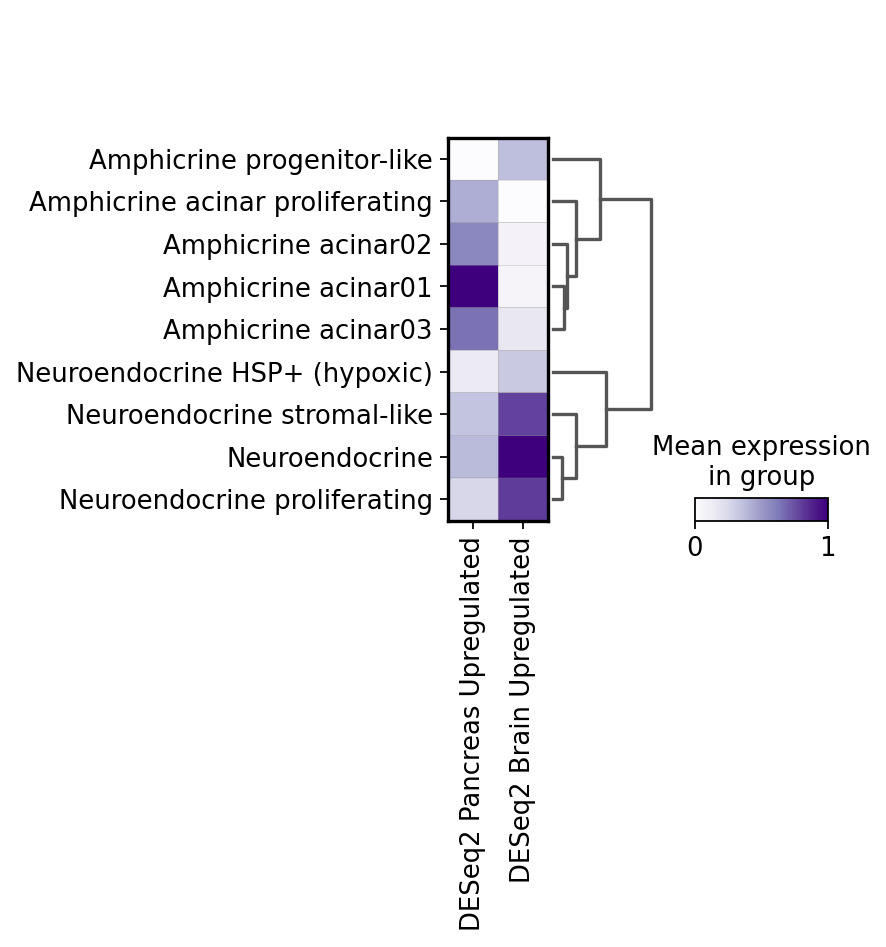

In [29]:
sc.tl.dendrogram(adata_sub03, groupby= "Cell states")

#2b matrixplot comparing pancreas vs brain upregulated DEGs:  
sc.pl.matrixplot(adata_sub03, ['DESeq2 Pancreas Upregulated', 
                             'DESeq2 Brain Upregulated'], 
                         groupby= "Cell states", dendrogram=True, standard_scale="var", cmap= "Purples",
                        swap_axes= False, save= "_Figure2b_DESeq2_brain_enrichment_NE_28022025.pdf")